In [399]:
!pwd

/home/william/language_modelling_andrej/intro_pytorch/Language_Modelling_intro/notebooks


In [418]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [419]:
words = open('../../names.txt', 'r').read().splitlines()

In [420]:
len(words)

32034

In [421]:
total_length= 0
for word in words:
    total_length+= len(word)
average_length = total_length/len(words)
average_length

6.122245114565774

# Creating Dataset

In [422]:
unique = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(unique)}
stoi['.'] =0
itos = {i:s for s, i in stoi.items()}
itos;

In [423]:

test_split = int(0.9*len(words))
train_split = int(0.8*len(words))
print(f' {test_split=}, {train_split=}')

 test_split=28830, train_split=25627


In [424]:
# def delete_multiple_element(list_object, indices):
#     indices = sorted(indices, reverse=True)
#     for idx in indices:
#         if idx < len(list_object):
#             list_object.pop(idx)
# def sample_and_remove(list_object, num):
#     #num is number of items to remove
#     original_data= list_object
#     data = list_object
#     sample= random.sample(list(enumerate(data)), num)
#     samples = [s[1] for s in sample]
#     sample_ids= [s[0] for s in sample]
#     delete_multiple_element(data, sample_ids)
#     return samples, data


In [425]:
def train_test_val_split(words):
    
    random.shuffle(words)
    train = words[:train_split]
    val = words[train_split:test_split]
    test= words[test_split:]
    return train, val, test

In [426]:
train, val, test = train_test_val_split(words)

In [427]:
n_gram = 6
def build_dataset(words, n_gram=6):
    X = []
    Y = []
    num =0
    for word in words:
        word = word + '.'
    #     print(word)
        context = [0]* n_gram
        for ch in word:
            num +=1
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(f"{''.join((itos[c] for c in context))} ----> {itos[ix]}")
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
X_train, y_train = build_dataset(train)
X_val, y_val = build_dataset(val)
X_test, y_test = build_dataset(test)


In [428]:
X_train.shape, X_val.shape, X_test.shape

(torch.Size([182570, 6]), torch.Size([22832, 6]), torch.Size([22752, 6]))

In [429]:
y_train.shape, y_val.shape, y_test.shape

(torch.Size([182570]), torch.Size([22832]), torch.Size([22752]))

In [478]:
g = torch.Generator().manual_seed(0)
emb_dim = 10 # embedding dimensions
C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((n_gram*emb_dim, 300),generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

In [479]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [480]:
num_params = 0
for p in parameters:
    num_params += p.nelement()
num_params

26697

In [481]:
loss_history = []
l_rates_e= torch.linspace(-3, -1, 1000)
l_rates = l_rates_e.exp()
l_rates;

In [482]:
batch_size = 64
batch =torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
X_train[batch].shape
# Y[batch];

torch.Size([64, 6])

In [486]:
for epoch in range(50000):
    #batch construct
    batch =torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    #forward pass
    #embedding layer
    emb = C[X_train[batch]]
    # emb = emb.view(-1, n_gram*emb_dim)
    #hidden layer
    h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
    # h = torch.tanh(h)
    # output layer
    logits = (h @ W2) + b2
    # loss
    loss = F.cross_entropy(logits, y_train[batch])
    print(f'{loss=}, {epoch=}')
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update parameters
    lr = 0.075 if epoch < 90000 else 0.01
    for p in parameters:
        p.data += -0.001*p.grad
    
    #track stats
    loss_history.append(loss)


loss=tensor(2.3164, grad_fn=<NllLossBackward0>), epoch=0
loss=tensor(2.2229, grad_fn=<NllLossBackward0>), epoch=1
loss=tensor(2.0046, grad_fn=<NllLossBackward0>), epoch=2
loss=tensor(2.0619, grad_fn=<NllLossBackward0>), epoch=3
loss=tensor(2.1847, grad_fn=<NllLossBackward0>), epoch=4
loss=tensor(2.1995, grad_fn=<NllLossBackward0>), epoch=5
loss=tensor(2.2844, grad_fn=<NllLossBackward0>), epoch=6
loss=tensor(2.4893, grad_fn=<NllLossBackward0>), epoch=7
loss=tensor(2.2002, grad_fn=<NllLossBackward0>), epoch=8
loss=tensor(2.1995, grad_fn=<NllLossBackward0>), epoch=9
loss=tensor(2.0164, grad_fn=<NllLossBackward0>), epoch=10
loss=tensor(2.5038, grad_fn=<NllLossBackward0>), epoch=11
loss=tensor(2.1822, grad_fn=<NllLossBackward0>), epoch=12
loss=tensor(1.9945, grad_fn=<NllLossBackward0>), epoch=13
loss=tensor(2.2030, grad_fn=<NllLossBackward0>), epoch=14
loss=tensor(2.5055, grad_fn=<NllLossBackward0>), epoch=15
loss=tensor(2.1512, grad_fn=<NllLossBackward0>), epoch=16
loss=tensor(2.0605, grad

loss=tensor(2.2786, grad_fn=<NllLossBackward0>), epoch=170
loss=tensor(2.3455, grad_fn=<NllLossBackward0>), epoch=171
loss=tensor(2.2543, grad_fn=<NllLossBackward0>), epoch=172
loss=tensor(2.2559, grad_fn=<NllLossBackward0>), epoch=173
loss=tensor(2.0769, grad_fn=<NllLossBackward0>), epoch=174
loss=tensor(2.1767, grad_fn=<NllLossBackward0>), epoch=175
loss=tensor(2.3586, grad_fn=<NllLossBackward0>), epoch=176
loss=tensor(2.0926, grad_fn=<NllLossBackward0>), epoch=177
loss=tensor(2.2834, grad_fn=<NllLossBackward0>), epoch=178
loss=tensor(2.2877, grad_fn=<NllLossBackward0>), epoch=179
loss=tensor(2.5188, grad_fn=<NllLossBackward0>), epoch=180
loss=tensor(2.3503, grad_fn=<NllLossBackward0>), epoch=181
loss=tensor(2.1285, grad_fn=<NllLossBackward0>), epoch=182
loss=tensor(1.8456, grad_fn=<NllLossBackward0>), epoch=183
loss=tensor(2.2916, grad_fn=<NllLossBackward0>), epoch=184
loss=tensor(2.0055, grad_fn=<NllLossBackward0>), epoch=185
loss=tensor(2.0789, grad_fn=<NllLossBackward0>), epoch=1

loss=tensor(2.1681, grad_fn=<NllLossBackward0>), epoch=318
loss=tensor(2.2794, grad_fn=<NllLossBackward0>), epoch=319
loss=tensor(2.0640, grad_fn=<NllLossBackward0>), epoch=320
loss=tensor(2.3239, grad_fn=<NllLossBackward0>), epoch=321
loss=tensor(2.1922, grad_fn=<NllLossBackward0>), epoch=322
loss=tensor(2.0457, grad_fn=<NllLossBackward0>), epoch=323
loss=tensor(2.2586, grad_fn=<NllLossBackward0>), epoch=324
loss=tensor(2.5241, grad_fn=<NllLossBackward0>), epoch=325
loss=tensor(2.2795, grad_fn=<NllLossBackward0>), epoch=326
loss=tensor(2.3805, grad_fn=<NllLossBackward0>), epoch=327
loss=tensor(2.1554, grad_fn=<NllLossBackward0>), epoch=328
loss=tensor(2.0773, grad_fn=<NllLossBackward0>), epoch=329
loss=tensor(2.6136, grad_fn=<NllLossBackward0>), epoch=330
loss=tensor(2.1472, grad_fn=<NllLossBackward0>), epoch=331
loss=tensor(2.1460, grad_fn=<NllLossBackward0>), epoch=332
loss=tensor(2.0239, grad_fn=<NllLossBackward0>), epoch=333
loss=tensor(2.4461, grad_fn=<NllLossBackward0>), epoch=3

loss=tensor(2.4150, grad_fn=<NllLossBackward0>), epoch=468
loss=tensor(2.2152, grad_fn=<NllLossBackward0>), epoch=469
loss=tensor(2.3615, grad_fn=<NllLossBackward0>), epoch=470
loss=tensor(2.2667, grad_fn=<NllLossBackward0>), epoch=471
loss=tensor(2.0884, grad_fn=<NllLossBackward0>), epoch=472
loss=tensor(2.4710, grad_fn=<NllLossBackward0>), epoch=473
loss=tensor(2.2319, grad_fn=<NllLossBackward0>), epoch=474
loss=tensor(2.2925, grad_fn=<NllLossBackward0>), epoch=475
loss=tensor(2.0951, grad_fn=<NllLossBackward0>), epoch=476
loss=tensor(2.1102, grad_fn=<NllLossBackward0>), epoch=477
loss=tensor(1.9350, grad_fn=<NllLossBackward0>), epoch=478
loss=tensor(1.8454, grad_fn=<NllLossBackward0>), epoch=479
loss=tensor(2.0097, grad_fn=<NllLossBackward0>), epoch=480
loss=tensor(2.0234, grad_fn=<NllLossBackward0>), epoch=481
loss=tensor(2.0989, grad_fn=<NllLossBackward0>), epoch=482
loss=tensor(2.4371, grad_fn=<NllLossBackward0>), epoch=483
loss=tensor(2.4407, grad_fn=<NllLossBackward0>), epoch=4

loss=tensor(2.3400, grad_fn=<NllLossBackward0>), epoch=628
loss=tensor(2.2869, grad_fn=<NllLossBackward0>), epoch=629
loss=tensor(2.3376, grad_fn=<NllLossBackward0>), epoch=630
loss=tensor(2.2489, grad_fn=<NllLossBackward0>), epoch=631
loss=tensor(2.0695, grad_fn=<NllLossBackward0>), epoch=632
loss=tensor(1.8788, grad_fn=<NllLossBackward0>), epoch=633
loss=tensor(2.0662, grad_fn=<NllLossBackward0>), epoch=634
loss=tensor(2.0878, grad_fn=<NllLossBackward0>), epoch=635
loss=tensor(2.4783, grad_fn=<NllLossBackward0>), epoch=636
loss=tensor(2.0895, grad_fn=<NllLossBackward0>), epoch=637
loss=tensor(2.4156, grad_fn=<NllLossBackward0>), epoch=638
loss=tensor(2.5973, grad_fn=<NllLossBackward0>), epoch=639
loss=tensor(2.2695, grad_fn=<NllLossBackward0>), epoch=640
loss=tensor(2.3273, grad_fn=<NllLossBackward0>), epoch=641
loss=tensor(2.2514, grad_fn=<NllLossBackward0>), epoch=642
loss=tensor(2.0947, grad_fn=<NllLossBackward0>), epoch=643
loss=tensor(2.2811, grad_fn=<NllLossBackward0>), epoch=6

loss=tensor(2.1393, grad_fn=<NllLossBackward0>), epoch=788
loss=tensor(2.1287, grad_fn=<NllLossBackward0>), epoch=789
loss=tensor(2.0050, grad_fn=<NllLossBackward0>), epoch=790
loss=tensor(1.9643, grad_fn=<NllLossBackward0>), epoch=791
loss=tensor(2.1653, grad_fn=<NllLossBackward0>), epoch=792
loss=tensor(2.1081, grad_fn=<NllLossBackward0>), epoch=793
loss=tensor(2.1109, grad_fn=<NllLossBackward0>), epoch=794
loss=tensor(2.2668, grad_fn=<NllLossBackward0>), epoch=795
loss=tensor(2.1146, grad_fn=<NllLossBackward0>), epoch=796
loss=tensor(2.3706, grad_fn=<NllLossBackward0>), epoch=797
loss=tensor(2.0464, grad_fn=<NllLossBackward0>), epoch=798
loss=tensor(2.1933, grad_fn=<NllLossBackward0>), epoch=799
loss=tensor(2.1027, grad_fn=<NllLossBackward0>), epoch=800
loss=tensor(1.9936, grad_fn=<NllLossBackward0>), epoch=801
loss=tensor(2.0899, grad_fn=<NllLossBackward0>), epoch=802
loss=tensor(2.0785, grad_fn=<NllLossBackward0>), epoch=803
loss=tensor(2.2165, grad_fn=<NllLossBackward0>), epoch=8

loss=tensor(2.0013, grad_fn=<NllLossBackward0>), epoch=927
loss=tensor(2.2372, grad_fn=<NllLossBackward0>), epoch=928
loss=tensor(2.1634, grad_fn=<NllLossBackward0>), epoch=929
loss=tensor(2.1598, grad_fn=<NllLossBackward0>), epoch=930
loss=tensor(2.1939, grad_fn=<NllLossBackward0>), epoch=931
loss=tensor(2.1261, grad_fn=<NllLossBackward0>), epoch=932
loss=tensor(2.5027, grad_fn=<NllLossBackward0>), epoch=933
loss=tensor(2.0011, grad_fn=<NllLossBackward0>), epoch=934
loss=tensor(2.1469, grad_fn=<NllLossBackward0>), epoch=935
loss=tensor(1.9124, grad_fn=<NllLossBackward0>), epoch=936
loss=tensor(2.2214, grad_fn=<NllLossBackward0>), epoch=937
loss=tensor(2.0644, grad_fn=<NllLossBackward0>), epoch=938
loss=tensor(2.1925, grad_fn=<NllLossBackward0>), epoch=939
loss=tensor(2.1510, grad_fn=<NllLossBackward0>), epoch=940
loss=tensor(2.1743, grad_fn=<NllLossBackward0>), epoch=941
loss=tensor(2.1644, grad_fn=<NllLossBackward0>), epoch=942
loss=tensor(2.3296, grad_fn=<NllLossBackward0>), epoch=9

loss=tensor(2.2975, grad_fn=<NllLossBackward0>), epoch=1087
loss=tensor(1.7387, grad_fn=<NllLossBackward0>), epoch=1088
loss=tensor(2.3421, grad_fn=<NllLossBackward0>), epoch=1089
loss=tensor(1.8629, grad_fn=<NllLossBackward0>), epoch=1090
loss=tensor(2.0148, grad_fn=<NllLossBackward0>), epoch=1091
loss=tensor(2.3411, grad_fn=<NllLossBackward0>), epoch=1092
loss=tensor(2.1845, grad_fn=<NllLossBackward0>), epoch=1093
loss=tensor(2.0553, grad_fn=<NllLossBackward0>), epoch=1094
loss=tensor(1.9571, grad_fn=<NllLossBackward0>), epoch=1095
loss=tensor(2.2677, grad_fn=<NllLossBackward0>), epoch=1096
loss=tensor(2.1204, grad_fn=<NllLossBackward0>), epoch=1097
loss=tensor(2.3538, grad_fn=<NllLossBackward0>), epoch=1098
loss=tensor(2.4367, grad_fn=<NllLossBackward0>), epoch=1099
loss=tensor(2.1469, grad_fn=<NllLossBackward0>), epoch=1100
loss=tensor(2.3572, grad_fn=<NllLossBackward0>), epoch=1101
loss=tensor(2.2952, grad_fn=<NllLossBackward0>), epoch=1102
loss=tensor(2.3217, grad_fn=<NllLossBack

loss=tensor(2.3671, grad_fn=<NllLossBackward0>), epoch=1237
loss=tensor(2.1192, grad_fn=<NllLossBackward0>), epoch=1238
loss=tensor(2.0943, grad_fn=<NllLossBackward0>), epoch=1239
loss=tensor(2.2109, grad_fn=<NllLossBackward0>), epoch=1240
loss=tensor(2.3693, grad_fn=<NllLossBackward0>), epoch=1241
loss=tensor(2.2240, grad_fn=<NllLossBackward0>), epoch=1242
loss=tensor(2.2417, grad_fn=<NllLossBackward0>), epoch=1243
loss=tensor(2.0810, grad_fn=<NllLossBackward0>), epoch=1244
loss=tensor(2.1764, grad_fn=<NllLossBackward0>), epoch=1245
loss=tensor(1.9837, grad_fn=<NllLossBackward0>), epoch=1246
loss=tensor(2.1789, grad_fn=<NllLossBackward0>), epoch=1247
loss=tensor(2.1189, grad_fn=<NllLossBackward0>), epoch=1248
loss=tensor(2.4222, grad_fn=<NllLossBackward0>), epoch=1249
loss=tensor(2.0631, grad_fn=<NllLossBackward0>), epoch=1250
loss=tensor(2.2760, grad_fn=<NllLossBackward0>), epoch=1251
loss=tensor(2.0423, grad_fn=<NllLossBackward0>), epoch=1252
loss=tensor(2.1875, grad_fn=<NllLossBack

loss=tensor(2.2098, grad_fn=<NllLossBackward0>), epoch=1403
loss=tensor(2.0406, grad_fn=<NllLossBackward0>), epoch=1404
loss=tensor(2.1504, grad_fn=<NllLossBackward0>), epoch=1405
loss=tensor(2.2229, grad_fn=<NllLossBackward0>), epoch=1406
loss=tensor(2.2215, grad_fn=<NllLossBackward0>), epoch=1407
loss=tensor(2.1188, grad_fn=<NllLossBackward0>), epoch=1408
loss=tensor(2.0461, grad_fn=<NllLossBackward0>), epoch=1409
loss=tensor(2.1213, grad_fn=<NllLossBackward0>), epoch=1410
loss=tensor(2.1127, grad_fn=<NllLossBackward0>), epoch=1411
loss=tensor(2.3084, grad_fn=<NllLossBackward0>), epoch=1412
loss=tensor(2.2685, grad_fn=<NllLossBackward0>), epoch=1413
loss=tensor(1.8846, grad_fn=<NllLossBackward0>), epoch=1414
loss=tensor(2.2004, grad_fn=<NllLossBackward0>), epoch=1415
loss=tensor(2.3877, grad_fn=<NllLossBackward0>), epoch=1416
loss=tensor(2.4288, grad_fn=<NllLossBackward0>), epoch=1417
loss=tensor(2.1440, grad_fn=<NllLossBackward0>), epoch=1418
loss=tensor(2.2443, grad_fn=<NllLossBack

loss=tensor(2.2178, grad_fn=<NllLossBackward0>), epoch=1572
loss=tensor(2.2395, grad_fn=<NllLossBackward0>), epoch=1573
loss=tensor(2.3086, grad_fn=<NllLossBackward0>), epoch=1574
loss=tensor(2.0688, grad_fn=<NllLossBackward0>), epoch=1575
loss=tensor(2.2769, grad_fn=<NllLossBackward0>), epoch=1576
loss=tensor(2.2611, grad_fn=<NllLossBackward0>), epoch=1577
loss=tensor(2.1940, grad_fn=<NllLossBackward0>), epoch=1578
loss=tensor(2.1521, grad_fn=<NllLossBackward0>), epoch=1579
loss=tensor(2.0780, grad_fn=<NllLossBackward0>), epoch=1580
loss=tensor(2.1588, grad_fn=<NllLossBackward0>), epoch=1581
loss=tensor(2.3630, grad_fn=<NllLossBackward0>), epoch=1582
loss=tensor(2.2376, grad_fn=<NllLossBackward0>), epoch=1583
loss=tensor(2.2229, grad_fn=<NllLossBackward0>), epoch=1584
loss=tensor(2.2682, grad_fn=<NllLossBackward0>), epoch=1585
loss=tensor(2.2015, grad_fn=<NllLossBackward0>), epoch=1586
loss=tensor(2.3288, grad_fn=<NllLossBackward0>), epoch=1587
loss=tensor(2.0852, grad_fn=<NllLossBack

loss=tensor(2.5884, grad_fn=<NllLossBackward0>), epoch=1720
loss=tensor(2.1810, grad_fn=<NllLossBackward0>), epoch=1721
loss=tensor(2.0706, grad_fn=<NllLossBackward0>), epoch=1722
loss=tensor(2.3246, grad_fn=<NllLossBackward0>), epoch=1723
loss=tensor(2.0258, grad_fn=<NllLossBackward0>), epoch=1724
loss=tensor(2.3664, grad_fn=<NllLossBackward0>), epoch=1725
loss=tensor(2.1677, grad_fn=<NllLossBackward0>), epoch=1726
loss=tensor(2.2558, grad_fn=<NllLossBackward0>), epoch=1727
loss=tensor(2.1984, grad_fn=<NllLossBackward0>), epoch=1728
loss=tensor(2.3214, grad_fn=<NllLossBackward0>), epoch=1729
loss=tensor(2.1431, grad_fn=<NllLossBackward0>), epoch=1730
loss=tensor(2.4012, grad_fn=<NllLossBackward0>), epoch=1731
loss=tensor(2.1717, grad_fn=<NllLossBackward0>), epoch=1732
loss=tensor(2.3120, grad_fn=<NllLossBackward0>), epoch=1733
loss=tensor(2.3597, grad_fn=<NllLossBackward0>), epoch=1734
loss=tensor(2.2709, grad_fn=<NllLossBackward0>), epoch=1735
loss=tensor(2.3438, grad_fn=<NllLossBack

loss=tensor(1.9952, grad_fn=<NllLossBackward0>), epoch=1884
loss=tensor(2.3731, grad_fn=<NllLossBackward0>), epoch=1885
loss=tensor(2.1920, grad_fn=<NllLossBackward0>), epoch=1886
loss=tensor(2.1235, grad_fn=<NllLossBackward0>), epoch=1887
loss=tensor(1.9219, grad_fn=<NllLossBackward0>), epoch=1888
loss=tensor(2.0908, grad_fn=<NllLossBackward0>), epoch=1889
loss=tensor(2.1053, grad_fn=<NllLossBackward0>), epoch=1890
loss=tensor(2.1721, grad_fn=<NllLossBackward0>), epoch=1891
loss=tensor(2.0764, grad_fn=<NllLossBackward0>), epoch=1892
loss=tensor(2.1412, grad_fn=<NllLossBackward0>), epoch=1893
loss=tensor(1.9756, grad_fn=<NllLossBackward0>), epoch=1894
loss=tensor(2.0596, grad_fn=<NllLossBackward0>), epoch=1895
loss=tensor(2.3052, grad_fn=<NllLossBackward0>), epoch=1896
loss=tensor(1.9328, grad_fn=<NllLossBackward0>), epoch=1897
loss=tensor(2.0539, grad_fn=<NllLossBackward0>), epoch=1898
loss=tensor(2.1464, grad_fn=<NllLossBackward0>), epoch=1899
loss=tensor(2.3158, grad_fn=<NllLossBack

loss=tensor(2.3799, grad_fn=<NllLossBackward0>), epoch=2034
loss=tensor(2.2658, grad_fn=<NllLossBackward0>), epoch=2035
loss=tensor(2.0004, grad_fn=<NllLossBackward0>), epoch=2036
loss=tensor(2.2285, grad_fn=<NllLossBackward0>), epoch=2037
loss=tensor(2.2648, grad_fn=<NllLossBackward0>), epoch=2038
loss=tensor(2.3086, grad_fn=<NllLossBackward0>), epoch=2039
loss=tensor(2.1707, grad_fn=<NllLossBackward0>), epoch=2040
loss=tensor(2.1819, grad_fn=<NllLossBackward0>), epoch=2041
loss=tensor(2.2424, grad_fn=<NllLossBackward0>), epoch=2042
loss=tensor(2.0664, grad_fn=<NllLossBackward0>), epoch=2043
loss=tensor(2.0143, grad_fn=<NllLossBackward0>), epoch=2044
loss=tensor(2.3574, grad_fn=<NllLossBackward0>), epoch=2045
loss=tensor(2.2242, grad_fn=<NllLossBackward0>), epoch=2046
loss=tensor(2.2706, grad_fn=<NllLossBackward0>), epoch=2047
loss=tensor(2.1811, grad_fn=<NllLossBackward0>), epoch=2048
loss=tensor(2.1568, grad_fn=<NllLossBackward0>), epoch=2049
loss=tensor(2.2787, grad_fn=<NllLossBack

loss=tensor(2.2305, grad_fn=<NllLossBackward0>), epoch=2173
loss=tensor(2.0886, grad_fn=<NllLossBackward0>), epoch=2174
loss=tensor(2.1531, grad_fn=<NllLossBackward0>), epoch=2175
loss=tensor(2.4075, grad_fn=<NllLossBackward0>), epoch=2176
loss=tensor(2.4938, grad_fn=<NllLossBackward0>), epoch=2177
loss=tensor(2.4440, grad_fn=<NllLossBackward0>), epoch=2178
loss=tensor(2.2726, grad_fn=<NllLossBackward0>), epoch=2179
loss=tensor(2.2290, grad_fn=<NllLossBackward0>), epoch=2180
loss=tensor(2.0158, grad_fn=<NllLossBackward0>), epoch=2181
loss=tensor(2.3763, grad_fn=<NllLossBackward0>), epoch=2182
loss=tensor(1.9769, grad_fn=<NllLossBackward0>), epoch=2183
loss=tensor(2.3134, grad_fn=<NllLossBackward0>), epoch=2184
loss=tensor(2.1114, grad_fn=<NllLossBackward0>), epoch=2185
loss=tensor(2.1188, grad_fn=<NllLossBackward0>), epoch=2186
loss=tensor(2.2941, grad_fn=<NllLossBackward0>), epoch=2187
loss=tensor(1.8938, grad_fn=<NllLossBackward0>), epoch=2188
loss=tensor(1.9515, grad_fn=<NllLossBack

loss=tensor(2.0554, grad_fn=<NllLossBackward0>), epoch=2326
loss=tensor(2.4393, grad_fn=<NllLossBackward0>), epoch=2327
loss=tensor(2.1437, grad_fn=<NllLossBackward0>), epoch=2328
loss=tensor(2.2721, grad_fn=<NllLossBackward0>), epoch=2329
loss=tensor(1.9352, grad_fn=<NllLossBackward0>), epoch=2330
loss=tensor(2.4043, grad_fn=<NllLossBackward0>), epoch=2331
loss=tensor(2.2545, grad_fn=<NllLossBackward0>), epoch=2332
loss=tensor(2.4013, grad_fn=<NllLossBackward0>), epoch=2333
loss=tensor(2.0676, grad_fn=<NllLossBackward0>), epoch=2334
loss=tensor(2.0418, grad_fn=<NllLossBackward0>), epoch=2335
loss=tensor(2.1426, grad_fn=<NllLossBackward0>), epoch=2336
loss=tensor(1.8642, grad_fn=<NllLossBackward0>), epoch=2337
loss=tensor(2.1955, grad_fn=<NllLossBackward0>), epoch=2338
loss=tensor(2.2610, grad_fn=<NllLossBackward0>), epoch=2339
loss=tensor(2.0159, grad_fn=<NllLossBackward0>), epoch=2340
loss=tensor(1.8085, grad_fn=<NllLossBackward0>), epoch=2341
loss=tensor(2.2291, grad_fn=<NllLossBack

loss=tensor(2.2027, grad_fn=<NllLossBackward0>), epoch=2464
loss=tensor(2.1574, grad_fn=<NllLossBackward0>), epoch=2465
loss=tensor(2.0945, grad_fn=<NllLossBackward0>), epoch=2466
loss=tensor(2.1260, grad_fn=<NllLossBackward0>), epoch=2467
loss=tensor(2.5427, grad_fn=<NllLossBackward0>), epoch=2468
loss=tensor(2.1945, grad_fn=<NllLossBackward0>), epoch=2469
loss=tensor(2.2467, grad_fn=<NllLossBackward0>), epoch=2470
loss=tensor(2.1097, grad_fn=<NllLossBackward0>), epoch=2471
loss=tensor(2.1881, grad_fn=<NllLossBackward0>), epoch=2472
loss=tensor(2.1955, grad_fn=<NllLossBackward0>), epoch=2473
loss=tensor(2.3611, grad_fn=<NllLossBackward0>), epoch=2474
loss=tensor(2.1424, grad_fn=<NllLossBackward0>), epoch=2475
loss=tensor(2.3178, grad_fn=<NllLossBackward0>), epoch=2476
loss=tensor(2.1747, grad_fn=<NllLossBackward0>), epoch=2477
loss=tensor(2.0289, grad_fn=<NllLossBackward0>), epoch=2478
loss=tensor(2.2873, grad_fn=<NllLossBackward0>), epoch=2479
loss=tensor(2.3367, grad_fn=<NllLossBack

loss=tensor(2.1743, grad_fn=<NllLossBackward0>), epoch=2603
loss=tensor(2.1815, grad_fn=<NllLossBackward0>), epoch=2604
loss=tensor(2.1596, grad_fn=<NllLossBackward0>), epoch=2605
loss=tensor(2.3211, grad_fn=<NllLossBackward0>), epoch=2606
loss=tensor(2.2956, grad_fn=<NllLossBackward0>), epoch=2607
loss=tensor(2.0709, grad_fn=<NllLossBackward0>), epoch=2608
loss=tensor(2.2189, grad_fn=<NllLossBackward0>), epoch=2609
loss=tensor(2.4736, grad_fn=<NllLossBackward0>), epoch=2610
loss=tensor(2.0520, grad_fn=<NllLossBackward0>), epoch=2611
loss=tensor(2.3004, grad_fn=<NllLossBackward0>), epoch=2612
loss=tensor(2.0423, grad_fn=<NllLossBackward0>), epoch=2613
loss=tensor(2.2843, grad_fn=<NllLossBackward0>), epoch=2614
loss=tensor(2.0353, grad_fn=<NllLossBackward0>), epoch=2615
loss=tensor(2.1327, grad_fn=<NllLossBackward0>), epoch=2616
loss=tensor(2.0693, grad_fn=<NllLossBackward0>), epoch=2617
loss=tensor(2.1482, grad_fn=<NllLossBackward0>), epoch=2618
loss=tensor(2.2403, grad_fn=<NllLossBack

loss=tensor(2.2511, grad_fn=<NllLossBackward0>), epoch=2755
loss=tensor(2.2252, grad_fn=<NllLossBackward0>), epoch=2756
loss=tensor(1.9559, grad_fn=<NllLossBackward0>), epoch=2757
loss=tensor(2.2857, grad_fn=<NllLossBackward0>), epoch=2758
loss=tensor(2.3047, grad_fn=<NllLossBackward0>), epoch=2759
loss=tensor(2.4315, grad_fn=<NllLossBackward0>), epoch=2760
loss=tensor(2.1417, grad_fn=<NllLossBackward0>), epoch=2761
loss=tensor(2.0114, grad_fn=<NllLossBackward0>), epoch=2762
loss=tensor(2.0153, grad_fn=<NllLossBackward0>), epoch=2763
loss=tensor(2.0169, grad_fn=<NllLossBackward0>), epoch=2764
loss=tensor(2.2643, grad_fn=<NllLossBackward0>), epoch=2765
loss=tensor(1.9015, grad_fn=<NllLossBackward0>), epoch=2766
loss=tensor(2.1161, grad_fn=<NllLossBackward0>), epoch=2767
loss=tensor(2.0130, grad_fn=<NllLossBackward0>), epoch=2768
loss=tensor(2.0999, grad_fn=<NllLossBackward0>), epoch=2769
loss=tensor(2.3292, grad_fn=<NllLossBackward0>), epoch=2770
loss=tensor(2.1653, grad_fn=<NllLossBack

loss=tensor(2.1753, grad_fn=<NllLossBackward0>), epoch=2901
loss=tensor(2.3935, grad_fn=<NllLossBackward0>), epoch=2902
loss=tensor(2.0744, grad_fn=<NllLossBackward0>), epoch=2903
loss=tensor(2.1481, grad_fn=<NllLossBackward0>), epoch=2904
loss=tensor(2.5595, grad_fn=<NllLossBackward0>), epoch=2905
loss=tensor(2.3037, grad_fn=<NllLossBackward0>), epoch=2906
loss=tensor(2.0236, grad_fn=<NllLossBackward0>), epoch=2907
loss=tensor(2.4026, grad_fn=<NllLossBackward0>), epoch=2908
loss=tensor(2.1369, grad_fn=<NllLossBackward0>), epoch=2909
loss=tensor(2.1152, grad_fn=<NllLossBackward0>), epoch=2910
loss=tensor(2.3420, grad_fn=<NllLossBackward0>), epoch=2911
loss=tensor(2.2155, grad_fn=<NllLossBackward0>), epoch=2912
loss=tensor(2.2356, grad_fn=<NllLossBackward0>), epoch=2913
loss=tensor(2.3641, grad_fn=<NllLossBackward0>), epoch=2914
loss=tensor(1.9843, grad_fn=<NllLossBackward0>), epoch=2915
loss=tensor(2.1258, grad_fn=<NllLossBackward0>), epoch=2916
loss=tensor(2.3039, grad_fn=<NllLossBack

loss=tensor(2.5277, grad_fn=<NllLossBackward0>), epoch=3069
loss=tensor(2.4727, grad_fn=<NllLossBackward0>), epoch=3070
loss=tensor(2.2943, grad_fn=<NllLossBackward0>), epoch=3071
loss=tensor(2.1634, grad_fn=<NllLossBackward0>), epoch=3072
loss=tensor(2.0784, grad_fn=<NllLossBackward0>), epoch=3073
loss=tensor(2.0575, grad_fn=<NllLossBackward0>), epoch=3074
loss=tensor(2.4210, grad_fn=<NllLossBackward0>), epoch=3075
loss=tensor(2.3579, grad_fn=<NllLossBackward0>), epoch=3076
loss=tensor(2.2760, grad_fn=<NllLossBackward0>), epoch=3077
loss=tensor(2.2529, grad_fn=<NllLossBackward0>), epoch=3078
loss=tensor(2.2511, grad_fn=<NllLossBackward0>), epoch=3079
loss=tensor(2.2472, grad_fn=<NllLossBackward0>), epoch=3080
loss=tensor(2.2954, grad_fn=<NllLossBackward0>), epoch=3081
loss=tensor(2.1081, grad_fn=<NllLossBackward0>), epoch=3082
loss=tensor(2.5472, grad_fn=<NllLossBackward0>), epoch=3083
loss=tensor(2.1397, grad_fn=<NllLossBackward0>), epoch=3084
loss=tensor(1.9513, grad_fn=<NllLossBack

loss=tensor(2.4326, grad_fn=<NllLossBackward0>), epoch=3210
loss=tensor(2.1044, grad_fn=<NllLossBackward0>), epoch=3211
loss=tensor(2.2363, grad_fn=<NllLossBackward0>), epoch=3212
loss=tensor(2.4425, grad_fn=<NllLossBackward0>), epoch=3213
loss=tensor(2.4415, grad_fn=<NllLossBackward0>), epoch=3214
loss=tensor(2.3178, grad_fn=<NllLossBackward0>), epoch=3215
loss=tensor(1.9990, grad_fn=<NllLossBackward0>), epoch=3216
loss=tensor(2.3418, grad_fn=<NllLossBackward0>), epoch=3217
loss=tensor(2.2446, grad_fn=<NllLossBackward0>), epoch=3218
loss=tensor(2.0748, grad_fn=<NllLossBackward0>), epoch=3219
loss=tensor(2.1724, grad_fn=<NllLossBackward0>), epoch=3220
loss=tensor(1.9973, grad_fn=<NllLossBackward0>), epoch=3221
loss=tensor(2.1853, grad_fn=<NllLossBackward0>), epoch=3222
loss=tensor(2.2216, grad_fn=<NllLossBackward0>), epoch=3223
loss=tensor(2.1428, grad_fn=<NllLossBackward0>), epoch=3224
loss=tensor(2.3543, grad_fn=<NllLossBackward0>), epoch=3225
loss=tensor(2.4601, grad_fn=<NllLossBack

loss=tensor(2.1688, grad_fn=<NllLossBackward0>), epoch=3347
loss=tensor(2.2348, grad_fn=<NllLossBackward0>), epoch=3348
loss=tensor(2.1279, grad_fn=<NllLossBackward0>), epoch=3349
loss=tensor(2.2943, grad_fn=<NllLossBackward0>), epoch=3350
loss=tensor(1.8789, grad_fn=<NllLossBackward0>), epoch=3351
loss=tensor(1.8754, grad_fn=<NllLossBackward0>), epoch=3352
loss=tensor(2.2872, grad_fn=<NllLossBackward0>), epoch=3353
loss=tensor(2.3042, grad_fn=<NllLossBackward0>), epoch=3354
loss=tensor(2.2736, grad_fn=<NllLossBackward0>), epoch=3355
loss=tensor(2.1802, grad_fn=<NllLossBackward0>), epoch=3356
loss=tensor(2.1476, grad_fn=<NllLossBackward0>), epoch=3357
loss=tensor(2.1120, grad_fn=<NllLossBackward0>), epoch=3358
loss=tensor(2.2843, grad_fn=<NllLossBackward0>), epoch=3359
loss=tensor(2.2105, grad_fn=<NllLossBackward0>), epoch=3360
loss=tensor(2.1336, grad_fn=<NllLossBackward0>), epoch=3361
loss=tensor(2.3009, grad_fn=<NllLossBackward0>), epoch=3362
loss=tensor(2.4032, grad_fn=<NllLossBack

loss=tensor(2.0550, grad_fn=<NllLossBackward0>), epoch=3503
loss=tensor(2.1300, grad_fn=<NllLossBackward0>), epoch=3504
loss=tensor(2.0531, grad_fn=<NllLossBackward0>), epoch=3505
loss=tensor(2.2449, grad_fn=<NllLossBackward0>), epoch=3506
loss=tensor(2.1478, grad_fn=<NllLossBackward0>), epoch=3507
loss=tensor(2.1419, grad_fn=<NllLossBackward0>), epoch=3508
loss=tensor(2.2398, grad_fn=<NllLossBackward0>), epoch=3509
loss=tensor(2.1110, grad_fn=<NllLossBackward0>), epoch=3510
loss=tensor(2.0995, grad_fn=<NllLossBackward0>), epoch=3511
loss=tensor(1.9963, grad_fn=<NllLossBackward0>), epoch=3512
loss=tensor(2.4688, grad_fn=<NllLossBackward0>), epoch=3513
loss=tensor(2.2378, grad_fn=<NllLossBackward0>), epoch=3514
loss=tensor(2.2829, grad_fn=<NllLossBackward0>), epoch=3515
loss=tensor(2.1136, grad_fn=<NllLossBackward0>), epoch=3516
loss=tensor(2.2807, grad_fn=<NllLossBackward0>), epoch=3517
loss=tensor(2.0672, grad_fn=<NllLossBackward0>), epoch=3518
loss=tensor(2.0786, grad_fn=<NllLossBack

loss=tensor(2.2982, grad_fn=<NllLossBackward0>), epoch=3648
loss=tensor(2.2605, grad_fn=<NllLossBackward0>), epoch=3649
loss=tensor(2.1872, grad_fn=<NllLossBackward0>), epoch=3650
loss=tensor(2.4068, grad_fn=<NllLossBackward0>), epoch=3651
loss=tensor(2.3011, grad_fn=<NllLossBackward0>), epoch=3652
loss=tensor(2.2075, grad_fn=<NllLossBackward0>), epoch=3653
loss=tensor(2.1984, grad_fn=<NllLossBackward0>), epoch=3654
loss=tensor(2.1249, grad_fn=<NllLossBackward0>), epoch=3655
loss=tensor(2.0998, grad_fn=<NllLossBackward0>), epoch=3656
loss=tensor(2.1337, grad_fn=<NllLossBackward0>), epoch=3657
loss=tensor(2.1484, grad_fn=<NllLossBackward0>), epoch=3658
loss=tensor(2.3185, grad_fn=<NllLossBackward0>), epoch=3659
loss=tensor(2.4156, grad_fn=<NllLossBackward0>), epoch=3660
loss=tensor(2.3751, grad_fn=<NllLossBackward0>), epoch=3661
loss=tensor(2.1931, grad_fn=<NllLossBackward0>), epoch=3662
loss=tensor(2.5180, grad_fn=<NllLossBackward0>), epoch=3663
loss=tensor(2.1790, grad_fn=<NllLossBack

loss=tensor(2.2353, grad_fn=<NllLossBackward0>), epoch=3786
loss=tensor(2.0586, grad_fn=<NllLossBackward0>), epoch=3787
loss=tensor(2.3981, grad_fn=<NllLossBackward0>), epoch=3788
loss=tensor(2.1098, grad_fn=<NllLossBackward0>), epoch=3789
loss=tensor(2.2186, grad_fn=<NllLossBackward0>), epoch=3790
loss=tensor(2.0021, grad_fn=<NllLossBackward0>), epoch=3791
loss=tensor(2.2903, grad_fn=<NllLossBackward0>), epoch=3792
loss=tensor(2.2883, grad_fn=<NllLossBackward0>), epoch=3793
loss=tensor(2.1337, grad_fn=<NllLossBackward0>), epoch=3794
loss=tensor(1.8014, grad_fn=<NllLossBackward0>), epoch=3795
loss=tensor(1.9651, grad_fn=<NllLossBackward0>), epoch=3796
loss=tensor(2.2394, grad_fn=<NllLossBackward0>), epoch=3797
loss=tensor(2.3124, grad_fn=<NllLossBackward0>), epoch=3798
loss=tensor(2.4734, grad_fn=<NllLossBackward0>), epoch=3799
loss=tensor(2.0530, grad_fn=<NllLossBackward0>), epoch=3800
loss=tensor(2.2543, grad_fn=<NllLossBackward0>), epoch=3801
loss=tensor(2.5492, grad_fn=<NllLossBack

loss=tensor(2.1405, grad_fn=<NllLossBackward0>), epoch=3926
loss=tensor(2.1968, grad_fn=<NllLossBackward0>), epoch=3927
loss=tensor(2.3083, grad_fn=<NllLossBackward0>), epoch=3928
loss=tensor(1.9830, grad_fn=<NllLossBackward0>), epoch=3929
loss=tensor(2.2934, grad_fn=<NllLossBackward0>), epoch=3930
loss=tensor(2.0865, grad_fn=<NllLossBackward0>), epoch=3931
loss=tensor(2.1805, grad_fn=<NllLossBackward0>), epoch=3932
loss=tensor(1.8193, grad_fn=<NllLossBackward0>), epoch=3933
loss=tensor(2.1258, grad_fn=<NllLossBackward0>), epoch=3934
loss=tensor(2.0707, grad_fn=<NllLossBackward0>), epoch=3935
loss=tensor(2.3083, grad_fn=<NllLossBackward0>), epoch=3936
loss=tensor(2.0098, grad_fn=<NllLossBackward0>), epoch=3937
loss=tensor(2.0216, grad_fn=<NllLossBackward0>), epoch=3938
loss=tensor(2.2786, grad_fn=<NllLossBackward0>), epoch=3939
loss=tensor(2.1693, grad_fn=<NllLossBackward0>), epoch=3940
loss=tensor(2.2691, grad_fn=<NllLossBackward0>), epoch=3941
loss=tensor(2.3746, grad_fn=<NllLossBack

loss=tensor(2.1942, grad_fn=<NllLossBackward0>), epoch=4075
loss=tensor(2.1313, grad_fn=<NllLossBackward0>), epoch=4076
loss=tensor(2.1937, grad_fn=<NllLossBackward0>), epoch=4077
loss=tensor(1.8239, grad_fn=<NllLossBackward0>), epoch=4078
loss=tensor(2.1277, grad_fn=<NllLossBackward0>), epoch=4079
loss=tensor(2.0330, grad_fn=<NllLossBackward0>), epoch=4080
loss=tensor(2.3889, grad_fn=<NllLossBackward0>), epoch=4081
loss=tensor(2.1225, grad_fn=<NllLossBackward0>), epoch=4082
loss=tensor(2.0416, grad_fn=<NllLossBackward0>), epoch=4083
loss=tensor(2.1609, grad_fn=<NllLossBackward0>), epoch=4084
loss=tensor(2.0069, grad_fn=<NllLossBackward0>), epoch=4085
loss=tensor(2.2284, grad_fn=<NllLossBackward0>), epoch=4086
loss=tensor(2.3577, grad_fn=<NllLossBackward0>), epoch=4087
loss=tensor(2.1592, grad_fn=<NllLossBackward0>), epoch=4088
loss=tensor(2.1824, grad_fn=<NllLossBackward0>), epoch=4089
loss=tensor(2.4130, grad_fn=<NllLossBackward0>), epoch=4090
loss=tensor(2.2239, grad_fn=<NllLossBack

loss=tensor(2.0857, grad_fn=<NllLossBackward0>), epoch=4218
loss=tensor(2.0553, grad_fn=<NllLossBackward0>), epoch=4219
loss=tensor(2.5930, grad_fn=<NllLossBackward0>), epoch=4220
loss=tensor(2.3905, grad_fn=<NllLossBackward0>), epoch=4221
loss=tensor(2.2977, grad_fn=<NllLossBackward0>), epoch=4222
loss=tensor(2.0130, grad_fn=<NllLossBackward0>), epoch=4223
loss=tensor(2.3517, grad_fn=<NllLossBackward0>), epoch=4224
loss=tensor(2.2235, grad_fn=<NllLossBackward0>), epoch=4225
loss=tensor(2.0816, grad_fn=<NllLossBackward0>), epoch=4226
loss=tensor(2.3214, grad_fn=<NllLossBackward0>), epoch=4227
loss=tensor(2.1611, grad_fn=<NllLossBackward0>), epoch=4228
loss=tensor(2.2895, grad_fn=<NllLossBackward0>), epoch=4229
loss=tensor(2.3105, grad_fn=<NllLossBackward0>), epoch=4230
loss=tensor(2.4232, grad_fn=<NllLossBackward0>), epoch=4231
loss=tensor(2.1569, grad_fn=<NllLossBackward0>), epoch=4232
loss=tensor(2.1849, grad_fn=<NllLossBackward0>), epoch=4233
loss=tensor(2.1799, grad_fn=<NllLossBack

loss=tensor(2.2235, grad_fn=<NllLossBackward0>), epoch=4374
loss=tensor(2.2247, grad_fn=<NllLossBackward0>), epoch=4375
loss=tensor(2.4545, grad_fn=<NllLossBackward0>), epoch=4376
loss=tensor(2.2654, grad_fn=<NllLossBackward0>), epoch=4377
loss=tensor(2.1211, grad_fn=<NllLossBackward0>), epoch=4378
loss=tensor(1.9956, grad_fn=<NllLossBackward0>), epoch=4379
loss=tensor(2.1073, grad_fn=<NllLossBackward0>), epoch=4380
loss=tensor(1.9546, grad_fn=<NllLossBackward0>), epoch=4381
loss=tensor(2.1222, grad_fn=<NllLossBackward0>), epoch=4382
loss=tensor(2.2713, grad_fn=<NllLossBackward0>), epoch=4383
loss=tensor(1.9754, grad_fn=<NllLossBackward0>), epoch=4384
loss=tensor(2.1572, grad_fn=<NllLossBackward0>), epoch=4385
loss=tensor(2.3102, grad_fn=<NllLossBackward0>), epoch=4386
loss=tensor(1.9505, grad_fn=<NllLossBackward0>), epoch=4387
loss=tensor(2.0163, grad_fn=<NllLossBackward0>), epoch=4388
loss=tensor(2.3135, grad_fn=<NllLossBackward0>), epoch=4389
loss=tensor(2.5333, grad_fn=<NllLossBack

loss=tensor(2.1381, grad_fn=<NllLossBackward0>), epoch=4531
loss=tensor(2.4659, grad_fn=<NllLossBackward0>), epoch=4532
loss=tensor(2.1657, grad_fn=<NllLossBackward0>), epoch=4533
loss=tensor(2.2559, grad_fn=<NllLossBackward0>), epoch=4534
loss=tensor(2.1934, grad_fn=<NllLossBackward0>), epoch=4535
loss=tensor(2.0431, grad_fn=<NllLossBackward0>), epoch=4536
loss=tensor(2.0439, grad_fn=<NllLossBackward0>), epoch=4537
loss=tensor(2.2230, grad_fn=<NllLossBackward0>), epoch=4538
loss=tensor(2.3883, grad_fn=<NllLossBackward0>), epoch=4539
loss=tensor(2.1150, grad_fn=<NllLossBackward0>), epoch=4540
loss=tensor(2.3063, grad_fn=<NllLossBackward0>), epoch=4541
loss=tensor(2.1350, grad_fn=<NllLossBackward0>), epoch=4542
loss=tensor(2.0652, grad_fn=<NllLossBackward0>), epoch=4543
loss=tensor(2.2499, grad_fn=<NllLossBackward0>), epoch=4544
loss=tensor(2.3046, grad_fn=<NllLossBackward0>), epoch=4545
loss=tensor(2.2786, grad_fn=<NllLossBackward0>), epoch=4546
loss=tensor(2.0367, grad_fn=<NllLossBack

loss=tensor(1.9983, grad_fn=<NllLossBackward0>), epoch=4702
loss=tensor(2.3446, grad_fn=<NllLossBackward0>), epoch=4703
loss=tensor(2.1875, grad_fn=<NllLossBackward0>), epoch=4704
loss=tensor(2.1245, grad_fn=<NllLossBackward0>), epoch=4705
loss=tensor(2.2899, grad_fn=<NllLossBackward0>), epoch=4706
loss=tensor(2.2990, grad_fn=<NllLossBackward0>), epoch=4707
loss=tensor(2.1127, grad_fn=<NllLossBackward0>), epoch=4708
loss=tensor(2.3034, grad_fn=<NllLossBackward0>), epoch=4709
loss=tensor(2.1161, grad_fn=<NllLossBackward0>), epoch=4710
loss=tensor(2.2912, grad_fn=<NllLossBackward0>), epoch=4711
loss=tensor(1.8681, grad_fn=<NllLossBackward0>), epoch=4712
loss=tensor(2.1740, grad_fn=<NllLossBackward0>), epoch=4713
loss=tensor(2.4671, grad_fn=<NllLossBackward0>), epoch=4714
loss=tensor(2.0531, grad_fn=<NllLossBackward0>), epoch=4715
loss=tensor(2.2697, grad_fn=<NllLossBackward0>), epoch=4716
loss=tensor(2.2149, grad_fn=<NllLossBackward0>), epoch=4717
loss=tensor(2.0430, grad_fn=<NllLossBack

loss=tensor(2.1398, grad_fn=<NllLossBackward0>), epoch=4844
loss=tensor(2.2158, grad_fn=<NllLossBackward0>), epoch=4845
loss=tensor(2.4649, grad_fn=<NllLossBackward0>), epoch=4846
loss=tensor(2.2456, grad_fn=<NllLossBackward0>), epoch=4847
loss=tensor(2.4821, grad_fn=<NllLossBackward0>), epoch=4848
loss=tensor(2.2498, grad_fn=<NllLossBackward0>), epoch=4849
loss=tensor(1.8839, grad_fn=<NllLossBackward0>), epoch=4850
loss=tensor(2.2172, grad_fn=<NllLossBackward0>), epoch=4851
loss=tensor(1.9169, grad_fn=<NllLossBackward0>), epoch=4852
loss=tensor(2.3038, grad_fn=<NllLossBackward0>), epoch=4853
loss=tensor(2.1324, grad_fn=<NllLossBackward0>), epoch=4854
loss=tensor(2.3159, grad_fn=<NllLossBackward0>), epoch=4855
loss=tensor(2.2687, grad_fn=<NllLossBackward0>), epoch=4856
loss=tensor(2.3345, grad_fn=<NllLossBackward0>), epoch=4857
loss=tensor(2.2220, grad_fn=<NllLossBackward0>), epoch=4858
loss=tensor(2.2915, grad_fn=<NllLossBackward0>), epoch=4859
loss=tensor(2.0688, grad_fn=<NllLossBack

loss=tensor(1.9836, grad_fn=<NllLossBackward0>), epoch=5010
loss=tensor(2.1283, grad_fn=<NllLossBackward0>), epoch=5011
loss=tensor(2.2987, grad_fn=<NllLossBackward0>), epoch=5012
loss=tensor(2.2237, grad_fn=<NllLossBackward0>), epoch=5013
loss=tensor(2.0927, grad_fn=<NllLossBackward0>), epoch=5014
loss=tensor(2.3448, grad_fn=<NllLossBackward0>), epoch=5015
loss=tensor(2.3826, grad_fn=<NllLossBackward0>), epoch=5016
loss=tensor(2.1644, grad_fn=<NllLossBackward0>), epoch=5017
loss=tensor(2.1315, grad_fn=<NllLossBackward0>), epoch=5018
loss=tensor(2.5732, grad_fn=<NllLossBackward0>), epoch=5019
loss=tensor(2.3227, grad_fn=<NllLossBackward0>), epoch=5020
loss=tensor(2.0488, grad_fn=<NllLossBackward0>), epoch=5021
loss=tensor(2.0173, grad_fn=<NllLossBackward0>), epoch=5022
loss=tensor(2.3455, grad_fn=<NllLossBackward0>), epoch=5023
loss=tensor(2.0417, grad_fn=<NllLossBackward0>), epoch=5024
loss=tensor(1.9413, grad_fn=<NllLossBackward0>), epoch=5025
loss=tensor(1.9131, grad_fn=<NllLossBack

loss=tensor(2.1555, grad_fn=<NllLossBackward0>), epoch=5153
loss=tensor(2.2293, grad_fn=<NllLossBackward0>), epoch=5154
loss=tensor(2.3523, grad_fn=<NllLossBackward0>), epoch=5155
loss=tensor(2.1884, grad_fn=<NllLossBackward0>), epoch=5156
loss=tensor(2.1639, grad_fn=<NllLossBackward0>), epoch=5157
loss=tensor(2.1531, grad_fn=<NllLossBackward0>), epoch=5158
loss=tensor(2.1105, grad_fn=<NllLossBackward0>), epoch=5159
loss=tensor(1.9520, grad_fn=<NllLossBackward0>), epoch=5160
loss=tensor(2.0364, grad_fn=<NllLossBackward0>), epoch=5161
loss=tensor(2.1252, grad_fn=<NllLossBackward0>), epoch=5162
loss=tensor(1.9506, grad_fn=<NllLossBackward0>), epoch=5163
loss=tensor(2.3829, grad_fn=<NllLossBackward0>), epoch=5164
loss=tensor(2.2124, grad_fn=<NllLossBackward0>), epoch=5165
loss=tensor(2.2064, grad_fn=<NllLossBackward0>), epoch=5166
loss=tensor(2.1537, grad_fn=<NllLossBackward0>), epoch=5167
loss=tensor(2.0669, grad_fn=<NllLossBackward0>), epoch=5168
loss=tensor(2.1847, grad_fn=<NllLossBack

loss=tensor(2.3129, grad_fn=<NllLossBackward0>), epoch=5302
loss=tensor(2.3424, grad_fn=<NllLossBackward0>), epoch=5303
loss=tensor(2.1173, grad_fn=<NllLossBackward0>), epoch=5304
loss=tensor(2.0970, grad_fn=<NllLossBackward0>), epoch=5305
loss=tensor(2.2116, grad_fn=<NllLossBackward0>), epoch=5306
loss=tensor(2.5351, grad_fn=<NllLossBackward0>), epoch=5307
loss=tensor(2.1521, grad_fn=<NllLossBackward0>), epoch=5308
loss=tensor(2.2535, grad_fn=<NllLossBackward0>), epoch=5309
loss=tensor(2.3580, grad_fn=<NllLossBackward0>), epoch=5310
loss=tensor(2.0731, grad_fn=<NllLossBackward0>), epoch=5311
loss=tensor(2.1757, grad_fn=<NllLossBackward0>), epoch=5312
loss=tensor(2.5374, grad_fn=<NllLossBackward0>), epoch=5313
loss=tensor(1.8393, grad_fn=<NllLossBackward0>), epoch=5314
loss=tensor(2.1141, grad_fn=<NllLossBackward0>), epoch=5315
loss=tensor(1.9820, grad_fn=<NllLossBackward0>), epoch=5316
loss=tensor(2.1188, grad_fn=<NllLossBackward0>), epoch=5317
loss=tensor(2.3776, grad_fn=<NllLossBack

loss=tensor(2.3992, grad_fn=<NllLossBackward0>), epoch=5479
loss=tensor(2.1458, grad_fn=<NllLossBackward0>), epoch=5480
loss=tensor(1.9743, grad_fn=<NllLossBackward0>), epoch=5481
loss=tensor(2.1243, grad_fn=<NllLossBackward0>), epoch=5482
loss=tensor(2.1423, grad_fn=<NllLossBackward0>), epoch=5483
loss=tensor(2.3145, grad_fn=<NllLossBackward0>), epoch=5484
loss=tensor(2.3583, grad_fn=<NllLossBackward0>), epoch=5485
loss=tensor(2.1399, grad_fn=<NllLossBackward0>), epoch=5486
loss=tensor(2.3071, grad_fn=<NllLossBackward0>), epoch=5487
loss=tensor(2.3191, grad_fn=<NllLossBackward0>), epoch=5488
loss=tensor(2.3011, grad_fn=<NllLossBackward0>), epoch=5489
loss=tensor(2.2838, grad_fn=<NllLossBackward0>), epoch=5490
loss=tensor(2.2067, grad_fn=<NllLossBackward0>), epoch=5491
loss=tensor(2.5827, grad_fn=<NllLossBackward0>), epoch=5492
loss=tensor(2.0469, grad_fn=<NllLossBackward0>), epoch=5493
loss=tensor(1.9065, grad_fn=<NllLossBackward0>), epoch=5494
loss=tensor(2.1293, grad_fn=<NllLossBack

loss=tensor(2.1542, grad_fn=<NllLossBackward0>), epoch=5622
loss=tensor(2.1243, grad_fn=<NllLossBackward0>), epoch=5623
loss=tensor(2.1397, grad_fn=<NllLossBackward0>), epoch=5624
loss=tensor(2.3919, grad_fn=<NllLossBackward0>), epoch=5625
loss=tensor(2.3422, grad_fn=<NllLossBackward0>), epoch=5626
loss=tensor(2.0857, grad_fn=<NllLossBackward0>), epoch=5627
loss=tensor(1.8466, grad_fn=<NllLossBackward0>), epoch=5628
loss=tensor(2.2774, grad_fn=<NllLossBackward0>), epoch=5629
loss=tensor(2.0871, grad_fn=<NllLossBackward0>), epoch=5630
loss=tensor(2.4944, grad_fn=<NllLossBackward0>), epoch=5631
loss=tensor(2.2027, grad_fn=<NllLossBackward0>), epoch=5632
loss=tensor(2.4698, grad_fn=<NllLossBackward0>), epoch=5633
loss=tensor(2.1954, grad_fn=<NllLossBackward0>), epoch=5634
loss=tensor(2.1478, grad_fn=<NllLossBackward0>), epoch=5635
loss=tensor(2.2001, grad_fn=<NllLossBackward0>), epoch=5636
loss=tensor(2.1548, grad_fn=<NllLossBackward0>), epoch=5637
loss=tensor(2.0721, grad_fn=<NllLossBack

loss=tensor(2.4484, grad_fn=<NllLossBackward0>), epoch=5805
loss=tensor(2.3401, grad_fn=<NllLossBackward0>), epoch=5806
loss=tensor(2.2101, grad_fn=<NllLossBackward0>), epoch=5807
loss=tensor(2.5457, grad_fn=<NllLossBackward0>), epoch=5808
loss=tensor(2.1847, grad_fn=<NllLossBackward0>), epoch=5809
loss=tensor(2.0728, grad_fn=<NllLossBackward0>), epoch=5810
loss=tensor(2.5483, grad_fn=<NllLossBackward0>), epoch=5811
loss=tensor(2.2355, grad_fn=<NllLossBackward0>), epoch=5812
loss=tensor(2.0952, grad_fn=<NllLossBackward0>), epoch=5813
loss=tensor(1.9388, grad_fn=<NllLossBackward0>), epoch=5814
loss=tensor(2.1395, grad_fn=<NllLossBackward0>), epoch=5815
loss=tensor(2.3754, grad_fn=<NllLossBackward0>), epoch=5816
loss=tensor(2.3735, grad_fn=<NllLossBackward0>), epoch=5817
loss=tensor(1.9617, grad_fn=<NllLossBackward0>), epoch=5818
loss=tensor(2.0792, grad_fn=<NllLossBackward0>), epoch=5819
loss=tensor(2.1564, grad_fn=<NllLossBackward0>), epoch=5820
loss=tensor(2.3248, grad_fn=<NllLossBack

loss=tensor(2.4392, grad_fn=<NllLossBackward0>), epoch=5982
loss=tensor(2.0037, grad_fn=<NllLossBackward0>), epoch=5983
loss=tensor(2.3636, grad_fn=<NllLossBackward0>), epoch=5984
loss=tensor(2.1882, grad_fn=<NllLossBackward0>), epoch=5985
loss=tensor(2.1815, grad_fn=<NllLossBackward0>), epoch=5986
loss=tensor(2.1809, grad_fn=<NllLossBackward0>), epoch=5987
loss=tensor(2.0756, grad_fn=<NllLossBackward0>), epoch=5988
loss=tensor(2.2881, grad_fn=<NllLossBackward0>), epoch=5989
loss=tensor(2.2170, grad_fn=<NllLossBackward0>), epoch=5990
loss=tensor(2.2152, grad_fn=<NllLossBackward0>), epoch=5991
loss=tensor(2.0497, grad_fn=<NllLossBackward0>), epoch=5992
loss=tensor(2.0195, grad_fn=<NllLossBackward0>), epoch=5993
loss=tensor(1.9537, grad_fn=<NllLossBackward0>), epoch=5994
loss=tensor(2.3279, grad_fn=<NllLossBackward0>), epoch=5995
loss=tensor(1.9768, grad_fn=<NllLossBackward0>), epoch=5996
loss=tensor(2.0553, grad_fn=<NllLossBackward0>), epoch=5997
loss=tensor(2.3118, grad_fn=<NllLossBack

loss=tensor(1.9971, grad_fn=<NllLossBackward0>), epoch=6143
loss=tensor(2.0810, grad_fn=<NllLossBackward0>), epoch=6144
loss=tensor(2.3846, grad_fn=<NllLossBackward0>), epoch=6145
loss=tensor(2.1306, grad_fn=<NllLossBackward0>), epoch=6146
loss=tensor(2.0919, grad_fn=<NllLossBackward0>), epoch=6147
loss=tensor(2.1715, grad_fn=<NllLossBackward0>), epoch=6148
loss=tensor(2.2101, grad_fn=<NllLossBackward0>), epoch=6149
loss=tensor(2.1484, grad_fn=<NllLossBackward0>), epoch=6150
loss=tensor(2.0721, grad_fn=<NllLossBackward0>), epoch=6151
loss=tensor(2.2931, grad_fn=<NllLossBackward0>), epoch=6152
loss=tensor(2.0263, grad_fn=<NllLossBackward0>), epoch=6153
loss=tensor(1.8294, grad_fn=<NllLossBackward0>), epoch=6154
loss=tensor(2.3358, grad_fn=<NllLossBackward0>), epoch=6155
loss=tensor(2.3272, grad_fn=<NllLossBackward0>), epoch=6156
loss=tensor(2.0071, grad_fn=<NllLossBackward0>), epoch=6157
loss=tensor(2.1115, grad_fn=<NllLossBackward0>), epoch=6158
loss=tensor(2.0413, grad_fn=<NllLossBack

loss=tensor(1.9952, grad_fn=<NllLossBackward0>), epoch=6295
loss=tensor(2.2416, grad_fn=<NllLossBackward0>), epoch=6296
loss=tensor(2.3432, grad_fn=<NllLossBackward0>), epoch=6297
loss=tensor(2.1727, grad_fn=<NllLossBackward0>), epoch=6298
loss=tensor(1.9787, grad_fn=<NllLossBackward0>), epoch=6299
loss=tensor(2.1802, grad_fn=<NllLossBackward0>), epoch=6300
loss=tensor(2.1105, grad_fn=<NllLossBackward0>), epoch=6301
loss=tensor(2.2010, grad_fn=<NllLossBackward0>), epoch=6302
loss=tensor(2.0322, grad_fn=<NllLossBackward0>), epoch=6303
loss=tensor(1.9743, grad_fn=<NllLossBackward0>), epoch=6304
loss=tensor(2.2879, grad_fn=<NllLossBackward0>), epoch=6305
loss=tensor(1.8551, grad_fn=<NllLossBackward0>), epoch=6306
loss=tensor(1.9774, grad_fn=<NllLossBackward0>), epoch=6307
loss=tensor(2.1549, grad_fn=<NllLossBackward0>), epoch=6308
loss=tensor(1.9114, grad_fn=<NllLossBackward0>), epoch=6309
loss=tensor(2.0903, grad_fn=<NllLossBackward0>), epoch=6310
loss=tensor(2.2629, grad_fn=<NllLossBack

loss=tensor(2.3891, grad_fn=<NllLossBackward0>), epoch=6445
loss=tensor(2.3774, grad_fn=<NllLossBackward0>), epoch=6446
loss=tensor(2.2393, grad_fn=<NllLossBackward0>), epoch=6447
loss=tensor(2.0731, grad_fn=<NllLossBackward0>), epoch=6448
loss=tensor(2.0814, grad_fn=<NllLossBackward0>), epoch=6449
loss=tensor(1.9918, grad_fn=<NllLossBackward0>), epoch=6450
loss=tensor(2.1726, grad_fn=<NllLossBackward0>), epoch=6451
loss=tensor(2.0208, grad_fn=<NllLossBackward0>), epoch=6452
loss=tensor(2.2939, grad_fn=<NllLossBackward0>), epoch=6453
loss=tensor(2.2073, grad_fn=<NllLossBackward0>), epoch=6454
loss=tensor(2.5491, grad_fn=<NllLossBackward0>), epoch=6455
loss=tensor(2.0968, grad_fn=<NllLossBackward0>), epoch=6456
loss=tensor(2.2457, grad_fn=<NllLossBackward0>), epoch=6457
loss=tensor(2.4928, grad_fn=<NllLossBackward0>), epoch=6458
loss=tensor(2.1761, grad_fn=<NllLossBackward0>), epoch=6459
loss=tensor(2.1950, grad_fn=<NllLossBackward0>), epoch=6460
loss=tensor(2.0264, grad_fn=<NllLossBack

loss=tensor(2.1551, grad_fn=<NllLossBackward0>), epoch=6597
loss=tensor(2.2873, grad_fn=<NllLossBackward0>), epoch=6598
loss=tensor(2.4573, grad_fn=<NllLossBackward0>), epoch=6599
loss=tensor(2.4517, grad_fn=<NllLossBackward0>), epoch=6600
loss=tensor(2.1372, grad_fn=<NllLossBackward0>), epoch=6601
loss=tensor(2.0697, grad_fn=<NllLossBackward0>), epoch=6602
loss=tensor(2.2131, grad_fn=<NllLossBackward0>), epoch=6603
loss=tensor(2.2296, grad_fn=<NllLossBackward0>), epoch=6604
loss=tensor(2.1019, grad_fn=<NllLossBackward0>), epoch=6605
loss=tensor(2.1139, grad_fn=<NllLossBackward0>), epoch=6606
loss=tensor(2.0839, grad_fn=<NllLossBackward0>), epoch=6607
loss=tensor(2.1298, grad_fn=<NllLossBackward0>), epoch=6608
loss=tensor(2.0816, grad_fn=<NllLossBackward0>), epoch=6609
loss=tensor(2.3340, grad_fn=<NllLossBackward0>), epoch=6610
loss=tensor(2.0646, grad_fn=<NllLossBackward0>), epoch=6611
loss=tensor(2.0988, grad_fn=<NllLossBackward0>), epoch=6612
loss=tensor(1.9939, grad_fn=<NllLossBack

loss=tensor(2.3912, grad_fn=<NllLossBackward0>), epoch=6737
loss=tensor(2.2546, grad_fn=<NllLossBackward0>), epoch=6738
loss=tensor(2.0125, grad_fn=<NllLossBackward0>), epoch=6739
loss=tensor(1.9995, grad_fn=<NllLossBackward0>), epoch=6740
loss=tensor(2.3094, grad_fn=<NllLossBackward0>), epoch=6741
loss=tensor(2.0430, grad_fn=<NllLossBackward0>), epoch=6742
loss=tensor(2.3907, grad_fn=<NllLossBackward0>), epoch=6743
loss=tensor(2.3368, grad_fn=<NllLossBackward0>), epoch=6744
loss=tensor(2.2452, grad_fn=<NllLossBackward0>), epoch=6745
loss=tensor(2.2700, grad_fn=<NllLossBackward0>), epoch=6746
loss=tensor(2.2845, grad_fn=<NllLossBackward0>), epoch=6747
loss=tensor(2.2562, grad_fn=<NllLossBackward0>), epoch=6748
loss=tensor(1.9482, grad_fn=<NllLossBackward0>), epoch=6749
loss=tensor(2.2476, grad_fn=<NllLossBackward0>), epoch=6750
loss=tensor(2.2611, grad_fn=<NllLossBackward0>), epoch=6751
loss=tensor(2.1308, grad_fn=<NllLossBackward0>), epoch=6752
loss=tensor(2.2324, grad_fn=<NllLossBack

loss=tensor(2.2961, grad_fn=<NllLossBackward0>), epoch=6898
loss=tensor(2.1134, grad_fn=<NllLossBackward0>), epoch=6899
loss=tensor(2.2834, grad_fn=<NllLossBackward0>), epoch=6900
loss=tensor(1.8063, grad_fn=<NllLossBackward0>), epoch=6901
loss=tensor(1.9462, grad_fn=<NllLossBackward0>), epoch=6902
loss=tensor(2.4227, grad_fn=<NllLossBackward0>), epoch=6903
loss=tensor(1.9013, grad_fn=<NllLossBackward0>), epoch=6904
loss=tensor(1.9666, grad_fn=<NllLossBackward0>), epoch=6905
loss=tensor(2.2732, grad_fn=<NllLossBackward0>), epoch=6906
loss=tensor(2.4691, grad_fn=<NllLossBackward0>), epoch=6907
loss=tensor(2.0278, grad_fn=<NllLossBackward0>), epoch=6908
loss=tensor(2.0194, grad_fn=<NllLossBackward0>), epoch=6909
loss=tensor(1.8720, grad_fn=<NllLossBackward0>), epoch=6910
loss=tensor(1.8752, grad_fn=<NllLossBackward0>), epoch=6911
loss=tensor(2.1820, grad_fn=<NllLossBackward0>), epoch=6912
loss=tensor(1.9281, grad_fn=<NllLossBackward0>), epoch=6913
loss=tensor(2.0742, grad_fn=<NllLossBack

loss=tensor(2.1146, grad_fn=<NllLossBackward0>), epoch=7058
loss=tensor(2.4749, grad_fn=<NllLossBackward0>), epoch=7059
loss=tensor(2.4339, grad_fn=<NllLossBackward0>), epoch=7060
loss=tensor(2.1711, grad_fn=<NllLossBackward0>), epoch=7061
loss=tensor(1.9153, grad_fn=<NllLossBackward0>), epoch=7062
loss=tensor(2.2048, grad_fn=<NllLossBackward0>), epoch=7063
loss=tensor(1.8333, grad_fn=<NllLossBackward0>), epoch=7064
loss=tensor(2.1253, grad_fn=<NllLossBackward0>), epoch=7065
loss=tensor(2.1456, grad_fn=<NllLossBackward0>), epoch=7066
loss=tensor(2.1737, grad_fn=<NllLossBackward0>), epoch=7067
loss=tensor(2.0727, grad_fn=<NllLossBackward0>), epoch=7068
loss=tensor(2.0598, grad_fn=<NllLossBackward0>), epoch=7069
loss=tensor(2.3364, grad_fn=<NllLossBackward0>), epoch=7070
loss=tensor(2.0490, grad_fn=<NllLossBackward0>), epoch=7071
loss=tensor(2.1432, grad_fn=<NllLossBackward0>), epoch=7072
loss=tensor(2.0334, grad_fn=<NllLossBackward0>), epoch=7073
loss=tensor(2.3404, grad_fn=<NllLossBack

loss=tensor(2.0180, grad_fn=<NllLossBackward0>), epoch=7197
loss=tensor(2.1964, grad_fn=<NllLossBackward0>), epoch=7198
loss=tensor(2.0547, grad_fn=<NllLossBackward0>), epoch=7199
loss=tensor(2.2778, grad_fn=<NllLossBackward0>), epoch=7200
loss=tensor(2.3959, grad_fn=<NllLossBackward0>), epoch=7201
loss=tensor(2.0891, grad_fn=<NllLossBackward0>), epoch=7202
loss=tensor(1.8788, grad_fn=<NllLossBackward0>), epoch=7203
loss=tensor(1.8264, grad_fn=<NllLossBackward0>), epoch=7204
loss=tensor(2.2290, grad_fn=<NllLossBackward0>), epoch=7205
loss=tensor(2.4661, grad_fn=<NllLossBackward0>), epoch=7206
loss=tensor(2.3706, grad_fn=<NllLossBackward0>), epoch=7207
loss=tensor(1.8899, grad_fn=<NllLossBackward0>), epoch=7208
loss=tensor(2.3235, grad_fn=<NllLossBackward0>), epoch=7209
loss=tensor(2.0145, grad_fn=<NllLossBackward0>), epoch=7210
loss=tensor(2.3271, grad_fn=<NllLossBackward0>), epoch=7211
loss=tensor(2.3382, grad_fn=<NllLossBackward0>), epoch=7212
loss=tensor(2.0854, grad_fn=<NllLossBack

loss=tensor(2.0631, grad_fn=<NllLossBackward0>), epoch=7375
loss=tensor(2.3694, grad_fn=<NllLossBackward0>), epoch=7376
loss=tensor(2.1405, grad_fn=<NllLossBackward0>), epoch=7377
loss=tensor(2.1992, grad_fn=<NllLossBackward0>), epoch=7378
loss=tensor(2.2187, grad_fn=<NllLossBackward0>), epoch=7379
loss=tensor(2.1648, grad_fn=<NllLossBackward0>), epoch=7380
loss=tensor(1.9960, grad_fn=<NllLossBackward0>), epoch=7381
loss=tensor(2.1246, grad_fn=<NllLossBackward0>), epoch=7382
loss=tensor(2.0247, grad_fn=<NllLossBackward0>), epoch=7383
loss=tensor(2.4060, grad_fn=<NllLossBackward0>), epoch=7384
loss=tensor(2.1357, grad_fn=<NllLossBackward0>), epoch=7385
loss=tensor(2.1890, grad_fn=<NllLossBackward0>), epoch=7386
loss=tensor(2.0746, grad_fn=<NllLossBackward0>), epoch=7387
loss=tensor(2.2317, grad_fn=<NllLossBackward0>), epoch=7388
loss=tensor(2.1232, grad_fn=<NllLossBackward0>), epoch=7389
loss=tensor(2.1577, grad_fn=<NllLossBackward0>), epoch=7390
loss=tensor(2.1948, grad_fn=<NllLossBack

loss=tensor(2.3442, grad_fn=<NllLossBackward0>), epoch=7522
loss=tensor(2.0507, grad_fn=<NllLossBackward0>), epoch=7523
loss=tensor(2.1872, grad_fn=<NllLossBackward0>), epoch=7524
loss=tensor(2.1225, grad_fn=<NllLossBackward0>), epoch=7525
loss=tensor(2.2561, grad_fn=<NllLossBackward0>), epoch=7526
loss=tensor(2.2254, grad_fn=<NllLossBackward0>), epoch=7527
loss=tensor(1.9426, grad_fn=<NllLossBackward0>), epoch=7528
loss=tensor(2.1552, grad_fn=<NllLossBackward0>), epoch=7529
loss=tensor(2.0858, grad_fn=<NllLossBackward0>), epoch=7530
loss=tensor(2.1716, grad_fn=<NllLossBackward0>), epoch=7531
loss=tensor(1.7409, grad_fn=<NllLossBackward0>), epoch=7532
loss=tensor(2.0485, grad_fn=<NllLossBackward0>), epoch=7533
loss=tensor(1.9547, grad_fn=<NllLossBackward0>), epoch=7534
loss=tensor(2.0062, grad_fn=<NllLossBackward0>), epoch=7535
loss=tensor(2.2370, grad_fn=<NllLossBackward0>), epoch=7536
loss=tensor(2.2153, grad_fn=<NllLossBackward0>), epoch=7537
loss=tensor(2.1921, grad_fn=<NllLossBack

loss=tensor(2.1807, grad_fn=<NllLossBackward0>), epoch=7684
loss=tensor(2.1803, grad_fn=<NllLossBackward0>), epoch=7685
loss=tensor(2.1007, grad_fn=<NllLossBackward0>), epoch=7686
loss=tensor(1.9593, grad_fn=<NllLossBackward0>), epoch=7687
loss=tensor(2.0910, grad_fn=<NllLossBackward0>), epoch=7688
loss=tensor(2.2260, grad_fn=<NllLossBackward0>), epoch=7689
loss=tensor(2.1806, grad_fn=<NllLossBackward0>), epoch=7690
loss=tensor(2.0319, grad_fn=<NllLossBackward0>), epoch=7691
loss=tensor(2.0605, grad_fn=<NllLossBackward0>), epoch=7692
loss=tensor(2.2545, grad_fn=<NllLossBackward0>), epoch=7693
loss=tensor(2.4463, grad_fn=<NllLossBackward0>), epoch=7694
loss=tensor(2.1570, grad_fn=<NllLossBackward0>), epoch=7695
loss=tensor(1.9938, grad_fn=<NllLossBackward0>), epoch=7696
loss=tensor(2.0612, grad_fn=<NllLossBackward0>), epoch=7697
loss=tensor(2.1292, grad_fn=<NllLossBackward0>), epoch=7698
loss=tensor(2.1294, grad_fn=<NllLossBackward0>), epoch=7699
loss=tensor(2.2042, grad_fn=<NllLossBack

loss=tensor(1.9916, grad_fn=<NllLossBackward0>), epoch=7853
loss=tensor(2.2897, grad_fn=<NllLossBackward0>), epoch=7854
loss=tensor(2.1064, grad_fn=<NllLossBackward0>), epoch=7855
loss=tensor(2.2505, grad_fn=<NllLossBackward0>), epoch=7856
loss=tensor(2.1835, grad_fn=<NllLossBackward0>), epoch=7857
loss=tensor(1.8895, grad_fn=<NllLossBackward0>), epoch=7858
loss=tensor(2.2380, grad_fn=<NllLossBackward0>), epoch=7859
loss=tensor(1.9993, grad_fn=<NllLossBackward0>), epoch=7860
loss=tensor(1.9319, grad_fn=<NllLossBackward0>), epoch=7861
loss=tensor(2.0002, grad_fn=<NllLossBackward0>), epoch=7862
loss=tensor(2.0183, grad_fn=<NllLossBackward0>), epoch=7863
loss=tensor(2.1333, grad_fn=<NllLossBackward0>), epoch=7864
loss=tensor(2.3554, grad_fn=<NllLossBackward0>), epoch=7865
loss=tensor(2.4214, grad_fn=<NllLossBackward0>), epoch=7866
loss=tensor(2.1015, grad_fn=<NllLossBackward0>), epoch=7867
loss=tensor(2.1198, grad_fn=<NllLossBackward0>), epoch=7868
loss=tensor(2.1172, grad_fn=<NllLossBack

loss=tensor(2.1668, grad_fn=<NllLossBackward0>), epoch=8005
loss=tensor(2.5936, grad_fn=<NllLossBackward0>), epoch=8006
loss=tensor(2.2881, grad_fn=<NllLossBackward0>), epoch=8007
loss=tensor(2.2096, grad_fn=<NllLossBackward0>), epoch=8008
loss=tensor(1.9886, grad_fn=<NllLossBackward0>), epoch=8009
loss=tensor(2.4286, grad_fn=<NllLossBackward0>), epoch=8010
loss=tensor(2.1492, grad_fn=<NllLossBackward0>), epoch=8011
loss=tensor(2.3668, grad_fn=<NllLossBackward0>), epoch=8012
loss=tensor(2.2965, grad_fn=<NllLossBackward0>), epoch=8013
loss=tensor(2.0709, grad_fn=<NllLossBackward0>), epoch=8014
loss=tensor(2.0107, grad_fn=<NllLossBackward0>), epoch=8015
loss=tensor(2.0404, grad_fn=<NllLossBackward0>), epoch=8016
loss=tensor(2.1065, grad_fn=<NllLossBackward0>), epoch=8017
loss=tensor(2.1552, grad_fn=<NllLossBackward0>), epoch=8018
loss=tensor(2.1621, grad_fn=<NllLossBackward0>), epoch=8019
loss=tensor(2.3987, grad_fn=<NllLossBackward0>), epoch=8020
loss=tensor(2.1509, grad_fn=<NllLossBack

loss=tensor(2.1239, grad_fn=<NllLossBackward0>), epoch=8163
loss=tensor(2.2866, grad_fn=<NllLossBackward0>), epoch=8164
loss=tensor(2.0690, grad_fn=<NllLossBackward0>), epoch=8165
loss=tensor(2.0488, grad_fn=<NllLossBackward0>), epoch=8166
loss=tensor(2.3577, grad_fn=<NllLossBackward0>), epoch=8167
loss=tensor(2.1058, grad_fn=<NllLossBackward0>), epoch=8168
loss=tensor(2.0990, grad_fn=<NllLossBackward0>), epoch=8169
loss=tensor(1.9565, grad_fn=<NllLossBackward0>), epoch=8170
loss=tensor(2.4087, grad_fn=<NllLossBackward0>), epoch=8171
loss=tensor(2.0298, grad_fn=<NllLossBackward0>), epoch=8172
loss=tensor(2.1551, grad_fn=<NllLossBackward0>), epoch=8173
loss=tensor(2.0509, grad_fn=<NllLossBackward0>), epoch=8174
loss=tensor(2.3007, grad_fn=<NllLossBackward0>), epoch=8175
loss=tensor(2.1348, grad_fn=<NllLossBackward0>), epoch=8176
loss=tensor(2.3428, grad_fn=<NllLossBackward0>), epoch=8177
loss=tensor(2.1764, grad_fn=<NllLossBackward0>), epoch=8178
loss=tensor(2.1557, grad_fn=<NllLossBack

loss=tensor(2.4701, grad_fn=<NllLossBackward0>), epoch=8336
loss=tensor(2.1717, grad_fn=<NllLossBackward0>), epoch=8337
loss=tensor(2.2276, grad_fn=<NllLossBackward0>), epoch=8338
loss=tensor(2.1178, grad_fn=<NllLossBackward0>), epoch=8339
loss=tensor(2.0684, grad_fn=<NllLossBackward0>), epoch=8340
loss=tensor(2.2198, grad_fn=<NllLossBackward0>), epoch=8341
loss=tensor(2.0189, grad_fn=<NllLossBackward0>), epoch=8342
loss=tensor(2.2233, grad_fn=<NllLossBackward0>), epoch=8343
loss=tensor(2.1663, grad_fn=<NllLossBackward0>), epoch=8344
loss=tensor(2.5222, grad_fn=<NllLossBackward0>), epoch=8345
loss=tensor(2.1780, grad_fn=<NllLossBackward0>), epoch=8346
loss=tensor(2.0029, grad_fn=<NllLossBackward0>), epoch=8347
loss=tensor(2.3133, grad_fn=<NllLossBackward0>), epoch=8348
loss=tensor(2.3488, grad_fn=<NllLossBackward0>), epoch=8349
loss=tensor(2.1238, grad_fn=<NllLossBackward0>), epoch=8350
loss=tensor(2.0912, grad_fn=<NllLossBackward0>), epoch=8351
loss=tensor(2.1603, grad_fn=<NllLossBack

loss=tensor(2.1075, grad_fn=<NllLossBackward0>), epoch=8481
loss=tensor(2.0936, grad_fn=<NllLossBackward0>), epoch=8482
loss=tensor(2.2127, grad_fn=<NllLossBackward0>), epoch=8483
loss=tensor(2.1674, grad_fn=<NllLossBackward0>), epoch=8484
loss=tensor(2.4324, grad_fn=<NllLossBackward0>), epoch=8485
loss=tensor(2.2992, grad_fn=<NllLossBackward0>), epoch=8486
loss=tensor(2.1810, grad_fn=<NllLossBackward0>), epoch=8487
loss=tensor(2.0948, grad_fn=<NllLossBackward0>), epoch=8488
loss=tensor(2.3365, grad_fn=<NllLossBackward0>), epoch=8489
loss=tensor(2.4302, grad_fn=<NllLossBackward0>), epoch=8490
loss=tensor(2.2654, grad_fn=<NllLossBackward0>), epoch=8491
loss=tensor(2.0301, grad_fn=<NllLossBackward0>), epoch=8492
loss=tensor(2.2159, grad_fn=<NllLossBackward0>), epoch=8493
loss=tensor(2.3002, grad_fn=<NllLossBackward0>), epoch=8494
loss=tensor(1.8089, grad_fn=<NllLossBackward0>), epoch=8495
loss=tensor(2.1448, grad_fn=<NllLossBackward0>), epoch=8496
loss=tensor(2.2854, grad_fn=<NllLossBack

loss=tensor(2.2631, grad_fn=<NllLossBackward0>), epoch=8643
loss=tensor(2.0798, grad_fn=<NllLossBackward0>), epoch=8644
loss=tensor(2.3694, grad_fn=<NllLossBackward0>), epoch=8645
loss=tensor(2.1322, grad_fn=<NllLossBackward0>), epoch=8646
loss=tensor(2.0829, grad_fn=<NllLossBackward0>), epoch=8647
loss=tensor(2.4743, grad_fn=<NllLossBackward0>), epoch=8648
loss=tensor(2.0492, grad_fn=<NllLossBackward0>), epoch=8649
loss=tensor(2.2597, grad_fn=<NllLossBackward0>), epoch=8650
loss=tensor(2.1323, grad_fn=<NllLossBackward0>), epoch=8651
loss=tensor(2.1819, grad_fn=<NllLossBackward0>), epoch=8652
loss=tensor(2.2826, grad_fn=<NllLossBackward0>), epoch=8653
loss=tensor(2.2213, grad_fn=<NllLossBackward0>), epoch=8654
loss=tensor(2.3014, grad_fn=<NllLossBackward0>), epoch=8655
loss=tensor(2.5070, grad_fn=<NllLossBackward0>), epoch=8656
loss=tensor(2.0329, grad_fn=<NllLossBackward0>), epoch=8657
loss=tensor(2.4057, grad_fn=<NllLossBackward0>), epoch=8658
loss=tensor(2.0262, grad_fn=<NllLossBack

loss=tensor(2.0850, grad_fn=<NllLossBackward0>), epoch=8795
loss=tensor(2.4774, grad_fn=<NllLossBackward0>), epoch=8796
loss=tensor(2.3045, grad_fn=<NllLossBackward0>), epoch=8797
loss=tensor(2.2931, grad_fn=<NllLossBackward0>), epoch=8798
loss=tensor(1.8429, grad_fn=<NllLossBackward0>), epoch=8799
loss=tensor(2.1221, grad_fn=<NllLossBackward0>), epoch=8800
loss=tensor(2.2802, grad_fn=<NllLossBackward0>), epoch=8801
loss=tensor(2.3554, grad_fn=<NllLossBackward0>), epoch=8802
loss=tensor(2.0605, grad_fn=<NllLossBackward0>), epoch=8803
loss=tensor(1.8436, grad_fn=<NllLossBackward0>), epoch=8804
loss=tensor(2.0486, grad_fn=<NllLossBackward0>), epoch=8805
loss=tensor(2.3504, grad_fn=<NllLossBackward0>), epoch=8806
loss=tensor(2.1704, grad_fn=<NllLossBackward0>), epoch=8807
loss=tensor(2.0604, grad_fn=<NllLossBackward0>), epoch=8808
loss=tensor(2.2341, grad_fn=<NllLossBackward0>), epoch=8809
loss=tensor(2.1687, grad_fn=<NllLossBackward0>), epoch=8810
loss=tensor(2.1326, grad_fn=<NllLossBack

loss=tensor(2.1909, grad_fn=<NllLossBackward0>), epoch=8932
loss=tensor(1.8984, grad_fn=<NllLossBackward0>), epoch=8933
loss=tensor(2.1580, grad_fn=<NllLossBackward0>), epoch=8934
loss=tensor(2.3007, grad_fn=<NllLossBackward0>), epoch=8935
loss=tensor(2.0124, grad_fn=<NllLossBackward0>), epoch=8936
loss=tensor(2.2815, grad_fn=<NllLossBackward0>), epoch=8937
loss=tensor(2.0488, grad_fn=<NllLossBackward0>), epoch=8938
loss=tensor(2.0143, grad_fn=<NllLossBackward0>), epoch=8939
loss=tensor(2.4272, grad_fn=<NllLossBackward0>), epoch=8940
loss=tensor(2.2176, grad_fn=<NllLossBackward0>), epoch=8941
loss=tensor(2.2141, grad_fn=<NllLossBackward0>), epoch=8942
loss=tensor(2.0548, grad_fn=<NllLossBackward0>), epoch=8943
loss=tensor(2.0984, grad_fn=<NllLossBackward0>), epoch=8944
loss=tensor(2.1425, grad_fn=<NllLossBackward0>), epoch=8945
loss=tensor(2.2597, grad_fn=<NllLossBackward0>), epoch=8946
loss=tensor(2.1031, grad_fn=<NllLossBackward0>), epoch=8947
loss=tensor(2.1823, grad_fn=<NllLossBack

loss=tensor(2.3561, grad_fn=<NllLossBackward0>), epoch=9106
loss=tensor(1.9714, grad_fn=<NllLossBackward0>), epoch=9107
loss=tensor(2.1878, grad_fn=<NllLossBackward0>), epoch=9108
loss=tensor(2.1878, grad_fn=<NllLossBackward0>), epoch=9109
loss=tensor(2.0450, grad_fn=<NllLossBackward0>), epoch=9110
loss=tensor(2.2683, grad_fn=<NllLossBackward0>), epoch=9111
loss=tensor(2.3781, grad_fn=<NllLossBackward0>), epoch=9112
loss=tensor(2.2830, grad_fn=<NllLossBackward0>), epoch=9113
loss=tensor(2.2524, grad_fn=<NllLossBackward0>), epoch=9114
loss=tensor(2.1185, grad_fn=<NllLossBackward0>), epoch=9115
loss=tensor(2.0209, grad_fn=<NllLossBackward0>), epoch=9116
loss=tensor(2.3686, grad_fn=<NllLossBackward0>), epoch=9117
loss=tensor(2.2093, grad_fn=<NllLossBackward0>), epoch=9118
loss=tensor(2.0723, grad_fn=<NllLossBackward0>), epoch=9119
loss=tensor(2.1186, grad_fn=<NllLossBackward0>), epoch=9120
loss=tensor(2.3124, grad_fn=<NllLossBackward0>), epoch=9121
loss=tensor(2.5587, grad_fn=<NllLossBack

loss=tensor(2.0164, grad_fn=<NllLossBackward0>), epoch=9266
loss=tensor(2.2113, grad_fn=<NllLossBackward0>), epoch=9267
loss=tensor(2.0706, grad_fn=<NllLossBackward0>), epoch=9268
loss=tensor(1.9086, grad_fn=<NllLossBackward0>), epoch=9269
loss=tensor(2.0633, grad_fn=<NllLossBackward0>), epoch=9270
loss=tensor(2.2204, grad_fn=<NllLossBackward0>), epoch=9271
loss=tensor(2.3335, grad_fn=<NllLossBackward0>), epoch=9272
loss=tensor(2.2415, grad_fn=<NllLossBackward0>), epoch=9273
loss=tensor(2.4746, grad_fn=<NllLossBackward0>), epoch=9274
loss=tensor(2.1734, grad_fn=<NllLossBackward0>), epoch=9275
loss=tensor(2.3503, grad_fn=<NllLossBackward0>), epoch=9276
loss=tensor(2.3939, grad_fn=<NllLossBackward0>), epoch=9277
loss=tensor(2.3389, grad_fn=<NllLossBackward0>), epoch=9278
loss=tensor(2.3024, grad_fn=<NllLossBackward0>), epoch=9279
loss=tensor(2.5443, grad_fn=<NllLossBackward0>), epoch=9280
loss=tensor(1.8596, grad_fn=<NllLossBackward0>), epoch=9281
loss=tensor(2.1526, grad_fn=<NllLossBack

loss=tensor(1.8819, grad_fn=<NllLossBackward0>), epoch=9413
loss=tensor(1.9974, grad_fn=<NllLossBackward0>), epoch=9414
loss=tensor(2.2555, grad_fn=<NllLossBackward0>), epoch=9415
loss=tensor(2.0831, grad_fn=<NllLossBackward0>), epoch=9416
loss=tensor(2.2602, grad_fn=<NllLossBackward0>), epoch=9417
loss=tensor(2.2739, grad_fn=<NllLossBackward0>), epoch=9418
loss=tensor(2.4035, grad_fn=<NllLossBackward0>), epoch=9419
loss=tensor(2.2047, grad_fn=<NllLossBackward0>), epoch=9420
loss=tensor(2.0704, grad_fn=<NllLossBackward0>), epoch=9421
loss=tensor(2.0567, grad_fn=<NllLossBackward0>), epoch=9422
loss=tensor(2.2487, grad_fn=<NllLossBackward0>), epoch=9423
loss=tensor(2.4061, grad_fn=<NllLossBackward0>), epoch=9424
loss=tensor(2.2750, grad_fn=<NllLossBackward0>), epoch=9425
loss=tensor(2.3090, grad_fn=<NllLossBackward0>), epoch=9426
loss=tensor(2.2672, grad_fn=<NllLossBackward0>), epoch=9427
loss=tensor(2.4242, grad_fn=<NllLossBackward0>), epoch=9428
loss=tensor(2.2170, grad_fn=<NllLossBack

loss=tensor(2.0035, grad_fn=<NllLossBackward0>), epoch=9573
loss=tensor(2.0679, grad_fn=<NllLossBackward0>), epoch=9574
loss=tensor(2.1451, grad_fn=<NllLossBackward0>), epoch=9575
loss=tensor(2.1247, grad_fn=<NllLossBackward0>), epoch=9576
loss=tensor(1.9849, grad_fn=<NllLossBackward0>), epoch=9577
loss=tensor(2.0856, grad_fn=<NllLossBackward0>), epoch=9578
loss=tensor(2.1933, grad_fn=<NllLossBackward0>), epoch=9579
loss=tensor(2.1637, grad_fn=<NllLossBackward0>), epoch=9580
loss=tensor(2.3464, grad_fn=<NllLossBackward0>), epoch=9581
loss=tensor(1.8866, grad_fn=<NllLossBackward0>), epoch=9582
loss=tensor(2.1497, grad_fn=<NllLossBackward0>), epoch=9583
loss=tensor(2.0369, grad_fn=<NllLossBackward0>), epoch=9584
loss=tensor(2.1829, grad_fn=<NllLossBackward0>), epoch=9585
loss=tensor(2.1275, grad_fn=<NllLossBackward0>), epoch=9586
loss=tensor(2.4690, grad_fn=<NllLossBackward0>), epoch=9587
loss=tensor(2.0690, grad_fn=<NllLossBackward0>), epoch=9588
loss=tensor(2.0435, grad_fn=<NllLossBack

loss=tensor(2.3331, grad_fn=<NllLossBackward0>), epoch=9723
loss=tensor(2.3774, grad_fn=<NllLossBackward0>), epoch=9724
loss=tensor(2.1490, grad_fn=<NllLossBackward0>), epoch=9725
loss=tensor(2.0372, grad_fn=<NllLossBackward0>), epoch=9726
loss=tensor(2.1808, grad_fn=<NllLossBackward0>), epoch=9727
loss=tensor(2.2562, grad_fn=<NllLossBackward0>), epoch=9728
loss=tensor(2.2164, grad_fn=<NllLossBackward0>), epoch=9729
loss=tensor(2.0826, grad_fn=<NllLossBackward0>), epoch=9730
loss=tensor(2.3761, grad_fn=<NllLossBackward0>), epoch=9731
loss=tensor(2.2479, grad_fn=<NllLossBackward0>), epoch=9732
loss=tensor(2.0733, grad_fn=<NllLossBackward0>), epoch=9733
loss=tensor(2.1349, grad_fn=<NllLossBackward0>), epoch=9734
loss=tensor(2.0879, grad_fn=<NllLossBackward0>), epoch=9735
loss=tensor(2.2427, grad_fn=<NllLossBackward0>), epoch=9736
loss=tensor(1.9736, grad_fn=<NllLossBackward0>), epoch=9737
loss=tensor(2.4270, grad_fn=<NllLossBackward0>), epoch=9738
loss=tensor(1.8983, grad_fn=<NllLossBack

loss=tensor(2.1259, grad_fn=<NllLossBackward0>), epoch=9879
loss=tensor(2.2497, grad_fn=<NllLossBackward0>), epoch=9880
loss=tensor(1.7831, grad_fn=<NllLossBackward0>), epoch=9881
loss=tensor(2.2770, grad_fn=<NllLossBackward0>), epoch=9882
loss=tensor(2.3075, grad_fn=<NllLossBackward0>), epoch=9883
loss=tensor(2.1470, grad_fn=<NllLossBackward0>), epoch=9884
loss=tensor(2.3513, grad_fn=<NllLossBackward0>), epoch=9885
loss=tensor(2.0622, grad_fn=<NllLossBackward0>), epoch=9886
loss=tensor(2.0356, grad_fn=<NllLossBackward0>), epoch=9887
loss=tensor(2.2101, grad_fn=<NllLossBackward0>), epoch=9888
loss=tensor(2.0437, grad_fn=<NllLossBackward0>), epoch=9889
loss=tensor(2.1898, grad_fn=<NllLossBackward0>), epoch=9890
loss=tensor(2.3525, grad_fn=<NllLossBackward0>), epoch=9891
loss=tensor(2.1598, grad_fn=<NllLossBackward0>), epoch=9892
loss=tensor(2.4128, grad_fn=<NllLossBackward0>), epoch=9893
loss=tensor(2.0400, grad_fn=<NllLossBackward0>), epoch=9894
loss=tensor(2.4033, grad_fn=<NllLossBack

loss=tensor(2.0455, grad_fn=<NllLossBackward0>), epoch=10050
loss=tensor(2.2077, grad_fn=<NllLossBackward0>), epoch=10051
loss=tensor(2.0986, grad_fn=<NllLossBackward0>), epoch=10052
loss=tensor(2.0512, grad_fn=<NllLossBackward0>), epoch=10053
loss=tensor(2.4236, grad_fn=<NllLossBackward0>), epoch=10054
loss=tensor(2.1327, grad_fn=<NllLossBackward0>), epoch=10055
loss=tensor(2.3341, grad_fn=<NllLossBackward0>), epoch=10056
loss=tensor(2.2152, grad_fn=<NllLossBackward0>), epoch=10057
loss=tensor(2.1137, grad_fn=<NllLossBackward0>), epoch=10058
loss=tensor(2.0366, grad_fn=<NllLossBackward0>), epoch=10059
loss=tensor(2.2041, grad_fn=<NllLossBackward0>), epoch=10060
loss=tensor(2.1138, grad_fn=<NllLossBackward0>), epoch=10061
loss=tensor(2.3318, grad_fn=<NllLossBackward0>), epoch=10062
loss=tensor(2.2003, grad_fn=<NllLossBackward0>), epoch=10063
loss=tensor(1.9192, grad_fn=<NllLossBackward0>), epoch=10064
loss=tensor(2.2812, grad_fn=<NllLossBackward0>), epoch=10065
loss=tensor(2.4813, grad

loss=tensor(1.8255, grad_fn=<NllLossBackward0>), epoch=10211
loss=tensor(2.1193, grad_fn=<NllLossBackward0>), epoch=10212
loss=tensor(2.2881, grad_fn=<NllLossBackward0>), epoch=10213
loss=tensor(2.4931, grad_fn=<NllLossBackward0>), epoch=10214
loss=tensor(2.3574, grad_fn=<NllLossBackward0>), epoch=10215
loss=tensor(2.3492, grad_fn=<NllLossBackward0>), epoch=10216
loss=tensor(2.3000, grad_fn=<NllLossBackward0>), epoch=10217
loss=tensor(2.3687, grad_fn=<NllLossBackward0>), epoch=10218
loss=tensor(2.1523, grad_fn=<NllLossBackward0>), epoch=10219
loss=tensor(2.3253, grad_fn=<NllLossBackward0>), epoch=10220
loss=tensor(2.2821, grad_fn=<NllLossBackward0>), epoch=10221
loss=tensor(2.2522, grad_fn=<NllLossBackward0>), epoch=10222
loss=tensor(2.0888, grad_fn=<NllLossBackward0>), epoch=10223
loss=tensor(2.1309, grad_fn=<NllLossBackward0>), epoch=10224
loss=tensor(2.0607, grad_fn=<NllLossBackward0>), epoch=10225
loss=tensor(2.2235, grad_fn=<NllLossBackward0>), epoch=10226
loss=tensor(2.0938, grad

loss=tensor(2.1420, grad_fn=<NllLossBackward0>), epoch=10367
loss=tensor(2.2677, grad_fn=<NllLossBackward0>), epoch=10368
loss=tensor(2.1845, grad_fn=<NllLossBackward0>), epoch=10369
loss=tensor(2.2654, grad_fn=<NllLossBackward0>), epoch=10370
loss=tensor(2.3190, grad_fn=<NllLossBackward0>), epoch=10371
loss=tensor(2.1953, grad_fn=<NllLossBackward0>), epoch=10372
loss=tensor(1.9886, grad_fn=<NllLossBackward0>), epoch=10373
loss=tensor(2.4644, grad_fn=<NllLossBackward0>), epoch=10374
loss=tensor(2.2417, grad_fn=<NllLossBackward0>), epoch=10375
loss=tensor(2.3248, grad_fn=<NllLossBackward0>), epoch=10376
loss=tensor(2.0037, grad_fn=<NllLossBackward0>), epoch=10377
loss=tensor(2.3866, grad_fn=<NllLossBackward0>), epoch=10378
loss=tensor(2.0821, grad_fn=<NllLossBackward0>), epoch=10379
loss=tensor(2.1228, grad_fn=<NllLossBackward0>), epoch=10380
loss=tensor(2.2498, grad_fn=<NllLossBackward0>), epoch=10381
loss=tensor(2.0841, grad_fn=<NllLossBackward0>), epoch=10382
loss=tensor(2.1864, grad

loss=tensor(2.0927, grad_fn=<NllLossBackward0>), epoch=10536
loss=tensor(1.9896, grad_fn=<NllLossBackward0>), epoch=10537
loss=tensor(1.9735, grad_fn=<NllLossBackward0>), epoch=10538
loss=tensor(2.2233, grad_fn=<NllLossBackward0>), epoch=10539
loss=tensor(1.8755, grad_fn=<NllLossBackward0>), epoch=10540
loss=tensor(2.1248, grad_fn=<NllLossBackward0>), epoch=10541
loss=tensor(2.4108, grad_fn=<NllLossBackward0>), epoch=10542
loss=tensor(2.2891, grad_fn=<NllLossBackward0>), epoch=10543
loss=tensor(2.4881, grad_fn=<NllLossBackward0>), epoch=10544
loss=tensor(2.1750, grad_fn=<NllLossBackward0>), epoch=10545
loss=tensor(2.2313, grad_fn=<NllLossBackward0>), epoch=10546
loss=tensor(2.4218, grad_fn=<NllLossBackward0>), epoch=10547
loss=tensor(2.0577, grad_fn=<NllLossBackward0>), epoch=10548
loss=tensor(2.0069, grad_fn=<NllLossBackward0>), epoch=10549
loss=tensor(2.3370, grad_fn=<NllLossBackward0>), epoch=10550
loss=tensor(2.1528, grad_fn=<NllLossBackward0>), epoch=10551
loss=tensor(1.9844, grad

loss=tensor(2.4532, grad_fn=<NllLossBackward0>), epoch=10671
loss=tensor(2.0928, grad_fn=<NllLossBackward0>), epoch=10672
loss=tensor(2.3395, grad_fn=<NllLossBackward0>), epoch=10673
loss=tensor(2.3105, grad_fn=<NllLossBackward0>), epoch=10674
loss=tensor(2.1024, grad_fn=<NllLossBackward0>), epoch=10675
loss=tensor(2.0009, grad_fn=<NllLossBackward0>), epoch=10676
loss=tensor(2.0928, grad_fn=<NllLossBackward0>), epoch=10677
loss=tensor(2.1767, grad_fn=<NllLossBackward0>), epoch=10678
loss=tensor(1.9994, grad_fn=<NllLossBackward0>), epoch=10679
loss=tensor(2.3481, grad_fn=<NllLossBackward0>), epoch=10680
loss=tensor(1.9758, grad_fn=<NllLossBackward0>), epoch=10681
loss=tensor(2.3476, grad_fn=<NllLossBackward0>), epoch=10682
loss=tensor(2.3232, grad_fn=<NllLossBackward0>), epoch=10683
loss=tensor(2.2882, grad_fn=<NllLossBackward0>), epoch=10684
loss=tensor(2.2327, grad_fn=<NllLossBackward0>), epoch=10685
loss=tensor(2.2152, grad_fn=<NllLossBackward0>), epoch=10686
loss=tensor(2.3690, grad

loss=tensor(2.0208, grad_fn=<NllLossBackward0>), epoch=10827
loss=tensor(2.2109, grad_fn=<NllLossBackward0>), epoch=10828
loss=tensor(2.0188, grad_fn=<NllLossBackward0>), epoch=10829
loss=tensor(2.0343, grad_fn=<NllLossBackward0>), epoch=10830
loss=tensor(2.0956, grad_fn=<NllLossBackward0>), epoch=10831
loss=tensor(2.0120, grad_fn=<NllLossBackward0>), epoch=10832
loss=tensor(2.0701, grad_fn=<NllLossBackward0>), epoch=10833
loss=tensor(2.3785, grad_fn=<NllLossBackward0>), epoch=10834
loss=tensor(1.7705, grad_fn=<NllLossBackward0>), epoch=10835
loss=tensor(2.3557, grad_fn=<NllLossBackward0>), epoch=10836
loss=tensor(2.2291, grad_fn=<NllLossBackward0>), epoch=10837
loss=tensor(2.3993, grad_fn=<NllLossBackward0>), epoch=10838
loss=tensor(2.4570, grad_fn=<NllLossBackward0>), epoch=10839
loss=tensor(2.1327, grad_fn=<NllLossBackward0>), epoch=10840
loss=tensor(2.0743, grad_fn=<NllLossBackward0>), epoch=10841
loss=tensor(2.2855, grad_fn=<NllLossBackward0>), epoch=10842
loss=tensor(2.0446, grad

loss=tensor(2.2952, grad_fn=<NllLossBackward0>), epoch=10970
loss=tensor(1.9199, grad_fn=<NllLossBackward0>), epoch=10971
loss=tensor(2.1172, grad_fn=<NllLossBackward0>), epoch=10972
loss=tensor(2.0797, grad_fn=<NllLossBackward0>), epoch=10973
loss=tensor(2.2051, grad_fn=<NllLossBackward0>), epoch=10974
loss=tensor(2.2577, grad_fn=<NllLossBackward0>), epoch=10975
loss=tensor(2.4135, grad_fn=<NllLossBackward0>), epoch=10976
loss=tensor(2.3647, grad_fn=<NllLossBackward0>), epoch=10977
loss=tensor(2.1655, grad_fn=<NllLossBackward0>), epoch=10978
loss=tensor(2.1690, grad_fn=<NllLossBackward0>), epoch=10979
loss=tensor(2.2306, grad_fn=<NllLossBackward0>), epoch=10980
loss=tensor(2.3048, grad_fn=<NllLossBackward0>), epoch=10981
loss=tensor(2.0115, grad_fn=<NllLossBackward0>), epoch=10982
loss=tensor(2.0515, grad_fn=<NllLossBackward0>), epoch=10983
loss=tensor(2.2271, grad_fn=<NllLossBackward0>), epoch=10984
loss=tensor(2.4507, grad_fn=<NllLossBackward0>), epoch=10985
loss=tensor(1.8056, grad

loss=tensor(2.4375, grad_fn=<NllLossBackward0>), epoch=11146
loss=tensor(2.4213, grad_fn=<NllLossBackward0>), epoch=11147
loss=tensor(2.0876, grad_fn=<NllLossBackward0>), epoch=11148
loss=tensor(1.9144, grad_fn=<NllLossBackward0>), epoch=11149
loss=tensor(2.0478, grad_fn=<NllLossBackward0>), epoch=11150
loss=tensor(2.0880, grad_fn=<NllLossBackward0>), epoch=11151
loss=tensor(2.2175, grad_fn=<NllLossBackward0>), epoch=11152
loss=tensor(2.1217, grad_fn=<NllLossBackward0>), epoch=11153
loss=tensor(2.1211, grad_fn=<NllLossBackward0>), epoch=11154
loss=tensor(2.0613, grad_fn=<NllLossBackward0>), epoch=11155
loss=tensor(1.9346, grad_fn=<NllLossBackward0>), epoch=11156
loss=tensor(2.5744, grad_fn=<NllLossBackward0>), epoch=11157
loss=tensor(2.4017, grad_fn=<NllLossBackward0>), epoch=11158
loss=tensor(2.0287, grad_fn=<NllLossBackward0>), epoch=11159
loss=tensor(2.1174, grad_fn=<NllLossBackward0>), epoch=11160
loss=tensor(2.0565, grad_fn=<NllLossBackward0>), epoch=11161
loss=tensor(2.2412, grad

loss=tensor(2.1709, grad_fn=<NllLossBackward0>), epoch=11290
loss=tensor(2.2568, grad_fn=<NllLossBackward0>), epoch=11291
loss=tensor(2.2386, grad_fn=<NllLossBackward0>), epoch=11292
loss=tensor(2.2843, grad_fn=<NllLossBackward0>), epoch=11293
loss=tensor(2.2505, grad_fn=<NllLossBackward0>), epoch=11294
loss=tensor(2.0678, grad_fn=<NllLossBackward0>), epoch=11295
loss=tensor(2.1637, grad_fn=<NllLossBackward0>), epoch=11296
loss=tensor(2.2964, grad_fn=<NllLossBackward0>), epoch=11297
loss=tensor(2.3905, grad_fn=<NllLossBackward0>), epoch=11298
loss=tensor(2.1612, grad_fn=<NllLossBackward0>), epoch=11299
loss=tensor(2.1414, grad_fn=<NllLossBackward0>), epoch=11300
loss=tensor(2.0375, grad_fn=<NllLossBackward0>), epoch=11301
loss=tensor(2.1100, grad_fn=<NllLossBackward0>), epoch=11302
loss=tensor(2.4500, grad_fn=<NllLossBackward0>), epoch=11303
loss=tensor(1.8045, grad_fn=<NllLossBackward0>), epoch=11304
loss=tensor(2.0995, grad_fn=<NllLossBackward0>), epoch=11305
loss=tensor(1.9333, grad

loss=tensor(2.1125, grad_fn=<NllLossBackward0>), epoch=11453
loss=tensor(2.4848, grad_fn=<NllLossBackward0>), epoch=11454
loss=tensor(2.2828, grad_fn=<NllLossBackward0>), epoch=11455
loss=tensor(1.9993, grad_fn=<NllLossBackward0>), epoch=11456
loss=tensor(2.2946, grad_fn=<NllLossBackward0>), epoch=11457
loss=tensor(2.0658, grad_fn=<NllLossBackward0>), epoch=11458
loss=tensor(2.2350, grad_fn=<NllLossBackward0>), epoch=11459
loss=tensor(2.0050, grad_fn=<NllLossBackward0>), epoch=11460
loss=tensor(2.2659, grad_fn=<NllLossBackward0>), epoch=11461
loss=tensor(2.0803, grad_fn=<NllLossBackward0>), epoch=11462
loss=tensor(2.0978, grad_fn=<NllLossBackward0>), epoch=11463
loss=tensor(2.4931, grad_fn=<NllLossBackward0>), epoch=11464
loss=tensor(2.1477, grad_fn=<NllLossBackward0>), epoch=11465
loss=tensor(2.4424, grad_fn=<NllLossBackward0>), epoch=11466
loss=tensor(2.2310, grad_fn=<NllLossBackward0>), epoch=11467
loss=tensor(2.1544, grad_fn=<NllLossBackward0>), epoch=11468
loss=tensor(2.1228, grad

loss=tensor(2.4872, grad_fn=<NllLossBackward0>), epoch=11590
loss=tensor(2.5285, grad_fn=<NllLossBackward0>), epoch=11591
loss=tensor(2.3801, grad_fn=<NllLossBackward0>), epoch=11592
loss=tensor(2.1208, grad_fn=<NllLossBackward0>), epoch=11593
loss=tensor(2.1155, grad_fn=<NllLossBackward0>), epoch=11594
loss=tensor(1.9127, grad_fn=<NllLossBackward0>), epoch=11595
loss=tensor(2.0079, grad_fn=<NllLossBackward0>), epoch=11596
loss=tensor(2.2820, grad_fn=<NllLossBackward0>), epoch=11597
loss=tensor(1.9549, grad_fn=<NllLossBackward0>), epoch=11598
loss=tensor(2.1983, grad_fn=<NllLossBackward0>), epoch=11599
loss=tensor(2.1594, grad_fn=<NllLossBackward0>), epoch=11600
loss=tensor(1.9867, grad_fn=<NllLossBackward0>), epoch=11601
loss=tensor(2.1996, grad_fn=<NllLossBackward0>), epoch=11602
loss=tensor(2.3290, grad_fn=<NllLossBackward0>), epoch=11603
loss=tensor(2.1502, grad_fn=<NllLossBackward0>), epoch=11604
loss=tensor(2.1930, grad_fn=<NllLossBackward0>), epoch=11605
loss=tensor(2.2823, grad

loss=tensor(2.2876, grad_fn=<NllLossBackward0>), epoch=11733
loss=tensor(2.2057, grad_fn=<NllLossBackward0>), epoch=11734
loss=tensor(2.1566, grad_fn=<NllLossBackward0>), epoch=11735
loss=tensor(1.9874, grad_fn=<NllLossBackward0>), epoch=11736
loss=tensor(2.3223, grad_fn=<NllLossBackward0>), epoch=11737
loss=tensor(2.0262, grad_fn=<NllLossBackward0>), epoch=11738
loss=tensor(2.0590, grad_fn=<NllLossBackward0>), epoch=11739
loss=tensor(2.0321, grad_fn=<NllLossBackward0>), epoch=11740
loss=tensor(2.0792, grad_fn=<NllLossBackward0>), epoch=11741
loss=tensor(2.1387, grad_fn=<NllLossBackward0>), epoch=11742
loss=tensor(1.9694, grad_fn=<NllLossBackward0>), epoch=11743
loss=tensor(2.3020, grad_fn=<NllLossBackward0>), epoch=11744
loss=tensor(2.2515, grad_fn=<NllLossBackward0>), epoch=11745
loss=tensor(2.2745, grad_fn=<NllLossBackward0>), epoch=11746
loss=tensor(2.3573, grad_fn=<NllLossBackward0>), epoch=11747
loss=tensor(2.0324, grad_fn=<NllLossBackward0>), epoch=11748
loss=tensor(2.3152, grad

loss=tensor(1.9126, grad_fn=<NllLossBackward0>), epoch=11870
loss=tensor(2.1882, grad_fn=<NllLossBackward0>), epoch=11871
loss=tensor(2.1727, grad_fn=<NllLossBackward0>), epoch=11872
loss=tensor(2.4128, grad_fn=<NllLossBackward0>), epoch=11873
loss=tensor(2.1393, grad_fn=<NllLossBackward0>), epoch=11874
loss=tensor(2.3295, grad_fn=<NllLossBackward0>), epoch=11875
loss=tensor(2.1741, grad_fn=<NllLossBackward0>), epoch=11876
loss=tensor(2.0711, grad_fn=<NllLossBackward0>), epoch=11877
loss=tensor(2.2681, grad_fn=<NllLossBackward0>), epoch=11878
loss=tensor(2.4579, grad_fn=<NllLossBackward0>), epoch=11879
loss=tensor(2.4909, grad_fn=<NllLossBackward0>), epoch=11880
loss=tensor(2.1169, grad_fn=<NllLossBackward0>), epoch=11881
loss=tensor(2.4881, grad_fn=<NllLossBackward0>), epoch=11882
loss=tensor(2.2329, grad_fn=<NllLossBackward0>), epoch=11883
loss=tensor(2.1009, grad_fn=<NllLossBackward0>), epoch=11884
loss=tensor(2.1363, grad_fn=<NllLossBackward0>), epoch=11885
loss=tensor(2.0825, grad

loss=tensor(2.1222, grad_fn=<NllLossBackward0>), epoch=12005
loss=tensor(2.5574, grad_fn=<NllLossBackward0>), epoch=12006
loss=tensor(2.4175, grad_fn=<NllLossBackward0>), epoch=12007
loss=tensor(2.2900, grad_fn=<NllLossBackward0>), epoch=12008
loss=tensor(1.9664, grad_fn=<NllLossBackward0>), epoch=12009
loss=tensor(2.3183, grad_fn=<NllLossBackward0>), epoch=12010
loss=tensor(2.1168, grad_fn=<NllLossBackward0>), epoch=12011
loss=tensor(2.1251, grad_fn=<NllLossBackward0>), epoch=12012
loss=tensor(2.0625, grad_fn=<NllLossBackward0>), epoch=12013
loss=tensor(2.0998, grad_fn=<NllLossBackward0>), epoch=12014
loss=tensor(2.1276, grad_fn=<NllLossBackward0>), epoch=12015
loss=tensor(2.1372, grad_fn=<NllLossBackward0>), epoch=12016
loss=tensor(2.2140, grad_fn=<NllLossBackward0>), epoch=12017
loss=tensor(2.0499, grad_fn=<NllLossBackward0>), epoch=12018
loss=tensor(2.3113, grad_fn=<NllLossBackward0>), epoch=12019
loss=tensor(2.2032, grad_fn=<NllLossBackward0>), epoch=12020
loss=tensor(2.1094, grad

loss=tensor(2.4011, grad_fn=<NllLossBackward0>), epoch=12153
loss=tensor(2.4071, grad_fn=<NllLossBackward0>), epoch=12154
loss=tensor(2.1205, grad_fn=<NllLossBackward0>), epoch=12155
loss=tensor(2.2234, grad_fn=<NllLossBackward0>), epoch=12156
loss=tensor(1.9965, grad_fn=<NllLossBackward0>), epoch=12157
loss=tensor(2.5076, grad_fn=<NllLossBackward0>), epoch=12158
loss=tensor(1.9916, grad_fn=<NllLossBackward0>), epoch=12159
loss=tensor(2.1398, grad_fn=<NllLossBackward0>), epoch=12160
loss=tensor(2.2027, grad_fn=<NllLossBackward0>), epoch=12161
loss=tensor(2.1176, grad_fn=<NllLossBackward0>), epoch=12162
loss=tensor(2.1171, grad_fn=<NllLossBackward0>), epoch=12163
loss=tensor(2.1981, grad_fn=<NllLossBackward0>), epoch=12164
loss=tensor(1.9823, grad_fn=<NllLossBackward0>), epoch=12165
loss=tensor(2.3249, grad_fn=<NllLossBackward0>), epoch=12166
loss=tensor(2.2966, grad_fn=<NllLossBackward0>), epoch=12167
loss=tensor(2.2870, grad_fn=<NllLossBackward0>), epoch=12168
loss=tensor(2.2288, grad

loss=tensor(2.1887, grad_fn=<NllLossBackward0>), epoch=12294
loss=tensor(2.2118, grad_fn=<NllLossBackward0>), epoch=12295
loss=tensor(2.1263, grad_fn=<NllLossBackward0>), epoch=12296
loss=tensor(2.2954, grad_fn=<NllLossBackward0>), epoch=12297
loss=tensor(2.6091, grad_fn=<NllLossBackward0>), epoch=12298
loss=tensor(2.3135, grad_fn=<NllLossBackward0>), epoch=12299
loss=tensor(2.2725, grad_fn=<NllLossBackward0>), epoch=12300
loss=tensor(2.2079, grad_fn=<NllLossBackward0>), epoch=12301
loss=tensor(2.4358, grad_fn=<NllLossBackward0>), epoch=12302
loss=tensor(2.0863, grad_fn=<NllLossBackward0>), epoch=12303
loss=tensor(2.0349, grad_fn=<NllLossBackward0>), epoch=12304
loss=tensor(2.0224, grad_fn=<NllLossBackward0>), epoch=12305
loss=tensor(2.0454, grad_fn=<NllLossBackward0>), epoch=12306
loss=tensor(1.9873, grad_fn=<NllLossBackward0>), epoch=12307
loss=tensor(2.1405, grad_fn=<NllLossBackward0>), epoch=12308
loss=tensor(2.1917, grad_fn=<NllLossBackward0>), epoch=12309
loss=tensor(2.2147, grad

loss=tensor(1.9514, grad_fn=<NllLossBackward0>), epoch=12442
loss=tensor(2.2939, grad_fn=<NllLossBackward0>), epoch=12443
loss=tensor(2.4048, grad_fn=<NllLossBackward0>), epoch=12444
loss=tensor(2.3934, grad_fn=<NllLossBackward0>), epoch=12445
loss=tensor(2.2302, grad_fn=<NllLossBackward0>), epoch=12446
loss=tensor(2.0773, grad_fn=<NllLossBackward0>), epoch=12447
loss=tensor(2.1681, grad_fn=<NllLossBackward0>), epoch=12448
loss=tensor(2.3020, grad_fn=<NllLossBackward0>), epoch=12449
loss=tensor(2.3731, grad_fn=<NllLossBackward0>), epoch=12450
loss=tensor(2.1401, grad_fn=<NllLossBackward0>), epoch=12451
loss=tensor(2.1638, grad_fn=<NllLossBackward0>), epoch=12452
loss=tensor(2.3775, grad_fn=<NllLossBackward0>), epoch=12453
loss=tensor(1.8527, grad_fn=<NllLossBackward0>), epoch=12454
loss=tensor(2.0914, grad_fn=<NllLossBackward0>), epoch=12455
loss=tensor(2.3153, grad_fn=<NllLossBackward0>), epoch=12456
loss=tensor(2.2668, grad_fn=<NllLossBackward0>), epoch=12457
loss=tensor(2.1050, grad

loss=tensor(2.3668, grad_fn=<NllLossBackward0>), epoch=12609
loss=tensor(2.2844, grad_fn=<NllLossBackward0>), epoch=12610
loss=tensor(2.2767, grad_fn=<NllLossBackward0>), epoch=12611
loss=tensor(2.3010, grad_fn=<NllLossBackward0>), epoch=12612
loss=tensor(2.1857, grad_fn=<NllLossBackward0>), epoch=12613
loss=tensor(2.1310, grad_fn=<NllLossBackward0>), epoch=12614
loss=tensor(2.2859, grad_fn=<NllLossBackward0>), epoch=12615
loss=tensor(2.1108, grad_fn=<NllLossBackward0>), epoch=12616
loss=tensor(2.0580, grad_fn=<NllLossBackward0>), epoch=12617
loss=tensor(2.0383, grad_fn=<NllLossBackward0>), epoch=12618
loss=tensor(2.2798, grad_fn=<NllLossBackward0>), epoch=12619
loss=tensor(2.2982, grad_fn=<NllLossBackward0>), epoch=12620
loss=tensor(2.2535, grad_fn=<NllLossBackward0>), epoch=12621
loss=tensor(1.8845, grad_fn=<NllLossBackward0>), epoch=12622
loss=tensor(2.2708, grad_fn=<NllLossBackward0>), epoch=12623
loss=tensor(2.1730, grad_fn=<NllLossBackward0>), epoch=12624
loss=tensor(2.1432, grad

loss=tensor(2.2000, grad_fn=<NllLossBackward0>), epoch=12749
loss=tensor(2.0567, grad_fn=<NllLossBackward0>), epoch=12750
loss=tensor(2.0852, grad_fn=<NllLossBackward0>), epoch=12751
loss=tensor(2.0921, grad_fn=<NllLossBackward0>), epoch=12752
loss=tensor(2.0000, grad_fn=<NllLossBackward0>), epoch=12753
loss=tensor(2.3125, grad_fn=<NllLossBackward0>), epoch=12754
loss=tensor(2.1249, grad_fn=<NllLossBackward0>), epoch=12755
loss=tensor(2.1069, grad_fn=<NllLossBackward0>), epoch=12756
loss=tensor(2.3468, grad_fn=<NllLossBackward0>), epoch=12757
loss=tensor(2.1490, grad_fn=<NllLossBackward0>), epoch=12758
loss=tensor(2.1011, grad_fn=<NllLossBackward0>), epoch=12759
loss=tensor(2.4789, grad_fn=<NllLossBackward0>), epoch=12760
loss=tensor(2.4763, grad_fn=<NllLossBackward0>), epoch=12761
loss=tensor(2.2962, grad_fn=<NllLossBackward0>), epoch=12762
loss=tensor(2.1550, grad_fn=<NllLossBackward0>), epoch=12763
loss=tensor(2.3671, grad_fn=<NllLossBackward0>), epoch=12764
loss=tensor(2.0899, grad

loss=tensor(2.4012, grad_fn=<NllLossBackward0>), epoch=12896
loss=tensor(2.2978, grad_fn=<NllLossBackward0>), epoch=12897
loss=tensor(2.2958, grad_fn=<NllLossBackward0>), epoch=12898
loss=tensor(2.1478, grad_fn=<NllLossBackward0>), epoch=12899
loss=tensor(2.1666, grad_fn=<NllLossBackward0>), epoch=12900
loss=tensor(2.2012, grad_fn=<NllLossBackward0>), epoch=12901
loss=tensor(2.0067, grad_fn=<NllLossBackward0>), epoch=12902
loss=tensor(2.3376, grad_fn=<NllLossBackward0>), epoch=12903
loss=tensor(1.8580, grad_fn=<NllLossBackward0>), epoch=12904
loss=tensor(2.0333, grad_fn=<NllLossBackward0>), epoch=12905
loss=tensor(2.4178, grad_fn=<NllLossBackward0>), epoch=12906
loss=tensor(2.1755, grad_fn=<NllLossBackward0>), epoch=12907
loss=tensor(2.1635, grad_fn=<NllLossBackward0>), epoch=12908
loss=tensor(2.1175, grad_fn=<NllLossBackward0>), epoch=12909
loss=tensor(2.2293, grad_fn=<NllLossBackward0>), epoch=12910
loss=tensor(1.9381, grad_fn=<NllLossBackward0>), epoch=12911
loss=tensor(2.0162, grad

loss=tensor(2.0658, grad_fn=<NllLossBackward0>), epoch=13069
loss=tensor(2.2122, grad_fn=<NllLossBackward0>), epoch=13070
loss=tensor(2.3299, grad_fn=<NllLossBackward0>), epoch=13071
loss=tensor(2.1072, grad_fn=<NllLossBackward0>), epoch=13072
loss=tensor(2.2139, grad_fn=<NllLossBackward0>), epoch=13073
loss=tensor(2.2317, grad_fn=<NllLossBackward0>), epoch=13074
loss=tensor(2.1851, grad_fn=<NllLossBackward0>), epoch=13075
loss=tensor(2.1041, grad_fn=<NllLossBackward0>), epoch=13076
loss=tensor(2.1502, grad_fn=<NllLossBackward0>), epoch=13077
loss=tensor(2.3047, grad_fn=<NllLossBackward0>), epoch=13078
loss=tensor(2.2176, grad_fn=<NllLossBackward0>), epoch=13079
loss=tensor(2.3305, grad_fn=<NllLossBackward0>), epoch=13080
loss=tensor(2.0071, grad_fn=<NllLossBackward0>), epoch=13081
loss=tensor(2.3237, grad_fn=<NllLossBackward0>), epoch=13082
loss=tensor(2.0217, grad_fn=<NllLossBackward0>), epoch=13083
loss=tensor(2.3494, grad_fn=<NllLossBackward0>), epoch=13084
loss=tensor(2.0841, grad

loss=tensor(2.3365, grad_fn=<NllLossBackward0>), epoch=13203
loss=tensor(2.4811, grad_fn=<NllLossBackward0>), epoch=13204
loss=tensor(2.2283, grad_fn=<NllLossBackward0>), epoch=13205
loss=tensor(2.0896, grad_fn=<NllLossBackward0>), epoch=13206
loss=tensor(2.0909, grad_fn=<NllLossBackward0>), epoch=13207
loss=tensor(2.2783, grad_fn=<NllLossBackward0>), epoch=13208
loss=tensor(2.1916, grad_fn=<NllLossBackward0>), epoch=13209
loss=tensor(2.2106, grad_fn=<NllLossBackward0>), epoch=13210
loss=tensor(2.1864, grad_fn=<NllLossBackward0>), epoch=13211
loss=tensor(2.3777, grad_fn=<NllLossBackward0>), epoch=13212
loss=tensor(2.3331, grad_fn=<NllLossBackward0>), epoch=13213
loss=tensor(2.2538, grad_fn=<NllLossBackward0>), epoch=13214
loss=tensor(2.1324, grad_fn=<NllLossBackward0>), epoch=13215
loss=tensor(2.3461, grad_fn=<NllLossBackward0>), epoch=13216
loss=tensor(1.9698, grad_fn=<NllLossBackward0>), epoch=13217
loss=tensor(1.9503, grad_fn=<NllLossBackward0>), epoch=13218
loss=tensor(2.0883, grad

loss=tensor(2.2047, grad_fn=<NllLossBackward0>), epoch=13352
loss=tensor(2.3440, grad_fn=<NllLossBackward0>), epoch=13353
loss=tensor(1.9745, grad_fn=<NllLossBackward0>), epoch=13354
loss=tensor(2.1732, grad_fn=<NllLossBackward0>), epoch=13355
loss=tensor(2.3619, grad_fn=<NllLossBackward0>), epoch=13356
loss=tensor(2.2497, grad_fn=<NllLossBackward0>), epoch=13357
loss=tensor(2.3173, grad_fn=<NllLossBackward0>), epoch=13358
loss=tensor(2.1893, grad_fn=<NllLossBackward0>), epoch=13359
loss=tensor(1.9555, grad_fn=<NllLossBackward0>), epoch=13360
loss=tensor(2.2988, grad_fn=<NllLossBackward0>), epoch=13361
loss=tensor(1.9372, grad_fn=<NllLossBackward0>), epoch=13362
loss=tensor(2.1295, grad_fn=<NllLossBackward0>), epoch=13363
loss=tensor(2.4876, grad_fn=<NllLossBackward0>), epoch=13364
loss=tensor(2.2451, grad_fn=<NllLossBackward0>), epoch=13365
loss=tensor(2.1464, grad_fn=<NllLossBackward0>), epoch=13366
loss=tensor(2.4867, grad_fn=<NllLossBackward0>), epoch=13367
loss=tensor(2.2776, grad

loss=tensor(2.0360, grad_fn=<NllLossBackward0>), epoch=13535
loss=tensor(1.8556, grad_fn=<NllLossBackward0>), epoch=13536
loss=tensor(1.9153, grad_fn=<NllLossBackward0>), epoch=13537
loss=tensor(2.0626, grad_fn=<NllLossBackward0>), epoch=13538
loss=tensor(2.0437, grad_fn=<NllLossBackward0>), epoch=13539
loss=tensor(2.5721, grad_fn=<NllLossBackward0>), epoch=13540
loss=tensor(2.3784, grad_fn=<NllLossBackward0>), epoch=13541
loss=tensor(2.0134, grad_fn=<NllLossBackward0>), epoch=13542
loss=tensor(2.1360, grad_fn=<NllLossBackward0>), epoch=13543
loss=tensor(1.9310, grad_fn=<NllLossBackward0>), epoch=13544
loss=tensor(2.4690, grad_fn=<NllLossBackward0>), epoch=13545
loss=tensor(2.0791, grad_fn=<NllLossBackward0>), epoch=13546
loss=tensor(2.1516, grad_fn=<NllLossBackward0>), epoch=13547
loss=tensor(2.3897, grad_fn=<NllLossBackward0>), epoch=13548
loss=tensor(2.0456, grad_fn=<NllLossBackward0>), epoch=13549
loss=tensor(1.9947, grad_fn=<NllLossBackward0>), epoch=13550
loss=tensor(1.9772, grad

loss=tensor(2.2579, grad_fn=<NllLossBackward0>), epoch=13685
loss=tensor(2.2686, grad_fn=<NllLossBackward0>), epoch=13686
loss=tensor(2.0709, grad_fn=<NllLossBackward0>), epoch=13687
loss=tensor(2.4882, grad_fn=<NllLossBackward0>), epoch=13688
loss=tensor(2.2162, grad_fn=<NllLossBackward0>), epoch=13689
loss=tensor(2.4223, grad_fn=<NllLossBackward0>), epoch=13690
loss=tensor(2.1287, grad_fn=<NllLossBackward0>), epoch=13691
loss=tensor(2.2123, grad_fn=<NllLossBackward0>), epoch=13692
loss=tensor(2.2357, grad_fn=<NllLossBackward0>), epoch=13693
loss=tensor(2.2802, grad_fn=<NllLossBackward0>), epoch=13694
loss=tensor(2.2175, grad_fn=<NllLossBackward0>), epoch=13695
loss=tensor(2.4929, grad_fn=<NllLossBackward0>), epoch=13696
loss=tensor(2.2749, grad_fn=<NllLossBackward0>), epoch=13697
loss=tensor(2.2265, grad_fn=<NllLossBackward0>), epoch=13698
loss=tensor(2.3637, grad_fn=<NllLossBackward0>), epoch=13699
loss=tensor(1.9305, grad_fn=<NllLossBackward0>), epoch=13700
loss=tensor(2.0781, grad

loss=tensor(2.1782, grad_fn=<NllLossBackward0>), epoch=13827
loss=tensor(2.1987, grad_fn=<NllLossBackward0>), epoch=13828
loss=tensor(2.2485, grad_fn=<NllLossBackward0>), epoch=13829
loss=tensor(2.1043, grad_fn=<NllLossBackward0>), epoch=13830
loss=tensor(2.3124, grad_fn=<NllLossBackward0>), epoch=13831
loss=tensor(1.7884, grad_fn=<NllLossBackward0>), epoch=13832
loss=tensor(1.9180, grad_fn=<NllLossBackward0>), epoch=13833
loss=tensor(2.1699, grad_fn=<NllLossBackward0>), epoch=13834
loss=tensor(2.1522, grad_fn=<NllLossBackward0>), epoch=13835
loss=tensor(2.2029, grad_fn=<NllLossBackward0>), epoch=13836
loss=tensor(2.1301, grad_fn=<NllLossBackward0>), epoch=13837
loss=tensor(2.1550, grad_fn=<NllLossBackward0>), epoch=13838
loss=tensor(2.2627, grad_fn=<NllLossBackward0>), epoch=13839
loss=tensor(2.1222, grad_fn=<NllLossBackward0>), epoch=13840
loss=tensor(2.0245, grad_fn=<NllLossBackward0>), epoch=13841
loss=tensor(2.2841, grad_fn=<NllLossBackward0>), epoch=13842
loss=tensor(2.3126, grad

loss=tensor(2.0511, grad_fn=<NllLossBackward0>), epoch=13964
loss=tensor(2.0857, grad_fn=<NllLossBackward0>), epoch=13965
loss=tensor(2.0990, grad_fn=<NllLossBackward0>), epoch=13966
loss=tensor(2.3901, grad_fn=<NllLossBackward0>), epoch=13967
loss=tensor(2.1785, grad_fn=<NllLossBackward0>), epoch=13968
loss=tensor(2.2137, grad_fn=<NllLossBackward0>), epoch=13969
loss=tensor(2.1511, grad_fn=<NllLossBackward0>), epoch=13970
loss=tensor(2.0923, grad_fn=<NllLossBackward0>), epoch=13971
loss=tensor(2.0538, grad_fn=<NllLossBackward0>), epoch=13972
loss=tensor(2.0841, grad_fn=<NllLossBackward0>), epoch=13973
loss=tensor(2.1599, grad_fn=<NllLossBackward0>), epoch=13974
loss=tensor(2.2189, grad_fn=<NllLossBackward0>), epoch=13975
loss=tensor(2.2320, grad_fn=<NllLossBackward0>), epoch=13976
loss=tensor(2.2228, grad_fn=<NllLossBackward0>), epoch=13977
loss=tensor(2.2758, grad_fn=<NllLossBackward0>), epoch=13978
loss=tensor(2.0920, grad_fn=<NllLossBackward0>), epoch=13979
loss=tensor(2.0532, grad

loss=tensor(1.9682, grad_fn=<NllLossBackward0>), epoch=14108
loss=tensor(2.2786, grad_fn=<NllLossBackward0>), epoch=14109
loss=tensor(1.8865, grad_fn=<NllLossBackward0>), epoch=14110
loss=tensor(2.2027, grad_fn=<NllLossBackward0>), epoch=14111
loss=tensor(2.2974, grad_fn=<NllLossBackward0>), epoch=14112
loss=tensor(2.2363, grad_fn=<NllLossBackward0>), epoch=14113
loss=tensor(2.4278, grad_fn=<NllLossBackward0>), epoch=14114
loss=tensor(1.7975, grad_fn=<NllLossBackward0>), epoch=14115
loss=tensor(2.0284, grad_fn=<NllLossBackward0>), epoch=14116
loss=tensor(2.2966, grad_fn=<NllLossBackward0>), epoch=14117
loss=tensor(2.1859, grad_fn=<NllLossBackward0>), epoch=14118
loss=tensor(2.6034, grad_fn=<NllLossBackward0>), epoch=14119
loss=tensor(2.3275, grad_fn=<NllLossBackward0>), epoch=14120
loss=tensor(2.0957, grad_fn=<NllLossBackward0>), epoch=14121
loss=tensor(2.1167, grad_fn=<NllLossBackward0>), epoch=14122
loss=tensor(2.2118, grad_fn=<NllLossBackward0>), epoch=14123
loss=tensor(2.2827, grad

loss=tensor(2.2037, grad_fn=<NllLossBackward0>), epoch=14246
loss=tensor(2.5281, grad_fn=<NllLossBackward0>), epoch=14247
loss=tensor(2.0994, grad_fn=<NllLossBackward0>), epoch=14248
loss=tensor(1.9541, grad_fn=<NllLossBackward0>), epoch=14249
loss=tensor(2.1661, grad_fn=<NllLossBackward0>), epoch=14250
loss=tensor(2.0191, grad_fn=<NllLossBackward0>), epoch=14251
loss=tensor(2.2383, grad_fn=<NllLossBackward0>), epoch=14252
loss=tensor(2.5765, grad_fn=<NllLossBackward0>), epoch=14253
loss=tensor(1.9084, grad_fn=<NllLossBackward0>), epoch=14254
loss=tensor(2.0588, grad_fn=<NllLossBackward0>), epoch=14255
loss=tensor(2.1432, grad_fn=<NllLossBackward0>), epoch=14256
loss=tensor(2.4310, grad_fn=<NllLossBackward0>), epoch=14257
loss=tensor(2.0765, grad_fn=<NllLossBackward0>), epoch=14258
loss=tensor(2.3992, grad_fn=<NllLossBackward0>), epoch=14259
loss=tensor(1.9920, grad_fn=<NllLossBackward0>), epoch=14260
loss=tensor(2.2629, grad_fn=<NllLossBackward0>), epoch=14261
loss=tensor(2.0155, grad

loss=tensor(2.5825, grad_fn=<NllLossBackward0>), epoch=14381
loss=tensor(2.2026, grad_fn=<NllLossBackward0>), epoch=14382
loss=tensor(2.2881, grad_fn=<NllLossBackward0>), epoch=14383
loss=tensor(2.3063, grad_fn=<NllLossBackward0>), epoch=14384
loss=tensor(2.0351, grad_fn=<NllLossBackward0>), epoch=14385
loss=tensor(2.4357, grad_fn=<NllLossBackward0>), epoch=14386
loss=tensor(2.1449, grad_fn=<NllLossBackward0>), epoch=14387
loss=tensor(2.0827, grad_fn=<NllLossBackward0>), epoch=14388
loss=tensor(2.1064, grad_fn=<NllLossBackward0>), epoch=14389
loss=tensor(2.5028, grad_fn=<NllLossBackward0>), epoch=14390
loss=tensor(2.0414, grad_fn=<NllLossBackward0>), epoch=14391
loss=tensor(2.2518, grad_fn=<NllLossBackward0>), epoch=14392
loss=tensor(2.3583, grad_fn=<NllLossBackward0>), epoch=14393
loss=tensor(1.8998, grad_fn=<NllLossBackward0>), epoch=14394
loss=tensor(2.2291, grad_fn=<NllLossBackward0>), epoch=14395
loss=tensor(2.2333, grad_fn=<NllLossBackward0>), epoch=14396
loss=tensor(2.0842, grad

loss=tensor(2.0634, grad_fn=<NllLossBackward0>), epoch=14522
loss=tensor(2.0510, grad_fn=<NllLossBackward0>), epoch=14523
loss=tensor(2.3478, grad_fn=<NllLossBackward0>), epoch=14524
loss=tensor(2.1403, grad_fn=<NllLossBackward0>), epoch=14525
loss=tensor(2.0451, grad_fn=<NllLossBackward0>), epoch=14526
loss=tensor(2.2486, grad_fn=<NllLossBackward0>), epoch=14527
loss=tensor(2.0364, grad_fn=<NllLossBackward0>), epoch=14528
loss=tensor(2.2487, grad_fn=<NllLossBackward0>), epoch=14529
loss=tensor(2.3311, grad_fn=<NllLossBackward0>), epoch=14530
loss=tensor(2.0858, grad_fn=<NllLossBackward0>), epoch=14531
loss=tensor(1.9556, grad_fn=<NllLossBackward0>), epoch=14532
loss=tensor(2.2493, grad_fn=<NllLossBackward0>), epoch=14533
loss=tensor(2.1501, grad_fn=<NllLossBackward0>), epoch=14534
loss=tensor(2.1712, grad_fn=<NllLossBackward0>), epoch=14535
loss=tensor(2.4319, grad_fn=<NllLossBackward0>), epoch=14536
loss=tensor(2.1811, grad_fn=<NllLossBackward0>), epoch=14537
loss=tensor(2.1724, grad

loss=tensor(2.1442, grad_fn=<NllLossBackward0>), epoch=14659
loss=tensor(2.1303, grad_fn=<NllLossBackward0>), epoch=14660
loss=tensor(1.8416, grad_fn=<NllLossBackward0>), epoch=14661
loss=tensor(2.2621, grad_fn=<NllLossBackward0>), epoch=14662
loss=tensor(2.1769, grad_fn=<NllLossBackward0>), epoch=14663
loss=tensor(1.9754, grad_fn=<NllLossBackward0>), epoch=14664
loss=tensor(2.1574, grad_fn=<NllLossBackward0>), epoch=14665
loss=tensor(2.2201, grad_fn=<NllLossBackward0>), epoch=14666
loss=tensor(2.1133, grad_fn=<NllLossBackward0>), epoch=14667
loss=tensor(2.0915, grad_fn=<NllLossBackward0>), epoch=14668
loss=tensor(2.2914, grad_fn=<NllLossBackward0>), epoch=14669
loss=tensor(1.9714, grad_fn=<NllLossBackward0>), epoch=14670
loss=tensor(2.2804, grad_fn=<NllLossBackward0>), epoch=14671
loss=tensor(2.1499, grad_fn=<NllLossBackward0>), epoch=14672
loss=tensor(2.0104, grad_fn=<NllLossBackward0>), epoch=14673
loss=tensor(2.0859, grad_fn=<NllLossBackward0>), epoch=14674
loss=tensor(2.2505, grad

loss=tensor(2.4712, grad_fn=<NllLossBackward0>), epoch=14794
loss=tensor(2.2046, grad_fn=<NllLossBackward0>), epoch=14795
loss=tensor(2.2015, grad_fn=<NllLossBackward0>), epoch=14796
loss=tensor(2.1621, grad_fn=<NllLossBackward0>), epoch=14797
loss=tensor(2.3511, grad_fn=<NllLossBackward0>), epoch=14798
loss=tensor(2.2698, grad_fn=<NllLossBackward0>), epoch=14799
loss=tensor(2.5222, grad_fn=<NllLossBackward0>), epoch=14800
loss=tensor(2.0741, grad_fn=<NllLossBackward0>), epoch=14801
loss=tensor(2.2187, grad_fn=<NllLossBackward0>), epoch=14802
loss=tensor(2.4228, grad_fn=<NllLossBackward0>), epoch=14803
loss=tensor(2.3433, grad_fn=<NllLossBackward0>), epoch=14804
loss=tensor(2.2023, grad_fn=<NllLossBackward0>), epoch=14805
loss=tensor(2.3549, grad_fn=<NllLossBackward0>), epoch=14806
loss=tensor(2.1702, grad_fn=<NllLossBackward0>), epoch=14807
loss=tensor(2.2556, grad_fn=<NllLossBackward0>), epoch=14808
loss=tensor(2.1222, grad_fn=<NllLossBackward0>), epoch=14809
loss=tensor(2.2849, grad

loss=tensor(2.2455, grad_fn=<NllLossBackward0>), epoch=14935
loss=tensor(2.0949, grad_fn=<NllLossBackward0>), epoch=14936
loss=tensor(2.1273, grad_fn=<NllLossBackward0>), epoch=14937
loss=tensor(2.2552, grad_fn=<NllLossBackward0>), epoch=14938
loss=tensor(2.2512, grad_fn=<NllLossBackward0>), epoch=14939
loss=tensor(2.4941, grad_fn=<NllLossBackward0>), epoch=14940
loss=tensor(2.4315, grad_fn=<NllLossBackward0>), epoch=14941
loss=tensor(2.0583, grad_fn=<NllLossBackward0>), epoch=14942
loss=tensor(2.1638, grad_fn=<NllLossBackward0>), epoch=14943
loss=tensor(2.1247, grad_fn=<NllLossBackward0>), epoch=14944
loss=tensor(2.3565, grad_fn=<NllLossBackward0>), epoch=14945
loss=tensor(2.2831, grad_fn=<NllLossBackward0>), epoch=14946
loss=tensor(1.8914, grad_fn=<NllLossBackward0>), epoch=14947
loss=tensor(2.2775, grad_fn=<NllLossBackward0>), epoch=14948
loss=tensor(1.9577, grad_fn=<NllLossBackward0>), epoch=14949
loss=tensor(1.8986, grad_fn=<NllLossBackward0>), epoch=14950
loss=tensor(2.1284, grad

loss=tensor(2.4218, grad_fn=<NllLossBackward0>), epoch=15082
loss=tensor(1.9781, grad_fn=<NllLossBackward0>), epoch=15083
loss=tensor(2.0481, grad_fn=<NllLossBackward0>), epoch=15084
loss=tensor(2.1945, grad_fn=<NllLossBackward0>), epoch=15085
loss=tensor(2.2065, grad_fn=<NllLossBackward0>), epoch=15086
loss=tensor(2.3695, grad_fn=<NllLossBackward0>), epoch=15087
loss=tensor(2.3699, grad_fn=<NllLossBackward0>), epoch=15088
loss=tensor(2.1510, grad_fn=<NllLossBackward0>), epoch=15089
loss=tensor(2.5621, grad_fn=<NllLossBackward0>), epoch=15090
loss=tensor(2.2187, grad_fn=<NllLossBackward0>), epoch=15091
loss=tensor(2.1075, grad_fn=<NllLossBackward0>), epoch=15092
loss=tensor(2.3063, grad_fn=<NllLossBackward0>), epoch=15093
loss=tensor(2.0882, grad_fn=<NllLossBackward0>), epoch=15094
loss=tensor(2.2371, grad_fn=<NllLossBackward0>), epoch=15095
loss=tensor(2.0961, grad_fn=<NllLossBackward0>), epoch=15096
loss=tensor(2.2341, grad_fn=<NllLossBackward0>), epoch=15097
loss=tensor(2.1224, grad

loss=tensor(1.9521, grad_fn=<NllLossBackward0>), epoch=15223
loss=tensor(2.1631, grad_fn=<NllLossBackward0>), epoch=15224
loss=tensor(2.2296, grad_fn=<NllLossBackward0>), epoch=15225
loss=tensor(2.2774, grad_fn=<NllLossBackward0>), epoch=15226
loss=tensor(2.1975, grad_fn=<NllLossBackward0>), epoch=15227
loss=tensor(2.1858, grad_fn=<NllLossBackward0>), epoch=15228
loss=tensor(2.1401, grad_fn=<NllLossBackward0>), epoch=15229
loss=tensor(2.2490, grad_fn=<NllLossBackward0>), epoch=15230
loss=tensor(2.2459, grad_fn=<NllLossBackward0>), epoch=15231
loss=tensor(2.0727, grad_fn=<NllLossBackward0>), epoch=15232
loss=tensor(2.0180, grad_fn=<NllLossBackward0>), epoch=15233
loss=tensor(2.0642, grad_fn=<NllLossBackward0>), epoch=15234
loss=tensor(2.1539, grad_fn=<NllLossBackward0>), epoch=15235
loss=tensor(2.3398, grad_fn=<NllLossBackward0>), epoch=15236
loss=tensor(2.0534, grad_fn=<NllLossBackward0>), epoch=15237
loss=tensor(2.4942, grad_fn=<NllLossBackward0>), epoch=15238
loss=tensor(2.2453, grad

loss=tensor(2.0540, grad_fn=<NllLossBackward0>), epoch=15372
loss=tensor(2.1844, grad_fn=<NllLossBackward0>), epoch=15373
loss=tensor(1.9652, grad_fn=<NllLossBackward0>), epoch=15374
loss=tensor(2.1121, grad_fn=<NllLossBackward0>), epoch=15375
loss=tensor(2.0999, grad_fn=<NllLossBackward0>), epoch=15376
loss=tensor(2.3378, grad_fn=<NllLossBackward0>), epoch=15377
loss=tensor(2.4242, grad_fn=<NllLossBackward0>), epoch=15378
loss=tensor(2.4074, grad_fn=<NllLossBackward0>), epoch=15379
loss=tensor(2.4723, grad_fn=<NllLossBackward0>), epoch=15380
loss=tensor(2.2584, grad_fn=<NllLossBackward0>), epoch=15381
loss=tensor(2.3445, grad_fn=<NllLossBackward0>), epoch=15382
loss=tensor(2.2217, grad_fn=<NllLossBackward0>), epoch=15383
loss=tensor(2.2353, grad_fn=<NllLossBackward0>), epoch=15384
loss=tensor(2.2146, grad_fn=<NllLossBackward0>), epoch=15385
loss=tensor(2.1623, grad_fn=<NllLossBackward0>), epoch=15386
loss=tensor(2.0416, grad_fn=<NllLossBackward0>), epoch=15387
loss=tensor(2.3444, grad

loss=tensor(2.1911, grad_fn=<NllLossBackward0>), epoch=15512
loss=tensor(2.3139, grad_fn=<NllLossBackward0>), epoch=15513
loss=tensor(2.3544, grad_fn=<NllLossBackward0>), epoch=15514
loss=tensor(2.3043, grad_fn=<NllLossBackward0>), epoch=15515
loss=tensor(2.1429, grad_fn=<NllLossBackward0>), epoch=15516
loss=tensor(2.2805, grad_fn=<NllLossBackward0>), epoch=15517
loss=tensor(2.2142, grad_fn=<NllLossBackward0>), epoch=15518
loss=tensor(2.0201, grad_fn=<NllLossBackward0>), epoch=15519
loss=tensor(2.3243, grad_fn=<NllLossBackward0>), epoch=15520
loss=tensor(2.0416, grad_fn=<NllLossBackward0>), epoch=15521
loss=tensor(2.1839, grad_fn=<NllLossBackward0>), epoch=15522
loss=tensor(2.0182, grad_fn=<NllLossBackward0>), epoch=15523
loss=tensor(2.5225, grad_fn=<NllLossBackward0>), epoch=15524
loss=tensor(2.2113, grad_fn=<NllLossBackward0>), epoch=15525
loss=tensor(2.3057, grad_fn=<NllLossBackward0>), epoch=15526
loss=tensor(2.5011, grad_fn=<NllLossBackward0>), epoch=15527
loss=tensor(2.1489, grad

loss=tensor(1.9710, grad_fn=<NllLossBackward0>), epoch=15677
loss=tensor(2.0835, grad_fn=<NllLossBackward0>), epoch=15678
loss=tensor(2.1183, grad_fn=<NllLossBackward0>), epoch=15679
loss=tensor(2.1312, grad_fn=<NllLossBackward0>), epoch=15680
loss=tensor(2.0514, grad_fn=<NllLossBackward0>), epoch=15681
loss=tensor(2.1791, grad_fn=<NllLossBackward0>), epoch=15682
loss=tensor(2.1030, grad_fn=<NllLossBackward0>), epoch=15683
loss=tensor(2.1906, grad_fn=<NllLossBackward0>), epoch=15684
loss=tensor(2.4738, grad_fn=<NllLossBackward0>), epoch=15685
loss=tensor(2.4025, grad_fn=<NllLossBackward0>), epoch=15686
loss=tensor(1.9459, grad_fn=<NllLossBackward0>), epoch=15687
loss=tensor(2.3786, grad_fn=<NllLossBackward0>), epoch=15688
loss=tensor(2.4321, grad_fn=<NllLossBackward0>), epoch=15689
loss=tensor(2.1456, grad_fn=<NllLossBackward0>), epoch=15690
loss=tensor(2.4257, grad_fn=<NllLossBackward0>), epoch=15691
loss=tensor(2.1395, grad_fn=<NllLossBackward0>), epoch=15692
loss=tensor(2.0462, grad

loss=tensor(2.1624, grad_fn=<NllLossBackward0>), epoch=15814
loss=tensor(2.4103, grad_fn=<NllLossBackward0>), epoch=15815
loss=tensor(2.2298, grad_fn=<NllLossBackward0>), epoch=15816
loss=tensor(2.4043, grad_fn=<NllLossBackward0>), epoch=15817
loss=tensor(2.1379, grad_fn=<NllLossBackward0>), epoch=15818
loss=tensor(2.1627, grad_fn=<NllLossBackward0>), epoch=15819
loss=tensor(2.1466, grad_fn=<NllLossBackward0>), epoch=15820
loss=tensor(2.0840, grad_fn=<NllLossBackward0>), epoch=15821
loss=tensor(1.8928, grad_fn=<NllLossBackward0>), epoch=15822
loss=tensor(1.9780, grad_fn=<NllLossBackward0>), epoch=15823
loss=tensor(2.2005, grad_fn=<NllLossBackward0>), epoch=15824
loss=tensor(2.2942, grad_fn=<NllLossBackward0>), epoch=15825
loss=tensor(2.4184, grad_fn=<NllLossBackward0>), epoch=15826
loss=tensor(2.2931, grad_fn=<NllLossBackward0>), epoch=15827
loss=tensor(2.3101, grad_fn=<NllLossBackward0>), epoch=15828
loss=tensor(2.2124, grad_fn=<NllLossBackward0>), epoch=15829
loss=tensor(2.1139, grad

loss=tensor(2.0733, grad_fn=<NllLossBackward0>), epoch=15956
loss=tensor(1.9271, grad_fn=<NllLossBackward0>), epoch=15957
loss=tensor(2.2264, grad_fn=<NllLossBackward0>), epoch=15958
loss=tensor(2.0421, grad_fn=<NllLossBackward0>), epoch=15959
loss=tensor(2.1476, grad_fn=<NllLossBackward0>), epoch=15960
loss=tensor(2.3252, grad_fn=<NllLossBackward0>), epoch=15961
loss=tensor(2.2278, grad_fn=<NllLossBackward0>), epoch=15962
loss=tensor(2.2406, grad_fn=<NllLossBackward0>), epoch=15963
loss=tensor(2.0707, grad_fn=<NllLossBackward0>), epoch=15964
loss=tensor(2.2170, grad_fn=<NllLossBackward0>), epoch=15965
loss=tensor(2.1157, grad_fn=<NllLossBackward0>), epoch=15966
loss=tensor(2.3278, grad_fn=<NllLossBackward0>), epoch=15967
loss=tensor(2.1760, grad_fn=<NllLossBackward0>), epoch=15968
loss=tensor(2.0966, grad_fn=<NllLossBackward0>), epoch=15969
loss=tensor(2.3594, grad_fn=<NllLossBackward0>), epoch=15970
loss=tensor(2.1703, grad_fn=<NllLossBackward0>), epoch=15971
loss=tensor(2.1795, grad

loss=tensor(2.4230, grad_fn=<NllLossBackward0>), epoch=16097
loss=tensor(2.4211, grad_fn=<NllLossBackward0>), epoch=16098
loss=tensor(2.4554, grad_fn=<NllLossBackward0>), epoch=16099
loss=tensor(2.1918, grad_fn=<NllLossBackward0>), epoch=16100
loss=tensor(2.3770, grad_fn=<NllLossBackward0>), epoch=16101
loss=tensor(2.0753, grad_fn=<NllLossBackward0>), epoch=16102
loss=tensor(2.1835, grad_fn=<NllLossBackward0>), epoch=16103
loss=tensor(1.9732, grad_fn=<NllLossBackward0>), epoch=16104
loss=tensor(2.6536, grad_fn=<NllLossBackward0>), epoch=16105
loss=tensor(2.2252, grad_fn=<NllLossBackward0>), epoch=16106
loss=tensor(2.2518, grad_fn=<NllLossBackward0>), epoch=16107
loss=tensor(2.1524, grad_fn=<NllLossBackward0>), epoch=16108
loss=tensor(2.3288, grad_fn=<NllLossBackward0>), epoch=16109
loss=tensor(2.3221, grad_fn=<NllLossBackward0>), epoch=16110
loss=tensor(2.0098, grad_fn=<NllLossBackward0>), epoch=16111
loss=tensor(2.2263, grad_fn=<NllLossBackward0>), epoch=16112
loss=tensor(2.0190, grad

loss=tensor(2.0469, grad_fn=<NllLossBackward0>), epoch=16243
loss=tensor(2.2791, grad_fn=<NllLossBackward0>), epoch=16244
loss=tensor(2.1510, grad_fn=<NllLossBackward0>), epoch=16245
loss=tensor(2.3052, grad_fn=<NllLossBackward0>), epoch=16246
loss=tensor(2.2412, grad_fn=<NllLossBackward0>), epoch=16247
loss=tensor(2.2430, grad_fn=<NllLossBackward0>), epoch=16248
loss=tensor(2.2016, grad_fn=<NllLossBackward0>), epoch=16249
loss=tensor(2.3822, grad_fn=<NllLossBackward0>), epoch=16250
loss=tensor(2.3579, grad_fn=<NllLossBackward0>), epoch=16251
loss=tensor(2.2181, grad_fn=<NllLossBackward0>), epoch=16252
loss=tensor(2.4203, grad_fn=<NllLossBackward0>), epoch=16253
loss=tensor(2.3829, grad_fn=<NllLossBackward0>), epoch=16254
loss=tensor(2.2859, grad_fn=<NllLossBackward0>), epoch=16255
loss=tensor(2.2096, grad_fn=<NllLossBackward0>), epoch=16256
loss=tensor(2.1613, grad_fn=<NllLossBackward0>), epoch=16257
loss=tensor(2.3544, grad_fn=<NllLossBackward0>), epoch=16258
loss=tensor(2.0490, grad

loss=tensor(2.0800, grad_fn=<NllLossBackward0>), epoch=16381
loss=tensor(2.1274, grad_fn=<NllLossBackward0>), epoch=16382
loss=tensor(2.4625, grad_fn=<NllLossBackward0>), epoch=16383
loss=tensor(2.3662, grad_fn=<NllLossBackward0>), epoch=16384
loss=tensor(2.2461, grad_fn=<NllLossBackward0>), epoch=16385
loss=tensor(2.0671, grad_fn=<NllLossBackward0>), epoch=16386
loss=tensor(2.4117, grad_fn=<NllLossBackward0>), epoch=16387
loss=tensor(2.2035, grad_fn=<NllLossBackward0>), epoch=16388
loss=tensor(2.2171, grad_fn=<NllLossBackward0>), epoch=16389
loss=tensor(2.1328, grad_fn=<NllLossBackward0>), epoch=16390
loss=tensor(2.2697, grad_fn=<NllLossBackward0>), epoch=16391
loss=tensor(2.3270, grad_fn=<NllLossBackward0>), epoch=16392
loss=tensor(2.5763, grad_fn=<NllLossBackward0>), epoch=16393
loss=tensor(2.0355, grad_fn=<NllLossBackward0>), epoch=16394
loss=tensor(2.3448, grad_fn=<NllLossBackward0>), epoch=16395
loss=tensor(2.0741, grad_fn=<NllLossBackward0>), epoch=16396
loss=tensor(2.2298, grad

loss=tensor(2.1231, grad_fn=<NllLossBackward0>), epoch=16524
loss=tensor(2.1749, grad_fn=<NllLossBackward0>), epoch=16525
loss=tensor(2.1955, grad_fn=<NllLossBackward0>), epoch=16526
loss=tensor(2.2661, grad_fn=<NllLossBackward0>), epoch=16527
loss=tensor(2.2665, grad_fn=<NllLossBackward0>), epoch=16528
loss=tensor(2.4972, grad_fn=<NllLossBackward0>), epoch=16529
loss=tensor(2.2980, grad_fn=<NllLossBackward0>), epoch=16530
loss=tensor(1.9333, grad_fn=<NllLossBackward0>), epoch=16531
loss=tensor(2.3145, grad_fn=<NllLossBackward0>), epoch=16532
loss=tensor(2.2127, grad_fn=<NllLossBackward0>), epoch=16533
loss=tensor(2.2506, grad_fn=<NllLossBackward0>), epoch=16534
loss=tensor(2.3069, grad_fn=<NllLossBackward0>), epoch=16535
loss=tensor(2.0207, grad_fn=<NllLossBackward0>), epoch=16536
loss=tensor(2.1469, grad_fn=<NllLossBackward0>), epoch=16537
loss=tensor(2.0544, grad_fn=<NllLossBackward0>), epoch=16538
loss=tensor(2.0654, grad_fn=<NllLossBackward0>), epoch=16539
loss=tensor(2.0891, grad

loss=tensor(1.9619, grad_fn=<NllLossBackward0>), epoch=16684
loss=tensor(2.0052, grad_fn=<NllLossBackward0>), epoch=16685
loss=tensor(2.3856, grad_fn=<NllLossBackward0>), epoch=16686
loss=tensor(2.0011, grad_fn=<NllLossBackward0>), epoch=16687
loss=tensor(2.2739, grad_fn=<NllLossBackward0>), epoch=16688
loss=tensor(2.2238, grad_fn=<NllLossBackward0>), epoch=16689
loss=tensor(2.0620, grad_fn=<NllLossBackward0>), epoch=16690
loss=tensor(2.0563, grad_fn=<NllLossBackward0>), epoch=16691
loss=tensor(1.9042, grad_fn=<NllLossBackward0>), epoch=16692
loss=tensor(1.9648, grad_fn=<NllLossBackward0>), epoch=16693
loss=tensor(2.0844, grad_fn=<NllLossBackward0>), epoch=16694
loss=tensor(2.1411, grad_fn=<NllLossBackward0>), epoch=16695
loss=tensor(2.1674, grad_fn=<NllLossBackward0>), epoch=16696
loss=tensor(2.2876, grad_fn=<NllLossBackward0>), epoch=16697
loss=tensor(2.0055, grad_fn=<NllLossBackward0>), epoch=16698
loss=tensor(2.1757, grad_fn=<NllLossBackward0>), epoch=16699
loss=tensor(2.3854, grad

loss=tensor(2.2107, grad_fn=<NllLossBackward0>), epoch=16830
loss=tensor(1.9456, grad_fn=<NllLossBackward0>), epoch=16831
loss=tensor(2.1410, grad_fn=<NllLossBackward0>), epoch=16832
loss=tensor(2.1926, grad_fn=<NllLossBackward0>), epoch=16833
loss=tensor(2.2583, grad_fn=<NllLossBackward0>), epoch=16834
loss=tensor(2.3097, grad_fn=<NllLossBackward0>), epoch=16835
loss=tensor(2.4308, grad_fn=<NllLossBackward0>), epoch=16836
loss=tensor(2.2367, grad_fn=<NllLossBackward0>), epoch=16837
loss=tensor(2.1000, grad_fn=<NllLossBackward0>), epoch=16838
loss=tensor(2.0728, grad_fn=<NllLossBackward0>), epoch=16839
loss=tensor(2.1680, grad_fn=<NllLossBackward0>), epoch=16840
loss=tensor(1.7926, grad_fn=<NllLossBackward0>), epoch=16841
loss=tensor(2.0235, grad_fn=<NllLossBackward0>), epoch=16842
loss=tensor(2.2775, grad_fn=<NllLossBackward0>), epoch=16843
loss=tensor(2.2184, grad_fn=<NllLossBackward0>), epoch=16844
loss=tensor(2.1652, grad_fn=<NllLossBackward0>), epoch=16845
loss=tensor(2.2459, grad

loss=tensor(2.4173, grad_fn=<NllLossBackward0>), epoch=16969
loss=tensor(2.2289, grad_fn=<NllLossBackward0>), epoch=16970
loss=tensor(2.2569, grad_fn=<NllLossBackward0>), epoch=16971
loss=tensor(2.1735, grad_fn=<NllLossBackward0>), epoch=16972
loss=tensor(2.3385, grad_fn=<NllLossBackward0>), epoch=16973
loss=tensor(2.3900, grad_fn=<NllLossBackward0>), epoch=16974
loss=tensor(2.1300, grad_fn=<NllLossBackward0>), epoch=16975
loss=tensor(2.3352, grad_fn=<NllLossBackward0>), epoch=16976
loss=tensor(2.1769, grad_fn=<NllLossBackward0>), epoch=16977
loss=tensor(2.3850, grad_fn=<NllLossBackward0>), epoch=16978
loss=tensor(2.1087, grad_fn=<NllLossBackward0>), epoch=16979
loss=tensor(2.1618, grad_fn=<NllLossBackward0>), epoch=16980
loss=tensor(2.1472, grad_fn=<NllLossBackward0>), epoch=16981
loss=tensor(2.0416, grad_fn=<NllLossBackward0>), epoch=16982
loss=tensor(2.2081, grad_fn=<NllLossBackward0>), epoch=16983
loss=tensor(2.1143, grad_fn=<NllLossBackward0>), epoch=16984
loss=tensor(2.2857, grad

loss=tensor(1.9422, grad_fn=<NllLossBackward0>), epoch=17113
loss=tensor(2.2148, grad_fn=<NllLossBackward0>), epoch=17114
loss=tensor(2.3193, grad_fn=<NllLossBackward0>), epoch=17115
loss=tensor(2.2026, grad_fn=<NllLossBackward0>), epoch=17116
loss=tensor(1.9792, grad_fn=<NllLossBackward0>), epoch=17117
loss=tensor(2.5398, grad_fn=<NllLossBackward0>), epoch=17118
loss=tensor(2.1368, grad_fn=<NllLossBackward0>), epoch=17119
loss=tensor(2.2010, grad_fn=<NllLossBackward0>), epoch=17120
loss=tensor(2.0002, grad_fn=<NllLossBackward0>), epoch=17121
loss=tensor(1.9366, grad_fn=<NllLossBackward0>), epoch=17122
loss=tensor(2.1959, grad_fn=<NllLossBackward0>), epoch=17123
loss=tensor(2.1520, grad_fn=<NllLossBackward0>), epoch=17124
loss=tensor(2.3580, grad_fn=<NllLossBackward0>), epoch=17125
loss=tensor(2.0250, grad_fn=<NllLossBackward0>), epoch=17126
loss=tensor(1.8633, grad_fn=<NllLossBackward0>), epoch=17127
loss=tensor(2.1429, grad_fn=<NllLossBackward0>), epoch=17128
loss=tensor(2.0216, grad

loss=tensor(1.9426, grad_fn=<NllLossBackward0>), epoch=17248
loss=tensor(2.1624, grad_fn=<NllLossBackward0>), epoch=17249
loss=tensor(2.5037, grad_fn=<NllLossBackward0>), epoch=17250
loss=tensor(2.3230, grad_fn=<NllLossBackward0>), epoch=17251
loss=tensor(2.3029, grad_fn=<NllLossBackward0>), epoch=17252
loss=tensor(2.2540, grad_fn=<NllLossBackward0>), epoch=17253
loss=tensor(2.0445, grad_fn=<NllLossBackward0>), epoch=17254
loss=tensor(2.1064, grad_fn=<NllLossBackward0>), epoch=17255
loss=tensor(2.4774, grad_fn=<NllLossBackward0>), epoch=17256
loss=tensor(2.0487, grad_fn=<NllLossBackward0>), epoch=17257
loss=tensor(2.0357, grad_fn=<NllLossBackward0>), epoch=17258
loss=tensor(2.1359, grad_fn=<NllLossBackward0>), epoch=17259
loss=tensor(2.2475, grad_fn=<NllLossBackward0>), epoch=17260
loss=tensor(2.6749, grad_fn=<NllLossBackward0>), epoch=17261
loss=tensor(2.1178, grad_fn=<NllLossBackward0>), epoch=17262
loss=tensor(2.0126, grad_fn=<NllLossBackward0>), epoch=17263
loss=tensor(2.0151, grad

loss=tensor(2.2434, grad_fn=<NllLossBackward0>), epoch=17385
loss=tensor(2.2663, grad_fn=<NllLossBackward0>), epoch=17386
loss=tensor(1.9797, grad_fn=<NllLossBackward0>), epoch=17387
loss=tensor(2.1721, grad_fn=<NllLossBackward0>), epoch=17388
loss=tensor(2.3254, grad_fn=<NllLossBackward0>), epoch=17389
loss=tensor(2.0107, grad_fn=<NllLossBackward0>), epoch=17390
loss=tensor(2.4664, grad_fn=<NllLossBackward0>), epoch=17391
loss=tensor(2.3128, grad_fn=<NllLossBackward0>), epoch=17392
loss=tensor(2.1645, grad_fn=<NllLossBackward0>), epoch=17393
loss=tensor(2.1716, grad_fn=<NllLossBackward0>), epoch=17394
loss=tensor(2.0154, grad_fn=<NllLossBackward0>), epoch=17395
loss=tensor(2.3069, grad_fn=<NllLossBackward0>), epoch=17396
loss=tensor(1.8197, grad_fn=<NllLossBackward0>), epoch=17397
loss=tensor(2.2280, grad_fn=<NllLossBackward0>), epoch=17398
loss=tensor(2.0100, grad_fn=<NllLossBackward0>), epoch=17399
loss=tensor(2.0424, grad_fn=<NllLossBackward0>), epoch=17400
loss=tensor(2.1181, grad

loss=tensor(2.0288, grad_fn=<NllLossBackward0>), epoch=17544
loss=tensor(2.5742, grad_fn=<NllLossBackward0>), epoch=17545
loss=tensor(2.1702, grad_fn=<NllLossBackward0>), epoch=17546
loss=tensor(2.0621, grad_fn=<NllLossBackward0>), epoch=17547
loss=tensor(2.0544, grad_fn=<NllLossBackward0>), epoch=17548
loss=tensor(2.0245, grad_fn=<NllLossBackward0>), epoch=17549
loss=tensor(2.1412, grad_fn=<NllLossBackward0>), epoch=17550
loss=tensor(1.9772, grad_fn=<NllLossBackward0>), epoch=17551
loss=tensor(2.1673, grad_fn=<NllLossBackward0>), epoch=17552
loss=tensor(2.3422, grad_fn=<NllLossBackward0>), epoch=17553
loss=tensor(2.3482, grad_fn=<NllLossBackward0>), epoch=17554
loss=tensor(2.0252, grad_fn=<NllLossBackward0>), epoch=17555
loss=tensor(2.1517, grad_fn=<NllLossBackward0>), epoch=17556
loss=tensor(1.9775, grad_fn=<NllLossBackward0>), epoch=17557
loss=tensor(1.9409, grad_fn=<NllLossBackward0>), epoch=17558
loss=tensor(2.0026, grad_fn=<NllLossBackward0>), epoch=17559
loss=tensor(2.5502, grad

loss=tensor(2.0692, grad_fn=<NllLossBackward0>), epoch=17697
loss=tensor(2.0874, grad_fn=<NllLossBackward0>), epoch=17698
loss=tensor(2.2328, grad_fn=<NllLossBackward0>), epoch=17699
loss=tensor(2.2105, grad_fn=<NllLossBackward0>), epoch=17700
loss=tensor(2.1917, grad_fn=<NllLossBackward0>), epoch=17701
loss=tensor(2.1007, grad_fn=<NllLossBackward0>), epoch=17702
loss=tensor(2.2615, grad_fn=<NllLossBackward0>), epoch=17703
loss=tensor(2.1623, grad_fn=<NllLossBackward0>), epoch=17704
loss=tensor(2.1527, grad_fn=<NllLossBackward0>), epoch=17705
loss=tensor(2.1750, grad_fn=<NllLossBackward0>), epoch=17706
loss=tensor(2.2917, grad_fn=<NllLossBackward0>), epoch=17707
loss=tensor(2.1327, grad_fn=<NllLossBackward0>), epoch=17708
loss=tensor(2.2192, grad_fn=<NllLossBackward0>), epoch=17709
loss=tensor(2.3188, grad_fn=<NllLossBackward0>), epoch=17710
loss=tensor(2.2176, grad_fn=<NllLossBackward0>), epoch=17711
loss=tensor(2.3974, grad_fn=<NllLossBackward0>), epoch=17712
loss=tensor(2.1056, grad

loss=tensor(2.0616, grad_fn=<NllLossBackward0>), epoch=17839
loss=tensor(2.0762, grad_fn=<NllLossBackward0>), epoch=17840
loss=tensor(2.6195, grad_fn=<NllLossBackward0>), epoch=17841
loss=tensor(2.6211, grad_fn=<NllLossBackward0>), epoch=17842
loss=tensor(2.2091, grad_fn=<NllLossBackward0>), epoch=17843
loss=tensor(2.2055, grad_fn=<NllLossBackward0>), epoch=17844
loss=tensor(2.5822, grad_fn=<NllLossBackward0>), epoch=17845
loss=tensor(2.0222, grad_fn=<NllLossBackward0>), epoch=17846
loss=tensor(2.1290, grad_fn=<NllLossBackward0>), epoch=17847
loss=tensor(1.9901, grad_fn=<NllLossBackward0>), epoch=17848
loss=tensor(2.1323, grad_fn=<NllLossBackward0>), epoch=17849
loss=tensor(2.1886, grad_fn=<NllLossBackward0>), epoch=17850
loss=tensor(2.2860, grad_fn=<NllLossBackward0>), epoch=17851
loss=tensor(2.1315, grad_fn=<NllLossBackward0>), epoch=17852
loss=tensor(1.9504, grad_fn=<NllLossBackward0>), epoch=17853
loss=tensor(1.9973, grad_fn=<NllLossBackward0>), epoch=17854
loss=tensor(2.3403, grad

loss=tensor(2.0019, grad_fn=<NllLossBackward0>), epoch=17980
loss=tensor(2.3447, grad_fn=<NllLossBackward0>), epoch=17981
loss=tensor(2.2681, grad_fn=<NllLossBackward0>), epoch=17982
loss=tensor(2.2300, grad_fn=<NllLossBackward0>), epoch=17983
loss=tensor(2.0554, grad_fn=<NllLossBackward0>), epoch=17984
loss=tensor(2.1824, grad_fn=<NllLossBackward0>), epoch=17985
loss=tensor(2.2811, grad_fn=<NllLossBackward0>), epoch=17986
loss=tensor(2.2053, grad_fn=<NllLossBackward0>), epoch=17987
loss=tensor(2.0863, grad_fn=<NllLossBackward0>), epoch=17988
loss=tensor(2.0728, grad_fn=<NllLossBackward0>), epoch=17989
loss=tensor(2.1888, grad_fn=<NllLossBackward0>), epoch=17990
loss=tensor(2.4012, grad_fn=<NllLossBackward0>), epoch=17991
loss=tensor(2.3103, grad_fn=<NllLossBackward0>), epoch=17992
loss=tensor(2.2882, grad_fn=<NllLossBackward0>), epoch=17993
loss=tensor(2.1442, grad_fn=<NllLossBackward0>), epoch=17994
loss=tensor(1.7725, grad_fn=<NllLossBackward0>), epoch=17995
loss=tensor(2.0669, grad

loss=tensor(2.3534, grad_fn=<NllLossBackward0>), epoch=18118
loss=tensor(1.9750, grad_fn=<NllLossBackward0>), epoch=18119
loss=tensor(2.1603, grad_fn=<NllLossBackward0>), epoch=18120
loss=tensor(1.8702, grad_fn=<NllLossBackward0>), epoch=18121
loss=tensor(2.0055, grad_fn=<NllLossBackward0>), epoch=18122
loss=tensor(1.9287, grad_fn=<NllLossBackward0>), epoch=18123
loss=tensor(2.0742, grad_fn=<NllLossBackward0>), epoch=18124
loss=tensor(2.2040, grad_fn=<NllLossBackward0>), epoch=18125
loss=tensor(2.2038, grad_fn=<NllLossBackward0>), epoch=18126
loss=tensor(2.2938, grad_fn=<NllLossBackward0>), epoch=18127
loss=tensor(2.0275, grad_fn=<NllLossBackward0>), epoch=18128
loss=tensor(2.3681, grad_fn=<NllLossBackward0>), epoch=18129
loss=tensor(2.1720, grad_fn=<NllLossBackward0>), epoch=18130
loss=tensor(2.3745, grad_fn=<NllLossBackward0>), epoch=18131
loss=tensor(2.1665, grad_fn=<NllLossBackward0>), epoch=18132
loss=tensor(2.4472, grad_fn=<NllLossBackward0>), epoch=18133
loss=tensor(2.1109, grad

loss=tensor(2.4944, grad_fn=<NllLossBackward0>), epoch=18269
loss=tensor(2.1956, grad_fn=<NllLossBackward0>), epoch=18270
loss=tensor(2.2937, grad_fn=<NllLossBackward0>), epoch=18271
loss=tensor(2.0966, grad_fn=<NllLossBackward0>), epoch=18272
loss=tensor(1.9977, grad_fn=<NllLossBackward0>), epoch=18273
loss=tensor(2.3704, grad_fn=<NllLossBackward0>), epoch=18274
loss=tensor(2.2546, grad_fn=<NllLossBackward0>), epoch=18275
loss=tensor(2.1837, grad_fn=<NllLossBackward0>), epoch=18276
loss=tensor(2.3917, grad_fn=<NllLossBackward0>), epoch=18277
loss=tensor(2.2287, grad_fn=<NllLossBackward0>), epoch=18278
loss=tensor(2.0888, grad_fn=<NllLossBackward0>), epoch=18279
loss=tensor(2.2177, grad_fn=<NllLossBackward0>), epoch=18280
loss=tensor(1.8499, grad_fn=<NllLossBackward0>), epoch=18281
loss=tensor(2.0900, grad_fn=<NllLossBackward0>), epoch=18282
loss=tensor(2.0196, grad_fn=<NllLossBackward0>), epoch=18283
loss=tensor(2.1741, grad_fn=<NllLossBackward0>), epoch=18284
loss=tensor(2.2888, grad

loss=tensor(2.0225, grad_fn=<NllLossBackward0>), epoch=18422
loss=tensor(2.5362, grad_fn=<NllLossBackward0>), epoch=18423
loss=tensor(2.1608, grad_fn=<NllLossBackward0>), epoch=18424
loss=tensor(2.4539, grad_fn=<NllLossBackward0>), epoch=18425
loss=tensor(1.9837, grad_fn=<NllLossBackward0>), epoch=18426
loss=tensor(2.2753, grad_fn=<NllLossBackward0>), epoch=18427
loss=tensor(1.8411, grad_fn=<NllLossBackward0>), epoch=18428
loss=tensor(1.8545, grad_fn=<NllLossBackward0>), epoch=18429
loss=tensor(2.2857, grad_fn=<NllLossBackward0>), epoch=18430
loss=tensor(1.9551, grad_fn=<NllLossBackward0>), epoch=18431
loss=tensor(2.2438, grad_fn=<NllLossBackward0>), epoch=18432
loss=tensor(2.1028, grad_fn=<NllLossBackward0>), epoch=18433
loss=tensor(2.0770, grad_fn=<NllLossBackward0>), epoch=18434
loss=tensor(2.1749, grad_fn=<NllLossBackward0>), epoch=18435
loss=tensor(2.2220, grad_fn=<NllLossBackward0>), epoch=18436
loss=tensor(2.2504, grad_fn=<NllLossBackward0>), epoch=18437
loss=tensor(2.2517, grad

loss=tensor(2.3979, grad_fn=<NllLossBackward0>), epoch=18576
loss=tensor(2.3026, grad_fn=<NllLossBackward0>), epoch=18577
loss=tensor(2.1197, grad_fn=<NllLossBackward0>), epoch=18578
loss=tensor(2.0902, grad_fn=<NllLossBackward0>), epoch=18579
loss=tensor(2.0914, grad_fn=<NllLossBackward0>), epoch=18580
loss=tensor(2.0566, grad_fn=<NllLossBackward0>), epoch=18581
loss=tensor(2.4118, grad_fn=<NllLossBackward0>), epoch=18582
loss=tensor(2.0163, grad_fn=<NllLossBackward0>), epoch=18583
loss=tensor(2.1592, grad_fn=<NllLossBackward0>), epoch=18584
loss=tensor(2.0343, grad_fn=<NllLossBackward0>), epoch=18585
loss=tensor(2.1474, grad_fn=<NllLossBackward0>), epoch=18586
loss=tensor(2.2561, grad_fn=<NllLossBackward0>), epoch=18587
loss=tensor(2.2156, grad_fn=<NllLossBackward0>), epoch=18588
loss=tensor(2.2467, grad_fn=<NllLossBackward0>), epoch=18589
loss=tensor(2.3399, grad_fn=<NllLossBackward0>), epoch=18590
loss=tensor(2.1104, grad_fn=<NllLossBackward0>), epoch=18591
loss=tensor(2.3617, grad

loss=tensor(2.0059, grad_fn=<NllLossBackward0>), epoch=18721
loss=tensor(2.3035, grad_fn=<NllLossBackward0>), epoch=18722
loss=tensor(1.9752, grad_fn=<NllLossBackward0>), epoch=18723
loss=tensor(1.9943, grad_fn=<NllLossBackward0>), epoch=18724
loss=tensor(2.0541, grad_fn=<NllLossBackward0>), epoch=18725
loss=tensor(2.2745, grad_fn=<NllLossBackward0>), epoch=18726
loss=tensor(2.3190, grad_fn=<NllLossBackward0>), epoch=18727
loss=tensor(2.2482, grad_fn=<NllLossBackward0>), epoch=18728
loss=tensor(2.1445, grad_fn=<NllLossBackward0>), epoch=18729
loss=tensor(2.0228, grad_fn=<NllLossBackward0>), epoch=18730
loss=tensor(2.3096, grad_fn=<NllLossBackward0>), epoch=18731
loss=tensor(2.1377, grad_fn=<NllLossBackward0>), epoch=18732
loss=tensor(1.9709, grad_fn=<NllLossBackward0>), epoch=18733
loss=tensor(2.1219, grad_fn=<NllLossBackward0>), epoch=18734
loss=tensor(2.2942, grad_fn=<NllLossBackward0>), epoch=18735
loss=tensor(2.0913, grad_fn=<NllLossBackward0>), epoch=18736
loss=tensor(2.3874, grad

loss=tensor(2.3798, grad_fn=<NllLossBackward0>), epoch=18861
loss=tensor(2.1324, grad_fn=<NllLossBackward0>), epoch=18862
loss=tensor(2.1018, grad_fn=<NllLossBackward0>), epoch=18863
loss=tensor(2.4376, grad_fn=<NllLossBackward0>), epoch=18864
loss=tensor(1.9665, grad_fn=<NllLossBackward0>), epoch=18865
loss=tensor(2.0747, grad_fn=<NllLossBackward0>), epoch=18866
loss=tensor(2.4825, grad_fn=<NllLossBackward0>), epoch=18867
loss=tensor(2.1666, grad_fn=<NllLossBackward0>), epoch=18868
loss=tensor(2.1507, grad_fn=<NllLossBackward0>), epoch=18869
loss=tensor(2.1708, grad_fn=<NllLossBackward0>), epoch=18870
loss=tensor(2.3353, grad_fn=<NllLossBackward0>), epoch=18871
loss=tensor(2.4782, grad_fn=<NllLossBackward0>), epoch=18872
loss=tensor(2.2920, grad_fn=<NllLossBackward0>), epoch=18873
loss=tensor(2.3321, grad_fn=<NllLossBackward0>), epoch=18874
loss=tensor(2.3453, grad_fn=<NllLossBackward0>), epoch=18875
loss=tensor(2.0919, grad_fn=<NllLossBackward0>), epoch=18876
loss=tensor(2.3781, grad

loss=tensor(2.3047, grad_fn=<NllLossBackward0>), epoch=18997
loss=tensor(2.3050, grad_fn=<NllLossBackward0>), epoch=18998
loss=tensor(2.0078, grad_fn=<NllLossBackward0>), epoch=18999
loss=tensor(2.2186, grad_fn=<NllLossBackward0>), epoch=19000
loss=tensor(2.3216, grad_fn=<NllLossBackward0>), epoch=19001
loss=tensor(2.0307, grad_fn=<NllLossBackward0>), epoch=19002
loss=tensor(2.3064, grad_fn=<NllLossBackward0>), epoch=19003
loss=tensor(2.2757, grad_fn=<NllLossBackward0>), epoch=19004
loss=tensor(2.1930, grad_fn=<NllLossBackward0>), epoch=19005
loss=tensor(2.0393, grad_fn=<NllLossBackward0>), epoch=19006
loss=tensor(2.2747, grad_fn=<NllLossBackward0>), epoch=19007
loss=tensor(2.2904, grad_fn=<NllLossBackward0>), epoch=19008
loss=tensor(2.3077, grad_fn=<NllLossBackward0>), epoch=19009
loss=tensor(2.1782, grad_fn=<NllLossBackward0>), epoch=19010
loss=tensor(2.3943, grad_fn=<NllLossBackward0>), epoch=19011
loss=tensor(2.0805, grad_fn=<NllLossBackward0>), epoch=19012
loss=tensor(1.9986, grad

loss=tensor(2.0397, grad_fn=<NllLossBackward0>), epoch=19139
loss=tensor(2.2419, grad_fn=<NllLossBackward0>), epoch=19140
loss=tensor(1.7072, grad_fn=<NllLossBackward0>), epoch=19141
loss=tensor(2.1705, grad_fn=<NllLossBackward0>), epoch=19142
loss=tensor(2.2375, grad_fn=<NllLossBackward0>), epoch=19143
loss=tensor(1.9527, grad_fn=<NllLossBackward0>), epoch=19144
loss=tensor(2.0289, grad_fn=<NllLossBackward0>), epoch=19145
loss=tensor(2.2945, grad_fn=<NllLossBackward0>), epoch=19146
loss=tensor(2.2125, grad_fn=<NllLossBackward0>), epoch=19147
loss=tensor(2.0804, grad_fn=<NllLossBackward0>), epoch=19148
loss=tensor(2.4511, grad_fn=<NllLossBackward0>), epoch=19149
loss=tensor(2.2347, grad_fn=<NllLossBackward0>), epoch=19150
loss=tensor(1.9171, grad_fn=<NllLossBackward0>), epoch=19151
loss=tensor(2.0787, grad_fn=<NllLossBackward0>), epoch=19152
loss=tensor(2.0203, grad_fn=<NllLossBackward0>), epoch=19153
loss=tensor(2.1997, grad_fn=<NllLossBackward0>), epoch=19154
loss=tensor(2.1518, grad

loss=tensor(1.9383, grad_fn=<NllLossBackward0>), epoch=19287
loss=tensor(2.4726, grad_fn=<NllLossBackward0>), epoch=19288
loss=tensor(2.1460, grad_fn=<NllLossBackward0>), epoch=19289
loss=tensor(2.0840, grad_fn=<NllLossBackward0>), epoch=19290
loss=tensor(2.1947, grad_fn=<NllLossBackward0>), epoch=19291
loss=tensor(2.3969, grad_fn=<NllLossBackward0>), epoch=19292
loss=tensor(2.2854, grad_fn=<NllLossBackward0>), epoch=19293
loss=tensor(2.2095, grad_fn=<NllLossBackward0>), epoch=19294
loss=tensor(2.0077, grad_fn=<NllLossBackward0>), epoch=19295
loss=tensor(2.8016, grad_fn=<NllLossBackward0>), epoch=19296
loss=tensor(2.4091, grad_fn=<NllLossBackward0>), epoch=19297
loss=tensor(2.2766, grad_fn=<NllLossBackward0>), epoch=19298
loss=tensor(2.2600, grad_fn=<NllLossBackward0>), epoch=19299
loss=tensor(2.1674, grad_fn=<NllLossBackward0>), epoch=19300
loss=tensor(2.0871, grad_fn=<NllLossBackward0>), epoch=19301
loss=tensor(2.1564, grad_fn=<NllLossBackward0>), epoch=19302
loss=tensor(1.9910, grad

loss=tensor(2.1634, grad_fn=<NllLossBackward0>), epoch=19433
loss=tensor(2.3243, grad_fn=<NllLossBackward0>), epoch=19434
loss=tensor(2.1409, grad_fn=<NllLossBackward0>), epoch=19435
loss=tensor(2.1293, grad_fn=<NllLossBackward0>), epoch=19436
loss=tensor(2.0643, grad_fn=<NllLossBackward0>), epoch=19437
loss=tensor(2.3431, grad_fn=<NllLossBackward0>), epoch=19438
loss=tensor(2.0509, grad_fn=<NllLossBackward0>), epoch=19439
loss=tensor(2.2569, grad_fn=<NllLossBackward0>), epoch=19440
loss=tensor(2.4079, grad_fn=<NllLossBackward0>), epoch=19441
loss=tensor(1.8850, grad_fn=<NllLossBackward0>), epoch=19442
loss=tensor(2.1726, grad_fn=<NllLossBackward0>), epoch=19443
loss=tensor(2.1504, grad_fn=<NllLossBackward0>), epoch=19444
loss=tensor(2.4026, grad_fn=<NllLossBackward0>), epoch=19445
loss=tensor(2.4819, grad_fn=<NllLossBackward0>), epoch=19446
loss=tensor(2.3906, grad_fn=<NllLossBackward0>), epoch=19447
loss=tensor(2.2559, grad_fn=<NllLossBackward0>), epoch=19448
loss=tensor(2.1037, grad

loss=tensor(2.2689, grad_fn=<NllLossBackward0>), epoch=19584
loss=tensor(2.4717, grad_fn=<NllLossBackward0>), epoch=19585
loss=tensor(2.4696, grad_fn=<NllLossBackward0>), epoch=19586
loss=tensor(2.2637, grad_fn=<NllLossBackward0>), epoch=19587
loss=tensor(2.0312, grad_fn=<NllLossBackward0>), epoch=19588
loss=tensor(2.3623, grad_fn=<NllLossBackward0>), epoch=19589
loss=tensor(2.2349, grad_fn=<NllLossBackward0>), epoch=19590
loss=tensor(2.2393, grad_fn=<NllLossBackward0>), epoch=19591
loss=tensor(2.2291, grad_fn=<NllLossBackward0>), epoch=19592
loss=tensor(2.1960, grad_fn=<NllLossBackward0>), epoch=19593
loss=tensor(2.1689, grad_fn=<NllLossBackward0>), epoch=19594
loss=tensor(1.9729, grad_fn=<NllLossBackward0>), epoch=19595
loss=tensor(1.9132, grad_fn=<NllLossBackward0>), epoch=19596
loss=tensor(2.0860, grad_fn=<NllLossBackward0>), epoch=19597
loss=tensor(2.0199, grad_fn=<NllLossBackward0>), epoch=19598
loss=tensor(2.5643, grad_fn=<NllLossBackward0>), epoch=19599
loss=tensor(2.0904, grad

loss=tensor(2.1285, grad_fn=<NllLossBackward0>), epoch=19720
loss=tensor(2.3356, grad_fn=<NllLossBackward0>), epoch=19721
loss=tensor(2.2205, grad_fn=<NllLossBackward0>), epoch=19722
loss=tensor(2.0289, grad_fn=<NllLossBackward0>), epoch=19723
loss=tensor(2.0079, grad_fn=<NllLossBackward0>), epoch=19724
loss=tensor(2.1237, grad_fn=<NllLossBackward0>), epoch=19725
loss=tensor(2.1501, grad_fn=<NllLossBackward0>), epoch=19726
loss=tensor(2.3174, grad_fn=<NllLossBackward0>), epoch=19727
loss=tensor(2.2114, grad_fn=<NllLossBackward0>), epoch=19728
loss=tensor(2.0104, grad_fn=<NllLossBackward0>), epoch=19729
loss=tensor(2.1256, grad_fn=<NllLossBackward0>), epoch=19730
loss=tensor(2.0159, grad_fn=<NllLossBackward0>), epoch=19731
loss=tensor(2.1003, grad_fn=<NllLossBackward0>), epoch=19732
loss=tensor(1.9565, grad_fn=<NllLossBackward0>), epoch=19733
loss=tensor(2.2750, grad_fn=<NllLossBackward0>), epoch=19734
loss=tensor(2.1925, grad_fn=<NllLossBackward0>), epoch=19735
loss=tensor(2.3149, grad

loss=tensor(2.1504, grad_fn=<NllLossBackward0>), epoch=19884
loss=tensor(1.9427, grad_fn=<NllLossBackward0>), epoch=19885
loss=tensor(2.3511, grad_fn=<NllLossBackward0>), epoch=19886
loss=tensor(2.0687, grad_fn=<NllLossBackward0>), epoch=19887
loss=tensor(1.9845, grad_fn=<NllLossBackward0>), epoch=19888
loss=tensor(2.2233, grad_fn=<NllLossBackward0>), epoch=19889
loss=tensor(2.0184, grad_fn=<NllLossBackward0>), epoch=19890
loss=tensor(2.1454, grad_fn=<NllLossBackward0>), epoch=19891
loss=tensor(2.0822, grad_fn=<NllLossBackward0>), epoch=19892
loss=tensor(2.0562, grad_fn=<NllLossBackward0>), epoch=19893
loss=tensor(2.1854, grad_fn=<NllLossBackward0>), epoch=19894
loss=tensor(2.0387, grad_fn=<NllLossBackward0>), epoch=19895
loss=tensor(2.1986, grad_fn=<NllLossBackward0>), epoch=19896
loss=tensor(2.2198, grad_fn=<NllLossBackward0>), epoch=19897
loss=tensor(1.7474, grad_fn=<NllLossBackward0>), epoch=19898
loss=tensor(2.2890, grad_fn=<NllLossBackward0>), epoch=19899
loss=tensor(2.2268, grad

loss=tensor(2.3165, grad_fn=<NllLossBackward0>), epoch=20060
loss=tensor(2.0059, grad_fn=<NllLossBackward0>), epoch=20061
loss=tensor(2.2002, grad_fn=<NllLossBackward0>), epoch=20062
loss=tensor(2.4727, grad_fn=<NllLossBackward0>), epoch=20063
loss=tensor(2.1728, grad_fn=<NllLossBackward0>), epoch=20064
loss=tensor(2.0477, grad_fn=<NllLossBackward0>), epoch=20065
loss=tensor(1.8808, grad_fn=<NllLossBackward0>), epoch=20066
loss=tensor(1.8350, grad_fn=<NllLossBackward0>), epoch=20067
loss=tensor(2.1323, grad_fn=<NllLossBackward0>), epoch=20068
loss=tensor(2.3424, grad_fn=<NllLossBackward0>), epoch=20069
loss=tensor(2.3260, grad_fn=<NllLossBackward0>), epoch=20070
loss=tensor(2.2294, grad_fn=<NllLossBackward0>), epoch=20071
loss=tensor(2.1385, grad_fn=<NllLossBackward0>), epoch=20072
loss=tensor(2.2661, grad_fn=<NllLossBackward0>), epoch=20073
loss=tensor(1.9153, grad_fn=<NllLossBackward0>), epoch=20074
loss=tensor(2.1152, grad_fn=<NllLossBackward0>), epoch=20075
loss=tensor(2.0890, grad

loss=tensor(2.2312, grad_fn=<NllLossBackward0>), epoch=20219
loss=tensor(2.4159, grad_fn=<NllLossBackward0>), epoch=20220
loss=tensor(2.0542, grad_fn=<NllLossBackward0>), epoch=20221
loss=tensor(2.2012, grad_fn=<NllLossBackward0>), epoch=20222
loss=tensor(2.1145, grad_fn=<NllLossBackward0>), epoch=20223
loss=tensor(2.1986, grad_fn=<NllLossBackward0>), epoch=20224
loss=tensor(2.1213, grad_fn=<NllLossBackward0>), epoch=20225
loss=tensor(1.9561, grad_fn=<NllLossBackward0>), epoch=20226
loss=tensor(2.0590, grad_fn=<NllLossBackward0>), epoch=20227
loss=tensor(2.2013, grad_fn=<NllLossBackward0>), epoch=20228
loss=tensor(2.1038, grad_fn=<NllLossBackward0>), epoch=20229
loss=tensor(2.1805, grad_fn=<NllLossBackward0>), epoch=20230
loss=tensor(2.4175, grad_fn=<NllLossBackward0>), epoch=20231
loss=tensor(2.0303, grad_fn=<NllLossBackward0>), epoch=20232
loss=tensor(2.5161, grad_fn=<NllLossBackward0>), epoch=20233
loss=tensor(2.3652, grad_fn=<NllLossBackward0>), epoch=20234
loss=tensor(2.2952, grad

loss=tensor(2.2445, grad_fn=<NllLossBackward0>), epoch=20374
loss=tensor(2.1856, grad_fn=<NllLossBackward0>), epoch=20375
loss=tensor(2.5003, grad_fn=<NllLossBackward0>), epoch=20376
loss=tensor(2.1665, grad_fn=<NllLossBackward0>), epoch=20377
loss=tensor(2.3917, grad_fn=<NllLossBackward0>), epoch=20378
loss=tensor(2.0394, grad_fn=<NllLossBackward0>), epoch=20379
loss=tensor(2.1566, grad_fn=<NllLossBackward0>), epoch=20380
loss=tensor(2.0469, grad_fn=<NllLossBackward0>), epoch=20381
loss=tensor(2.1212, grad_fn=<NllLossBackward0>), epoch=20382
loss=tensor(2.0495, grad_fn=<NllLossBackward0>), epoch=20383
loss=tensor(2.0884, grad_fn=<NllLossBackward0>), epoch=20384
loss=tensor(2.0387, grad_fn=<NllLossBackward0>), epoch=20385
loss=tensor(2.0750, grad_fn=<NllLossBackward0>), epoch=20386
loss=tensor(2.2042, grad_fn=<NllLossBackward0>), epoch=20387
loss=tensor(2.4035, grad_fn=<NllLossBackward0>), epoch=20388
loss=tensor(2.0049, grad_fn=<NllLossBackward0>), epoch=20389
loss=tensor(2.1256, grad

loss=tensor(2.2148, grad_fn=<NllLossBackward0>), epoch=20544
loss=tensor(2.2384, grad_fn=<NllLossBackward0>), epoch=20545
loss=tensor(2.1700, grad_fn=<NllLossBackward0>), epoch=20546
loss=tensor(2.2869, grad_fn=<NllLossBackward0>), epoch=20547
loss=tensor(2.2114, grad_fn=<NllLossBackward0>), epoch=20548
loss=tensor(2.1943, grad_fn=<NllLossBackward0>), epoch=20549
loss=tensor(2.4309, grad_fn=<NllLossBackward0>), epoch=20550
loss=tensor(2.0688, grad_fn=<NllLossBackward0>), epoch=20551
loss=tensor(1.7953, grad_fn=<NllLossBackward0>), epoch=20552
loss=tensor(2.3903, grad_fn=<NllLossBackward0>), epoch=20553
loss=tensor(2.0648, grad_fn=<NllLossBackward0>), epoch=20554
loss=tensor(2.1815, grad_fn=<NllLossBackward0>), epoch=20555
loss=tensor(2.1612, grad_fn=<NllLossBackward0>), epoch=20556
loss=tensor(2.2020, grad_fn=<NllLossBackward0>), epoch=20557
loss=tensor(2.0828, grad_fn=<NllLossBackward0>), epoch=20558
loss=tensor(2.3304, grad_fn=<NllLossBackward0>), epoch=20559
loss=tensor(2.0083, grad

loss=tensor(1.8799, grad_fn=<NllLossBackward0>), epoch=20698
loss=tensor(2.1383, grad_fn=<NllLossBackward0>), epoch=20699
loss=tensor(2.0430, grad_fn=<NllLossBackward0>), epoch=20700
loss=tensor(2.2854, grad_fn=<NllLossBackward0>), epoch=20701
loss=tensor(2.2117, grad_fn=<NllLossBackward0>), epoch=20702
loss=tensor(2.1895, grad_fn=<NllLossBackward0>), epoch=20703
loss=tensor(2.1073, grad_fn=<NllLossBackward0>), epoch=20704
loss=tensor(2.1271, grad_fn=<NllLossBackward0>), epoch=20705
loss=tensor(2.2350, grad_fn=<NllLossBackward0>), epoch=20706
loss=tensor(2.1294, grad_fn=<NllLossBackward0>), epoch=20707
loss=tensor(2.3477, grad_fn=<NllLossBackward0>), epoch=20708
loss=tensor(2.0731, grad_fn=<NllLossBackward0>), epoch=20709
loss=tensor(2.0377, grad_fn=<NllLossBackward0>), epoch=20710
loss=tensor(2.3021, grad_fn=<NllLossBackward0>), epoch=20711
loss=tensor(1.9863, grad_fn=<NllLossBackward0>), epoch=20712
loss=tensor(1.9578, grad_fn=<NllLossBackward0>), epoch=20713
loss=tensor(1.9162, grad

loss=tensor(2.1180, grad_fn=<NllLossBackward0>), epoch=20854
loss=tensor(2.0649, grad_fn=<NllLossBackward0>), epoch=20855
loss=tensor(2.0222, grad_fn=<NllLossBackward0>), epoch=20856
loss=tensor(1.7066, grad_fn=<NllLossBackward0>), epoch=20857
loss=tensor(2.0621, grad_fn=<NllLossBackward0>), epoch=20858
loss=tensor(2.3164, grad_fn=<NllLossBackward0>), epoch=20859
loss=tensor(2.0488, grad_fn=<NllLossBackward0>), epoch=20860
loss=tensor(2.1456, grad_fn=<NllLossBackward0>), epoch=20861
loss=tensor(2.2954, grad_fn=<NllLossBackward0>), epoch=20862
loss=tensor(2.2186, grad_fn=<NllLossBackward0>), epoch=20863
loss=tensor(2.3847, grad_fn=<NllLossBackward0>), epoch=20864
loss=tensor(2.4086, grad_fn=<NllLossBackward0>), epoch=20865
loss=tensor(2.0956, grad_fn=<NllLossBackward0>), epoch=20866
loss=tensor(2.5234, grad_fn=<NllLossBackward0>), epoch=20867
loss=tensor(2.2416, grad_fn=<NllLossBackward0>), epoch=20868
loss=tensor(2.3608, grad_fn=<NllLossBackward0>), epoch=20869
loss=tensor(2.0785, grad

loss=tensor(2.4457, grad_fn=<NllLossBackward0>), epoch=21001
loss=tensor(1.6978, grad_fn=<NllLossBackward0>), epoch=21002
loss=tensor(2.1935, grad_fn=<NllLossBackward0>), epoch=21003
loss=tensor(1.9357, grad_fn=<NllLossBackward0>), epoch=21004
loss=tensor(2.2647, grad_fn=<NllLossBackward0>), epoch=21005
loss=tensor(2.0720, grad_fn=<NllLossBackward0>), epoch=21006
loss=tensor(2.1750, grad_fn=<NllLossBackward0>), epoch=21007
loss=tensor(2.0590, grad_fn=<NllLossBackward0>), epoch=21008
loss=tensor(2.2834, grad_fn=<NllLossBackward0>), epoch=21009
loss=tensor(2.1614, grad_fn=<NllLossBackward0>), epoch=21010
loss=tensor(1.7621, grad_fn=<NllLossBackward0>), epoch=21011
loss=tensor(1.9910, grad_fn=<NllLossBackward0>), epoch=21012
loss=tensor(2.1310, grad_fn=<NllLossBackward0>), epoch=21013
loss=tensor(2.1675, grad_fn=<NllLossBackward0>), epoch=21014
loss=tensor(2.1397, grad_fn=<NllLossBackward0>), epoch=21015
loss=tensor(2.0491, grad_fn=<NllLossBackward0>), epoch=21016
loss=tensor(2.3739, grad

loss=tensor(2.2955, grad_fn=<NllLossBackward0>), epoch=21149
loss=tensor(2.1710, grad_fn=<NllLossBackward0>), epoch=21150
loss=tensor(2.1880, grad_fn=<NllLossBackward0>), epoch=21151
loss=tensor(2.1972, grad_fn=<NllLossBackward0>), epoch=21152
loss=tensor(2.3390, grad_fn=<NllLossBackward0>), epoch=21153
loss=tensor(2.3946, grad_fn=<NllLossBackward0>), epoch=21154
loss=tensor(2.1868, grad_fn=<NllLossBackward0>), epoch=21155
loss=tensor(2.3435, grad_fn=<NllLossBackward0>), epoch=21156
loss=tensor(2.1259, grad_fn=<NllLossBackward0>), epoch=21157
loss=tensor(1.9037, grad_fn=<NllLossBackward0>), epoch=21158
loss=tensor(1.9792, grad_fn=<NllLossBackward0>), epoch=21159
loss=tensor(2.4103, grad_fn=<NllLossBackward0>), epoch=21160
loss=tensor(2.1069, grad_fn=<NllLossBackward0>), epoch=21161
loss=tensor(1.9861, grad_fn=<NllLossBackward0>), epoch=21162
loss=tensor(2.1813, grad_fn=<NllLossBackward0>), epoch=21163
loss=tensor(2.5491, grad_fn=<NllLossBackward0>), epoch=21164
loss=tensor(1.8586, grad

loss=tensor(2.2711, grad_fn=<NllLossBackward0>), epoch=21298
loss=tensor(2.1060, grad_fn=<NllLossBackward0>), epoch=21299
loss=tensor(2.0083, grad_fn=<NllLossBackward0>), epoch=21300
loss=tensor(2.4375, grad_fn=<NllLossBackward0>), epoch=21301
loss=tensor(2.2944, grad_fn=<NllLossBackward0>), epoch=21302
loss=tensor(2.0729, grad_fn=<NllLossBackward0>), epoch=21303
loss=tensor(2.3131, grad_fn=<NllLossBackward0>), epoch=21304
loss=tensor(2.1715, grad_fn=<NllLossBackward0>), epoch=21305
loss=tensor(2.0978, grad_fn=<NllLossBackward0>), epoch=21306
loss=tensor(2.3570, grad_fn=<NllLossBackward0>), epoch=21307
loss=tensor(2.1437, grad_fn=<NllLossBackward0>), epoch=21308
loss=tensor(1.9927, grad_fn=<NllLossBackward0>), epoch=21309
loss=tensor(2.0509, grad_fn=<NllLossBackward0>), epoch=21310
loss=tensor(2.3225, grad_fn=<NllLossBackward0>), epoch=21311
loss=tensor(2.0238, grad_fn=<NllLossBackward0>), epoch=21312
loss=tensor(2.1852, grad_fn=<NllLossBackward0>), epoch=21313
loss=tensor(1.7999, grad

loss=tensor(2.3424, grad_fn=<NllLossBackward0>), epoch=21450
loss=tensor(2.1911, grad_fn=<NllLossBackward0>), epoch=21451
loss=tensor(2.3029, grad_fn=<NllLossBackward0>), epoch=21452
loss=tensor(2.1035, grad_fn=<NllLossBackward0>), epoch=21453
loss=tensor(2.2319, grad_fn=<NllLossBackward0>), epoch=21454
loss=tensor(2.3075, grad_fn=<NllLossBackward0>), epoch=21455
loss=tensor(2.0685, grad_fn=<NllLossBackward0>), epoch=21456
loss=tensor(2.3401, grad_fn=<NllLossBackward0>), epoch=21457
loss=tensor(1.9393, grad_fn=<NllLossBackward0>), epoch=21458
loss=tensor(2.1497, grad_fn=<NllLossBackward0>), epoch=21459
loss=tensor(2.3012, grad_fn=<NllLossBackward0>), epoch=21460
loss=tensor(2.2728, grad_fn=<NllLossBackward0>), epoch=21461
loss=tensor(2.1700, grad_fn=<NllLossBackward0>), epoch=21462
loss=tensor(2.1869, grad_fn=<NllLossBackward0>), epoch=21463
loss=tensor(2.2390, grad_fn=<NllLossBackward0>), epoch=21464
loss=tensor(2.2067, grad_fn=<NllLossBackward0>), epoch=21465
loss=tensor(2.1492, grad

loss=tensor(2.4233, grad_fn=<NllLossBackward0>), epoch=21601
loss=tensor(2.3343, grad_fn=<NllLossBackward0>), epoch=21602
loss=tensor(2.0733, grad_fn=<NllLossBackward0>), epoch=21603
loss=tensor(2.3580, grad_fn=<NllLossBackward0>), epoch=21604
loss=tensor(2.1566, grad_fn=<NllLossBackward0>), epoch=21605
loss=tensor(2.0387, grad_fn=<NllLossBackward0>), epoch=21606
loss=tensor(2.0970, grad_fn=<NllLossBackward0>), epoch=21607
loss=tensor(2.0598, grad_fn=<NllLossBackward0>), epoch=21608
loss=tensor(2.0039, grad_fn=<NllLossBackward0>), epoch=21609
loss=tensor(1.9063, grad_fn=<NllLossBackward0>), epoch=21610
loss=tensor(2.0031, grad_fn=<NllLossBackward0>), epoch=21611
loss=tensor(2.3559, grad_fn=<NllLossBackward0>), epoch=21612
loss=tensor(1.8959, grad_fn=<NllLossBackward0>), epoch=21613
loss=tensor(2.0132, grad_fn=<NllLossBackward0>), epoch=21614
loss=tensor(2.2675, grad_fn=<NllLossBackward0>), epoch=21615
loss=tensor(2.0002, grad_fn=<NllLossBackward0>), epoch=21616
loss=tensor(2.2634, grad

loss=tensor(1.9868, grad_fn=<NllLossBackward0>), epoch=21744
loss=tensor(2.2752, grad_fn=<NllLossBackward0>), epoch=21745
loss=tensor(2.1875, grad_fn=<NllLossBackward0>), epoch=21746
loss=tensor(2.1986, grad_fn=<NllLossBackward0>), epoch=21747
loss=tensor(2.2065, grad_fn=<NllLossBackward0>), epoch=21748
loss=tensor(2.0783, grad_fn=<NllLossBackward0>), epoch=21749
loss=tensor(2.3060, grad_fn=<NllLossBackward0>), epoch=21750
loss=tensor(2.0367, grad_fn=<NllLossBackward0>), epoch=21751
loss=tensor(2.2319, grad_fn=<NllLossBackward0>), epoch=21752
loss=tensor(2.0773, grad_fn=<NllLossBackward0>), epoch=21753
loss=tensor(2.2844, grad_fn=<NllLossBackward0>), epoch=21754
loss=tensor(2.4320, grad_fn=<NllLossBackward0>), epoch=21755
loss=tensor(2.1435, grad_fn=<NllLossBackward0>), epoch=21756
loss=tensor(1.8855, grad_fn=<NllLossBackward0>), epoch=21757
loss=tensor(2.0686, grad_fn=<NllLossBackward0>), epoch=21758
loss=tensor(2.0014, grad_fn=<NllLossBackward0>), epoch=21759
loss=tensor(1.9026, grad

loss=tensor(2.1123, grad_fn=<NllLossBackward0>), epoch=21915
loss=tensor(2.1548, grad_fn=<NllLossBackward0>), epoch=21916
loss=tensor(2.2600, grad_fn=<NllLossBackward0>), epoch=21917
loss=tensor(2.3495, grad_fn=<NllLossBackward0>), epoch=21918
loss=tensor(2.0648, grad_fn=<NllLossBackward0>), epoch=21919
loss=tensor(2.1028, grad_fn=<NllLossBackward0>), epoch=21920
loss=tensor(2.0871, grad_fn=<NllLossBackward0>), epoch=21921
loss=tensor(2.3438, grad_fn=<NllLossBackward0>), epoch=21922
loss=tensor(2.0886, grad_fn=<NllLossBackward0>), epoch=21923
loss=tensor(2.0839, grad_fn=<NllLossBackward0>), epoch=21924
loss=tensor(1.9729, grad_fn=<NllLossBackward0>), epoch=21925
loss=tensor(2.4745, grad_fn=<NllLossBackward0>), epoch=21926
loss=tensor(2.2028, grad_fn=<NllLossBackward0>), epoch=21927
loss=tensor(2.0930, grad_fn=<NllLossBackward0>), epoch=21928
loss=tensor(1.9323, grad_fn=<NllLossBackward0>), epoch=21929
loss=tensor(1.9817, grad_fn=<NllLossBackward0>), epoch=21930
loss=tensor(2.3283, grad

loss=tensor(2.2837, grad_fn=<NllLossBackward0>), epoch=22070
loss=tensor(2.4119, grad_fn=<NllLossBackward0>), epoch=22071
loss=tensor(2.1040, grad_fn=<NllLossBackward0>), epoch=22072
loss=tensor(1.9907, grad_fn=<NllLossBackward0>), epoch=22073
loss=tensor(2.1460, grad_fn=<NllLossBackward0>), epoch=22074
loss=tensor(1.8980, grad_fn=<NllLossBackward0>), epoch=22075
loss=tensor(2.1163, grad_fn=<NllLossBackward0>), epoch=22076
loss=tensor(2.3953, grad_fn=<NllLossBackward0>), epoch=22077
loss=tensor(2.2086, grad_fn=<NllLossBackward0>), epoch=22078
loss=tensor(2.2337, grad_fn=<NllLossBackward0>), epoch=22079
loss=tensor(2.2992, grad_fn=<NllLossBackward0>), epoch=22080
loss=tensor(2.3779, grad_fn=<NllLossBackward0>), epoch=22081
loss=tensor(2.3652, grad_fn=<NllLossBackward0>), epoch=22082
loss=tensor(2.1085, grad_fn=<NllLossBackward0>), epoch=22083
loss=tensor(2.2478, grad_fn=<NllLossBackward0>), epoch=22084
loss=tensor(2.2753, grad_fn=<NllLossBackward0>), epoch=22085
loss=tensor(2.1947, grad

loss=tensor(2.3910, grad_fn=<NllLossBackward0>), epoch=22214
loss=tensor(2.3173, grad_fn=<NllLossBackward0>), epoch=22215
loss=tensor(2.1525, grad_fn=<NllLossBackward0>), epoch=22216
loss=tensor(2.0605, grad_fn=<NllLossBackward0>), epoch=22217
loss=tensor(2.0428, grad_fn=<NllLossBackward0>), epoch=22218
loss=tensor(1.9001, grad_fn=<NllLossBackward0>), epoch=22219
loss=tensor(2.1778, grad_fn=<NllLossBackward0>), epoch=22220
loss=tensor(2.3612, grad_fn=<NllLossBackward0>), epoch=22221
loss=tensor(2.0910, grad_fn=<NllLossBackward0>), epoch=22222
loss=tensor(2.2589, grad_fn=<NllLossBackward0>), epoch=22223
loss=tensor(2.2854, grad_fn=<NllLossBackward0>), epoch=22224
loss=tensor(2.4088, grad_fn=<NllLossBackward0>), epoch=22225
loss=tensor(2.1858, grad_fn=<NllLossBackward0>), epoch=22226
loss=tensor(1.9699, grad_fn=<NllLossBackward0>), epoch=22227
loss=tensor(2.3071, grad_fn=<NllLossBackward0>), epoch=22228
loss=tensor(2.3174, grad_fn=<NllLossBackward0>), epoch=22229
loss=tensor(2.4302, grad

loss=tensor(2.3251, grad_fn=<NllLossBackward0>), epoch=22360
loss=tensor(2.3182, grad_fn=<NllLossBackward0>), epoch=22361
loss=tensor(2.3092, grad_fn=<NllLossBackward0>), epoch=22362
loss=tensor(2.3858, grad_fn=<NllLossBackward0>), epoch=22363
loss=tensor(2.0331, grad_fn=<NllLossBackward0>), epoch=22364
loss=tensor(2.0864, grad_fn=<NllLossBackward0>), epoch=22365
loss=tensor(2.2799, grad_fn=<NllLossBackward0>), epoch=22366
loss=tensor(2.3258, grad_fn=<NllLossBackward0>), epoch=22367
loss=tensor(1.9647, grad_fn=<NllLossBackward0>), epoch=22368
loss=tensor(2.3089, grad_fn=<NllLossBackward0>), epoch=22369
loss=tensor(2.2839, grad_fn=<NllLossBackward0>), epoch=22370
loss=tensor(2.1464, grad_fn=<NllLossBackward0>), epoch=22371
loss=tensor(2.0385, grad_fn=<NllLossBackward0>), epoch=22372
loss=tensor(2.1314, grad_fn=<NllLossBackward0>), epoch=22373
loss=tensor(2.1184, grad_fn=<NllLossBackward0>), epoch=22374
loss=tensor(2.4462, grad_fn=<NllLossBackward0>), epoch=22375
loss=tensor(2.2702, grad

loss=tensor(2.3808, grad_fn=<NllLossBackward0>), epoch=22515
loss=tensor(2.4203, grad_fn=<NllLossBackward0>), epoch=22516
loss=tensor(2.1614, grad_fn=<NllLossBackward0>), epoch=22517
loss=tensor(2.1189, grad_fn=<NllLossBackward0>), epoch=22518
loss=tensor(2.0483, grad_fn=<NllLossBackward0>), epoch=22519
loss=tensor(2.2376, grad_fn=<NllLossBackward0>), epoch=22520
loss=tensor(2.4384, grad_fn=<NllLossBackward0>), epoch=22521
loss=tensor(2.2333, grad_fn=<NllLossBackward0>), epoch=22522
loss=tensor(2.2724, grad_fn=<NllLossBackward0>), epoch=22523
loss=tensor(2.1486, grad_fn=<NllLossBackward0>), epoch=22524
loss=tensor(2.0968, grad_fn=<NllLossBackward0>), epoch=22525
loss=tensor(1.8606, grad_fn=<NllLossBackward0>), epoch=22526
loss=tensor(1.9739, grad_fn=<NllLossBackward0>), epoch=22527
loss=tensor(2.3698, grad_fn=<NllLossBackward0>), epoch=22528
loss=tensor(2.0412, grad_fn=<NllLossBackward0>), epoch=22529
loss=tensor(2.1994, grad_fn=<NllLossBackward0>), epoch=22530
loss=tensor(2.3576, grad

loss=tensor(2.3036, grad_fn=<NllLossBackward0>), epoch=22680
loss=tensor(1.9942, grad_fn=<NllLossBackward0>), epoch=22681
loss=tensor(2.1499, grad_fn=<NllLossBackward0>), epoch=22682
loss=tensor(2.2373, grad_fn=<NllLossBackward0>), epoch=22683
loss=tensor(2.3214, grad_fn=<NllLossBackward0>), epoch=22684
loss=tensor(2.1996, grad_fn=<NllLossBackward0>), epoch=22685
loss=tensor(1.8928, grad_fn=<NllLossBackward0>), epoch=22686
loss=tensor(1.9711, grad_fn=<NllLossBackward0>), epoch=22687
loss=tensor(2.2587, grad_fn=<NllLossBackward0>), epoch=22688
loss=tensor(1.9937, grad_fn=<NllLossBackward0>), epoch=22689
loss=tensor(2.1072, grad_fn=<NllLossBackward0>), epoch=22690
loss=tensor(2.1151, grad_fn=<NllLossBackward0>), epoch=22691
loss=tensor(2.4150, grad_fn=<NllLossBackward0>), epoch=22692
loss=tensor(1.8985, grad_fn=<NllLossBackward0>), epoch=22693
loss=tensor(2.1340, grad_fn=<NllLossBackward0>), epoch=22694
loss=tensor(2.2393, grad_fn=<NllLossBackward0>), epoch=22695
loss=tensor(2.2741, grad

loss=tensor(2.2127, grad_fn=<NllLossBackward0>), epoch=22818
loss=tensor(2.6464, grad_fn=<NllLossBackward0>), epoch=22819
loss=tensor(2.3060, grad_fn=<NllLossBackward0>), epoch=22820
loss=tensor(2.1481, grad_fn=<NllLossBackward0>), epoch=22821
loss=tensor(2.1111, grad_fn=<NllLossBackward0>), epoch=22822
loss=tensor(2.1717, grad_fn=<NllLossBackward0>), epoch=22823
loss=tensor(2.2673, grad_fn=<NllLossBackward0>), epoch=22824
loss=tensor(1.9771, grad_fn=<NllLossBackward0>), epoch=22825
loss=tensor(2.1592, grad_fn=<NllLossBackward0>), epoch=22826
loss=tensor(2.0496, grad_fn=<NllLossBackward0>), epoch=22827
loss=tensor(2.1653, grad_fn=<NllLossBackward0>), epoch=22828
loss=tensor(2.3381, grad_fn=<NllLossBackward0>), epoch=22829
loss=tensor(2.1307, grad_fn=<NllLossBackward0>), epoch=22830
loss=tensor(2.0644, grad_fn=<NllLossBackward0>), epoch=22831
loss=tensor(2.1221, grad_fn=<NllLossBackward0>), epoch=22832
loss=tensor(2.2374, grad_fn=<NllLossBackward0>), epoch=22833
loss=tensor(2.0937, grad

loss=tensor(2.2972, grad_fn=<NllLossBackward0>), epoch=22972
loss=tensor(1.9370, grad_fn=<NllLossBackward0>), epoch=22973
loss=tensor(2.2548, grad_fn=<NllLossBackward0>), epoch=22974
loss=tensor(2.0316, grad_fn=<NllLossBackward0>), epoch=22975
loss=tensor(2.0404, grad_fn=<NllLossBackward0>), epoch=22976
loss=tensor(2.3153, grad_fn=<NllLossBackward0>), epoch=22977
loss=tensor(1.9059, grad_fn=<NllLossBackward0>), epoch=22978
loss=tensor(2.2791, grad_fn=<NllLossBackward0>), epoch=22979
loss=tensor(2.2500, grad_fn=<NllLossBackward0>), epoch=22980
loss=tensor(2.1493, grad_fn=<NllLossBackward0>), epoch=22981
loss=tensor(2.0249, grad_fn=<NllLossBackward0>), epoch=22982
loss=tensor(2.2634, grad_fn=<NllLossBackward0>), epoch=22983
loss=tensor(1.8195, grad_fn=<NllLossBackward0>), epoch=22984
loss=tensor(2.2593, grad_fn=<NllLossBackward0>), epoch=22985
loss=tensor(2.1992, grad_fn=<NllLossBackward0>), epoch=22986
loss=tensor(2.1386, grad_fn=<NllLossBackward0>), epoch=22987
loss=tensor(2.2914, grad

loss=tensor(2.0896, grad_fn=<NllLossBackward0>), epoch=23113
loss=tensor(2.3903, grad_fn=<NllLossBackward0>), epoch=23114
loss=tensor(2.3195, grad_fn=<NllLossBackward0>), epoch=23115
loss=tensor(2.1269, grad_fn=<NllLossBackward0>), epoch=23116
loss=tensor(2.0231, grad_fn=<NllLossBackward0>), epoch=23117
loss=tensor(2.4742, grad_fn=<NllLossBackward0>), epoch=23118
loss=tensor(2.3361, grad_fn=<NllLossBackward0>), epoch=23119
loss=tensor(2.1161, grad_fn=<NllLossBackward0>), epoch=23120
loss=tensor(2.4810, grad_fn=<NllLossBackward0>), epoch=23121
loss=tensor(2.2781, grad_fn=<NllLossBackward0>), epoch=23122
loss=tensor(2.3093, grad_fn=<NllLossBackward0>), epoch=23123
loss=tensor(2.3006, grad_fn=<NllLossBackward0>), epoch=23124
loss=tensor(2.1061, grad_fn=<NllLossBackward0>), epoch=23125
loss=tensor(2.1726, grad_fn=<NllLossBackward0>), epoch=23126
loss=tensor(1.8590, grad_fn=<NllLossBackward0>), epoch=23127
loss=tensor(2.3225, grad_fn=<NllLossBackward0>), epoch=23128
loss=tensor(2.1069, grad

loss=tensor(1.9473, grad_fn=<NllLossBackward0>), epoch=23263
loss=tensor(2.1092, grad_fn=<NllLossBackward0>), epoch=23264
loss=tensor(2.0361, grad_fn=<NllLossBackward0>), epoch=23265
loss=tensor(2.1916, grad_fn=<NllLossBackward0>), epoch=23266
loss=tensor(2.2174, grad_fn=<NllLossBackward0>), epoch=23267
loss=tensor(1.9998, grad_fn=<NllLossBackward0>), epoch=23268
loss=tensor(2.1108, grad_fn=<NllLossBackward0>), epoch=23269
loss=tensor(2.0824, grad_fn=<NllLossBackward0>), epoch=23270
loss=tensor(2.2471, grad_fn=<NllLossBackward0>), epoch=23271
loss=tensor(2.3615, grad_fn=<NllLossBackward0>), epoch=23272
loss=tensor(2.2319, grad_fn=<NllLossBackward0>), epoch=23273
loss=tensor(2.0078, grad_fn=<NllLossBackward0>), epoch=23274
loss=tensor(2.2928, grad_fn=<NllLossBackward0>), epoch=23275
loss=tensor(2.4268, grad_fn=<NllLossBackward0>), epoch=23276
loss=tensor(2.0823, grad_fn=<NllLossBackward0>), epoch=23277
loss=tensor(2.2129, grad_fn=<NllLossBackward0>), epoch=23278
loss=tensor(2.1258, grad

loss=tensor(2.3068, grad_fn=<NllLossBackward0>), epoch=23427
loss=tensor(2.1914, grad_fn=<NllLossBackward0>), epoch=23428
loss=tensor(2.3862, grad_fn=<NllLossBackward0>), epoch=23429
loss=tensor(2.1496, grad_fn=<NllLossBackward0>), epoch=23430
loss=tensor(2.2004, grad_fn=<NllLossBackward0>), epoch=23431
loss=tensor(2.3559, grad_fn=<NllLossBackward0>), epoch=23432
loss=tensor(2.2256, grad_fn=<NllLossBackward0>), epoch=23433
loss=tensor(2.2359, grad_fn=<NllLossBackward0>), epoch=23434
loss=tensor(2.3541, grad_fn=<NllLossBackward0>), epoch=23435
loss=tensor(2.0499, grad_fn=<NllLossBackward0>), epoch=23436
loss=tensor(2.2896, grad_fn=<NllLossBackward0>), epoch=23437
loss=tensor(2.1376, grad_fn=<NllLossBackward0>), epoch=23438
loss=tensor(2.4018, grad_fn=<NllLossBackward0>), epoch=23439
loss=tensor(2.0585, grad_fn=<NllLossBackward0>), epoch=23440
loss=tensor(2.2311, grad_fn=<NllLossBackward0>), epoch=23441
loss=tensor(2.3233, grad_fn=<NllLossBackward0>), epoch=23442
loss=tensor(2.1052, grad

loss=tensor(2.1540, grad_fn=<NllLossBackward0>), epoch=23582
loss=tensor(2.0949, grad_fn=<NllLossBackward0>), epoch=23583
loss=tensor(2.4535, grad_fn=<NllLossBackward0>), epoch=23584
loss=tensor(2.3596, grad_fn=<NllLossBackward0>), epoch=23585
loss=tensor(2.3523, grad_fn=<NllLossBackward0>), epoch=23586
loss=tensor(2.2155, grad_fn=<NllLossBackward0>), epoch=23587
loss=tensor(2.3240, grad_fn=<NllLossBackward0>), epoch=23588
loss=tensor(1.9881, grad_fn=<NllLossBackward0>), epoch=23589
loss=tensor(2.3224, grad_fn=<NllLossBackward0>), epoch=23590
loss=tensor(2.1045, grad_fn=<NllLossBackward0>), epoch=23591
loss=tensor(2.0185, grad_fn=<NllLossBackward0>), epoch=23592
loss=tensor(1.9632, grad_fn=<NllLossBackward0>), epoch=23593
loss=tensor(2.3845, grad_fn=<NllLossBackward0>), epoch=23594
loss=tensor(2.3235, grad_fn=<NllLossBackward0>), epoch=23595
loss=tensor(2.1761, grad_fn=<NllLossBackward0>), epoch=23596
loss=tensor(2.0046, grad_fn=<NllLossBackward0>), epoch=23597
loss=tensor(2.2177, grad

loss=tensor(1.8349, grad_fn=<NllLossBackward0>), epoch=23736
loss=tensor(2.4055, grad_fn=<NllLossBackward0>), epoch=23737
loss=tensor(2.1905, grad_fn=<NllLossBackward0>), epoch=23738
loss=tensor(2.0837, grad_fn=<NllLossBackward0>), epoch=23739
loss=tensor(2.2022, grad_fn=<NllLossBackward0>), epoch=23740
loss=tensor(2.1281, grad_fn=<NllLossBackward0>), epoch=23741
loss=tensor(2.1005, grad_fn=<NllLossBackward0>), epoch=23742
loss=tensor(2.0280, grad_fn=<NllLossBackward0>), epoch=23743
loss=tensor(2.1546, grad_fn=<NllLossBackward0>), epoch=23744
loss=tensor(2.4654, grad_fn=<NllLossBackward0>), epoch=23745
loss=tensor(2.2724, grad_fn=<NllLossBackward0>), epoch=23746
loss=tensor(2.2640, grad_fn=<NllLossBackward0>), epoch=23747
loss=tensor(2.1138, grad_fn=<NllLossBackward0>), epoch=23748
loss=tensor(2.3137, grad_fn=<NllLossBackward0>), epoch=23749
loss=tensor(2.2613, grad_fn=<NllLossBackward0>), epoch=23750
loss=tensor(2.3396, grad_fn=<NllLossBackward0>), epoch=23751
loss=tensor(2.2544, grad

loss=tensor(2.0709, grad_fn=<NllLossBackward0>), epoch=23884
loss=tensor(2.3244, grad_fn=<NllLossBackward0>), epoch=23885
loss=tensor(2.3068, grad_fn=<NllLossBackward0>), epoch=23886
loss=tensor(2.0937, grad_fn=<NllLossBackward0>), epoch=23887
loss=tensor(2.1525, grad_fn=<NllLossBackward0>), epoch=23888
loss=tensor(2.3181, grad_fn=<NllLossBackward0>), epoch=23889
loss=tensor(2.2350, grad_fn=<NllLossBackward0>), epoch=23890
loss=tensor(2.0363, grad_fn=<NllLossBackward0>), epoch=23891
loss=tensor(1.9555, grad_fn=<NllLossBackward0>), epoch=23892
loss=tensor(2.0780, grad_fn=<NllLossBackward0>), epoch=23893
loss=tensor(2.2468, grad_fn=<NllLossBackward0>), epoch=23894
loss=tensor(2.1346, grad_fn=<NllLossBackward0>), epoch=23895
loss=tensor(2.4062, grad_fn=<NllLossBackward0>), epoch=23896
loss=tensor(2.3212, grad_fn=<NllLossBackward0>), epoch=23897
loss=tensor(2.2265, grad_fn=<NllLossBackward0>), epoch=23898
loss=tensor(1.9099, grad_fn=<NllLossBackward0>), epoch=23899
loss=tensor(2.2964, grad

loss=tensor(2.3534, grad_fn=<NllLossBackward0>), epoch=24026
loss=tensor(2.2004, grad_fn=<NllLossBackward0>), epoch=24027
loss=tensor(2.4302, grad_fn=<NllLossBackward0>), epoch=24028
loss=tensor(2.2225, grad_fn=<NllLossBackward0>), epoch=24029
loss=tensor(2.3392, grad_fn=<NllLossBackward0>), epoch=24030
loss=tensor(2.2981, grad_fn=<NllLossBackward0>), epoch=24031
loss=tensor(1.9421, grad_fn=<NllLossBackward0>), epoch=24032
loss=tensor(2.0921, grad_fn=<NllLossBackward0>), epoch=24033
loss=tensor(1.9674, grad_fn=<NllLossBackward0>), epoch=24034
loss=tensor(2.2928, grad_fn=<NllLossBackward0>), epoch=24035
loss=tensor(1.9771, grad_fn=<NllLossBackward0>), epoch=24036
loss=tensor(2.2425, grad_fn=<NllLossBackward0>), epoch=24037
loss=tensor(2.2860, grad_fn=<NllLossBackward0>), epoch=24038
loss=tensor(2.1668, grad_fn=<NllLossBackward0>), epoch=24039
loss=tensor(2.0221, grad_fn=<NllLossBackward0>), epoch=24040
loss=tensor(2.3740, grad_fn=<NllLossBackward0>), epoch=24041
loss=tensor(1.9164, grad

loss=tensor(2.3848, grad_fn=<NllLossBackward0>), epoch=24163
loss=tensor(2.3647, grad_fn=<NllLossBackward0>), epoch=24164
loss=tensor(2.2733, grad_fn=<NllLossBackward0>), epoch=24165
loss=tensor(2.4389, grad_fn=<NllLossBackward0>), epoch=24166
loss=tensor(2.1478, grad_fn=<NllLossBackward0>), epoch=24167
loss=tensor(2.0738, grad_fn=<NllLossBackward0>), epoch=24168
loss=tensor(1.9880, grad_fn=<NllLossBackward0>), epoch=24169
loss=tensor(2.2065, grad_fn=<NllLossBackward0>), epoch=24170
loss=tensor(2.2375, grad_fn=<NllLossBackward0>), epoch=24171
loss=tensor(2.4238, grad_fn=<NllLossBackward0>), epoch=24172
loss=tensor(2.2526, grad_fn=<NllLossBackward0>), epoch=24173
loss=tensor(2.2258, grad_fn=<NllLossBackward0>), epoch=24174
loss=tensor(2.3216, grad_fn=<NllLossBackward0>), epoch=24175
loss=tensor(2.0952, grad_fn=<NllLossBackward0>), epoch=24176
loss=tensor(2.1545, grad_fn=<NllLossBackward0>), epoch=24177
loss=tensor(2.2838, grad_fn=<NllLossBackward0>), epoch=24178
loss=tensor(2.1274, grad

loss=tensor(2.2485, grad_fn=<NllLossBackward0>), epoch=24307
loss=tensor(2.3060, grad_fn=<NllLossBackward0>), epoch=24308
loss=tensor(2.0652, grad_fn=<NllLossBackward0>), epoch=24309
loss=tensor(2.2221, grad_fn=<NllLossBackward0>), epoch=24310
loss=tensor(2.1877, grad_fn=<NllLossBackward0>), epoch=24311
loss=tensor(2.1479, grad_fn=<NllLossBackward0>), epoch=24312
loss=tensor(2.1609, grad_fn=<NllLossBackward0>), epoch=24313
loss=tensor(2.0686, grad_fn=<NllLossBackward0>), epoch=24314
loss=tensor(1.9216, grad_fn=<NllLossBackward0>), epoch=24315
loss=tensor(2.2598, grad_fn=<NllLossBackward0>), epoch=24316
loss=tensor(2.2429, grad_fn=<NllLossBackward0>), epoch=24317
loss=tensor(2.4871, grad_fn=<NllLossBackward0>), epoch=24318
loss=tensor(2.3245, grad_fn=<NllLossBackward0>), epoch=24319
loss=tensor(2.2638, grad_fn=<NllLossBackward0>), epoch=24320
loss=tensor(2.1729, grad_fn=<NllLossBackward0>), epoch=24321
loss=tensor(2.0055, grad_fn=<NllLossBackward0>), epoch=24322
loss=tensor(2.4500, grad

loss=tensor(2.0782, grad_fn=<NllLossBackward0>), epoch=24472
loss=tensor(2.2003, grad_fn=<NllLossBackward0>), epoch=24473
loss=tensor(2.3672, grad_fn=<NllLossBackward0>), epoch=24474
loss=tensor(2.2654, grad_fn=<NllLossBackward0>), epoch=24475
loss=tensor(2.0651, grad_fn=<NllLossBackward0>), epoch=24476
loss=tensor(2.1202, grad_fn=<NllLossBackward0>), epoch=24477
loss=tensor(1.9975, grad_fn=<NllLossBackward0>), epoch=24478
loss=tensor(2.1444, grad_fn=<NllLossBackward0>), epoch=24479
loss=tensor(2.1790, grad_fn=<NllLossBackward0>), epoch=24480
loss=tensor(2.2836, grad_fn=<NllLossBackward0>), epoch=24481
loss=tensor(2.1394, grad_fn=<NllLossBackward0>), epoch=24482
loss=tensor(2.3867, grad_fn=<NllLossBackward0>), epoch=24483
loss=tensor(2.2212, grad_fn=<NllLossBackward0>), epoch=24484
loss=tensor(2.0969, grad_fn=<NllLossBackward0>), epoch=24485
loss=tensor(2.4030, grad_fn=<NllLossBackward0>), epoch=24486
loss=tensor(2.0759, grad_fn=<NllLossBackward0>), epoch=24487
loss=tensor(2.1925, grad

loss=tensor(2.2899, grad_fn=<NllLossBackward0>), epoch=24616
loss=tensor(2.2145, grad_fn=<NllLossBackward0>), epoch=24617
loss=tensor(2.1839, grad_fn=<NllLossBackward0>), epoch=24618
loss=tensor(2.3564, grad_fn=<NllLossBackward0>), epoch=24619
loss=tensor(2.3735, grad_fn=<NllLossBackward0>), epoch=24620
loss=tensor(2.1205, grad_fn=<NllLossBackward0>), epoch=24621
loss=tensor(2.2189, grad_fn=<NllLossBackward0>), epoch=24622
loss=tensor(2.3616, grad_fn=<NllLossBackward0>), epoch=24623
loss=tensor(2.2533, grad_fn=<NllLossBackward0>), epoch=24624
loss=tensor(1.9875, grad_fn=<NllLossBackward0>), epoch=24625
loss=tensor(2.2150, grad_fn=<NllLossBackward0>), epoch=24626
loss=tensor(2.0847, grad_fn=<NllLossBackward0>), epoch=24627
loss=tensor(2.2337, grad_fn=<NllLossBackward0>), epoch=24628
loss=tensor(2.0099, grad_fn=<NllLossBackward0>), epoch=24629
loss=tensor(2.4608, grad_fn=<NllLossBackward0>), epoch=24630
loss=tensor(2.0873, grad_fn=<NllLossBackward0>), epoch=24631
loss=tensor(2.2705, grad

loss=tensor(2.0221, grad_fn=<NllLossBackward0>), epoch=24761
loss=tensor(2.0329, grad_fn=<NllLossBackward0>), epoch=24762
loss=tensor(2.4159, grad_fn=<NllLossBackward0>), epoch=24763
loss=tensor(2.2950, grad_fn=<NllLossBackward0>), epoch=24764
loss=tensor(2.2739, grad_fn=<NllLossBackward0>), epoch=24765
loss=tensor(2.3491, grad_fn=<NllLossBackward0>), epoch=24766
loss=tensor(2.2397, grad_fn=<NllLossBackward0>), epoch=24767
loss=tensor(2.2655, grad_fn=<NllLossBackward0>), epoch=24768
loss=tensor(2.3453, grad_fn=<NllLossBackward0>), epoch=24769
loss=tensor(2.3055, grad_fn=<NllLossBackward0>), epoch=24770
loss=tensor(2.1921, grad_fn=<NllLossBackward0>), epoch=24771
loss=tensor(2.2980, grad_fn=<NllLossBackward0>), epoch=24772
loss=tensor(2.0959, grad_fn=<NllLossBackward0>), epoch=24773
loss=tensor(2.1485, grad_fn=<NllLossBackward0>), epoch=24774
loss=tensor(2.1246, grad_fn=<NllLossBackward0>), epoch=24775
loss=tensor(2.1559, grad_fn=<NllLossBackward0>), epoch=24776
loss=tensor(2.2212, grad

loss=tensor(2.2095, grad_fn=<NllLossBackward0>), epoch=24900
loss=tensor(2.3375, grad_fn=<NllLossBackward0>), epoch=24901
loss=tensor(2.3370, grad_fn=<NllLossBackward0>), epoch=24902
loss=tensor(1.9439, grad_fn=<NllLossBackward0>), epoch=24903
loss=tensor(2.3373, grad_fn=<NllLossBackward0>), epoch=24904
loss=tensor(2.4710, grad_fn=<NllLossBackward0>), epoch=24905
loss=tensor(2.1654, grad_fn=<NllLossBackward0>), epoch=24906
loss=tensor(2.1035, grad_fn=<NllLossBackward0>), epoch=24907
loss=tensor(2.2430, grad_fn=<NllLossBackward0>), epoch=24908
loss=tensor(2.2316, grad_fn=<NllLossBackward0>), epoch=24909
loss=tensor(2.1430, grad_fn=<NllLossBackward0>), epoch=24910
loss=tensor(2.1435, grad_fn=<NllLossBackward0>), epoch=24911
loss=tensor(2.1939, grad_fn=<NllLossBackward0>), epoch=24912
loss=tensor(2.1569, grad_fn=<NllLossBackward0>), epoch=24913
loss=tensor(2.4073, grad_fn=<NllLossBackward0>), epoch=24914
loss=tensor(2.2394, grad_fn=<NllLossBackward0>), epoch=24915
loss=tensor(2.2797, grad

loss=tensor(2.0222, grad_fn=<NllLossBackward0>), epoch=25062
loss=tensor(2.1993, grad_fn=<NllLossBackward0>), epoch=25063
loss=tensor(2.1014, grad_fn=<NllLossBackward0>), epoch=25064
loss=tensor(2.0787, grad_fn=<NllLossBackward0>), epoch=25065
loss=tensor(2.0378, grad_fn=<NllLossBackward0>), epoch=25066
loss=tensor(1.9005, grad_fn=<NllLossBackward0>), epoch=25067
loss=tensor(1.8762, grad_fn=<NllLossBackward0>), epoch=25068
loss=tensor(2.1596, grad_fn=<NllLossBackward0>), epoch=25069
loss=tensor(2.2596, grad_fn=<NllLossBackward0>), epoch=25070
loss=tensor(2.2835, grad_fn=<NllLossBackward0>), epoch=25071
loss=tensor(2.3446, grad_fn=<NllLossBackward0>), epoch=25072
loss=tensor(2.0615, grad_fn=<NllLossBackward0>), epoch=25073
loss=tensor(2.0176, grad_fn=<NllLossBackward0>), epoch=25074
loss=tensor(2.3281, grad_fn=<NllLossBackward0>), epoch=25075
loss=tensor(2.1869, grad_fn=<NllLossBackward0>), epoch=25076
loss=tensor(2.2307, grad_fn=<NllLossBackward0>), epoch=25077
loss=tensor(2.2477, grad

loss=tensor(1.9470, grad_fn=<NllLossBackward0>), epoch=25216
loss=tensor(2.2783, grad_fn=<NllLossBackward0>), epoch=25217
loss=tensor(2.2117, grad_fn=<NllLossBackward0>), epoch=25218
loss=tensor(2.1982, grad_fn=<NllLossBackward0>), epoch=25219
loss=tensor(2.3992, grad_fn=<NllLossBackward0>), epoch=25220
loss=tensor(2.4042, grad_fn=<NllLossBackward0>), epoch=25221
loss=tensor(2.0475, grad_fn=<NllLossBackward0>), epoch=25222
loss=tensor(2.0409, grad_fn=<NllLossBackward0>), epoch=25223
loss=tensor(2.3219, grad_fn=<NllLossBackward0>), epoch=25224
loss=tensor(2.2129, grad_fn=<NllLossBackward0>), epoch=25225
loss=tensor(2.2643, grad_fn=<NllLossBackward0>), epoch=25226
loss=tensor(2.2876, grad_fn=<NllLossBackward0>), epoch=25227
loss=tensor(2.1131, grad_fn=<NllLossBackward0>), epoch=25228
loss=tensor(2.2922, grad_fn=<NllLossBackward0>), epoch=25229
loss=tensor(2.0736, grad_fn=<NllLossBackward0>), epoch=25230
loss=tensor(2.1458, grad_fn=<NllLossBackward0>), epoch=25231
loss=tensor(2.0965, grad

loss=tensor(2.1818, grad_fn=<NllLossBackward0>), epoch=25353
loss=tensor(2.2983, grad_fn=<NllLossBackward0>), epoch=25354
loss=tensor(2.4598, grad_fn=<NllLossBackward0>), epoch=25355
loss=tensor(2.1634, grad_fn=<NllLossBackward0>), epoch=25356
loss=tensor(2.1910, grad_fn=<NllLossBackward0>), epoch=25357
loss=tensor(1.7856, grad_fn=<NllLossBackward0>), epoch=25358
loss=tensor(2.1465, grad_fn=<NllLossBackward0>), epoch=25359
loss=tensor(2.0398, grad_fn=<NllLossBackward0>), epoch=25360
loss=tensor(2.2748, grad_fn=<NllLossBackward0>), epoch=25361
loss=tensor(2.1217, grad_fn=<NllLossBackward0>), epoch=25362
loss=tensor(2.1562, grad_fn=<NllLossBackward0>), epoch=25363
loss=tensor(2.2913, grad_fn=<NllLossBackward0>), epoch=25364
loss=tensor(2.4385, grad_fn=<NllLossBackward0>), epoch=25365
loss=tensor(2.3474, grad_fn=<NllLossBackward0>), epoch=25366
loss=tensor(2.2375, grad_fn=<NllLossBackward0>), epoch=25367
loss=tensor(2.2890, grad_fn=<NllLossBackward0>), epoch=25368
loss=tensor(2.1145, grad

loss=tensor(2.0482, grad_fn=<NllLossBackward0>), epoch=25508
loss=tensor(2.2205, grad_fn=<NllLossBackward0>), epoch=25509
loss=tensor(2.0390, grad_fn=<NllLossBackward0>), epoch=25510
loss=tensor(2.2528, grad_fn=<NllLossBackward0>), epoch=25511
loss=tensor(2.0022, grad_fn=<NllLossBackward0>), epoch=25512
loss=tensor(2.1908, grad_fn=<NllLossBackward0>), epoch=25513
loss=tensor(2.0773, grad_fn=<NllLossBackward0>), epoch=25514
loss=tensor(2.1255, grad_fn=<NllLossBackward0>), epoch=25515
loss=tensor(1.9961, grad_fn=<NllLossBackward0>), epoch=25516
loss=tensor(2.2249, grad_fn=<NllLossBackward0>), epoch=25517
loss=tensor(2.2119, grad_fn=<NllLossBackward0>), epoch=25518
loss=tensor(2.0409, grad_fn=<NllLossBackward0>), epoch=25519
loss=tensor(2.0801, grad_fn=<NllLossBackward0>), epoch=25520
loss=tensor(2.2690, grad_fn=<NllLossBackward0>), epoch=25521
loss=tensor(2.0639, grad_fn=<NllLossBackward0>), epoch=25522
loss=tensor(2.1185, grad_fn=<NllLossBackward0>), epoch=25523
loss=tensor(2.3784, grad

loss=tensor(2.2976, grad_fn=<NllLossBackward0>), epoch=25652
loss=tensor(2.2865, grad_fn=<NllLossBackward0>), epoch=25653
loss=tensor(2.4546, grad_fn=<NllLossBackward0>), epoch=25654
loss=tensor(2.2981, grad_fn=<NllLossBackward0>), epoch=25655
loss=tensor(2.7304, grad_fn=<NllLossBackward0>), epoch=25656
loss=tensor(2.2413, grad_fn=<NllLossBackward0>), epoch=25657
loss=tensor(2.3855, grad_fn=<NllLossBackward0>), epoch=25658
loss=tensor(2.0657, grad_fn=<NllLossBackward0>), epoch=25659
loss=tensor(2.0033, grad_fn=<NllLossBackward0>), epoch=25660
loss=tensor(2.0864, grad_fn=<NllLossBackward0>), epoch=25661
loss=tensor(2.0207, grad_fn=<NllLossBackward0>), epoch=25662
loss=tensor(1.9732, grad_fn=<NllLossBackward0>), epoch=25663
loss=tensor(2.1348, grad_fn=<NllLossBackward0>), epoch=25664
loss=tensor(2.2662, grad_fn=<NllLossBackward0>), epoch=25665
loss=tensor(2.2548, grad_fn=<NllLossBackward0>), epoch=25666
loss=tensor(2.3311, grad_fn=<NllLossBackward0>), epoch=25667
loss=tensor(2.3797, grad

loss=tensor(2.0832, grad_fn=<NllLossBackward0>), epoch=25787
loss=tensor(2.2317, grad_fn=<NllLossBackward0>), epoch=25788
loss=tensor(2.1949, grad_fn=<NllLossBackward0>), epoch=25789
loss=tensor(2.1412, grad_fn=<NllLossBackward0>), epoch=25790
loss=tensor(2.2733, grad_fn=<NllLossBackward0>), epoch=25791
loss=tensor(1.9342, grad_fn=<NllLossBackward0>), epoch=25792
loss=tensor(2.0161, grad_fn=<NllLossBackward0>), epoch=25793
loss=tensor(2.1627, grad_fn=<NllLossBackward0>), epoch=25794
loss=tensor(2.3644, grad_fn=<NllLossBackward0>), epoch=25795
loss=tensor(2.1760, grad_fn=<NllLossBackward0>), epoch=25796
loss=tensor(2.2043, grad_fn=<NllLossBackward0>), epoch=25797
loss=tensor(2.1743, grad_fn=<NllLossBackward0>), epoch=25798
loss=tensor(2.0451, grad_fn=<NllLossBackward0>), epoch=25799
loss=tensor(2.0645, grad_fn=<NllLossBackward0>), epoch=25800
loss=tensor(1.8225, grad_fn=<NllLossBackward0>), epoch=25801
loss=tensor(2.9218, grad_fn=<NllLossBackward0>), epoch=25802
loss=tensor(2.2256, grad

loss=tensor(2.4027, grad_fn=<NllLossBackward0>), epoch=25929
loss=tensor(2.1519, grad_fn=<NllLossBackward0>), epoch=25930
loss=tensor(2.1193, grad_fn=<NllLossBackward0>), epoch=25931
loss=tensor(2.2757, grad_fn=<NllLossBackward0>), epoch=25932
loss=tensor(2.0473, grad_fn=<NllLossBackward0>), epoch=25933
loss=tensor(1.7379, grad_fn=<NllLossBackward0>), epoch=25934
loss=tensor(2.1406, grad_fn=<NllLossBackward0>), epoch=25935
loss=tensor(2.1025, grad_fn=<NllLossBackward0>), epoch=25936
loss=tensor(1.9423, grad_fn=<NllLossBackward0>), epoch=25937
loss=tensor(1.9797, grad_fn=<NllLossBackward0>), epoch=25938
loss=tensor(2.3374, grad_fn=<NllLossBackward0>), epoch=25939
loss=tensor(2.2223, grad_fn=<NllLossBackward0>), epoch=25940
loss=tensor(2.3903, grad_fn=<NllLossBackward0>), epoch=25941
loss=tensor(1.9486, grad_fn=<NllLossBackward0>), epoch=25942
loss=tensor(2.0853, grad_fn=<NllLossBackward0>), epoch=25943
loss=tensor(2.1062, grad_fn=<NllLossBackward0>), epoch=25944
loss=tensor(2.1423, grad

loss=tensor(2.3447, grad_fn=<NllLossBackward0>), epoch=26071
loss=tensor(2.1096, grad_fn=<NllLossBackward0>), epoch=26072
loss=tensor(2.0308, grad_fn=<NllLossBackward0>), epoch=26073
loss=tensor(2.3033, grad_fn=<NllLossBackward0>), epoch=26074
loss=tensor(2.4404, grad_fn=<NllLossBackward0>), epoch=26075
loss=tensor(2.1886, grad_fn=<NllLossBackward0>), epoch=26076
loss=tensor(2.1671, grad_fn=<NllLossBackward0>), epoch=26077
loss=tensor(2.2515, grad_fn=<NllLossBackward0>), epoch=26078
loss=tensor(2.4149, grad_fn=<NllLossBackward0>), epoch=26079
loss=tensor(2.0720, grad_fn=<NllLossBackward0>), epoch=26080
loss=tensor(2.2538, grad_fn=<NllLossBackward0>), epoch=26081
loss=tensor(1.9301, grad_fn=<NllLossBackward0>), epoch=26082
loss=tensor(2.1369, grad_fn=<NllLossBackward0>), epoch=26083
loss=tensor(2.0720, grad_fn=<NllLossBackward0>), epoch=26084
loss=tensor(2.1427, grad_fn=<NllLossBackward0>), epoch=26085
loss=tensor(2.1916, grad_fn=<NllLossBackward0>), epoch=26086
loss=tensor(2.2355, grad

loss=tensor(2.0236, grad_fn=<NllLossBackward0>), epoch=26214
loss=tensor(2.2323, grad_fn=<NllLossBackward0>), epoch=26215
loss=tensor(2.1788, grad_fn=<NllLossBackward0>), epoch=26216
loss=tensor(2.3845, grad_fn=<NllLossBackward0>), epoch=26217
loss=tensor(2.1686, grad_fn=<NllLossBackward0>), epoch=26218
loss=tensor(2.1305, grad_fn=<NllLossBackward0>), epoch=26219
loss=tensor(2.1548, grad_fn=<NllLossBackward0>), epoch=26220
loss=tensor(1.8774, grad_fn=<NllLossBackward0>), epoch=26221
loss=tensor(1.8733, grad_fn=<NllLossBackward0>), epoch=26222
loss=tensor(1.9059, grad_fn=<NllLossBackward0>), epoch=26223
loss=tensor(2.0775, grad_fn=<NllLossBackward0>), epoch=26224
loss=tensor(2.0503, grad_fn=<NllLossBackward0>), epoch=26225
loss=tensor(2.0196, grad_fn=<NllLossBackward0>), epoch=26226
loss=tensor(1.9163, grad_fn=<NllLossBackward0>), epoch=26227
loss=tensor(2.0280, grad_fn=<NllLossBackward0>), epoch=26228
loss=tensor(1.9715, grad_fn=<NllLossBackward0>), epoch=26229
loss=tensor(2.2831, grad

loss=tensor(2.5118, grad_fn=<NllLossBackward0>), epoch=26349
loss=tensor(2.2600, grad_fn=<NllLossBackward0>), epoch=26350
loss=tensor(2.4224, grad_fn=<NllLossBackward0>), epoch=26351
loss=tensor(2.3157, grad_fn=<NllLossBackward0>), epoch=26352
loss=tensor(1.9089, grad_fn=<NllLossBackward0>), epoch=26353
loss=tensor(2.0941, grad_fn=<NllLossBackward0>), epoch=26354
loss=tensor(2.2043, grad_fn=<NllLossBackward0>), epoch=26355
loss=tensor(1.9558, grad_fn=<NllLossBackward0>), epoch=26356
loss=tensor(2.1011, grad_fn=<NllLossBackward0>), epoch=26357
loss=tensor(2.3830, grad_fn=<NllLossBackward0>), epoch=26358
loss=tensor(2.3348, grad_fn=<NllLossBackward0>), epoch=26359
loss=tensor(2.1489, grad_fn=<NllLossBackward0>), epoch=26360
loss=tensor(2.2624, grad_fn=<NllLossBackward0>), epoch=26361
loss=tensor(2.1629, grad_fn=<NllLossBackward0>), epoch=26362
loss=tensor(2.1555, grad_fn=<NllLossBackward0>), epoch=26363
loss=tensor(2.1377, grad_fn=<NllLossBackward0>), epoch=26364
loss=tensor(2.0688, grad

loss=tensor(2.3353, grad_fn=<NllLossBackward0>), epoch=26490
loss=tensor(2.0798, grad_fn=<NllLossBackward0>), epoch=26491
loss=tensor(2.2181, grad_fn=<NllLossBackward0>), epoch=26492
loss=tensor(2.1743, grad_fn=<NllLossBackward0>), epoch=26493
loss=tensor(2.1344, grad_fn=<NllLossBackward0>), epoch=26494
loss=tensor(2.6091, grad_fn=<NllLossBackward0>), epoch=26495
loss=tensor(2.1755, grad_fn=<NllLossBackward0>), epoch=26496
loss=tensor(2.0469, grad_fn=<NllLossBackward0>), epoch=26497
loss=tensor(2.0528, grad_fn=<NllLossBackward0>), epoch=26498
loss=tensor(2.4083, grad_fn=<NllLossBackward0>), epoch=26499
loss=tensor(2.3472, grad_fn=<NllLossBackward0>), epoch=26500
loss=tensor(2.1433, grad_fn=<NllLossBackward0>), epoch=26501
loss=tensor(2.1535, grad_fn=<NllLossBackward0>), epoch=26502
loss=tensor(2.1455, grad_fn=<NllLossBackward0>), epoch=26503
loss=tensor(2.2124, grad_fn=<NllLossBackward0>), epoch=26504
loss=tensor(2.2674, grad_fn=<NllLossBackward0>), epoch=26505
loss=tensor(2.3307, grad

loss=tensor(2.1977, grad_fn=<NllLossBackward0>), epoch=26630
loss=tensor(2.2129, grad_fn=<NllLossBackward0>), epoch=26631
loss=tensor(2.2995, grad_fn=<NllLossBackward0>), epoch=26632
loss=tensor(2.3095, grad_fn=<NllLossBackward0>), epoch=26633
loss=tensor(2.0403, grad_fn=<NllLossBackward0>), epoch=26634
loss=tensor(2.2050, grad_fn=<NllLossBackward0>), epoch=26635
loss=tensor(2.2003, grad_fn=<NllLossBackward0>), epoch=26636
loss=tensor(2.4239, grad_fn=<NllLossBackward0>), epoch=26637
loss=tensor(2.2981, grad_fn=<NllLossBackward0>), epoch=26638
loss=tensor(2.0091, grad_fn=<NllLossBackward0>), epoch=26639
loss=tensor(2.3753, grad_fn=<NllLossBackward0>), epoch=26640
loss=tensor(2.3333, grad_fn=<NllLossBackward0>), epoch=26641
loss=tensor(2.5265, grad_fn=<NllLossBackward0>), epoch=26642
loss=tensor(2.1374, grad_fn=<NllLossBackward0>), epoch=26643
loss=tensor(2.0900, grad_fn=<NllLossBackward0>), epoch=26644
loss=tensor(2.0999, grad_fn=<NllLossBackward0>), epoch=26645
loss=tensor(2.2200, grad

loss=tensor(2.2149, grad_fn=<NllLossBackward0>), epoch=26768
loss=tensor(2.2951, grad_fn=<NllLossBackward0>), epoch=26769
loss=tensor(2.0762, grad_fn=<NllLossBackward0>), epoch=26770
loss=tensor(2.3038, grad_fn=<NllLossBackward0>), epoch=26771
loss=tensor(2.2810, grad_fn=<NllLossBackward0>), epoch=26772
loss=tensor(1.9179, grad_fn=<NllLossBackward0>), epoch=26773
loss=tensor(2.3592, grad_fn=<NllLossBackward0>), epoch=26774
loss=tensor(2.0438, grad_fn=<NllLossBackward0>), epoch=26775
loss=tensor(2.1650, grad_fn=<NllLossBackward0>), epoch=26776
loss=tensor(2.3678, grad_fn=<NllLossBackward0>), epoch=26777
loss=tensor(2.1954, grad_fn=<NllLossBackward0>), epoch=26778
loss=tensor(2.0437, grad_fn=<NllLossBackward0>), epoch=26779
loss=tensor(2.0595, grad_fn=<NllLossBackward0>), epoch=26780
loss=tensor(2.3865, grad_fn=<NllLossBackward0>), epoch=26781
loss=tensor(2.0789, grad_fn=<NllLossBackward0>), epoch=26782
loss=tensor(2.3482, grad_fn=<NllLossBackward0>), epoch=26783
loss=tensor(2.0196, grad

loss=tensor(2.2247, grad_fn=<NllLossBackward0>), epoch=26929
loss=tensor(2.0654, grad_fn=<NllLossBackward0>), epoch=26930
loss=tensor(1.9927, grad_fn=<NllLossBackward0>), epoch=26931
loss=tensor(2.0429, grad_fn=<NllLossBackward0>), epoch=26932
loss=tensor(2.3561, grad_fn=<NllLossBackward0>), epoch=26933
loss=tensor(2.1474, grad_fn=<NllLossBackward0>), epoch=26934
loss=tensor(2.3053, grad_fn=<NllLossBackward0>), epoch=26935
loss=tensor(2.2963, grad_fn=<NllLossBackward0>), epoch=26936
loss=tensor(2.0863, grad_fn=<NllLossBackward0>), epoch=26937
loss=tensor(2.3171, grad_fn=<NllLossBackward0>), epoch=26938
loss=tensor(2.2657, grad_fn=<NllLossBackward0>), epoch=26939
loss=tensor(2.1988, grad_fn=<NllLossBackward0>), epoch=26940
loss=tensor(2.4664, grad_fn=<NllLossBackward0>), epoch=26941
loss=tensor(2.5026, grad_fn=<NllLossBackward0>), epoch=26942
loss=tensor(2.1895, grad_fn=<NllLossBackward0>), epoch=26943
loss=tensor(2.2393, grad_fn=<NllLossBackward0>), epoch=26944
loss=tensor(2.2844, grad

loss=tensor(2.1806, grad_fn=<NllLossBackward0>), epoch=27081
loss=tensor(2.4149, grad_fn=<NllLossBackward0>), epoch=27082
loss=tensor(2.3509, grad_fn=<NllLossBackward0>), epoch=27083
loss=tensor(2.0746, grad_fn=<NllLossBackward0>), epoch=27084
loss=tensor(1.9962, grad_fn=<NllLossBackward0>), epoch=27085
loss=tensor(2.6215, grad_fn=<NllLossBackward0>), epoch=27086
loss=tensor(1.9755, grad_fn=<NllLossBackward0>), epoch=27087
loss=tensor(2.2330, grad_fn=<NllLossBackward0>), epoch=27088
loss=tensor(2.2358, grad_fn=<NllLossBackward0>), epoch=27089
loss=tensor(2.1248, grad_fn=<NllLossBackward0>), epoch=27090
loss=tensor(2.0302, grad_fn=<NllLossBackward0>), epoch=27091
loss=tensor(2.1566, grad_fn=<NllLossBackward0>), epoch=27092
loss=tensor(2.4162, grad_fn=<NllLossBackward0>), epoch=27093
loss=tensor(2.3565, grad_fn=<NllLossBackward0>), epoch=27094
loss=tensor(2.1673, grad_fn=<NllLossBackward0>), epoch=27095
loss=tensor(2.4337, grad_fn=<NllLossBackward0>), epoch=27096
loss=tensor(2.3429, grad

loss=tensor(2.1561, grad_fn=<NllLossBackward0>), epoch=27222
loss=tensor(2.3567, grad_fn=<NllLossBackward0>), epoch=27223
loss=tensor(2.6265, grad_fn=<NllLossBackward0>), epoch=27224
loss=tensor(2.0466, grad_fn=<NllLossBackward0>), epoch=27225
loss=tensor(2.4210, grad_fn=<NllLossBackward0>), epoch=27226
loss=tensor(2.2459, grad_fn=<NllLossBackward0>), epoch=27227
loss=tensor(2.1593, grad_fn=<NllLossBackward0>), epoch=27228
loss=tensor(2.3473, grad_fn=<NllLossBackward0>), epoch=27229
loss=tensor(2.1630, grad_fn=<NllLossBackward0>), epoch=27230
loss=tensor(1.9684, grad_fn=<NllLossBackward0>), epoch=27231
loss=tensor(2.1481, grad_fn=<NllLossBackward0>), epoch=27232
loss=tensor(2.2594, grad_fn=<NllLossBackward0>), epoch=27233
loss=tensor(2.3268, grad_fn=<NllLossBackward0>), epoch=27234
loss=tensor(2.0637, grad_fn=<NllLossBackward0>), epoch=27235
loss=tensor(1.8862, grad_fn=<NllLossBackward0>), epoch=27236
loss=tensor(2.2594, grad_fn=<NllLossBackward0>), epoch=27237
loss=tensor(2.0254, grad

loss=tensor(2.1777, grad_fn=<NllLossBackward0>), epoch=27360
loss=tensor(2.0313, grad_fn=<NllLossBackward0>), epoch=27361
loss=tensor(2.1697, grad_fn=<NllLossBackward0>), epoch=27362
loss=tensor(2.2881, grad_fn=<NllLossBackward0>), epoch=27363
loss=tensor(2.1247, grad_fn=<NllLossBackward0>), epoch=27364
loss=tensor(2.0968, grad_fn=<NllLossBackward0>), epoch=27365
loss=tensor(1.9040, grad_fn=<NllLossBackward0>), epoch=27366
loss=tensor(2.4064, grad_fn=<NllLossBackward0>), epoch=27367
loss=tensor(1.8981, grad_fn=<NllLossBackward0>), epoch=27368
loss=tensor(2.4989, grad_fn=<NllLossBackward0>), epoch=27369
loss=tensor(2.4158, grad_fn=<NllLossBackward0>), epoch=27370
loss=tensor(2.3017, grad_fn=<NllLossBackward0>), epoch=27371
loss=tensor(2.1046, grad_fn=<NllLossBackward0>), epoch=27372
loss=tensor(2.2712, grad_fn=<NllLossBackward0>), epoch=27373
loss=tensor(1.8778, grad_fn=<NllLossBackward0>), epoch=27374
loss=tensor(2.1915, grad_fn=<NllLossBackward0>), epoch=27375
loss=tensor(2.0736, grad

loss=tensor(2.0604, grad_fn=<NllLossBackward0>), epoch=27513
loss=tensor(2.3427, grad_fn=<NllLossBackward0>), epoch=27514
loss=tensor(2.4099, grad_fn=<NllLossBackward0>), epoch=27515
loss=tensor(2.2156, grad_fn=<NllLossBackward0>), epoch=27516
loss=tensor(2.0271, grad_fn=<NllLossBackward0>), epoch=27517
loss=tensor(2.2150, grad_fn=<NllLossBackward0>), epoch=27518
loss=tensor(2.2671, grad_fn=<NllLossBackward0>), epoch=27519
loss=tensor(2.4770, grad_fn=<NllLossBackward0>), epoch=27520
loss=tensor(2.3721, grad_fn=<NllLossBackward0>), epoch=27521
loss=tensor(1.9392, grad_fn=<NllLossBackward0>), epoch=27522
loss=tensor(2.0724, grad_fn=<NllLossBackward0>), epoch=27523
loss=tensor(1.9664, grad_fn=<NllLossBackward0>), epoch=27524
loss=tensor(2.1038, grad_fn=<NllLossBackward0>), epoch=27525
loss=tensor(1.9225, grad_fn=<NllLossBackward0>), epoch=27526
loss=tensor(2.1234, grad_fn=<NllLossBackward0>), epoch=27527
loss=tensor(2.1315, grad_fn=<NllLossBackward0>), epoch=27528
loss=tensor(2.3587, grad

loss=tensor(2.1577, grad_fn=<NllLossBackward0>), epoch=27661
loss=tensor(1.9672, grad_fn=<NllLossBackward0>), epoch=27662
loss=tensor(2.0277, grad_fn=<NllLossBackward0>), epoch=27663
loss=tensor(2.2509, grad_fn=<NllLossBackward0>), epoch=27664
loss=tensor(2.1830, grad_fn=<NllLossBackward0>), epoch=27665
loss=tensor(2.3575, grad_fn=<NllLossBackward0>), epoch=27666
loss=tensor(2.1822, grad_fn=<NllLossBackward0>), epoch=27667
loss=tensor(2.2062, grad_fn=<NllLossBackward0>), epoch=27668
loss=tensor(1.8750, grad_fn=<NllLossBackward0>), epoch=27669
loss=tensor(2.0723, grad_fn=<NllLossBackward0>), epoch=27670
loss=tensor(2.1578, grad_fn=<NllLossBackward0>), epoch=27671
loss=tensor(2.1030, grad_fn=<NllLossBackward0>), epoch=27672
loss=tensor(2.3214, grad_fn=<NllLossBackward0>), epoch=27673
loss=tensor(2.2644, grad_fn=<NllLossBackward0>), epoch=27674
loss=tensor(2.2112, grad_fn=<NllLossBackward0>), epoch=27675
loss=tensor(2.4363, grad_fn=<NllLossBackward0>), epoch=27676
loss=tensor(2.4379, grad

loss=tensor(2.0414, grad_fn=<NllLossBackward0>), epoch=27811
loss=tensor(2.0711, grad_fn=<NllLossBackward0>), epoch=27812
loss=tensor(2.1580, grad_fn=<NllLossBackward0>), epoch=27813
loss=tensor(2.2463, grad_fn=<NllLossBackward0>), epoch=27814
loss=tensor(2.2694, grad_fn=<NllLossBackward0>), epoch=27815
loss=tensor(2.4382, grad_fn=<NllLossBackward0>), epoch=27816
loss=tensor(2.0899, grad_fn=<NllLossBackward0>), epoch=27817
loss=tensor(2.0730, grad_fn=<NllLossBackward0>), epoch=27818
loss=tensor(2.2433, grad_fn=<NllLossBackward0>), epoch=27819
loss=tensor(2.1132, grad_fn=<NllLossBackward0>), epoch=27820
loss=tensor(2.4358, grad_fn=<NllLossBackward0>), epoch=27821
loss=tensor(2.0524, grad_fn=<NllLossBackward0>), epoch=27822
loss=tensor(1.9794, grad_fn=<NllLossBackward0>), epoch=27823
loss=tensor(2.0565, grad_fn=<NllLossBackward0>), epoch=27824
loss=tensor(2.0227, grad_fn=<NllLossBackward0>), epoch=27825
loss=tensor(2.0982, grad_fn=<NllLossBackward0>), epoch=27826
loss=tensor(2.2387, grad

loss=tensor(2.1525, grad_fn=<NllLossBackward0>), epoch=27954
loss=tensor(2.2836, grad_fn=<NllLossBackward0>), epoch=27955
loss=tensor(2.1159, grad_fn=<NllLossBackward0>), epoch=27956
loss=tensor(1.9975, grad_fn=<NllLossBackward0>), epoch=27957
loss=tensor(2.3897, grad_fn=<NllLossBackward0>), epoch=27958
loss=tensor(2.0684, grad_fn=<NllLossBackward0>), epoch=27959
loss=tensor(2.2009, grad_fn=<NllLossBackward0>), epoch=27960
loss=tensor(2.1274, grad_fn=<NllLossBackward0>), epoch=27961
loss=tensor(1.8527, grad_fn=<NllLossBackward0>), epoch=27962
loss=tensor(2.1230, grad_fn=<NllLossBackward0>), epoch=27963
loss=tensor(2.0923, grad_fn=<NllLossBackward0>), epoch=27964
loss=tensor(2.2951, grad_fn=<NllLossBackward0>), epoch=27965
loss=tensor(2.3610, grad_fn=<NllLossBackward0>), epoch=27966
loss=tensor(2.2946, grad_fn=<NllLossBackward0>), epoch=27967
loss=tensor(2.1559, grad_fn=<NllLossBackward0>), epoch=27968
loss=tensor(2.4188, grad_fn=<NllLossBackward0>), epoch=27969
loss=tensor(2.1839, grad

loss=tensor(2.0576, grad_fn=<NllLossBackward0>), epoch=28102
loss=tensor(2.1750, grad_fn=<NllLossBackward0>), epoch=28103
loss=tensor(2.0679, grad_fn=<NllLossBackward0>), epoch=28104
loss=tensor(2.4534, grad_fn=<NllLossBackward0>), epoch=28105
loss=tensor(2.3454, grad_fn=<NllLossBackward0>), epoch=28106
loss=tensor(2.1385, grad_fn=<NllLossBackward0>), epoch=28107
loss=tensor(2.3259, grad_fn=<NllLossBackward0>), epoch=28108
loss=tensor(2.3100, grad_fn=<NllLossBackward0>), epoch=28109
loss=tensor(2.2005, grad_fn=<NllLossBackward0>), epoch=28110
loss=tensor(2.0460, grad_fn=<NllLossBackward0>), epoch=28111
loss=tensor(2.0372, grad_fn=<NllLossBackward0>), epoch=28112
loss=tensor(2.2183, grad_fn=<NllLossBackward0>), epoch=28113
loss=tensor(1.9957, grad_fn=<NllLossBackward0>), epoch=28114
loss=tensor(2.0982, grad_fn=<NllLossBackward0>), epoch=28115
loss=tensor(2.2430, grad_fn=<NllLossBackward0>), epoch=28116
loss=tensor(2.0385, grad_fn=<NllLossBackward0>), epoch=28117
loss=tensor(1.9720, grad

loss=tensor(2.2528, grad_fn=<NllLossBackward0>), epoch=28252
loss=tensor(2.1931, grad_fn=<NllLossBackward0>), epoch=28253
loss=tensor(2.1969, grad_fn=<NllLossBackward0>), epoch=28254
loss=tensor(2.0740, grad_fn=<NllLossBackward0>), epoch=28255
loss=tensor(1.9971, grad_fn=<NllLossBackward0>), epoch=28256
loss=tensor(2.2885, grad_fn=<NllLossBackward0>), epoch=28257
loss=tensor(2.0579, grad_fn=<NllLossBackward0>), epoch=28258
loss=tensor(2.1985, grad_fn=<NllLossBackward0>), epoch=28259
loss=tensor(2.3646, grad_fn=<NllLossBackward0>), epoch=28260
loss=tensor(2.1060, grad_fn=<NllLossBackward0>), epoch=28261
loss=tensor(2.2636, grad_fn=<NllLossBackward0>), epoch=28262
loss=tensor(2.0280, grad_fn=<NllLossBackward0>), epoch=28263
loss=tensor(2.2434, grad_fn=<NllLossBackward0>), epoch=28264
loss=tensor(2.0637, grad_fn=<NllLossBackward0>), epoch=28265
loss=tensor(2.0966, grad_fn=<NllLossBackward0>), epoch=28266
loss=tensor(2.3560, grad_fn=<NllLossBackward0>), epoch=28267
loss=tensor(1.9557, grad

loss=tensor(1.9667, grad_fn=<NllLossBackward0>), epoch=28397
loss=tensor(2.1795, grad_fn=<NllLossBackward0>), epoch=28398
loss=tensor(2.2512, grad_fn=<NllLossBackward0>), epoch=28399
loss=tensor(2.0875, grad_fn=<NllLossBackward0>), epoch=28400
loss=tensor(2.3074, grad_fn=<NllLossBackward0>), epoch=28401
loss=tensor(2.2622, grad_fn=<NllLossBackward0>), epoch=28402
loss=tensor(2.0732, grad_fn=<NllLossBackward0>), epoch=28403
loss=tensor(2.1051, grad_fn=<NllLossBackward0>), epoch=28404
loss=tensor(1.8598, grad_fn=<NllLossBackward0>), epoch=28405
loss=tensor(2.4719, grad_fn=<NllLossBackward0>), epoch=28406
loss=tensor(2.2255, grad_fn=<NllLossBackward0>), epoch=28407
loss=tensor(1.9585, grad_fn=<NllLossBackward0>), epoch=28408
loss=tensor(2.2267, grad_fn=<NllLossBackward0>), epoch=28409
loss=tensor(2.1177, grad_fn=<NllLossBackward0>), epoch=28410
loss=tensor(1.9054, grad_fn=<NllLossBackward0>), epoch=28411
loss=tensor(2.0053, grad_fn=<NllLossBackward0>), epoch=28412
loss=tensor(1.9553, grad

loss=tensor(2.0441, grad_fn=<NllLossBackward0>), epoch=28550
loss=tensor(2.5184, grad_fn=<NllLossBackward0>), epoch=28551
loss=tensor(2.3586, grad_fn=<NllLossBackward0>), epoch=28552
loss=tensor(2.4596, grad_fn=<NllLossBackward0>), epoch=28553
loss=tensor(2.2118, grad_fn=<NllLossBackward0>), epoch=28554
loss=tensor(2.3509, grad_fn=<NllLossBackward0>), epoch=28555
loss=tensor(2.2563, grad_fn=<NllLossBackward0>), epoch=28556
loss=tensor(2.1926, grad_fn=<NllLossBackward0>), epoch=28557
loss=tensor(2.2101, grad_fn=<NllLossBackward0>), epoch=28558
loss=tensor(1.9979, grad_fn=<NllLossBackward0>), epoch=28559
loss=tensor(2.1807, grad_fn=<NllLossBackward0>), epoch=28560
loss=tensor(2.0793, grad_fn=<NllLossBackward0>), epoch=28561
loss=tensor(2.2099, grad_fn=<NllLossBackward0>), epoch=28562
loss=tensor(2.2992, grad_fn=<NllLossBackward0>), epoch=28563
loss=tensor(2.2348, grad_fn=<NllLossBackward0>), epoch=28564
loss=tensor(2.2578, grad_fn=<NllLossBackward0>), epoch=28565
loss=tensor(2.2264, grad

loss=tensor(2.5370, grad_fn=<NllLossBackward0>), epoch=28697
loss=tensor(1.8446, grad_fn=<NllLossBackward0>), epoch=28698
loss=tensor(2.3105, grad_fn=<NllLossBackward0>), epoch=28699
loss=tensor(2.4366, grad_fn=<NllLossBackward0>), epoch=28700
loss=tensor(2.1758, grad_fn=<NllLossBackward0>), epoch=28701
loss=tensor(2.2005, grad_fn=<NllLossBackward0>), epoch=28702
loss=tensor(2.3357, grad_fn=<NllLossBackward0>), epoch=28703
loss=tensor(2.1260, grad_fn=<NllLossBackward0>), epoch=28704
loss=tensor(2.1495, grad_fn=<NllLossBackward0>), epoch=28705
loss=tensor(2.0393, grad_fn=<NllLossBackward0>), epoch=28706
loss=tensor(2.2687, grad_fn=<NllLossBackward0>), epoch=28707
loss=tensor(1.9997, grad_fn=<NllLossBackward0>), epoch=28708
loss=tensor(2.5160, grad_fn=<NllLossBackward0>), epoch=28709
loss=tensor(2.3146, grad_fn=<NllLossBackward0>), epoch=28710
loss=tensor(2.2923, grad_fn=<NllLossBackward0>), epoch=28711
loss=tensor(2.1745, grad_fn=<NllLossBackward0>), epoch=28712
loss=tensor(2.0854, grad

loss=tensor(2.2704, grad_fn=<NllLossBackward0>), epoch=28859
loss=tensor(2.0204, grad_fn=<NllLossBackward0>), epoch=28860
loss=tensor(2.1275, grad_fn=<NllLossBackward0>), epoch=28861
loss=tensor(2.2151, grad_fn=<NllLossBackward0>), epoch=28862
loss=tensor(2.1996, grad_fn=<NllLossBackward0>), epoch=28863
loss=tensor(2.2710, grad_fn=<NllLossBackward0>), epoch=28864
loss=tensor(2.3129, grad_fn=<NllLossBackward0>), epoch=28865
loss=tensor(2.2577, grad_fn=<NllLossBackward0>), epoch=28866
loss=tensor(2.2260, grad_fn=<NllLossBackward0>), epoch=28867
loss=tensor(2.1490, grad_fn=<NllLossBackward0>), epoch=28868
loss=tensor(2.4322, grad_fn=<NllLossBackward0>), epoch=28869
loss=tensor(2.0097, grad_fn=<NllLossBackward0>), epoch=28870
loss=tensor(2.2615, grad_fn=<NllLossBackward0>), epoch=28871
loss=tensor(2.1095, grad_fn=<NllLossBackward0>), epoch=28872
loss=tensor(2.1499, grad_fn=<NllLossBackward0>), epoch=28873
loss=tensor(2.1479, grad_fn=<NllLossBackward0>), epoch=28874
loss=tensor(2.2835, grad

loss=tensor(2.3573, grad_fn=<NllLossBackward0>), epoch=29002
loss=tensor(2.2115, grad_fn=<NllLossBackward0>), epoch=29003
loss=tensor(2.2540, grad_fn=<NllLossBackward0>), epoch=29004
loss=tensor(2.2304, grad_fn=<NllLossBackward0>), epoch=29005
loss=tensor(2.0651, grad_fn=<NllLossBackward0>), epoch=29006
loss=tensor(2.2757, grad_fn=<NllLossBackward0>), epoch=29007
loss=tensor(1.9964, grad_fn=<NllLossBackward0>), epoch=29008
loss=tensor(2.0868, grad_fn=<NllLossBackward0>), epoch=29009
loss=tensor(2.1984, grad_fn=<NllLossBackward0>), epoch=29010
loss=tensor(2.3601, grad_fn=<NllLossBackward0>), epoch=29011
loss=tensor(2.1400, grad_fn=<NllLossBackward0>), epoch=29012
loss=tensor(2.3415, grad_fn=<NllLossBackward0>), epoch=29013
loss=tensor(2.0017, grad_fn=<NllLossBackward0>), epoch=29014
loss=tensor(2.2014, grad_fn=<NllLossBackward0>), epoch=29015
loss=tensor(2.0906, grad_fn=<NllLossBackward0>), epoch=29016
loss=tensor(2.5262, grad_fn=<NllLossBackward0>), epoch=29017
loss=tensor(2.1398, grad

loss=tensor(2.3054, grad_fn=<NllLossBackward0>), epoch=29149
loss=tensor(1.8242, grad_fn=<NllLossBackward0>), epoch=29150
loss=tensor(2.2578, grad_fn=<NllLossBackward0>), epoch=29151
loss=tensor(2.1877, grad_fn=<NllLossBackward0>), epoch=29152
loss=tensor(1.8674, grad_fn=<NllLossBackward0>), epoch=29153
loss=tensor(2.2577, grad_fn=<NllLossBackward0>), epoch=29154
loss=tensor(2.3692, grad_fn=<NllLossBackward0>), epoch=29155
loss=tensor(2.2257, grad_fn=<NllLossBackward0>), epoch=29156
loss=tensor(2.0891, grad_fn=<NllLossBackward0>), epoch=29157
loss=tensor(2.2025, grad_fn=<NllLossBackward0>), epoch=29158
loss=tensor(2.2828, grad_fn=<NllLossBackward0>), epoch=29159
loss=tensor(2.3506, grad_fn=<NllLossBackward0>), epoch=29160
loss=tensor(2.1201, grad_fn=<NllLossBackward0>), epoch=29161
loss=tensor(2.3683, grad_fn=<NllLossBackward0>), epoch=29162
loss=tensor(2.3826, grad_fn=<NllLossBackward0>), epoch=29163
loss=tensor(2.1549, grad_fn=<NllLossBackward0>), epoch=29164
loss=tensor(2.0793, grad

loss=tensor(2.1824, grad_fn=<NllLossBackward0>), epoch=29303
loss=tensor(2.3210, grad_fn=<NllLossBackward0>), epoch=29304
loss=tensor(2.2605, grad_fn=<NllLossBackward0>), epoch=29305
loss=tensor(2.3046, grad_fn=<NllLossBackward0>), epoch=29306
loss=tensor(1.8876, grad_fn=<NllLossBackward0>), epoch=29307
loss=tensor(2.2642, grad_fn=<NllLossBackward0>), epoch=29308
loss=tensor(2.1618, grad_fn=<NllLossBackward0>), epoch=29309
loss=tensor(2.2369, grad_fn=<NllLossBackward0>), epoch=29310
loss=tensor(2.2086, grad_fn=<NllLossBackward0>), epoch=29311
loss=tensor(2.1420, grad_fn=<NllLossBackward0>), epoch=29312
loss=tensor(2.4130, grad_fn=<NllLossBackward0>), epoch=29313
loss=tensor(2.0091, grad_fn=<NllLossBackward0>), epoch=29314
loss=tensor(2.2271, grad_fn=<NllLossBackward0>), epoch=29315
loss=tensor(2.1582, grad_fn=<NllLossBackward0>), epoch=29316
loss=tensor(2.1452, grad_fn=<NllLossBackward0>), epoch=29317
loss=tensor(2.1581, grad_fn=<NllLossBackward0>), epoch=29318
loss=tensor(2.0373, grad

loss=tensor(2.2723, grad_fn=<NllLossBackward0>), epoch=29438
loss=tensor(2.1203, grad_fn=<NllLossBackward0>), epoch=29439
loss=tensor(2.0587, grad_fn=<NllLossBackward0>), epoch=29440
loss=tensor(2.2261, grad_fn=<NllLossBackward0>), epoch=29441
loss=tensor(2.1121, grad_fn=<NllLossBackward0>), epoch=29442
loss=tensor(2.1768, grad_fn=<NllLossBackward0>), epoch=29443
loss=tensor(2.4541, grad_fn=<NllLossBackward0>), epoch=29444
loss=tensor(2.3100, grad_fn=<NllLossBackward0>), epoch=29445
loss=tensor(2.0760, grad_fn=<NllLossBackward0>), epoch=29446
loss=tensor(2.1918, grad_fn=<NllLossBackward0>), epoch=29447
loss=tensor(1.9527, grad_fn=<NllLossBackward0>), epoch=29448
loss=tensor(1.8590, grad_fn=<NllLossBackward0>), epoch=29449
loss=tensor(1.9066, grad_fn=<NllLossBackward0>), epoch=29450
loss=tensor(2.1972, grad_fn=<NllLossBackward0>), epoch=29451
loss=tensor(2.2567, grad_fn=<NllLossBackward0>), epoch=29452
loss=tensor(2.5095, grad_fn=<NllLossBackward0>), epoch=29453
loss=tensor(1.9418, grad

loss=tensor(2.3810, grad_fn=<NllLossBackward0>), epoch=29578
loss=tensor(1.9434, grad_fn=<NllLossBackward0>), epoch=29579
loss=tensor(2.2048, grad_fn=<NllLossBackward0>), epoch=29580
loss=tensor(2.2192, grad_fn=<NllLossBackward0>), epoch=29581
loss=tensor(2.3017, grad_fn=<NllLossBackward0>), epoch=29582
loss=tensor(2.3283, grad_fn=<NllLossBackward0>), epoch=29583
loss=tensor(2.0778, grad_fn=<NllLossBackward0>), epoch=29584
loss=tensor(2.2345, grad_fn=<NllLossBackward0>), epoch=29585
loss=tensor(2.2681, grad_fn=<NllLossBackward0>), epoch=29586
loss=tensor(2.2493, grad_fn=<NllLossBackward0>), epoch=29587
loss=tensor(2.2513, grad_fn=<NllLossBackward0>), epoch=29588
loss=tensor(2.0132, grad_fn=<NllLossBackward0>), epoch=29589
loss=tensor(2.2928, grad_fn=<NllLossBackward0>), epoch=29590
loss=tensor(2.2021, grad_fn=<NllLossBackward0>), epoch=29591
loss=tensor(2.0477, grad_fn=<NllLossBackward0>), epoch=29592
loss=tensor(2.2909, grad_fn=<NllLossBackward0>), epoch=29593
loss=tensor(2.4612, grad

loss=tensor(2.1653, grad_fn=<NllLossBackward0>), epoch=29722
loss=tensor(2.3571, grad_fn=<NllLossBackward0>), epoch=29723
loss=tensor(2.1211, grad_fn=<NllLossBackward0>), epoch=29724
loss=tensor(2.2760, grad_fn=<NllLossBackward0>), epoch=29725
loss=tensor(2.1445, grad_fn=<NllLossBackward0>), epoch=29726
loss=tensor(1.9962, grad_fn=<NllLossBackward0>), epoch=29727
loss=tensor(2.1684, grad_fn=<NllLossBackward0>), epoch=29728
loss=tensor(2.2112, grad_fn=<NllLossBackward0>), epoch=29729
loss=tensor(1.9975, grad_fn=<NllLossBackward0>), epoch=29730
loss=tensor(2.1933, grad_fn=<NllLossBackward0>), epoch=29731
loss=tensor(1.8333, grad_fn=<NllLossBackward0>), epoch=29732
loss=tensor(2.0028, grad_fn=<NllLossBackward0>), epoch=29733
loss=tensor(2.2995, grad_fn=<NllLossBackward0>), epoch=29734
loss=tensor(2.2929, grad_fn=<NllLossBackward0>), epoch=29735
loss=tensor(2.3909, grad_fn=<NllLossBackward0>), epoch=29736
loss=tensor(2.3827, grad_fn=<NllLossBackward0>), epoch=29737
loss=tensor(1.8937, grad

loss=tensor(2.0972, grad_fn=<NllLossBackward0>), epoch=29862
loss=tensor(1.9173, grad_fn=<NllLossBackward0>), epoch=29863
loss=tensor(1.8773, grad_fn=<NllLossBackward0>), epoch=29864
loss=tensor(2.2983, grad_fn=<NllLossBackward0>), epoch=29865
loss=tensor(2.3397, grad_fn=<NllLossBackward0>), epoch=29866
loss=tensor(2.4123, grad_fn=<NllLossBackward0>), epoch=29867
loss=tensor(2.2689, grad_fn=<NllLossBackward0>), epoch=29868
loss=tensor(2.0782, grad_fn=<NllLossBackward0>), epoch=29869
loss=tensor(1.9178, grad_fn=<NllLossBackward0>), epoch=29870
loss=tensor(2.3375, grad_fn=<NllLossBackward0>), epoch=29871
loss=tensor(2.2190, grad_fn=<NllLossBackward0>), epoch=29872
loss=tensor(2.1456, grad_fn=<NllLossBackward0>), epoch=29873
loss=tensor(2.1748, grad_fn=<NllLossBackward0>), epoch=29874
loss=tensor(1.7916, grad_fn=<NllLossBackward0>), epoch=29875
loss=tensor(2.2317, grad_fn=<NllLossBackward0>), epoch=29876
loss=tensor(2.1947, grad_fn=<NllLossBackward0>), epoch=29877
loss=tensor(2.2539, grad

loss=tensor(2.2759, grad_fn=<NllLossBackward0>), epoch=30024
loss=tensor(1.9615, grad_fn=<NllLossBackward0>), epoch=30025
loss=tensor(2.4140, grad_fn=<NllLossBackward0>), epoch=30026
loss=tensor(2.0948, grad_fn=<NllLossBackward0>), epoch=30027
loss=tensor(2.0138, grad_fn=<NllLossBackward0>), epoch=30028
loss=tensor(2.3856, grad_fn=<NllLossBackward0>), epoch=30029
loss=tensor(2.3382, grad_fn=<NllLossBackward0>), epoch=30030
loss=tensor(2.1256, grad_fn=<NllLossBackward0>), epoch=30031
loss=tensor(2.3566, grad_fn=<NllLossBackward0>), epoch=30032
loss=tensor(2.0550, grad_fn=<NllLossBackward0>), epoch=30033
loss=tensor(2.4211, grad_fn=<NllLossBackward0>), epoch=30034
loss=tensor(2.1173, grad_fn=<NllLossBackward0>), epoch=30035
loss=tensor(2.3309, grad_fn=<NllLossBackward0>), epoch=30036
loss=tensor(1.9702, grad_fn=<NllLossBackward0>), epoch=30037
loss=tensor(2.5041, grad_fn=<NllLossBackward0>), epoch=30038
loss=tensor(2.1171, grad_fn=<NllLossBackward0>), epoch=30039
loss=tensor(2.1922, grad

loss=tensor(2.0373, grad_fn=<NllLossBackward0>), epoch=30177
loss=tensor(1.9663, grad_fn=<NllLossBackward0>), epoch=30178
loss=tensor(2.1032, grad_fn=<NllLossBackward0>), epoch=30179
loss=tensor(2.3293, grad_fn=<NllLossBackward0>), epoch=30180
loss=tensor(1.9022, grad_fn=<NllLossBackward0>), epoch=30181
loss=tensor(2.2275, grad_fn=<NllLossBackward0>), epoch=30182
loss=tensor(1.9258, grad_fn=<NllLossBackward0>), epoch=30183
loss=tensor(2.4979, grad_fn=<NllLossBackward0>), epoch=30184
loss=tensor(2.1927, grad_fn=<NllLossBackward0>), epoch=30185
loss=tensor(2.3030, grad_fn=<NllLossBackward0>), epoch=30186
loss=tensor(2.2083, grad_fn=<NllLossBackward0>), epoch=30187
loss=tensor(2.2454, grad_fn=<NllLossBackward0>), epoch=30188
loss=tensor(2.1825, grad_fn=<NllLossBackward0>), epoch=30189
loss=tensor(2.1216, grad_fn=<NllLossBackward0>), epoch=30190
loss=tensor(2.0614, grad_fn=<NllLossBackward0>), epoch=30191
loss=tensor(2.3012, grad_fn=<NllLossBackward0>), epoch=30192
loss=tensor(2.0477, grad

loss=tensor(2.2523, grad_fn=<NllLossBackward0>), epoch=30318
loss=tensor(2.2258, grad_fn=<NllLossBackward0>), epoch=30319
loss=tensor(2.1488, grad_fn=<NllLossBackward0>), epoch=30320
loss=tensor(2.3157, grad_fn=<NllLossBackward0>), epoch=30321
loss=tensor(2.0046, grad_fn=<NllLossBackward0>), epoch=30322
loss=tensor(2.0371, grad_fn=<NllLossBackward0>), epoch=30323
loss=tensor(2.1297, grad_fn=<NllLossBackward0>), epoch=30324
loss=tensor(2.1490, grad_fn=<NllLossBackward0>), epoch=30325
loss=tensor(2.1973, grad_fn=<NllLossBackward0>), epoch=30326
loss=tensor(2.1785, grad_fn=<NllLossBackward0>), epoch=30327
loss=tensor(2.2145, grad_fn=<NllLossBackward0>), epoch=30328
loss=tensor(2.1313, grad_fn=<NllLossBackward0>), epoch=30329
loss=tensor(2.3128, grad_fn=<NllLossBackward0>), epoch=30330
loss=tensor(2.1364, grad_fn=<NllLossBackward0>), epoch=30331
loss=tensor(1.9700, grad_fn=<NllLossBackward0>), epoch=30332
loss=tensor(2.0146, grad_fn=<NllLossBackward0>), epoch=30333
loss=tensor(2.1297, grad

loss=tensor(2.1888, grad_fn=<NllLossBackward0>), epoch=30466
loss=tensor(2.3043, grad_fn=<NllLossBackward0>), epoch=30467
loss=tensor(2.2253, grad_fn=<NllLossBackward0>), epoch=30468
loss=tensor(2.1997, grad_fn=<NllLossBackward0>), epoch=30469
loss=tensor(2.5098, grad_fn=<NllLossBackward0>), epoch=30470
loss=tensor(1.9150, grad_fn=<NllLossBackward0>), epoch=30471
loss=tensor(2.1138, grad_fn=<NllLossBackward0>), epoch=30472
loss=tensor(2.2314, grad_fn=<NllLossBackward0>), epoch=30473
loss=tensor(2.2902, grad_fn=<NllLossBackward0>), epoch=30474
loss=tensor(1.9227, grad_fn=<NllLossBackward0>), epoch=30475
loss=tensor(1.8002, grad_fn=<NllLossBackward0>), epoch=30476
loss=tensor(2.2132, grad_fn=<NllLossBackward0>), epoch=30477
loss=tensor(2.4169, grad_fn=<NllLossBackward0>), epoch=30478
loss=tensor(2.1632, grad_fn=<NllLossBackward0>), epoch=30479
loss=tensor(2.1730, grad_fn=<NllLossBackward0>), epoch=30480
loss=tensor(2.1869, grad_fn=<NllLossBackward0>), epoch=30481
loss=tensor(2.4572, grad

loss=tensor(2.1071, grad_fn=<NllLossBackward0>), epoch=30615
loss=tensor(2.1185, grad_fn=<NllLossBackward0>), epoch=30616
loss=tensor(2.5597, grad_fn=<NllLossBackward0>), epoch=30617
loss=tensor(2.1457, grad_fn=<NllLossBackward0>), epoch=30618
loss=tensor(2.6044, grad_fn=<NllLossBackward0>), epoch=30619
loss=tensor(2.4846, grad_fn=<NllLossBackward0>), epoch=30620
loss=tensor(2.1134, grad_fn=<NllLossBackward0>), epoch=30621
loss=tensor(2.2775, grad_fn=<NllLossBackward0>), epoch=30622
loss=tensor(1.9511, grad_fn=<NllLossBackward0>), epoch=30623
loss=tensor(2.1423, grad_fn=<NllLossBackward0>), epoch=30624
loss=tensor(2.2761, grad_fn=<NllLossBackward0>), epoch=30625
loss=tensor(2.1346, grad_fn=<NllLossBackward0>), epoch=30626
loss=tensor(2.3224, grad_fn=<NllLossBackward0>), epoch=30627
loss=tensor(2.2122, grad_fn=<NllLossBackward0>), epoch=30628
loss=tensor(2.1735, grad_fn=<NllLossBackward0>), epoch=30629
loss=tensor(1.9794, grad_fn=<NllLossBackward0>), epoch=30630
loss=tensor(2.2893, grad

loss=tensor(2.3064, grad_fn=<NllLossBackward0>), epoch=30755
loss=tensor(2.0191, grad_fn=<NllLossBackward0>), epoch=30756
loss=tensor(1.9021, grad_fn=<NllLossBackward0>), epoch=30757
loss=tensor(2.1389, grad_fn=<NllLossBackward0>), epoch=30758
loss=tensor(1.9831, grad_fn=<NllLossBackward0>), epoch=30759
loss=tensor(2.1178, grad_fn=<NllLossBackward0>), epoch=30760
loss=tensor(2.5855, grad_fn=<NllLossBackward0>), epoch=30761
loss=tensor(2.1550, grad_fn=<NllLossBackward0>), epoch=30762
loss=tensor(2.5554, grad_fn=<NllLossBackward0>), epoch=30763
loss=tensor(2.4790, grad_fn=<NllLossBackward0>), epoch=30764
loss=tensor(2.1818, grad_fn=<NllLossBackward0>), epoch=30765
loss=tensor(2.2354, grad_fn=<NllLossBackward0>), epoch=30766
loss=tensor(2.3976, grad_fn=<NllLossBackward0>), epoch=30767
loss=tensor(2.1996, grad_fn=<NllLossBackward0>), epoch=30768
loss=tensor(2.4526, grad_fn=<NllLossBackward0>), epoch=30769
loss=tensor(2.2141, grad_fn=<NllLossBackward0>), epoch=30770
loss=tensor(2.1184, grad

loss=tensor(2.2745, grad_fn=<NllLossBackward0>), epoch=30906
loss=tensor(2.3832, grad_fn=<NllLossBackward0>), epoch=30907
loss=tensor(2.0704, grad_fn=<NllLossBackward0>), epoch=30908
loss=tensor(2.0808, grad_fn=<NllLossBackward0>), epoch=30909
loss=tensor(2.0398, grad_fn=<NllLossBackward0>), epoch=30910
loss=tensor(2.3521, grad_fn=<NllLossBackward0>), epoch=30911
loss=tensor(2.1294, grad_fn=<NllLossBackward0>), epoch=30912
loss=tensor(2.0056, grad_fn=<NllLossBackward0>), epoch=30913
loss=tensor(1.9984, grad_fn=<NllLossBackward0>), epoch=30914
loss=tensor(2.2371, grad_fn=<NllLossBackward0>), epoch=30915
loss=tensor(2.1421, grad_fn=<NllLossBackward0>), epoch=30916
loss=tensor(2.3262, grad_fn=<NllLossBackward0>), epoch=30917
loss=tensor(2.0918, grad_fn=<NllLossBackward0>), epoch=30918
loss=tensor(2.2450, grad_fn=<NllLossBackward0>), epoch=30919
loss=tensor(2.0513, grad_fn=<NllLossBackward0>), epoch=30920
loss=tensor(2.1100, grad_fn=<NllLossBackward0>), epoch=30921
loss=tensor(2.0288, grad

loss=tensor(2.0676, grad_fn=<NllLossBackward0>), epoch=31060
loss=tensor(2.1355, grad_fn=<NllLossBackward0>), epoch=31061
loss=tensor(2.4383, grad_fn=<NllLossBackward0>), epoch=31062
loss=tensor(2.2172, grad_fn=<NllLossBackward0>), epoch=31063
loss=tensor(2.2096, grad_fn=<NllLossBackward0>), epoch=31064
loss=tensor(2.1556, grad_fn=<NllLossBackward0>), epoch=31065
loss=tensor(2.0620, grad_fn=<NllLossBackward0>), epoch=31066
loss=tensor(2.2785, grad_fn=<NllLossBackward0>), epoch=31067
loss=tensor(2.2867, grad_fn=<NllLossBackward0>), epoch=31068
loss=tensor(2.0789, grad_fn=<NllLossBackward0>), epoch=31069
loss=tensor(2.0837, grad_fn=<NllLossBackward0>), epoch=31070
loss=tensor(2.1630, grad_fn=<NllLossBackward0>), epoch=31071
loss=tensor(2.2856, grad_fn=<NllLossBackward0>), epoch=31072
loss=tensor(1.9658, grad_fn=<NllLossBackward0>), epoch=31073
loss=tensor(2.3286, grad_fn=<NllLossBackward0>), epoch=31074
loss=tensor(2.2269, grad_fn=<NllLossBackward0>), epoch=31075
loss=tensor(1.9452, grad

loss=tensor(2.3530, grad_fn=<NllLossBackward0>), epoch=31195
loss=tensor(2.2770, grad_fn=<NllLossBackward0>), epoch=31196
loss=tensor(2.3183, grad_fn=<NllLossBackward0>), epoch=31197
loss=tensor(2.0107, grad_fn=<NllLossBackward0>), epoch=31198
loss=tensor(2.2591, grad_fn=<NllLossBackward0>), epoch=31199
loss=tensor(1.9694, grad_fn=<NllLossBackward0>), epoch=31200
loss=tensor(1.8767, grad_fn=<NllLossBackward0>), epoch=31201
loss=tensor(1.9740, grad_fn=<NllLossBackward0>), epoch=31202
loss=tensor(2.2033, grad_fn=<NllLossBackward0>), epoch=31203
loss=tensor(2.1253, grad_fn=<NllLossBackward0>), epoch=31204
loss=tensor(2.3019, grad_fn=<NllLossBackward0>), epoch=31205
loss=tensor(2.3605, grad_fn=<NllLossBackward0>), epoch=31206
loss=tensor(1.9246, grad_fn=<NllLossBackward0>), epoch=31207
loss=tensor(2.2153, grad_fn=<NllLossBackward0>), epoch=31208
loss=tensor(2.1654, grad_fn=<NllLossBackward0>), epoch=31209
loss=tensor(2.1815, grad_fn=<NllLossBackward0>), epoch=31210
loss=tensor(2.0476, grad

loss=tensor(2.3688, grad_fn=<NllLossBackward0>), epoch=31350
loss=tensor(2.1922, grad_fn=<NllLossBackward0>), epoch=31351
loss=tensor(2.3039, grad_fn=<NllLossBackward0>), epoch=31352
loss=tensor(2.1006, grad_fn=<NllLossBackward0>), epoch=31353
loss=tensor(2.1879, grad_fn=<NllLossBackward0>), epoch=31354
loss=tensor(2.1534, grad_fn=<NllLossBackward0>), epoch=31355
loss=tensor(2.3273, grad_fn=<NllLossBackward0>), epoch=31356
loss=tensor(2.4503, grad_fn=<NllLossBackward0>), epoch=31357
loss=tensor(2.1094, grad_fn=<NllLossBackward0>), epoch=31358
loss=tensor(2.2490, grad_fn=<NllLossBackward0>), epoch=31359
loss=tensor(2.3268, grad_fn=<NllLossBackward0>), epoch=31360
loss=tensor(2.2870, grad_fn=<NllLossBackward0>), epoch=31361
loss=tensor(2.3746, grad_fn=<NllLossBackward0>), epoch=31362
loss=tensor(1.9976, grad_fn=<NllLossBackward0>), epoch=31363
loss=tensor(2.4229, grad_fn=<NllLossBackward0>), epoch=31364
loss=tensor(2.2286, grad_fn=<NllLossBackward0>), epoch=31365
loss=tensor(2.3629, grad

loss=tensor(2.0776, grad_fn=<NllLossBackward0>), epoch=31488
loss=tensor(2.3539, grad_fn=<NllLossBackward0>), epoch=31489
loss=tensor(2.2407, grad_fn=<NllLossBackward0>), epoch=31490
loss=tensor(1.9461, grad_fn=<NllLossBackward0>), epoch=31491
loss=tensor(2.2343, grad_fn=<NllLossBackward0>), epoch=31492
loss=tensor(2.3863, grad_fn=<NllLossBackward0>), epoch=31493
loss=tensor(2.2692, grad_fn=<NllLossBackward0>), epoch=31494
loss=tensor(2.0614, grad_fn=<NllLossBackward0>), epoch=31495
loss=tensor(2.3259, grad_fn=<NllLossBackward0>), epoch=31496
loss=tensor(2.2362, grad_fn=<NllLossBackward0>), epoch=31497
loss=tensor(2.3365, grad_fn=<NllLossBackward0>), epoch=31498
loss=tensor(2.2008, grad_fn=<NllLossBackward0>), epoch=31499
loss=tensor(2.0244, grad_fn=<NllLossBackward0>), epoch=31500
loss=tensor(2.1789, grad_fn=<NllLossBackward0>), epoch=31501
loss=tensor(2.1108, grad_fn=<NllLossBackward0>), epoch=31502
loss=tensor(2.2874, grad_fn=<NllLossBackward0>), epoch=31503
loss=tensor(2.1633, grad

loss=tensor(1.9823, grad_fn=<NllLossBackward0>), epoch=31625
loss=tensor(2.0931, grad_fn=<NllLossBackward0>), epoch=31626
loss=tensor(2.2427, grad_fn=<NllLossBackward0>), epoch=31627
loss=tensor(2.2163, grad_fn=<NllLossBackward0>), epoch=31628
loss=tensor(1.9255, grad_fn=<NllLossBackward0>), epoch=31629
loss=tensor(2.2947, grad_fn=<NllLossBackward0>), epoch=31630
loss=tensor(2.1053, grad_fn=<NllLossBackward0>), epoch=31631
loss=tensor(2.1301, grad_fn=<NllLossBackward0>), epoch=31632
loss=tensor(2.2634, grad_fn=<NllLossBackward0>), epoch=31633
loss=tensor(2.2546, grad_fn=<NllLossBackward0>), epoch=31634
loss=tensor(2.0783, grad_fn=<NllLossBackward0>), epoch=31635
loss=tensor(2.2157, grad_fn=<NllLossBackward0>), epoch=31636
loss=tensor(2.1131, grad_fn=<NllLossBackward0>), epoch=31637
loss=tensor(2.2994, grad_fn=<NllLossBackward0>), epoch=31638
loss=tensor(2.2780, grad_fn=<NllLossBackward0>), epoch=31639
loss=tensor(2.3418, grad_fn=<NllLossBackward0>), epoch=31640
loss=tensor(2.1629, grad

loss=tensor(2.1286, grad_fn=<NllLossBackward0>), epoch=31799
loss=tensor(2.1682, grad_fn=<NllLossBackward0>), epoch=31800
loss=tensor(2.2953, grad_fn=<NllLossBackward0>), epoch=31801
loss=tensor(2.1889, grad_fn=<NllLossBackward0>), epoch=31802
loss=tensor(2.3675, grad_fn=<NllLossBackward0>), epoch=31803
loss=tensor(2.0224, grad_fn=<NllLossBackward0>), epoch=31804
loss=tensor(2.1213, grad_fn=<NllLossBackward0>), epoch=31805
loss=tensor(2.2280, grad_fn=<NllLossBackward0>), epoch=31806
loss=tensor(2.2784, grad_fn=<NllLossBackward0>), epoch=31807
loss=tensor(2.1501, grad_fn=<NllLossBackward0>), epoch=31808
loss=tensor(2.3052, grad_fn=<NllLossBackward0>), epoch=31809
loss=tensor(2.3778, grad_fn=<NllLossBackward0>), epoch=31810
loss=tensor(2.1233, grad_fn=<NllLossBackward0>), epoch=31811
loss=tensor(2.4899, grad_fn=<NllLossBackward0>), epoch=31812
loss=tensor(1.9063, grad_fn=<NllLossBackward0>), epoch=31813
loss=tensor(2.3849, grad_fn=<NllLossBackward0>), epoch=31814
loss=tensor(2.1067, grad

loss=tensor(2.2028, grad_fn=<NllLossBackward0>), epoch=31957
loss=tensor(1.9377, grad_fn=<NllLossBackward0>), epoch=31958
loss=tensor(2.1424, grad_fn=<NllLossBackward0>), epoch=31959
loss=tensor(1.9314, grad_fn=<NllLossBackward0>), epoch=31960
loss=tensor(2.1516, grad_fn=<NllLossBackward0>), epoch=31961
loss=tensor(2.2503, grad_fn=<NllLossBackward0>), epoch=31962
loss=tensor(2.2289, grad_fn=<NllLossBackward0>), epoch=31963
loss=tensor(2.4126, grad_fn=<NllLossBackward0>), epoch=31964
loss=tensor(1.9449, grad_fn=<NllLossBackward0>), epoch=31965
loss=tensor(2.0043, grad_fn=<NllLossBackward0>), epoch=31966
loss=tensor(2.3146, grad_fn=<NllLossBackward0>), epoch=31967
loss=tensor(2.0790, grad_fn=<NllLossBackward0>), epoch=31968
loss=tensor(1.9947, grad_fn=<NllLossBackward0>), epoch=31969
loss=tensor(2.0925, grad_fn=<NllLossBackward0>), epoch=31970
loss=tensor(2.4384, grad_fn=<NllLossBackward0>), epoch=31971
loss=tensor(2.3405, grad_fn=<NllLossBackward0>), epoch=31972
loss=tensor(2.0652, grad

loss=tensor(2.1538, grad_fn=<NllLossBackward0>), epoch=32110
loss=tensor(2.4504, grad_fn=<NllLossBackward0>), epoch=32111
loss=tensor(2.4772, grad_fn=<NllLossBackward0>), epoch=32112
loss=tensor(2.1041, grad_fn=<NllLossBackward0>), epoch=32113
loss=tensor(2.1628, grad_fn=<NllLossBackward0>), epoch=32114
loss=tensor(2.1362, grad_fn=<NllLossBackward0>), epoch=32115
loss=tensor(2.2509, grad_fn=<NllLossBackward0>), epoch=32116
loss=tensor(2.2119, grad_fn=<NllLossBackward0>), epoch=32117
loss=tensor(2.1087, grad_fn=<NllLossBackward0>), epoch=32118
loss=tensor(2.2346, grad_fn=<NllLossBackward0>), epoch=32119
loss=tensor(2.0964, grad_fn=<NllLossBackward0>), epoch=32120
loss=tensor(2.4041, grad_fn=<NllLossBackward0>), epoch=32121
loss=tensor(2.2724, grad_fn=<NllLossBackward0>), epoch=32122
loss=tensor(1.9465, grad_fn=<NllLossBackward0>), epoch=32123
loss=tensor(2.5088, grad_fn=<NllLossBackward0>), epoch=32124
loss=tensor(2.1928, grad_fn=<NllLossBackward0>), epoch=32125
loss=tensor(2.1828, grad

loss=tensor(1.8608, grad_fn=<NllLossBackward0>), epoch=32262
loss=tensor(1.8413, grad_fn=<NllLossBackward0>), epoch=32263
loss=tensor(2.2149, grad_fn=<NllLossBackward0>), epoch=32264
loss=tensor(1.9301, grad_fn=<NllLossBackward0>), epoch=32265
loss=tensor(2.1606, grad_fn=<NllLossBackward0>), epoch=32266
loss=tensor(2.1663, grad_fn=<NllLossBackward0>), epoch=32267
loss=tensor(2.2778, grad_fn=<NllLossBackward0>), epoch=32268
loss=tensor(2.1694, grad_fn=<NllLossBackward0>), epoch=32269
loss=tensor(1.8100, grad_fn=<NllLossBackward0>), epoch=32270
loss=tensor(1.9551, grad_fn=<NllLossBackward0>), epoch=32271
loss=tensor(2.0572, grad_fn=<NllLossBackward0>), epoch=32272
loss=tensor(2.1362, grad_fn=<NllLossBackward0>), epoch=32273
loss=tensor(2.4758, grad_fn=<NllLossBackward0>), epoch=32274
loss=tensor(2.0057, grad_fn=<NllLossBackward0>), epoch=32275
loss=tensor(2.3140, grad_fn=<NllLossBackward0>), epoch=32276
loss=tensor(2.1378, grad_fn=<NllLossBackward0>), epoch=32277
loss=tensor(2.1885, grad

loss=tensor(2.3748, grad_fn=<NllLossBackward0>), epoch=32420
loss=tensor(2.3195, grad_fn=<NllLossBackward0>), epoch=32421
loss=tensor(2.0368, grad_fn=<NllLossBackward0>), epoch=32422
loss=tensor(2.0618, grad_fn=<NllLossBackward0>), epoch=32423
loss=tensor(2.2981, grad_fn=<NllLossBackward0>), epoch=32424
loss=tensor(2.4030, grad_fn=<NllLossBackward0>), epoch=32425
loss=tensor(1.9723, grad_fn=<NllLossBackward0>), epoch=32426
loss=tensor(2.1990, grad_fn=<NllLossBackward0>), epoch=32427
loss=tensor(2.4457, grad_fn=<NllLossBackward0>), epoch=32428
loss=tensor(2.0363, grad_fn=<NllLossBackward0>), epoch=32429
loss=tensor(1.7751, grad_fn=<NllLossBackward0>), epoch=32430
loss=tensor(2.4940, grad_fn=<NllLossBackward0>), epoch=32431
loss=tensor(2.0943, grad_fn=<NllLossBackward0>), epoch=32432
loss=tensor(2.3192, grad_fn=<NllLossBackward0>), epoch=32433
loss=tensor(2.1072, grad_fn=<NllLossBackward0>), epoch=32434
loss=tensor(2.4496, grad_fn=<NllLossBackward0>), epoch=32435
loss=tensor(2.2015, grad

loss=tensor(2.3775, grad_fn=<NllLossBackward0>), epoch=32555
loss=tensor(2.1968, grad_fn=<NllLossBackward0>), epoch=32556
loss=tensor(2.1851, grad_fn=<NllLossBackward0>), epoch=32557
loss=tensor(2.2465, grad_fn=<NllLossBackward0>), epoch=32558
loss=tensor(2.1731, grad_fn=<NllLossBackward0>), epoch=32559
loss=tensor(1.9820, grad_fn=<NllLossBackward0>), epoch=32560
loss=tensor(1.8732, grad_fn=<NllLossBackward0>), epoch=32561
loss=tensor(2.2294, grad_fn=<NllLossBackward0>), epoch=32562
loss=tensor(2.6633, grad_fn=<NllLossBackward0>), epoch=32563
loss=tensor(2.3763, grad_fn=<NllLossBackward0>), epoch=32564
loss=tensor(1.9496, grad_fn=<NllLossBackward0>), epoch=32565
loss=tensor(2.0428, grad_fn=<NllLossBackward0>), epoch=32566
loss=tensor(2.2838, grad_fn=<NllLossBackward0>), epoch=32567
loss=tensor(2.0046, grad_fn=<NllLossBackward0>), epoch=32568
loss=tensor(2.1584, grad_fn=<NllLossBackward0>), epoch=32569
loss=tensor(1.9205, grad_fn=<NllLossBackward0>), epoch=32570
loss=tensor(2.1166, grad

loss=tensor(2.2346, grad_fn=<NllLossBackward0>), epoch=32710
loss=tensor(2.1488, grad_fn=<NllLossBackward0>), epoch=32711
loss=tensor(2.2984, grad_fn=<NllLossBackward0>), epoch=32712
loss=tensor(2.2886, grad_fn=<NllLossBackward0>), epoch=32713
loss=tensor(2.1643, grad_fn=<NllLossBackward0>), epoch=32714
loss=tensor(2.0812, grad_fn=<NllLossBackward0>), epoch=32715
loss=tensor(2.0629, grad_fn=<NllLossBackward0>), epoch=32716
loss=tensor(2.1413, grad_fn=<NllLossBackward0>), epoch=32717
loss=tensor(2.1320, grad_fn=<NllLossBackward0>), epoch=32718
loss=tensor(1.9262, grad_fn=<NllLossBackward0>), epoch=32719
loss=tensor(1.6849, grad_fn=<NllLossBackward0>), epoch=32720
loss=tensor(2.0987, grad_fn=<NllLossBackward0>), epoch=32721
loss=tensor(2.1537, grad_fn=<NllLossBackward0>), epoch=32722
loss=tensor(2.3747, grad_fn=<NllLossBackward0>), epoch=32723
loss=tensor(1.6968, grad_fn=<NllLossBackward0>), epoch=32724
loss=tensor(2.1278, grad_fn=<NllLossBackward0>), epoch=32725
loss=tensor(2.0632, grad

loss=tensor(2.2067, grad_fn=<NllLossBackward0>), epoch=32846
loss=tensor(2.0201, grad_fn=<NllLossBackward0>), epoch=32847
loss=tensor(2.3356, grad_fn=<NllLossBackward0>), epoch=32848
loss=tensor(1.9753, grad_fn=<NllLossBackward0>), epoch=32849
loss=tensor(2.2085, grad_fn=<NllLossBackward0>), epoch=32850
loss=tensor(2.3711, grad_fn=<NllLossBackward0>), epoch=32851
loss=tensor(2.1395, grad_fn=<NllLossBackward0>), epoch=32852
loss=tensor(2.1135, grad_fn=<NllLossBackward0>), epoch=32853
loss=tensor(2.2642, grad_fn=<NllLossBackward0>), epoch=32854
loss=tensor(1.9832, grad_fn=<NllLossBackward0>), epoch=32855
loss=tensor(2.4384, grad_fn=<NllLossBackward0>), epoch=32856
loss=tensor(2.0670, grad_fn=<NllLossBackward0>), epoch=32857
loss=tensor(2.2511, grad_fn=<NllLossBackward0>), epoch=32858
loss=tensor(2.1831, grad_fn=<NllLossBackward0>), epoch=32859
loss=tensor(2.2663, grad_fn=<NllLossBackward0>), epoch=32860
loss=tensor(1.8768, grad_fn=<NllLossBackward0>), epoch=32861
loss=tensor(2.2823, grad

loss=tensor(2.3722, grad_fn=<NllLossBackward0>), epoch=32991
loss=tensor(2.2296, grad_fn=<NllLossBackward0>), epoch=32992
loss=tensor(2.2806, grad_fn=<NllLossBackward0>), epoch=32993
loss=tensor(2.2825, grad_fn=<NllLossBackward0>), epoch=32994
loss=tensor(2.2092, grad_fn=<NllLossBackward0>), epoch=32995
loss=tensor(2.4270, grad_fn=<NllLossBackward0>), epoch=32996
loss=tensor(2.3725, grad_fn=<NllLossBackward0>), epoch=32997
loss=tensor(2.0209, grad_fn=<NllLossBackward0>), epoch=32998
loss=tensor(1.9780, grad_fn=<NllLossBackward0>), epoch=32999
loss=tensor(2.3074, grad_fn=<NllLossBackward0>), epoch=33000
loss=tensor(2.2733, grad_fn=<NllLossBackward0>), epoch=33001
loss=tensor(2.2054, grad_fn=<NllLossBackward0>), epoch=33002
loss=tensor(2.4904, grad_fn=<NllLossBackward0>), epoch=33003
loss=tensor(2.1308, grad_fn=<NllLossBackward0>), epoch=33004
loss=tensor(2.0710, grad_fn=<NllLossBackward0>), epoch=33005
loss=tensor(2.2198, grad_fn=<NllLossBackward0>), epoch=33006
loss=tensor(1.9528, grad

loss=tensor(2.1409, grad_fn=<NllLossBackward0>), epoch=33131
loss=tensor(2.0012, grad_fn=<NllLossBackward0>), epoch=33132
loss=tensor(2.1530, grad_fn=<NllLossBackward0>), epoch=33133
loss=tensor(2.3914, grad_fn=<NllLossBackward0>), epoch=33134
loss=tensor(2.1688, grad_fn=<NllLossBackward0>), epoch=33135
loss=tensor(2.0769, grad_fn=<NllLossBackward0>), epoch=33136
loss=tensor(2.1027, grad_fn=<NllLossBackward0>), epoch=33137
loss=tensor(2.2521, grad_fn=<NllLossBackward0>), epoch=33138
loss=tensor(2.1734, grad_fn=<NllLossBackward0>), epoch=33139
loss=tensor(2.2884, grad_fn=<NllLossBackward0>), epoch=33140
loss=tensor(2.1391, grad_fn=<NllLossBackward0>), epoch=33141
loss=tensor(2.1292, grad_fn=<NllLossBackward0>), epoch=33142
loss=tensor(1.9476, grad_fn=<NllLossBackward0>), epoch=33143
loss=tensor(1.8597, grad_fn=<NllLossBackward0>), epoch=33144
loss=tensor(2.1928, grad_fn=<NllLossBackward0>), epoch=33145
loss=tensor(2.1743, grad_fn=<NllLossBackward0>), epoch=33146
loss=tensor(2.0934, grad

loss=tensor(2.3443, grad_fn=<NllLossBackward0>), epoch=33283
loss=tensor(2.1726, grad_fn=<NllLossBackward0>), epoch=33284
loss=tensor(2.1052, grad_fn=<NllLossBackward0>), epoch=33285
loss=tensor(2.2775, grad_fn=<NllLossBackward0>), epoch=33286
loss=tensor(2.3970, grad_fn=<NllLossBackward0>), epoch=33287
loss=tensor(2.1541, grad_fn=<NllLossBackward0>), epoch=33288
loss=tensor(2.1349, grad_fn=<NllLossBackward0>), epoch=33289
loss=tensor(2.2382, grad_fn=<NllLossBackward0>), epoch=33290
loss=tensor(2.1787, grad_fn=<NllLossBackward0>), epoch=33291
loss=tensor(2.1237, grad_fn=<NllLossBackward0>), epoch=33292
loss=tensor(2.0829, grad_fn=<NllLossBackward0>), epoch=33293
loss=tensor(2.5355, grad_fn=<NllLossBackward0>), epoch=33294
loss=tensor(2.3220, grad_fn=<NllLossBackward0>), epoch=33295
loss=tensor(2.0587, grad_fn=<NllLossBackward0>), epoch=33296
loss=tensor(2.1568, grad_fn=<NllLossBackward0>), epoch=33297
loss=tensor(2.0944, grad_fn=<NllLossBackward0>), epoch=33298
loss=tensor(2.3973, grad

loss=tensor(2.0732, grad_fn=<NllLossBackward0>), epoch=33439
loss=tensor(2.0674, grad_fn=<NllLossBackward0>), epoch=33440
loss=tensor(2.0457, grad_fn=<NllLossBackward0>), epoch=33441
loss=tensor(2.1341, grad_fn=<NllLossBackward0>), epoch=33442
loss=tensor(2.2629, grad_fn=<NllLossBackward0>), epoch=33443
loss=tensor(2.0279, grad_fn=<NllLossBackward0>), epoch=33444
loss=tensor(2.2280, grad_fn=<NllLossBackward0>), epoch=33445
loss=tensor(1.9832, grad_fn=<NllLossBackward0>), epoch=33446
loss=tensor(2.3312, grad_fn=<NllLossBackward0>), epoch=33447
loss=tensor(1.8186, grad_fn=<NllLossBackward0>), epoch=33448
loss=tensor(1.8912, grad_fn=<NllLossBackward0>), epoch=33449
loss=tensor(2.1295, grad_fn=<NllLossBackward0>), epoch=33450
loss=tensor(2.1722, grad_fn=<NllLossBackward0>), epoch=33451
loss=tensor(2.0816, grad_fn=<NllLossBackward0>), epoch=33452
loss=tensor(2.0171, grad_fn=<NllLossBackward0>), epoch=33453
loss=tensor(1.9507, grad_fn=<NllLossBackward0>), epoch=33454
loss=tensor(2.2596, grad

loss=tensor(2.2024, grad_fn=<NllLossBackward0>), epoch=33598
loss=tensor(2.4366, grad_fn=<NllLossBackward0>), epoch=33599
loss=tensor(2.1335, grad_fn=<NllLossBackward0>), epoch=33600
loss=tensor(2.2495, grad_fn=<NllLossBackward0>), epoch=33601
loss=tensor(2.2662, grad_fn=<NllLossBackward0>), epoch=33602
loss=tensor(2.0030, grad_fn=<NllLossBackward0>), epoch=33603
loss=tensor(2.3134, grad_fn=<NllLossBackward0>), epoch=33604
loss=tensor(1.8482, grad_fn=<NllLossBackward0>), epoch=33605
loss=tensor(2.0281, grad_fn=<NllLossBackward0>), epoch=33606
loss=tensor(2.3273, grad_fn=<NllLossBackward0>), epoch=33607
loss=tensor(2.1330, grad_fn=<NllLossBackward0>), epoch=33608
loss=tensor(2.3539, grad_fn=<NllLossBackward0>), epoch=33609
loss=tensor(2.0239, grad_fn=<NllLossBackward0>), epoch=33610
loss=tensor(2.2385, grad_fn=<NllLossBackward0>), epoch=33611
loss=tensor(1.9830, grad_fn=<NllLossBackward0>), epoch=33612
loss=tensor(2.1231, grad_fn=<NllLossBackward0>), epoch=33613
loss=tensor(2.2057, grad

loss=tensor(2.1961, grad_fn=<NllLossBackward0>), epoch=33734
loss=tensor(2.2311, grad_fn=<NllLossBackward0>), epoch=33735
loss=tensor(2.2594, grad_fn=<NllLossBackward0>), epoch=33736
loss=tensor(2.0233, grad_fn=<NllLossBackward0>), epoch=33737
loss=tensor(1.9807, grad_fn=<NllLossBackward0>), epoch=33738
loss=tensor(2.0106, grad_fn=<NllLossBackward0>), epoch=33739
loss=tensor(1.9107, grad_fn=<NllLossBackward0>), epoch=33740
loss=tensor(2.3811, grad_fn=<NllLossBackward0>), epoch=33741
loss=tensor(2.2384, grad_fn=<NllLossBackward0>), epoch=33742
loss=tensor(2.1670, grad_fn=<NllLossBackward0>), epoch=33743
loss=tensor(2.4549, grad_fn=<NllLossBackward0>), epoch=33744
loss=tensor(2.4162, grad_fn=<NllLossBackward0>), epoch=33745
loss=tensor(2.3346, grad_fn=<NllLossBackward0>), epoch=33746
loss=tensor(2.1311, grad_fn=<NllLossBackward0>), epoch=33747
loss=tensor(2.0147, grad_fn=<NllLossBackward0>), epoch=33748
loss=tensor(1.9564, grad_fn=<NllLossBackward0>), epoch=33749
loss=tensor(2.1317, grad

loss=tensor(2.3886, grad_fn=<NllLossBackward0>), epoch=33893
loss=tensor(2.1491, grad_fn=<NllLossBackward0>), epoch=33894
loss=tensor(2.2466, grad_fn=<NllLossBackward0>), epoch=33895
loss=tensor(2.3468, grad_fn=<NllLossBackward0>), epoch=33896
loss=tensor(2.2927, grad_fn=<NllLossBackward0>), epoch=33897
loss=tensor(2.0659, grad_fn=<NllLossBackward0>), epoch=33898
loss=tensor(2.3986, grad_fn=<NllLossBackward0>), epoch=33899
loss=tensor(2.1946, grad_fn=<NllLossBackward0>), epoch=33900
loss=tensor(2.2435, grad_fn=<NllLossBackward0>), epoch=33901
loss=tensor(2.2475, grad_fn=<NllLossBackward0>), epoch=33902
loss=tensor(1.9057, grad_fn=<NllLossBackward0>), epoch=33903
loss=tensor(2.3989, grad_fn=<NllLossBackward0>), epoch=33904
loss=tensor(2.1488, grad_fn=<NllLossBackward0>), epoch=33905
loss=tensor(2.2271, grad_fn=<NllLossBackward0>), epoch=33906
loss=tensor(2.1577, grad_fn=<NllLossBackward0>), epoch=33907
loss=tensor(2.3270, grad_fn=<NllLossBackward0>), epoch=33908
loss=tensor(2.2699, grad

loss=tensor(2.1618, grad_fn=<NllLossBackward0>), epoch=34045
loss=tensor(2.2018, grad_fn=<NllLossBackward0>), epoch=34046
loss=tensor(2.1777, grad_fn=<NllLossBackward0>), epoch=34047
loss=tensor(2.2659, grad_fn=<NllLossBackward0>), epoch=34048
loss=tensor(2.2610, grad_fn=<NllLossBackward0>), epoch=34049
loss=tensor(2.4691, grad_fn=<NllLossBackward0>), epoch=34050
loss=tensor(2.2537, grad_fn=<NllLossBackward0>), epoch=34051
loss=tensor(2.4929, grad_fn=<NllLossBackward0>), epoch=34052
loss=tensor(2.2562, grad_fn=<NllLossBackward0>), epoch=34053
loss=tensor(2.0324, grad_fn=<NllLossBackward0>), epoch=34054
loss=tensor(2.6198, grad_fn=<NllLossBackward0>), epoch=34055
loss=tensor(2.3868, grad_fn=<NllLossBackward0>), epoch=34056
loss=tensor(2.2030, grad_fn=<NllLossBackward0>), epoch=34057
loss=tensor(2.3380, grad_fn=<NllLossBackward0>), epoch=34058
loss=tensor(2.3212, grad_fn=<NllLossBackward0>), epoch=34059
loss=tensor(2.2058, grad_fn=<NllLossBackward0>), epoch=34060
loss=tensor(2.2389, grad

loss=tensor(1.9645, grad_fn=<NllLossBackward0>), epoch=34185
loss=tensor(2.0382, grad_fn=<NllLossBackward0>), epoch=34186
loss=tensor(2.2360, grad_fn=<NllLossBackward0>), epoch=34187
loss=tensor(2.1234, grad_fn=<NllLossBackward0>), epoch=34188
loss=tensor(2.0334, grad_fn=<NllLossBackward0>), epoch=34189
loss=tensor(2.1016, grad_fn=<NllLossBackward0>), epoch=34190
loss=tensor(1.9784, grad_fn=<NllLossBackward0>), epoch=34191
loss=tensor(2.0486, grad_fn=<NllLossBackward0>), epoch=34192
loss=tensor(2.3463, grad_fn=<NllLossBackward0>), epoch=34193
loss=tensor(2.3627, grad_fn=<NllLossBackward0>), epoch=34194
loss=tensor(2.4122, grad_fn=<NllLossBackward0>), epoch=34195
loss=tensor(2.4435, grad_fn=<NllLossBackward0>), epoch=34196
loss=tensor(2.1594, grad_fn=<NllLossBackward0>), epoch=34197
loss=tensor(2.2568, grad_fn=<NllLossBackward0>), epoch=34198
loss=tensor(2.2884, grad_fn=<NllLossBackward0>), epoch=34199
loss=tensor(2.0820, grad_fn=<NllLossBackward0>), epoch=34200
loss=tensor(2.5331, grad

loss=tensor(2.0078, grad_fn=<NllLossBackward0>), epoch=34363
loss=tensor(2.3460, grad_fn=<NllLossBackward0>), epoch=34364
loss=tensor(2.3331, grad_fn=<NllLossBackward0>), epoch=34365
loss=tensor(2.2529, grad_fn=<NllLossBackward0>), epoch=34366
loss=tensor(2.1555, grad_fn=<NllLossBackward0>), epoch=34367
loss=tensor(1.9220, grad_fn=<NllLossBackward0>), epoch=34368
loss=tensor(2.1522, grad_fn=<NllLossBackward0>), epoch=34369
loss=tensor(2.1915, grad_fn=<NllLossBackward0>), epoch=34370
loss=tensor(2.1350, grad_fn=<NllLossBackward0>), epoch=34371
loss=tensor(2.1628, grad_fn=<NllLossBackward0>), epoch=34372
loss=tensor(2.3831, grad_fn=<NllLossBackward0>), epoch=34373
loss=tensor(2.0383, grad_fn=<NllLossBackward0>), epoch=34374
loss=tensor(2.2029, grad_fn=<NllLossBackward0>), epoch=34375
loss=tensor(1.9695, grad_fn=<NllLossBackward0>), epoch=34376
loss=tensor(2.0492, grad_fn=<NllLossBackward0>), epoch=34377
loss=tensor(2.5009, grad_fn=<NllLossBackward0>), epoch=34378
loss=tensor(2.2661, grad

loss=tensor(2.2664, grad_fn=<NllLossBackward0>), epoch=34525
loss=tensor(2.2499, grad_fn=<NllLossBackward0>), epoch=34526
loss=tensor(2.3675, grad_fn=<NllLossBackward0>), epoch=34527
loss=tensor(1.8857, grad_fn=<NllLossBackward0>), epoch=34528
loss=tensor(2.1342, grad_fn=<NllLossBackward0>), epoch=34529
loss=tensor(2.0323, grad_fn=<NllLossBackward0>), epoch=34530
loss=tensor(2.1379, grad_fn=<NllLossBackward0>), epoch=34531
loss=tensor(2.4054, grad_fn=<NllLossBackward0>), epoch=34532
loss=tensor(2.4758, grad_fn=<NllLossBackward0>), epoch=34533
loss=tensor(2.4523, grad_fn=<NllLossBackward0>), epoch=34534
loss=tensor(2.2855, grad_fn=<NllLossBackward0>), epoch=34535
loss=tensor(1.8910, grad_fn=<NllLossBackward0>), epoch=34536
loss=tensor(2.1795, grad_fn=<NllLossBackward0>), epoch=34537
loss=tensor(2.4713, grad_fn=<NllLossBackward0>), epoch=34538
loss=tensor(2.2507, grad_fn=<NllLossBackward0>), epoch=34539
loss=tensor(2.0909, grad_fn=<NllLossBackward0>), epoch=34540
loss=tensor(2.1355, grad

loss=tensor(1.9325, grad_fn=<NllLossBackward0>), epoch=34675
loss=tensor(2.0177, grad_fn=<NllLossBackward0>), epoch=34676
loss=tensor(1.9267, grad_fn=<NllLossBackward0>), epoch=34677
loss=tensor(2.1471, grad_fn=<NllLossBackward0>), epoch=34678
loss=tensor(2.2951, grad_fn=<NllLossBackward0>), epoch=34679
loss=tensor(2.3036, grad_fn=<NllLossBackward0>), epoch=34680
loss=tensor(2.1516, grad_fn=<NllLossBackward0>), epoch=34681
loss=tensor(2.2184, grad_fn=<NllLossBackward0>), epoch=34682
loss=tensor(2.0370, grad_fn=<NllLossBackward0>), epoch=34683
loss=tensor(2.3560, grad_fn=<NllLossBackward0>), epoch=34684
loss=tensor(2.0980, grad_fn=<NllLossBackward0>), epoch=34685
loss=tensor(2.4722, grad_fn=<NllLossBackward0>), epoch=34686
loss=tensor(2.1451, grad_fn=<NllLossBackward0>), epoch=34687
loss=tensor(2.2501, grad_fn=<NllLossBackward0>), epoch=34688
loss=tensor(2.4304, grad_fn=<NllLossBackward0>), epoch=34689
loss=tensor(2.3247, grad_fn=<NllLossBackward0>), epoch=34690
loss=tensor(1.9305, grad

loss=tensor(1.9614, grad_fn=<NllLossBackward0>), epoch=34824
loss=tensor(2.0655, grad_fn=<NllLossBackward0>), epoch=34825
loss=tensor(2.2439, grad_fn=<NllLossBackward0>), epoch=34826
loss=tensor(2.2969, grad_fn=<NllLossBackward0>), epoch=34827
loss=tensor(2.2554, grad_fn=<NllLossBackward0>), epoch=34828
loss=tensor(2.1430, grad_fn=<NllLossBackward0>), epoch=34829
loss=tensor(2.1906, grad_fn=<NllLossBackward0>), epoch=34830
loss=tensor(2.0867, grad_fn=<NllLossBackward0>), epoch=34831
loss=tensor(2.1522, grad_fn=<NllLossBackward0>), epoch=34832
loss=tensor(1.9984, grad_fn=<NllLossBackward0>), epoch=34833
loss=tensor(2.1937, grad_fn=<NllLossBackward0>), epoch=34834
loss=tensor(2.2207, grad_fn=<NllLossBackward0>), epoch=34835
loss=tensor(1.9201, grad_fn=<NllLossBackward0>), epoch=34836
loss=tensor(2.0804, grad_fn=<NllLossBackward0>), epoch=34837
loss=tensor(2.3310, grad_fn=<NllLossBackward0>), epoch=34838
loss=tensor(2.2061, grad_fn=<NllLossBackward0>), epoch=34839
loss=tensor(2.0670, grad

loss=tensor(2.1958, grad_fn=<NllLossBackward0>), epoch=34977
loss=tensor(2.5281, grad_fn=<NllLossBackward0>), epoch=34978
loss=tensor(2.1807, grad_fn=<NllLossBackward0>), epoch=34979
loss=tensor(1.8120, grad_fn=<NllLossBackward0>), epoch=34980
loss=tensor(2.4022, grad_fn=<NllLossBackward0>), epoch=34981
loss=tensor(2.2968, grad_fn=<NllLossBackward0>), epoch=34982
loss=tensor(2.3033, grad_fn=<NllLossBackward0>), epoch=34983
loss=tensor(2.1843, grad_fn=<NllLossBackward0>), epoch=34984
loss=tensor(2.2594, grad_fn=<NllLossBackward0>), epoch=34985
loss=tensor(1.8411, grad_fn=<NllLossBackward0>), epoch=34986
loss=tensor(2.0748, grad_fn=<NllLossBackward0>), epoch=34987
loss=tensor(2.3284, grad_fn=<NllLossBackward0>), epoch=34988
loss=tensor(2.3142, grad_fn=<NllLossBackward0>), epoch=34989
loss=tensor(2.1209, grad_fn=<NllLossBackward0>), epoch=34990
loss=tensor(2.2499, grad_fn=<NllLossBackward0>), epoch=34991
loss=tensor(2.2229, grad_fn=<NllLossBackward0>), epoch=34992
loss=tensor(2.2063, grad

loss=tensor(2.1562, grad_fn=<NllLossBackward0>), epoch=35118
loss=tensor(2.3683, grad_fn=<NllLossBackward0>), epoch=35119
loss=tensor(2.1702, grad_fn=<NllLossBackward0>), epoch=35120
loss=tensor(2.1448, grad_fn=<NllLossBackward0>), epoch=35121
loss=tensor(2.0865, grad_fn=<NllLossBackward0>), epoch=35122
loss=tensor(2.1162, grad_fn=<NllLossBackward0>), epoch=35123
loss=tensor(2.3240, grad_fn=<NllLossBackward0>), epoch=35124
loss=tensor(1.9277, grad_fn=<NllLossBackward0>), epoch=35125
loss=tensor(2.2624, grad_fn=<NllLossBackward0>), epoch=35126
loss=tensor(2.1528, grad_fn=<NllLossBackward0>), epoch=35127
loss=tensor(2.2303, grad_fn=<NllLossBackward0>), epoch=35128
loss=tensor(2.2988, grad_fn=<NllLossBackward0>), epoch=35129
loss=tensor(2.0625, grad_fn=<NllLossBackward0>), epoch=35130
loss=tensor(2.2442, grad_fn=<NllLossBackward0>), epoch=35131
loss=tensor(2.1796, grad_fn=<NllLossBackward0>), epoch=35132
loss=tensor(2.2778, grad_fn=<NllLossBackward0>), epoch=35133
loss=tensor(2.1815, grad

loss=tensor(2.2354, grad_fn=<NllLossBackward0>), epoch=35261
loss=tensor(2.1361, grad_fn=<NllLossBackward0>), epoch=35262
loss=tensor(2.1741, grad_fn=<NllLossBackward0>), epoch=35263
loss=tensor(1.9881, grad_fn=<NllLossBackward0>), epoch=35264
loss=tensor(2.1281, grad_fn=<NllLossBackward0>), epoch=35265
loss=tensor(1.9014, grad_fn=<NllLossBackward0>), epoch=35266
loss=tensor(2.1319, grad_fn=<NllLossBackward0>), epoch=35267
loss=tensor(2.3088, grad_fn=<NllLossBackward0>), epoch=35268
loss=tensor(1.9468, grad_fn=<NllLossBackward0>), epoch=35269
loss=tensor(2.2398, grad_fn=<NllLossBackward0>), epoch=35270
loss=tensor(2.1110, grad_fn=<NllLossBackward0>), epoch=35271
loss=tensor(2.3859, grad_fn=<NllLossBackward0>), epoch=35272
loss=tensor(2.3010, grad_fn=<NllLossBackward0>), epoch=35273
loss=tensor(2.0878, grad_fn=<NllLossBackward0>), epoch=35274
loss=tensor(1.9569, grad_fn=<NllLossBackward0>), epoch=35275
loss=tensor(2.1313, grad_fn=<NllLossBackward0>), epoch=35276
loss=tensor(1.9617, grad

loss=tensor(2.3866, grad_fn=<NllLossBackward0>), epoch=35404
loss=tensor(2.2007, grad_fn=<NllLossBackward0>), epoch=35405
loss=tensor(1.9584, grad_fn=<NllLossBackward0>), epoch=35406
loss=tensor(2.3608, grad_fn=<NllLossBackward0>), epoch=35407
loss=tensor(2.2913, grad_fn=<NllLossBackward0>), epoch=35408
loss=tensor(2.1515, grad_fn=<NllLossBackward0>), epoch=35409
loss=tensor(2.0683, grad_fn=<NllLossBackward0>), epoch=35410
loss=tensor(2.2278, grad_fn=<NllLossBackward0>), epoch=35411
loss=tensor(1.9733, grad_fn=<NllLossBackward0>), epoch=35412
loss=tensor(2.2309, grad_fn=<NllLossBackward0>), epoch=35413
loss=tensor(2.4456, grad_fn=<NllLossBackward0>), epoch=35414
loss=tensor(2.0122, grad_fn=<NllLossBackward0>), epoch=35415
loss=tensor(2.2320, grad_fn=<NllLossBackward0>), epoch=35416
loss=tensor(2.2997, grad_fn=<NllLossBackward0>), epoch=35417
loss=tensor(1.9372, grad_fn=<NllLossBackward0>), epoch=35418
loss=tensor(2.1914, grad_fn=<NllLossBackward0>), epoch=35419
loss=tensor(2.0065, grad

loss=tensor(2.2550, grad_fn=<NllLossBackward0>), epoch=35558
loss=tensor(2.2482, grad_fn=<NllLossBackward0>), epoch=35559
loss=tensor(2.1100, grad_fn=<NllLossBackward0>), epoch=35560
loss=tensor(2.3519, grad_fn=<NllLossBackward0>), epoch=35561
loss=tensor(2.0427, grad_fn=<NllLossBackward0>), epoch=35562
loss=tensor(2.4522, grad_fn=<NllLossBackward0>), epoch=35563
loss=tensor(2.0030, grad_fn=<NllLossBackward0>), epoch=35564
loss=tensor(2.3515, grad_fn=<NllLossBackward0>), epoch=35565
loss=tensor(2.3852, grad_fn=<NllLossBackward0>), epoch=35566
loss=tensor(2.1583, grad_fn=<NllLossBackward0>), epoch=35567
loss=tensor(2.2086, grad_fn=<NllLossBackward0>), epoch=35568
loss=tensor(2.2038, grad_fn=<NllLossBackward0>), epoch=35569
loss=tensor(2.0854, grad_fn=<NllLossBackward0>), epoch=35570
loss=tensor(2.3322, grad_fn=<NllLossBackward0>), epoch=35571
loss=tensor(2.1698, grad_fn=<NllLossBackward0>), epoch=35572
loss=tensor(2.1836, grad_fn=<NllLossBackward0>), epoch=35573
loss=tensor(2.1138, grad

loss=tensor(2.2105, grad_fn=<NllLossBackward0>), epoch=35720
loss=tensor(2.2695, grad_fn=<NllLossBackward0>), epoch=35721
loss=tensor(2.4042, grad_fn=<NllLossBackward0>), epoch=35722
loss=tensor(2.4673, grad_fn=<NllLossBackward0>), epoch=35723
loss=tensor(2.2930, grad_fn=<NllLossBackward0>), epoch=35724
loss=tensor(2.3061, grad_fn=<NllLossBackward0>), epoch=35725
loss=tensor(2.1296, grad_fn=<NllLossBackward0>), epoch=35726
loss=tensor(2.2687, grad_fn=<NllLossBackward0>), epoch=35727
loss=tensor(2.1747, grad_fn=<NllLossBackward0>), epoch=35728
loss=tensor(2.3714, grad_fn=<NllLossBackward0>), epoch=35729
loss=tensor(2.2468, grad_fn=<NllLossBackward0>), epoch=35730
loss=tensor(2.4498, grad_fn=<NllLossBackward0>), epoch=35731
loss=tensor(2.0573, grad_fn=<NllLossBackward0>), epoch=35732
loss=tensor(2.3437, grad_fn=<NllLossBackward0>), epoch=35733
loss=tensor(2.1265, grad_fn=<NllLossBackward0>), epoch=35734
loss=tensor(2.2753, grad_fn=<NllLossBackward0>), epoch=35735
loss=tensor(2.2208, grad

loss=tensor(1.8933, grad_fn=<NllLossBackward0>), epoch=35882
loss=tensor(2.2722, grad_fn=<NllLossBackward0>), epoch=35883
loss=tensor(1.9760, grad_fn=<NllLossBackward0>), epoch=35884
loss=tensor(1.9378, grad_fn=<NllLossBackward0>), epoch=35885
loss=tensor(2.1338, grad_fn=<NllLossBackward0>), epoch=35886
loss=tensor(2.6030, grad_fn=<NllLossBackward0>), epoch=35887
loss=tensor(1.9623, grad_fn=<NllLossBackward0>), epoch=35888
loss=tensor(2.3889, grad_fn=<NllLossBackward0>), epoch=35889
loss=tensor(2.1643, grad_fn=<NllLossBackward0>), epoch=35890
loss=tensor(2.1767, grad_fn=<NllLossBackward0>), epoch=35891
loss=tensor(2.2122, grad_fn=<NllLossBackward0>), epoch=35892
loss=tensor(2.1990, grad_fn=<NllLossBackward0>), epoch=35893
loss=tensor(2.1904, grad_fn=<NllLossBackward0>), epoch=35894
loss=tensor(2.1512, grad_fn=<NllLossBackward0>), epoch=35895
loss=tensor(2.3820, grad_fn=<NllLossBackward0>), epoch=35896
loss=tensor(2.2279, grad_fn=<NllLossBackward0>), epoch=35897
loss=tensor(2.1372, grad

loss=tensor(2.1062, grad_fn=<NllLossBackward0>), epoch=36040
loss=tensor(1.9873, grad_fn=<NllLossBackward0>), epoch=36041
loss=tensor(2.1468, grad_fn=<NllLossBackward0>), epoch=36042
loss=tensor(2.3766, grad_fn=<NllLossBackward0>), epoch=36043
loss=tensor(2.1921, grad_fn=<NllLossBackward0>), epoch=36044
loss=tensor(2.0031, grad_fn=<NllLossBackward0>), epoch=36045
loss=tensor(2.3851, grad_fn=<NllLossBackward0>), epoch=36046
loss=tensor(2.2427, grad_fn=<NllLossBackward0>), epoch=36047
loss=tensor(2.0924, grad_fn=<NllLossBackward0>), epoch=36048
loss=tensor(2.0959, grad_fn=<NllLossBackward0>), epoch=36049
loss=tensor(2.1549, grad_fn=<NllLossBackward0>), epoch=36050
loss=tensor(2.3501, grad_fn=<NllLossBackward0>), epoch=36051
loss=tensor(2.3305, grad_fn=<NllLossBackward0>), epoch=36052
loss=tensor(2.2923, grad_fn=<NllLossBackward0>), epoch=36053
loss=tensor(2.3440, grad_fn=<NllLossBackward0>), epoch=36054
loss=tensor(2.1550, grad_fn=<NllLossBackward0>), epoch=36055
loss=tensor(2.2598, grad

loss=tensor(2.4841, grad_fn=<NllLossBackward0>), epoch=36202
loss=tensor(2.0216, grad_fn=<NllLossBackward0>), epoch=36203
loss=tensor(2.4158, grad_fn=<NllLossBackward0>), epoch=36204
loss=tensor(2.6489, grad_fn=<NllLossBackward0>), epoch=36205
loss=tensor(2.3287, grad_fn=<NllLossBackward0>), epoch=36206
loss=tensor(2.2155, grad_fn=<NllLossBackward0>), epoch=36207
loss=tensor(2.2693, grad_fn=<NllLossBackward0>), epoch=36208
loss=tensor(2.5425, grad_fn=<NllLossBackward0>), epoch=36209
loss=tensor(2.3240, grad_fn=<NllLossBackward0>), epoch=36210
loss=tensor(2.3149, grad_fn=<NllLossBackward0>), epoch=36211
loss=tensor(2.0768, grad_fn=<NllLossBackward0>), epoch=36212
loss=tensor(2.1074, grad_fn=<NllLossBackward0>), epoch=36213
loss=tensor(2.5123, grad_fn=<NllLossBackward0>), epoch=36214
loss=tensor(2.2148, grad_fn=<NllLossBackward0>), epoch=36215
loss=tensor(2.4464, grad_fn=<NllLossBackward0>), epoch=36216
loss=tensor(2.2120, grad_fn=<NllLossBackward0>), epoch=36217
loss=tensor(2.0357, grad

loss=tensor(2.0784, grad_fn=<NllLossBackward0>), epoch=36348
loss=tensor(2.3702, grad_fn=<NllLossBackward0>), epoch=36349
loss=tensor(1.9965, grad_fn=<NllLossBackward0>), epoch=36350
loss=tensor(2.0492, grad_fn=<NllLossBackward0>), epoch=36351
loss=tensor(2.2167, grad_fn=<NllLossBackward0>), epoch=36352
loss=tensor(2.1599, grad_fn=<NllLossBackward0>), epoch=36353
loss=tensor(2.4927, grad_fn=<NllLossBackward0>), epoch=36354
loss=tensor(2.2570, grad_fn=<NllLossBackward0>), epoch=36355
loss=tensor(2.0407, grad_fn=<NllLossBackward0>), epoch=36356
loss=tensor(2.1769, grad_fn=<NllLossBackward0>), epoch=36357
loss=tensor(2.1618, grad_fn=<NllLossBackward0>), epoch=36358
loss=tensor(2.0467, grad_fn=<NllLossBackward0>), epoch=36359
loss=tensor(2.1940, grad_fn=<NllLossBackward0>), epoch=36360
loss=tensor(2.4840, grad_fn=<NllLossBackward0>), epoch=36361
loss=tensor(2.0590, grad_fn=<NllLossBackward0>), epoch=36362
loss=tensor(2.1956, grad_fn=<NllLossBackward0>), epoch=36363
loss=tensor(2.1076, grad

loss=tensor(2.2484, grad_fn=<NllLossBackward0>), epoch=36489
loss=tensor(2.1863, grad_fn=<NllLossBackward0>), epoch=36490
loss=tensor(2.2122, grad_fn=<NllLossBackward0>), epoch=36491
loss=tensor(2.3648, grad_fn=<NllLossBackward0>), epoch=36492
loss=tensor(2.0151, grad_fn=<NllLossBackward0>), epoch=36493
loss=tensor(2.3688, grad_fn=<NllLossBackward0>), epoch=36494
loss=tensor(2.1875, grad_fn=<NllLossBackward0>), epoch=36495
loss=tensor(2.0582, grad_fn=<NllLossBackward0>), epoch=36496
loss=tensor(2.1217, grad_fn=<NllLossBackward0>), epoch=36497
loss=tensor(2.2038, grad_fn=<NllLossBackward0>), epoch=36498
loss=tensor(2.1291, grad_fn=<NllLossBackward0>), epoch=36499
loss=tensor(2.1933, grad_fn=<NllLossBackward0>), epoch=36500
loss=tensor(2.2163, grad_fn=<NllLossBackward0>), epoch=36501
loss=tensor(2.3030, grad_fn=<NllLossBackward0>), epoch=36502
loss=tensor(2.0777, grad_fn=<NllLossBackward0>), epoch=36503
loss=tensor(2.4854, grad_fn=<NllLossBackward0>), epoch=36504
loss=tensor(2.3413, grad

loss=tensor(2.4819, grad_fn=<NllLossBackward0>), epoch=36655
loss=tensor(2.2282, grad_fn=<NllLossBackward0>), epoch=36656
loss=tensor(2.1472, grad_fn=<NllLossBackward0>), epoch=36657
loss=tensor(2.1477, grad_fn=<NllLossBackward0>), epoch=36658
loss=tensor(2.2200, grad_fn=<NllLossBackward0>), epoch=36659
loss=tensor(2.2740, grad_fn=<NllLossBackward0>), epoch=36660
loss=tensor(2.2109, grad_fn=<NllLossBackward0>), epoch=36661
loss=tensor(1.9720, grad_fn=<NllLossBackward0>), epoch=36662
loss=tensor(2.1545, grad_fn=<NllLossBackward0>), epoch=36663
loss=tensor(2.3310, grad_fn=<NllLossBackward0>), epoch=36664
loss=tensor(2.2215, grad_fn=<NllLossBackward0>), epoch=36665
loss=tensor(2.2403, grad_fn=<NllLossBackward0>), epoch=36666
loss=tensor(2.1441, grad_fn=<NllLossBackward0>), epoch=36667
loss=tensor(1.8350, grad_fn=<NllLossBackward0>), epoch=36668
loss=tensor(2.2520, grad_fn=<NllLossBackward0>), epoch=36669
loss=tensor(2.2315, grad_fn=<NllLossBackward0>), epoch=36670
loss=tensor(2.2683, grad

loss=tensor(2.2422, grad_fn=<NllLossBackward0>), epoch=36797
loss=tensor(2.1864, grad_fn=<NllLossBackward0>), epoch=36798
loss=tensor(2.6832, grad_fn=<NllLossBackward0>), epoch=36799
loss=tensor(2.3944, grad_fn=<NllLossBackward0>), epoch=36800
loss=tensor(2.3383, grad_fn=<NllLossBackward0>), epoch=36801
loss=tensor(2.3059, grad_fn=<NllLossBackward0>), epoch=36802
loss=tensor(2.3870, grad_fn=<NllLossBackward0>), epoch=36803
loss=tensor(1.7608, grad_fn=<NllLossBackward0>), epoch=36804
loss=tensor(2.2668, grad_fn=<NllLossBackward0>), epoch=36805
loss=tensor(2.3353, grad_fn=<NllLossBackward0>), epoch=36806
loss=tensor(2.1596, grad_fn=<NllLossBackward0>), epoch=36807
loss=tensor(2.3423, grad_fn=<NllLossBackward0>), epoch=36808
loss=tensor(2.1941, grad_fn=<NllLossBackward0>), epoch=36809
loss=tensor(2.2035, grad_fn=<NllLossBackward0>), epoch=36810
loss=tensor(2.2392, grad_fn=<NllLossBackward0>), epoch=36811
loss=tensor(2.0857, grad_fn=<NllLossBackward0>), epoch=36812
loss=tensor(2.1364, grad

loss=tensor(2.1749, grad_fn=<NllLossBackward0>), epoch=36933
loss=tensor(2.4319, grad_fn=<NllLossBackward0>), epoch=36934
loss=tensor(2.2005, grad_fn=<NllLossBackward0>), epoch=36935
loss=tensor(2.3921, grad_fn=<NllLossBackward0>), epoch=36936
loss=tensor(2.3748, grad_fn=<NllLossBackward0>), epoch=36937
loss=tensor(2.0318, grad_fn=<NllLossBackward0>), epoch=36938
loss=tensor(2.0534, grad_fn=<NllLossBackward0>), epoch=36939
loss=tensor(2.2145, grad_fn=<NllLossBackward0>), epoch=36940
loss=tensor(2.1293, grad_fn=<NllLossBackward0>), epoch=36941
loss=tensor(2.3521, grad_fn=<NllLossBackward0>), epoch=36942
loss=tensor(1.8836, grad_fn=<NllLossBackward0>), epoch=36943
loss=tensor(2.4764, grad_fn=<NllLossBackward0>), epoch=36944
loss=tensor(2.0079, grad_fn=<NllLossBackward0>), epoch=36945
loss=tensor(2.0755, grad_fn=<NllLossBackward0>), epoch=36946
loss=tensor(2.0854, grad_fn=<NllLossBackward0>), epoch=36947
loss=tensor(2.0486, grad_fn=<NllLossBackward0>), epoch=36948
loss=tensor(2.2126, grad

loss=tensor(2.2476, grad_fn=<NllLossBackward0>), epoch=37102
loss=tensor(2.3050, grad_fn=<NllLossBackward0>), epoch=37103
loss=tensor(2.2910, grad_fn=<NllLossBackward0>), epoch=37104
loss=tensor(2.1783, grad_fn=<NllLossBackward0>), epoch=37105
loss=tensor(2.1766, grad_fn=<NllLossBackward0>), epoch=37106
loss=tensor(2.0807, grad_fn=<NllLossBackward0>), epoch=37107
loss=tensor(2.2189, grad_fn=<NllLossBackward0>), epoch=37108
loss=tensor(2.2808, grad_fn=<NllLossBackward0>), epoch=37109
loss=tensor(2.1841, grad_fn=<NllLossBackward0>), epoch=37110
loss=tensor(2.0346, grad_fn=<NllLossBackward0>), epoch=37111
loss=tensor(1.9658, grad_fn=<NllLossBackward0>), epoch=37112
loss=tensor(2.0848, grad_fn=<NllLossBackward0>), epoch=37113
loss=tensor(2.3412, grad_fn=<NllLossBackward0>), epoch=37114
loss=tensor(2.0896, grad_fn=<NllLossBackward0>), epoch=37115
loss=tensor(2.2776, grad_fn=<NllLossBackward0>), epoch=37116
loss=tensor(2.1958, grad_fn=<NllLossBackward0>), epoch=37117
loss=tensor(2.0402, grad

loss=tensor(2.1803, grad_fn=<NllLossBackward0>), epoch=37268
loss=tensor(2.1868, grad_fn=<NllLossBackward0>), epoch=37269
loss=tensor(2.5847, grad_fn=<NllLossBackward0>), epoch=37270
loss=tensor(2.3392, grad_fn=<NllLossBackward0>), epoch=37271
loss=tensor(2.3179, grad_fn=<NllLossBackward0>), epoch=37272
loss=tensor(2.3309, grad_fn=<NllLossBackward0>), epoch=37273
loss=tensor(2.3994, grad_fn=<NllLossBackward0>), epoch=37274
loss=tensor(2.3076, grad_fn=<NllLossBackward0>), epoch=37275
loss=tensor(2.4234, grad_fn=<NllLossBackward0>), epoch=37276
loss=tensor(2.2374, grad_fn=<NllLossBackward0>), epoch=37277
loss=tensor(2.2531, grad_fn=<NllLossBackward0>), epoch=37278
loss=tensor(2.0341, grad_fn=<NllLossBackward0>), epoch=37279
loss=tensor(2.0207, grad_fn=<NllLossBackward0>), epoch=37280
loss=tensor(1.9723, grad_fn=<NllLossBackward0>), epoch=37281
loss=tensor(2.4863, grad_fn=<NllLossBackward0>), epoch=37282
loss=tensor(2.0646, grad_fn=<NllLossBackward0>), epoch=37283
loss=tensor(2.5874, grad

loss=tensor(2.2931, grad_fn=<NllLossBackward0>), epoch=37429
loss=tensor(1.8431, grad_fn=<NllLossBackward0>), epoch=37430
loss=tensor(2.1167, grad_fn=<NllLossBackward0>), epoch=37431
loss=tensor(2.1176, grad_fn=<NllLossBackward0>), epoch=37432
loss=tensor(2.1897, grad_fn=<NllLossBackward0>), epoch=37433
loss=tensor(2.0143, grad_fn=<NllLossBackward0>), epoch=37434
loss=tensor(1.8938, grad_fn=<NllLossBackward0>), epoch=37435
loss=tensor(2.2502, grad_fn=<NllLossBackward0>), epoch=37436
loss=tensor(2.1616, grad_fn=<NllLossBackward0>), epoch=37437
loss=tensor(2.0626, grad_fn=<NllLossBackward0>), epoch=37438
loss=tensor(2.0162, grad_fn=<NllLossBackward0>), epoch=37439
loss=tensor(1.8904, grad_fn=<NllLossBackward0>), epoch=37440
loss=tensor(2.1523, grad_fn=<NllLossBackward0>), epoch=37441
loss=tensor(2.3405, grad_fn=<NllLossBackward0>), epoch=37442
loss=tensor(2.5029, grad_fn=<NllLossBackward0>), epoch=37443
loss=tensor(2.0732, grad_fn=<NllLossBackward0>), epoch=37444
loss=tensor(2.2713, grad

loss=tensor(2.2202, grad_fn=<NllLossBackward0>), epoch=37570
loss=tensor(2.2405, grad_fn=<NllLossBackward0>), epoch=37571
loss=tensor(2.2484, grad_fn=<NllLossBackward0>), epoch=37572
loss=tensor(1.9277, grad_fn=<NllLossBackward0>), epoch=37573
loss=tensor(2.2637, grad_fn=<NllLossBackward0>), epoch=37574
loss=tensor(2.4009, grad_fn=<NllLossBackward0>), epoch=37575
loss=tensor(2.0317, grad_fn=<NllLossBackward0>), epoch=37576
loss=tensor(2.2453, grad_fn=<NllLossBackward0>), epoch=37577
loss=tensor(2.3364, grad_fn=<NllLossBackward0>), epoch=37578
loss=tensor(2.0572, grad_fn=<NllLossBackward0>), epoch=37579
loss=tensor(1.8753, grad_fn=<NllLossBackward0>), epoch=37580
loss=tensor(2.2255, grad_fn=<NllLossBackward0>), epoch=37581
loss=tensor(2.3628, grad_fn=<NllLossBackward0>), epoch=37582
loss=tensor(2.1497, grad_fn=<NllLossBackward0>), epoch=37583
loss=tensor(2.1757, grad_fn=<NllLossBackward0>), epoch=37584
loss=tensor(2.3164, grad_fn=<NllLossBackward0>), epoch=37585
loss=tensor(2.0621, grad

loss=tensor(2.2154, grad_fn=<NllLossBackward0>), epoch=37739
loss=tensor(2.2085, grad_fn=<NllLossBackward0>), epoch=37740
loss=tensor(2.0619, grad_fn=<NllLossBackward0>), epoch=37741
loss=tensor(1.9933, grad_fn=<NllLossBackward0>), epoch=37742
loss=tensor(1.8266, grad_fn=<NllLossBackward0>), epoch=37743
loss=tensor(2.3409, grad_fn=<NllLossBackward0>), epoch=37744
loss=tensor(2.2942, grad_fn=<NllLossBackward0>), epoch=37745
loss=tensor(2.1734, grad_fn=<NllLossBackward0>), epoch=37746
loss=tensor(2.0093, grad_fn=<NllLossBackward0>), epoch=37747
loss=tensor(2.3132, grad_fn=<NllLossBackward0>), epoch=37748
loss=tensor(2.2815, grad_fn=<NllLossBackward0>), epoch=37749
loss=tensor(2.2028, grad_fn=<NllLossBackward0>), epoch=37750
loss=tensor(2.1044, grad_fn=<NllLossBackward0>), epoch=37751
loss=tensor(2.2300, grad_fn=<NllLossBackward0>), epoch=37752
loss=tensor(2.1678, grad_fn=<NllLossBackward0>), epoch=37753
loss=tensor(1.9187, grad_fn=<NllLossBackward0>), epoch=37754
loss=tensor(2.0840, grad

loss=tensor(2.4451, grad_fn=<NllLossBackward0>), epoch=37884
loss=tensor(2.1942, grad_fn=<NllLossBackward0>), epoch=37885
loss=tensor(1.9194, grad_fn=<NllLossBackward0>), epoch=37886
loss=tensor(2.2756, grad_fn=<NllLossBackward0>), epoch=37887
loss=tensor(2.5799, grad_fn=<NllLossBackward0>), epoch=37888
loss=tensor(2.2027, grad_fn=<NllLossBackward0>), epoch=37889
loss=tensor(2.2747, grad_fn=<NllLossBackward0>), epoch=37890
loss=tensor(2.2523, grad_fn=<NllLossBackward0>), epoch=37891
loss=tensor(2.1779, grad_fn=<NllLossBackward0>), epoch=37892
loss=tensor(2.1971, grad_fn=<NllLossBackward0>), epoch=37893
loss=tensor(2.0875, grad_fn=<NllLossBackward0>), epoch=37894
loss=tensor(2.0121, grad_fn=<NllLossBackward0>), epoch=37895
loss=tensor(2.0206, grad_fn=<NllLossBackward0>), epoch=37896
loss=tensor(2.2977, grad_fn=<NllLossBackward0>), epoch=37897
loss=tensor(2.3157, grad_fn=<NllLossBackward0>), epoch=37898
loss=tensor(2.4285, grad_fn=<NllLossBackward0>), epoch=37899
loss=tensor(2.2910, grad

loss=tensor(2.2006, grad_fn=<NllLossBackward0>), epoch=38048
loss=tensor(2.2034, grad_fn=<NllLossBackward0>), epoch=38049
loss=tensor(2.2875, grad_fn=<NllLossBackward0>), epoch=38050
loss=tensor(2.1933, grad_fn=<NllLossBackward0>), epoch=38051
loss=tensor(2.0081, grad_fn=<NllLossBackward0>), epoch=38052
loss=tensor(2.0159, grad_fn=<NllLossBackward0>), epoch=38053
loss=tensor(1.9956, grad_fn=<NllLossBackward0>), epoch=38054
loss=tensor(2.2980, grad_fn=<NllLossBackward0>), epoch=38055
loss=tensor(1.9569, grad_fn=<NllLossBackward0>), epoch=38056
loss=tensor(1.9688, grad_fn=<NllLossBackward0>), epoch=38057
loss=tensor(2.2096, grad_fn=<NllLossBackward0>), epoch=38058
loss=tensor(2.2092, grad_fn=<NllLossBackward0>), epoch=38059
loss=tensor(2.1074, grad_fn=<NllLossBackward0>), epoch=38060
loss=tensor(2.3327, grad_fn=<NllLossBackward0>), epoch=38061
loss=tensor(2.2754, grad_fn=<NllLossBackward0>), epoch=38062
loss=tensor(2.1066, grad_fn=<NllLossBackward0>), epoch=38063
loss=tensor(2.2616, grad

loss=tensor(2.0952, grad_fn=<NllLossBackward0>), epoch=38219
loss=tensor(2.0995, grad_fn=<NllLossBackward0>), epoch=38220
loss=tensor(2.1866, grad_fn=<NllLossBackward0>), epoch=38221
loss=tensor(2.1313, grad_fn=<NllLossBackward0>), epoch=38222
loss=tensor(2.5283, grad_fn=<NllLossBackward0>), epoch=38223
loss=tensor(2.6287, grad_fn=<NllLossBackward0>), epoch=38224
loss=tensor(2.0747, grad_fn=<NllLossBackward0>), epoch=38225
loss=tensor(2.1113, grad_fn=<NllLossBackward0>), epoch=38226
loss=tensor(2.0744, grad_fn=<NllLossBackward0>), epoch=38227
loss=tensor(2.0657, grad_fn=<NllLossBackward0>), epoch=38228
loss=tensor(2.2512, grad_fn=<NllLossBackward0>), epoch=38229
loss=tensor(2.2448, grad_fn=<NllLossBackward0>), epoch=38230
loss=tensor(2.4598, grad_fn=<NllLossBackward0>), epoch=38231
loss=tensor(2.2663, grad_fn=<NllLossBackward0>), epoch=38232
loss=tensor(2.2382, grad_fn=<NllLossBackward0>), epoch=38233
loss=tensor(2.0233, grad_fn=<NllLossBackward0>), epoch=38234
loss=tensor(1.8297, grad

loss=tensor(2.1305, grad_fn=<NllLossBackward0>), epoch=38365
loss=tensor(2.4084, grad_fn=<NllLossBackward0>), epoch=38366
loss=tensor(2.2161, grad_fn=<NllLossBackward0>), epoch=38367
loss=tensor(2.2552, grad_fn=<NllLossBackward0>), epoch=38368
loss=tensor(2.2555, grad_fn=<NllLossBackward0>), epoch=38369
loss=tensor(2.1742, grad_fn=<NllLossBackward0>), epoch=38370
loss=tensor(2.3434, grad_fn=<NllLossBackward0>), epoch=38371
loss=tensor(2.0926, grad_fn=<NllLossBackward0>), epoch=38372
loss=tensor(2.1798, grad_fn=<NllLossBackward0>), epoch=38373
loss=tensor(2.0448, grad_fn=<NllLossBackward0>), epoch=38374
loss=tensor(2.1759, grad_fn=<NllLossBackward0>), epoch=38375
loss=tensor(1.8809, grad_fn=<NllLossBackward0>), epoch=38376
loss=tensor(2.2262, grad_fn=<NllLossBackward0>), epoch=38377
loss=tensor(2.3156, grad_fn=<NllLossBackward0>), epoch=38378
loss=tensor(2.2863, grad_fn=<NllLossBackward0>), epoch=38379
loss=tensor(2.2855, grad_fn=<NllLossBackward0>), epoch=38380
loss=tensor(2.0240, grad

loss=tensor(2.2013, grad_fn=<NllLossBackward0>), epoch=38511
loss=tensor(2.0913, grad_fn=<NllLossBackward0>), epoch=38512
loss=tensor(2.2992, grad_fn=<NllLossBackward0>), epoch=38513
loss=tensor(2.1116, grad_fn=<NllLossBackward0>), epoch=38514
loss=tensor(2.1182, grad_fn=<NllLossBackward0>), epoch=38515
loss=tensor(2.1167, grad_fn=<NllLossBackward0>), epoch=38516
loss=tensor(2.0252, grad_fn=<NllLossBackward0>), epoch=38517
loss=tensor(2.1929, grad_fn=<NllLossBackward0>), epoch=38518
loss=tensor(2.1624, grad_fn=<NllLossBackward0>), epoch=38519
loss=tensor(2.3951, grad_fn=<NllLossBackward0>), epoch=38520
loss=tensor(2.2450, grad_fn=<NllLossBackward0>), epoch=38521
loss=tensor(2.0726, grad_fn=<NllLossBackward0>), epoch=38522
loss=tensor(1.9187, grad_fn=<NllLossBackward0>), epoch=38523
loss=tensor(2.1580, grad_fn=<NllLossBackward0>), epoch=38524
loss=tensor(2.4237, grad_fn=<NllLossBackward0>), epoch=38525
loss=tensor(2.1061, grad_fn=<NllLossBackward0>), epoch=38526
loss=tensor(1.9289, grad

loss=tensor(2.0077, grad_fn=<NllLossBackward0>), epoch=38652
loss=tensor(2.6076, grad_fn=<NllLossBackward0>), epoch=38653
loss=tensor(2.1584, grad_fn=<NllLossBackward0>), epoch=38654
loss=tensor(2.0660, grad_fn=<NllLossBackward0>), epoch=38655
loss=tensor(2.4261, grad_fn=<NllLossBackward0>), epoch=38656
loss=tensor(2.4824, grad_fn=<NllLossBackward0>), epoch=38657
loss=tensor(2.0582, grad_fn=<NllLossBackward0>), epoch=38658
loss=tensor(2.4116, grad_fn=<NllLossBackward0>), epoch=38659
loss=tensor(2.2816, grad_fn=<NllLossBackward0>), epoch=38660
loss=tensor(2.0183, grad_fn=<NllLossBackward0>), epoch=38661
loss=tensor(2.3016, grad_fn=<NllLossBackward0>), epoch=38662
loss=tensor(2.3245, grad_fn=<NllLossBackward0>), epoch=38663
loss=tensor(2.0893, grad_fn=<NllLossBackward0>), epoch=38664
loss=tensor(2.4056, grad_fn=<NllLossBackward0>), epoch=38665
loss=tensor(2.1184, grad_fn=<NllLossBackward0>), epoch=38666
loss=tensor(2.1082, grad_fn=<NllLossBackward0>), epoch=38667
loss=tensor(2.0508, grad

loss=tensor(2.1412, grad_fn=<NllLossBackward0>), epoch=38817
loss=tensor(2.2609, grad_fn=<NllLossBackward0>), epoch=38818
loss=tensor(2.2416, grad_fn=<NllLossBackward0>), epoch=38819
loss=tensor(2.1093, grad_fn=<NllLossBackward0>), epoch=38820
loss=tensor(1.9219, grad_fn=<NllLossBackward0>), epoch=38821
loss=tensor(2.0360, grad_fn=<NllLossBackward0>), epoch=38822
loss=tensor(2.1633, grad_fn=<NllLossBackward0>), epoch=38823
loss=tensor(2.1612, grad_fn=<NllLossBackward0>), epoch=38824
loss=tensor(2.3457, grad_fn=<NllLossBackward0>), epoch=38825
loss=tensor(2.3497, grad_fn=<NllLossBackward0>), epoch=38826
loss=tensor(2.0398, grad_fn=<NllLossBackward0>), epoch=38827
loss=tensor(2.5228, grad_fn=<NllLossBackward0>), epoch=38828
loss=tensor(2.0074, grad_fn=<NllLossBackward0>), epoch=38829
loss=tensor(1.9032, grad_fn=<NllLossBackward0>), epoch=38830
loss=tensor(2.0275, grad_fn=<NllLossBackward0>), epoch=38831
loss=tensor(2.3197, grad_fn=<NllLossBackward0>), epoch=38832
loss=tensor(2.2240, grad

loss=tensor(2.2639, grad_fn=<NllLossBackward0>), epoch=38959
loss=tensor(2.1602, grad_fn=<NllLossBackward0>), epoch=38960
loss=tensor(2.1603, grad_fn=<NllLossBackward0>), epoch=38961
loss=tensor(2.2765, grad_fn=<NllLossBackward0>), epoch=38962
loss=tensor(2.4413, grad_fn=<NllLossBackward0>), epoch=38963
loss=tensor(2.2760, grad_fn=<NllLossBackward0>), epoch=38964
loss=tensor(2.0832, grad_fn=<NllLossBackward0>), epoch=38965
loss=tensor(1.9736, grad_fn=<NllLossBackward0>), epoch=38966
loss=tensor(2.1828, grad_fn=<NllLossBackward0>), epoch=38967
loss=tensor(2.5190, grad_fn=<NllLossBackward0>), epoch=38968
loss=tensor(1.9384, grad_fn=<NllLossBackward0>), epoch=38969
loss=tensor(2.1217, grad_fn=<NllLossBackward0>), epoch=38970
loss=tensor(2.0765, grad_fn=<NllLossBackward0>), epoch=38971
loss=tensor(2.0186, grad_fn=<NllLossBackward0>), epoch=38972
loss=tensor(2.2231, grad_fn=<NllLossBackward0>), epoch=38973
loss=tensor(2.3304, grad_fn=<NllLossBackward0>), epoch=38974
loss=tensor(2.1326, grad

loss=tensor(2.0396, grad_fn=<NllLossBackward0>), epoch=39125
loss=tensor(1.9286, grad_fn=<NllLossBackward0>), epoch=39126
loss=tensor(1.9673, grad_fn=<NllLossBackward0>), epoch=39127
loss=tensor(2.3723, grad_fn=<NllLossBackward0>), epoch=39128
loss=tensor(2.3788, grad_fn=<NllLossBackward0>), epoch=39129
loss=tensor(2.0661, grad_fn=<NllLossBackward0>), epoch=39130
loss=tensor(2.2071, grad_fn=<NllLossBackward0>), epoch=39131
loss=tensor(2.2173, grad_fn=<NllLossBackward0>), epoch=39132
loss=tensor(2.0832, grad_fn=<NllLossBackward0>), epoch=39133
loss=tensor(2.3434, grad_fn=<NllLossBackward0>), epoch=39134
loss=tensor(2.3592, grad_fn=<NllLossBackward0>), epoch=39135
loss=tensor(2.0715, grad_fn=<NllLossBackward0>), epoch=39136
loss=tensor(2.0834, grad_fn=<NllLossBackward0>), epoch=39137
loss=tensor(2.2522, grad_fn=<NllLossBackward0>), epoch=39138
loss=tensor(2.4106, grad_fn=<NllLossBackward0>), epoch=39139
loss=tensor(2.0092, grad_fn=<NllLossBackward0>), epoch=39140
loss=tensor(2.3108, grad

loss=tensor(2.3968, grad_fn=<NllLossBackward0>), epoch=39260
loss=tensor(2.2554, grad_fn=<NllLossBackward0>), epoch=39261
loss=tensor(2.0536, grad_fn=<NllLossBackward0>), epoch=39262
loss=tensor(2.0667, grad_fn=<NllLossBackward0>), epoch=39263
loss=tensor(2.2859, grad_fn=<NllLossBackward0>), epoch=39264
loss=tensor(2.1664, grad_fn=<NllLossBackward0>), epoch=39265
loss=tensor(2.1091, grad_fn=<NllLossBackward0>), epoch=39266
loss=tensor(1.9124, grad_fn=<NllLossBackward0>), epoch=39267
loss=tensor(2.3490, grad_fn=<NllLossBackward0>), epoch=39268
loss=tensor(2.3451, grad_fn=<NllLossBackward0>), epoch=39269
loss=tensor(1.9447, grad_fn=<NllLossBackward0>), epoch=39270
loss=tensor(2.3007, grad_fn=<NllLossBackward0>), epoch=39271
loss=tensor(2.3618, grad_fn=<NllLossBackward0>), epoch=39272
loss=tensor(2.0241, grad_fn=<NllLossBackward0>), epoch=39273
loss=tensor(2.0692, grad_fn=<NllLossBackward0>), epoch=39274
loss=tensor(2.2714, grad_fn=<NllLossBackward0>), epoch=39275
loss=tensor(2.2705, grad

loss=tensor(2.0367, grad_fn=<NllLossBackward0>), epoch=39426
loss=tensor(2.3955, grad_fn=<NllLossBackward0>), epoch=39427
loss=tensor(2.0706, grad_fn=<NllLossBackward0>), epoch=39428
loss=tensor(2.1801, grad_fn=<NllLossBackward0>), epoch=39429
loss=tensor(2.5253, grad_fn=<NllLossBackward0>), epoch=39430
loss=tensor(2.0823, grad_fn=<NllLossBackward0>), epoch=39431
loss=tensor(2.2265, grad_fn=<NllLossBackward0>), epoch=39432
loss=tensor(2.2057, grad_fn=<NllLossBackward0>), epoch=39433
loss=tensor(2.2452, grad_fn=<NllLossBackward0>), epoch=39434
loss=tensor(2.4068, grad_fn=<NllLossBackward0>), epoch=39435
loss=tensor(2.3206, grad_fn=<NllLossBackward0>), epoch=39436
loss=tensor(2.2171, grad_fn=<NllLossBackward0>), epoch=39437
loss=tensor(2.3723, grad_fn=<NllLossBackward0>), epoch=39438
loss=tensor(2.4333, grad_fn=<NllLossBackward0>), epoch=39439
loss=tensor(1.9057, grad_fn=<NllLossBackward0>), epoch=39440
loss=tensor(2.0971, grad_fn=<NllLossBackward0>), epoch=39441
loss=tensor(2.2477, grad

loss=tensor(2.4233, grad_fn=<NllLossBackward0>), epoch=39575
loss=tensor(2.1316, grad_fn=<NllLossBackward0>), epoch=39576
loss=tensor(2.3051, grad_fn=<NllLossBackward0>), epoch=39577
loss=tensor(2.2457, grad_fn=<NllLossBackward0>), epoch=39578
loss=tensor(2.3153, grad_fn=<NllLossBackward0>), epoch=39579
loss=tensor(2.0731, grad_fn=<NllLossBackward0>), epoch=39580
loss=tensor(2.4681, grad_fn=<NllLossBackward0>), epoch=39581
loss=tensor(2.0726, grad_fn=<NllLossBackward0>), epoch=39582
loss=tensor(2.2619, grad_fn=<NllLossBackward0>), epoch=39583
loss=tensor(2.2068, grad_fn=<NllLossBackward0>), epoch=39584
loss=tensor(2.0980, grad_fn=<NllLossBackward0>), epoch=39585
loss=tensor(2.1620, grad_fn=<NllLossBackward0>), epoch=39586
loss=tensor(1.8342, grad_fn=<NllLossBackward0>), epoch=39587
loss=tensor(2.1728, grad_fn=<NllLossBackward0>), epoch=39588
loss=tensor(2.3652, grad_fn=<NllLossBackward0>), epoch=39589
loss=tensor(2.1719, grad_fn=<NllLossBackward0>), epoch=39590
loss=tensor(2.1545, grad

loss=tensor(2.0775, grad_fn=<NllLossBackward0>), epoch=39710
loss=tensor(2.0991, grad_fn=<NllLossBackward0>), epoch=39711
loss=tensor(2.2858, grad_fn=<NllLossBackward0>), epoch=39712
loss=tensor(2.3457, grad_fn=<NllLossBackward0>), epoch=39713
loss=tensor(2.3115, grad_fn=<NllLossBackward0>), epoch=39714
loss=tensor(2.2772, grad_fn=<NllLossBackward0>), epoch=39715
loss=tensor(2.2965, grad_fn=<NllLossBackward0>), epoch=39716
loss=tensor(2.2421, grad_fn=<NllLossBackward0>), epoch=39717
loss=tensor(1.8944, grad_fn=<NllLossBackward0>), epoch=39718
loss=tensor(2.1480, grad_fn=<NllLossBackward0>), epoch=39719
loss=tensor(2.0601, grad_fn=<NllLossBackward0>), epoch=39720
loss=tensor(2.1548, grad_fn=<NllLossBackward0>), epoch=39721
loss=tensor(2.3586, grad_fn=<NllLossBackward0>), epoch=39722
loss=tensor(2.1011, grad_fn=<NllLossBackward0>), epoch=39723
loss=tensor(2.3335, grad_fn=<NllLossBackward0>), epoch=39724
loss=tensor(2.1635, grad_fn=<NllLossBackward0>), epoch=39725
loss=tensor(2.4178, grad

loss=tensor(2.0538, grad_fn=<NllLossBackward0>), epoch=39849
loss=tensor(2.0404, grad_fn=<NllLossBackward0>), epoch=39850
loss=tensor(2.1074, grad_fn=<NllLossBackward0>), epoch=39851
loss=tensor(2.1366, grad_fn=<NllLossBackward0>), epoch=39852
loss=tensor(2.0320, grad_fn=<NllLossBackward0>), epoch=39853
loss=tensor(2.4922, grad_fn=<NllLossBackward0>), epoch=39854
loss=tensor(2.3028, grad_fn=<NllLossBackward0>), epoch=39855
loss=tensor(2.1484, grad_fn=<NllLossBackward0>), epoch=39856
loss=tensor(2.3073, grad_fn=<NllLossBackward0>), epoch=39857
loss=tensor(2.2639, grad_fn=<NllLossBackward0>), epoch=39858
loss=tensor(2.5525, grad_fn=<NllLossBackward0>), epoch=39859
loss=tensor(2.1411, grad_fn=<NllLossBackward0>), epoch=39860
loss=tensor(2.2850, grad_fn=<NllLossBackward0>), epoch=39861
loss=tensor(2.0397, grad_fn=<NllLossBackward0>), epoch=39862
loss=tensor(2.1369, grad_fn=<NllLossBackward0>), epoch=39863
loss=tensor(2.3621, grad_fn=<NllLossBackward0>), epoch=39864
loss=tensor(2.3048, grad

loss=tensor(2.1860, grad_fn=<NllLossBackward0>), epoch=39986
loss=tensor(2.2892, grad_fn=<NllLossBackward0>), epoch=39987
loss=tensor(2.1850, grad_fn=<NllLossBackward0>), epoch=39988
loss=tensor(2.2554, grad_fn=<NllLossBackward0>), epoch=39989
loss=tensor(2.1501, grad_fn=<NllLossBackward0>), epoch=39990
loss=tensor(2.1729, grad_fn=<NllLossBackward0>), epoch=39991
loss=tensor(2.5714, grad_fn=<NllLossBackward0>), epoch=39992
loss=tensor(1.9714, grad_fn=<NllLossBackward0>), epoch=39993
loss=tensor(2.0359, grad_fn=<NllLossBackward0>), epoch=39994
loss=tensor(2.2457, grad_fn=<NllLossBackward0>), epoch=39995
loss=tensor(2.3926, grad_fn=<NllLossBackward0>), epoch=39996
loss=tensor(2.1495, grad_fn=<NllLossBackward0>), epoch=39997
loss=tensor(2.0272, grad_fn=<NllLossBackward0>), epoch=39998
loss=tensor(2.2133, grad_fn=<NllLossBackward0>), epoch=39999
loss=tensor(2.0238, grad_fn=<NllLossBackward0>), epoch=40000
loss=tensor(2.2454, grad_fn=<NllLossBackward0>), epoch=40001
loss=tensor(2.1832, grad

loss=tensor(2.0754, grad_fn=<NllLossBackward0>), epoch=40137
loss=tensor(2.1719, grad_fn=<NllLossBackward0>), epoch=40138
loss=tensor(2.3630, grad_fn=<NllLossBackward0>), epoch=40139
loss=tensor(2.0937, grad_fn=<NllLossBackward0>), epoch=40140
loss=tensor(2.0022, grad_fn=<NllLossBackward0>), epoch=40141
loss=tensor(1.8577, grad_fn=<NllLossBackward0>), epoch=40142
loss=tensor(1.8559, grad_fn=<NllLossBackward0>), epoch=40143
loss=tensor(1.9881, grad_fn=<NllLossBackward0>), epoch=40144
loss=tensor(2.2006, grad_fn=<NllLossBackward0>), epoch=40145
loss=tensor(2.1427, grad_fn=<NllLossBackward0>), epoch=40146
loss=tensor(2.2193, grad_fn=<NllLossBackward0>), epoch=40147
loss=tensor(2.4256, grad_fn=<NllLossBackward0>), epoch=40148
loss=tensor(2.0784, grad_fn=<NllLossBackward0>), epoch=40149
loss=tensor(1.9187, grad_fn=<NllLossBackward0>), epoch=40150
loss=tensor(2.3319, grad_fn=<NllLossBackward0>), epoch=40151
loss=tensor(1.8358, grad_fn=<NllLossBackward0>), epoch=40152
loss=tensor(2.4886, grad

loss=tensor(2.1934, grad_fn=<NllLossBackward0>), epoch=40279
loss=tensor(2.0031, grad_fn=<NllLossBackward0>), epoch=40280
loss=tensor(2.4071, grad_fn=<NllLossBackward0>), epoch=40281
loss=tensor(2.1290, grad_fn=<NllLossBackward0>), epoch=40282
loss=tensor(2.2183, grad_fn=<NllLossBackward0>), epoch=40283
loss=tensor(2.1259, grad_fn=<NllLossBackward0>), epoch=40284
loss=tensor(2.3598, grad_fn=<NllLossBackward0>), epoch=40285
loss=tensor(2.2960, grad_fn=<NllLossBackward0>), epoch=40286
loss=tensor(2.4434, grad_fn=<NllLossBackward0>), epoch=40287
loss=tensor(2.1845, grad_fn=<NllLossBackward0>), epoch=40288
loss=tensor(2.2741, grad_fn=<NllLossBackward0>), epoch=40289
loss=tensor(2.2452, grad_fn=<NllLossBackward0>), epoch=40290
loss=tensor(2.4334, grad_fn=<NllLossBackward0>), epoch=40291
loss=tensor(2.3559, grad_fn=<NllLossBackward0>), epoch=40292
loss=tensor(2.1393, grad_fn=<NllLossBackward0>), epoch=40293
loss=tensor(2.4266, grad_fn=<NllLossBackward0>), epoch=40294
loss=tensor(2.1147, grad

loss=tensor(2.0510, grad_fn=<NllLossBackward0>), epoch=40416
loss=tensor(2.3568, grad_fn=<NllLossBackward0>), epoch=40417
loss=tensor(2.2869, grad_fn=<NllLossBackward0>), epoch=40418
loss=tensor(2.1458, grad_fn=<NllLossBackward0>), epoch=40419
loss=tensor(2.4505, grad_fn=<NllLossBackward0>), epoch=40420
loss=tensor(2.1255, grad_fn=<NllLossBackward0>), epoch=40421
loss=tensor(2.3747, grad_fn=<NllLossBackward0>), epoch=40422
loss=tensor(2.3461, grad_fn=<NllLossBackward0>), epoch=40423
loss=tensor(2.4094, grad_fn=<NllLossBackward0>), epoch=40424
loss=tensor(1.9988, grad_fn=<NllLossBackward0>), epoch=40425
loss=tensor(2.3064, grad_fn=<NllLossBackward0>), epoch=40426
loss=tensor(2.1839, grad_fn=<NllLossBackward0>), epoch=40427
loss=tensor(2.1271, grad_fn=<NllLossBackward0>), epoch=40428
loss=tensor(2.0487, grad_fn=<NllLossBackward0>), epoch=40429
loss=tensor(2.2466, grad_fn=<NllLossBackward0>), epoch=40430
loss=tensor(2.2743, grad_fn=<NllLossBackward0>), epoch=40431
loss=tensor(2.1336, grad

loss=tensor(2.5106, grad_fn=<NllLossBackward0>), epoch=40551
loss=tensor(2.2162, grad_fn=<NllLossBackward0>), epoch=40552
loss=tensor(1.7548, grad_fn=<NllLossBackward0>), epoch=40553
loss=tensor(2.3931, grad_fn=<NllLossBackward0>), epoch=40554
loss=tensor(1.9974, grad_fn=<NllLossBackward0>), epoch=40555
loss=tensor(2.1714, grad_fn=<NllLossBackward0>), epoch=40556
loss=tensor(2.1152, grad_fn=<NllLossBackward0>), epoch=40557
loss=tensor(2.3297, grad_fn=<NllLossBackward0>), epoch=40558
loss=tensor(2.2182, grad_fn=<NllLossBackward0>), epoch=40559
loss=tensor(2.0815, grad_fn=<NllLossBackward0>), epoch=40560
loss=tensor(2.3159, grad_fn=<NllLossBackward0>), epoch=40561
loss=tensor(2.1742, grad_fn=<NllLossBackward0>), epoch=40562
loss=tensor(2.3229, grad_fn=<NllLossBackward0>), epoch=40563
loss=tensor(2.2043, grad_fn=<NllLossBackward0>), epoch=40564
loss=tensor(2.0644, grad_fn=<NllLossBackward0>), epoch=40565
loss=tensor(2.2911, grad_fn=<NllLossBackward0>), epoch=40566
loss=tensor(2.2555, grad

loss=tensor(2.0436, grad_fn=<NllLossBackward0>), epoch=40699
loss=tensor(2.3415, grad_fn=<NllLossBackward0>), epoch=40700
loss=tensor(2.1932, grad_fn=<NllLossBackward0>), epoch=40701
loss=tensor(1.9719, grad_fn=<NllLossBackward0>), epoch=40702
loss=tensor(2.0393, grad_fn=<NllLossBackward0>), epoch=40703
loss=tensor(2.2487, grad_fn=<NllLossBackward0>), epoch=40704
loss=tensor(2.2206, grad_fn=<NllLossBackward0>), epoch=40705
loss=tensor(1.9873, grad_fn=<NllLossBackward0>), epoch=40706
loss=tensor(1.7993, grad_fn=<NllLossBackward0>), epoch=40707
loss=tensor(2.2117, grad_fn=<NllLossBackward0>), epoch=40708
loss=tensor(2.0318, grad_fn=<NllLossBackward0>), epoch=40709
loss=tensor(2.3610, grad_fn=<NllLossBackward0>), epoch=40710
loss=tensor(1.9909, grad_fn=<NllLossBackward0>), epoch=40711
loss=tensor(2.2337, grad_fn=<NllLossBackward0>), epoch=40712
loss=tensor(2.2297, grad_fn=<NllLossBackward0>), epoch=40713
loss=tensor(2.1159, grad_fn=<NllLossBackward0>), epoch=40714
loss=tensor(2.1989, grad

loss=tensor(2.1180, grad_fn=<NllLossBackward0>), epoch=40837
loss=tensor(2.0340, grad_fn=<NllLossBackward0>), epoch=40838
loss=tensor(2.0426, grad_fn=<NllLossBackward0>), epoch=40839
loss=tensor(2.2079, grad_fn=<NllLossBackward0>), epoch=40840
loss=tensor(2.0723, grad_fn=<NllLossBackward0>), epoch=40841
loss=tensor(2.0511, grad_fn=<NllLossBackward0>), epoch=40842
loss=tensor(2.1168, grad_fn=<NllLossBackward0>), epoch=40843
loss=tensor(2.1039, grad_fn=<NllLossBackward0>), epoch=40844
loss=tensor(2.3244, grad_fn=<NllLossBackward0>), epoch=40845
loss=tensor(2.3328, grad_fn=<NllLossBackward0>), epoch=40846
loss=tensor(2.2095, grad_fn=<NllLossBackward0>), epoch=40847
loss=tensor(2.0522, grad_fn=<NllLossBackward0>), epoch=40848
loss=tensor(2.2467, grad_fn=<NllLossBackward0>), epoch=40849
loss=tensor(2.1553, grad_fn=<NllLossBackward0>), epoch=40850
loss=tensor(2.2640, grad_fn=<NllLossBackward0>), epoch=40851
loss=tensor(2.2779, grad_fn=<NllLossBackward0>), epoch=40852
loss=tensor(2.2859, grad

loss=tensor(2.2002, grad_fn=<NllLossBackward0>), epoch=40973
loss=tensor(2.0666, grad_fn=<NllLossBackward0>), epoch=40974
loss=tensor(2.1925, grad_fn=<NllLossBackward0>), epoch=40975
loss=tensor(1.9081, grad_fn=<NllLossBackward0>), epoch=40976
loss=tensor(2.2178, grad_fn=<NllLossBackward0>), epoch=40977
loss=tensor(2.1707, grad_fn=<NllLossBackward0>), epoch=40978
loss=tensor(2.2545, grad_fn=<NllLossBackward0>), epoch=40979
loss=tensor(2.1405, grad_fn=<NllLossBackward0>), epoch=40980
loss=tensor(2.3978, grad_fn=<NllLossBackward0>), epoch=40981
loss=tensor(2.3948, grad_fn=<NllLossBackward0>), epoch=40982
loss=tensor(2.1329, grad_fn=<NllLossBackward0>), epoch=40983
loss=tensor(2.0282, grad_fn=<NllLossBackward0>), epoch=40984
loss=tensor(2.2036, grad_fn=<NllLossBackward0>), epoch=40985
loss=tensor(1.9042, grad_fn=<NllLossBackward0>), epoch=40986
loss=tensor(2.0361, grad_fn=<NllLossBackward0>), epoch=40987
loss=tensor(2.0533, grad_fn=<NllLossBackward0>), epoch=40988
loss=tensor(2.2420, grad

loss=tensor(2.4126, grad_fn=<NllLossBackward0>), epoch=41111
loss=tensor(2.3354, grad_fn=<NllLossBackward0>), epoch=41112
loss=tensor(2.0521, grad_fn=<NllLossBackward0>), epoch=41113
loss=tensor(2.1893, grad_fn=<NllLossBackward0>), epoch=41114
loss=tensor(2.3702, grad_fn=<NllLossBackward0>), epoch=41115
loss=tensor(2.1670, grad_fn=<NllLossBackward0>), epoch=41116
loss=tensor(1.9668, grad_fn=<NllLossBackward0>), epoch=41117
loss=tensor(2.1395, grad_fn=<NllLossBackward0>), epoch=41118
loss=tensor(2.1521, grad_fn=<NllLossBackward0>), epoch=41119
loss=tensor(2.4196, grad_fn=<NllLossBackward0>), epoch=41120
loss=tensor(2.1925, grad_fn=<NllLossBackward0>), epoch=41121
loss=tensor(2.5221, grad_fn=<NllLossBackward0>), epoch=41122
loss=tensor(2.1061, grad_fn=<NllLossBackward0>), epoch=41123
loss=tensor(2.3211, grad_fn=<NllLossBackward0>), epoch=41124
loss=tensor(2.3922, grad_fn=<NllLossBackward0>), epoch=41125
loss=tensor(2.0683, grad_fn=<NllLossBackward0>), epoch=41126
loss=tensor(2.2315, grad

loss=tensor(2.1905, grad_fn=<NllLossBackward0>), epoch=41252
loss=tensor(2.2406, grad_fn=<NllLossBackward0>), epoch=41253
loss=tensor(2.3011, grad_fn=<NllLossBackward0>), epoch=41254
loss=tensor(1.8518, grad_fn=<NllLossBackward0>), epoch=41255
loss=tensor(2.2143, grad_fn=<NllLossBackward0>), epoch=41256
loss=tensor(2.1450, grad_fn=<NllLossBackward0>), epoch=41257
loss=tensor(2.2227, grad_fn=<NllLossBackward0>), epoch=41258
loss=tensor(2.1089, grad_fn=<NllLossBackward0>), epoch=41259
loss=tensor(1.9440, grad_fn=<NllLossBackward0>), epoch=41260
loss=tensor(1.8313, grad_fn=<NllLossBackward0>), epoch=41261
loss=tensor(2.0059, grad_fn=<NllLossBackward0>), epoch=41262
loss=tensor(2.1750, grad_fn=<NllLossBackward0>), epoch=41263
loss=tensor(2.0656, grad_fn=<NllLossBackward0>), epoch=41264
loss=tensor(2.0911, grad_fn=<NllLossBackward0>), epoch=41265
loss=tensor(2.1641, grad_fn=<NllLossBackward0>), epoch=41266
loss=tensor(2.2685, grad_fn=<NllLossBackward0>), epoch=41267
loss=tensor(2.3163, grad

loss=tensor(2.2999, grad_fn=<NllLossBackward0>), epoch=41391
loss=tensor(2.2737, grad_fn=<NllLossBackward0>), epoch=41392
loss=tensor(2.2424, grad_fn=<NllLossBackward0>), epoch=41393
loss=tensor(2.2178, grad_fn=<NllLossBackward0>), epoch=41394
loss=tensor(2.0600, grad_fn=<NllLossBackward0>), epoch=41395
loss=tensor(2.2404, grad_fn=<NllLossBackward0>), epoch=41396
loss=tensor(2.3056, grad_fn=<NllLossBackward0>), epoch=41397
loss=tensor(2.2229, grad_fn=<NllLossBackward0>), epoch=41398
loss=tensor(2.1012, grad_fn=<NllLossBackward0>), epoch=41399
loss=tensor(2.2620, grad_fn=<NllLossBackward0>), epoch=41400
loss=tensor(2.3623, grad_fn=<NllLossBackward0>), epoch=41401
loss=tensor(1.8486, grad_fn=<NllLossBackward0>), epoch=41402
loss=tensor(2.1628, grad_fn=<NllLossBackward0>), epoch=41403
loss=tensor(2.2658, grad_fn=<NllLossBackward0>), epoch=41404
loss=tensor(2.2540, grad_fn=<NllLossBackward0>), epoch=41405
loss=tensor(2.0156, grad_fn=<NllLossBackward0>), epoch=41406
loss=tensor(2.2129, grad

loss=tensor(2.0384, grad_fn=<NllLossBackward0>), epoch=41526
loss=tensor(2.0098, grad_fn=<NllLossBackward0>), epoch=41527
loss=tensor(2.2383, grad_fn=<NllLossBackward0>), epoch=41528
loss=tensor(2.1109, grad_fn=<NllLossBackward0>), epoch=41529
loss=tensor(2.1524, grad_fn=<NllLossBackward0>), epoch=41530
loss=tensor(2.5093, grad_fn=<NllLossBackward0>), epoch=41531
loss=tensor(2.3733, grad_fn=<NllLossBackward0>), epoch=41532
loss=tensor(2.2587, grad_fn=<NllLossBackward0>), epoch=41533
loss=tensor(2.3167, grad_fn=<NllLossBackward0>), epoch=41534
loss=tensor(2.2646, grad_fn=<NllLossBackward0>), epoch=41535
loss=tensor(2.0910, grad_fn=<NllLossBackward0>), epoch=41536
loss=tensor(2.2159, grad_fn=<NllLossBackward0>), epoch=41537
loss=tensor(2.0984, grad_fn=<NllLossBackward0>), epoch=41538
loss=tensor(2.3301, grad_fn=<NllLossBackward0>), epoch=41539
loss=tensor(2.3545, grad_fn=<NllLossBackward0>), epoch=41540
loss=tensor(2.0106, grad_fn=<NllLossBackward0>), epoch=41541
loss=tensor(2.4171, grad

loss=tensor(2.5481, grad_fn=<NllLossBackward0>), epoch=41668
loss=tensor(2.3635, grad_fn=<NllLossBackward0>), epoch=41669
loss=tensor(2.1674, grad_fn=<NllLossBackward0>), epoch=41670
loss=tensor(2.2502, grad_fn=<NllLossBackward0>), epoch=41671
loss=tensor(2.2131, grad_fn=<NllLossBackward0>), epoch=41672
loss=tensor(2.2204, grad_fn=<NllLossBackward0>), epoch=41673
loss=tensor(2.1367, grad_fn=<NllLossBackward0>), epoch=41674
loss=tensor(2.0853, grad_fn=<NllLossBackward0>), epoch=41675
loss=tensor(2.2944, grad_fn=<NllLossBackward0>), epoch=41676
loss=tensor(2.6238, grad_fn=<NllLossBackward0>), epoch=41677
loss=tensor(2.3091, grad_fn=<NllLossBackward0>), epoch=41678
loss=tensor(2.2546, grad_fn=<NllLossBackward0>), epoch=41679
loss=tensor(2.1019, grad_fn=<NllLossBackward0>), epoch=41680
loss=tensor(2.3260, grad_fn=<NllLossBackward0>), epoch=41681
loss=tensor(2.3839, grad_fn=<NllLossBackward0>), epoch=41682
loss=tensor(1.9535, grad_fn=<NllLossBackward0>), epoch=41683
loss=tensor(2.1503, grad

loss=tensor(2.1982, grad_fn=<NllLossBackward0>), epoch=41803
loss=tensor(2.3906, grad_fn=<NllLossBackward0>), epoch=41804
loss=tensor(2.3363, grad_fn=<NllLossBackward0>), epoch=41805
loss=tensor(2.1253, grad_fn=<NllLossBackward0>), epoch=41806
loss=tensor(2.1648, grad_fn=<NllLossBackward0>), epoch=41807
loss=tensor(2.2151, grad_fn=<NllLossBackward0>), epoch=41808
loss=tensor(1.9597, grad_fn=<NllLossBackward0>), epoch=41809
loss=tensor(2.2356, grad_fn=<NllLossBackward0>), epoch=41810
loss=tensor(2.1858, grad_fn=<NllLossBackward0>), epoch=41811
loss=tensor(2.1478, grad_fn=<NllLossBackward0>), epoch=41812
loss=tensor(2.0853, grad_fn=<NllLossBackward0>), epoch=41813
loss=tensor(2.2744, grad_fn=<NllLossBackward0>), epoch=41814
loss=tensor(2.3414, grad_fn=<NllLossBackward0>), epoch=41815
loss=tensor(1.9661, grad_fn=<NllLossBackward0>), epoch=41816
loss=tensor(2.1816, grad_fn=<NllLossBackward0>), epoch=41817
loss=tensor(2.1555, grad_fn=<NllLossBackward0>), epoch=41818
loss=tensor(2.1547, grad

loss=tensor(2.2044, grad_fn=<NllLossBackward0>), epoch=41949
loss=tensor(2.1014, grad_fn=<NllLossBackward0>), epoch=41950
loss=tensor(2.3828, grad_fn=<NllLossBackward0>), epoch=41951
loss=tensor(2.1359, grad_fn=<NllLossBackward0>), epoch=41952
loss=tensor(2.2168, grad_fn=<NllLossBackward0>), epoch=41953
loss=tensor(2.2463, grad_fn=<NllLossBackward0>), epoch=41954
loss=tensor(2.4160, grad_fn=<NllLossBackward0>), epoch=41955
loss=tensor(2.1783, grad_fn=<NllLossBackward0>), epoch=41956
loss=tensor(2.1508, grad_fn=<NllLossBackward0>), epoch=41957
loss=tensor(2.1086, grad_fn=<NllLossBackward0>), epoch=41958
loss=tensor(2.3015, grad_fn=<NllLossBackward0>), epoch=41959
loss=tensor(2.4559, grad_fn=<NllLossBackward0>), epoch=41960
loss=tensor(2.2952, grad_fn=<NllLossBackward0>), epoch=41961
loss=tensor(2.0354, grad_fn=<NllLossBackward0>), epoch=41962
loss=tensor(1.7759, grad_fn=<NllLossBackward0>), epoch=41963
loss=tensor(2.2334, grad_fn=<NllLossBackward0>), epoch=41964
loss=tensor(2.2814, grad

loss=tensor(2.0031, grad_fn=<NllLossBackward0>), epoch=42085
loss=tensor(2.2836, grad_fn=<NllLossBackward0>), epoch=42086
loss=tensor(2.1235, grad_fn=<NllLossBackward0>), epoch=42087
loss=tensor(2.2024, grad_fn=<NllLossBackward0>), epoch=42088
loss=tensor(2.4178, grad_fn=<NllLossBackward0>), epoch=42089
loss=tensor(2.0139, grad_fn=<NllLossBackward0>), epoch=42090
loss=tensor(2.2639, grad_fn=<NllLossBackward0>), epoch=42091
loss=tensor(2.2050, grad_fn=<NllLossBackward0>), epoch=42092
loss=tensor(2.1599, grad_fn=<NllLossBackward0>), epoch=42093
loss=tensor(2.2677, grad_fn=<NllLossBackward0>), epoch=42094
loss=tensor(2.2789, grad_fn=<NllLossBackward0>), epoch=42095
loss=tensor(2.4235, grad_fn=<NllLossBackward0>), epoch=42096
loss=tensor(2.0373, grad_fn=<NllLossBackward0>), epoch=42097
loss=tensor(2.0073, grad_fn=<NllLossBackward0>), epoch=42098
loss=tensor(2.2461, grad_fn=<NllLossBackward0>), epoch=42099
loss=tensor(2.3857, grad_fn=<NllLossBackward0>), epoch=42100
loss=tensor(2.5177, grad

loss=tensor(2.4094, grad_fn=<NllLossBackward0>), epoch=42236
loss=tensor(1.9793, grad_fn=<NllLossBackward0>), epoch=42237
loss=tensor(2.0519, grad_fn=<NllLossBackward0>), epoch=42238
loss=tensor(2.2133, grad_fn=<NllLossBackward0>), epoch=42239
loss=tensor(2.1750, grad_fn=<NllLossBackward0>), epoch=42240
loss=tensor(2.0416, grad_fn=<NllLossBackward0>), epoch=42241
loss=tensor(2.5256, grad_fn=<NllLossBackward0>), epoch=42242
loss=tensor(1.9086, grad_fn=<NllLossBackward0>), epoch=42243
loss=tensor(2.3366, grad_fn=<NllLossBackward0>), epoch=42244
loss=tensor(2.4793, grad_fn=<NllLossBackward0>), epoch=42245
loss=tensor(2.0951, grad_fn=<NllLossBackward0>), epoch=42246
loss=tensor(2.1375, grad_fn=<NllLossBackward0>), epoch=42247
loss=tensor(1.7628, grad_fn=<NllLossBackward0>), epoch=42248
loss=tensor(2.2815, grad_fn=<NllLossBackward0>), epoch=42249
loss=tensor(2.3366, grad_fn=<NllLossBackward0>), epoch=42250
loss=tensor(2.2216, grad_fn=<NllLossBackward0>), epoch=42251
loss=tensor(2.2156, grad

loss=tensor(2.1530, grad_fn=<NllLossBackward0>), epoch=42373
loss=tensor(2.3901, grad_fn=<NllLossBackward0>), epoch=42374
loss=tensor(2.2833, grad_fn=<NllLossBackward0>), epoch=42375
loss=tensor(2.0734, grad_fn=<NllLossBackward0>), epoch=42376
loss=tensor(2.0413, grad_fn=<NllLossBackward0>), epoch=42377
loss=tensor(2.1996, grad_fn=<NllLossBackward0>), epoch=42378
loss=tensor(2.4155, grad_fn=<NllLossBackward0>), epoch=42379
loss=tensor(2.3373, grad_fn=<NllLossBackward0>), epoch=42380
loss=tensor(1.9555, grad_fn=<NllLossBackward0>), epoch=42381
loss=tensor(2.0503, grad_fn=<NllLossBackward0>), epoch=42382
loss=tensor(2.1612, grad_fn=<NllLossBackward0>), epoch=42383
loss=tensor(1.9830, grad_fn=<NllLossBackward0>), epoch=42384
loss=tensor(2.2773, grad_fn=<NllLossBackward0>), epoch=42385
loss=tensor(2.2724, grad_fn=<NllLossBackward0>), epoch=42386
loss=tensor(2.1424, grad_fn=<NllLossBackward0>), epoch=42387
loss=tensor(2.0303, grad_fn=<NllLossBackward0>), epoch=42388
loss=tensor(2.2067, grad

loss=tensor(2.3402, grad_fn=<NllLossBackward0>), epoch=42546
loss=tensor(1.8659, grad_fn=<NllLossBackward0>), epoch=42547
loss=tensor(2.2255, grad_fn=<NllLossBackward0>), epoch=42548
loss=tensor(2.2474, grad_fn=<NllLossBackward0>), epoch=42549
loss=tensor(2.5486, grad_fn=<NllLossBackward0>), epoch=42550
loss=tensor(1.9651, grad_fn=<NllLossBackward0>), epoch=42551
loss=tensor(2.2090, grad_fn=<NllLossBackward0>), epoch=42552
loss=tensor(1.9840, grad_fn=<NllLossBackward0>), epoch=42553
loss=tensor(2.1358, grad_fn=<NllLossBackward0>), epoch=42554
loss=tensor(2.1583, grad_fn=<NllLossBackward0>), epoch=42555
loss=tensor(2.3227, grad_fn=<NllLossBackward0>), epoch=42556
loss=tensor(2.2457, grad_fn=<NllLossBackward0>), epoch=42557
loss=tensor(2.3805, grad_fn=<NllLossBackward0>), epoch=42558
loss=tensor(2.1526, grad_fn=<NllLossBackward0>), epoch=42559
loss=tensor(2.1409, grad_fn=<NllLossBackward0>), epoch=42560
loss=tensor(2.4018, grad_fn=<NllLossBackward0>), epoch=42561
loss=tensor(2.2521, grad

loss=tensor(2.2892, grad_fn=<NllLossBackward0>), epoch=42688
loss=tensor(2.0963, grad_fn=<NllLossBackward0>), epoch=42689
loss=tensor(2.0062, grad_fn=<NllLossBackward0>), epoch=42690
loss=tensor(2.1150, grad_fn=<NllLossBackward0>), epoch=42691
loss=tensor(2.3343, grad_fn=<NllLossBackward0>), epoch=42692
loss=tensor(2.3355, grad_fn=<NllLossBackward0>), epoch=42693
loss=tensor(2.1734, grad_fn=<NllLossBackward0>), epoch=42694
loss=tensor(2.2023, grad_fn=<NllLossBackward0>), epoch=42695
loss=tensor(2.3498, grad_fn=<NllLossBackward0>), epoch=42696
loss=tensor(2.0075, grad_fn=<NllLossBackward0>), epoch=42697
loss=tensor(2.2317, grad_fn=<NllLossBackward0>), epoch=42698
loss=tensor(2.4336, grad_fn=<NllLossBackward0>), epoch=42699
loss=tensor(2.1178, grad_fn=<NllLossBackward0>), epoch=42700
loss=tensor(1.8571, grad_fn=<NllLossBackward0>), epoch=42701
loss=tensor(2.1778, grad_fn=<NllLossBackward0>), epoch=42702
loss=tensor(2.2135, grad_fn=<NllLossBackward0>), epoch=42703
loss=tensor(1.9830, grad

loss=tensor(2.2326, grad_fn=<NllLossBackward0>), epoch=42848
loss=tensor(2.0354, grad_fn=<NllLossBackward0>), epoch=42849
loss=tensor(2.0904, grad_fn=<NllLossBackward0>), epoch=42850
loss=tensor(2.0346, grad_fn=<NllLossBackward0>), epoch=42851
loss=tensor(2.1459, grad_fn=<NllLossBackward0>), epoch=42852
loss=tensor(2.5705, grad_fn=<NllLossBackward0>), epoch=42853
loss=tensor(2.0736, grad_fn=<NllLossBackward0>), epoch=42854
loss=tensor(2.1775, grad_fn=<NllLossBackward0>), epoch=42855
loss=tensor(1.8292, grad_fn=<NllLossBackward0>), epoch=42856
loss=tensor(1.9428, grad_fn=<NllLossBackward0>), epoch=42857
loss=tensor(2.4009, grad_fn=<NllLossBackward0>), epoch=42858
loss=tensor(2.4351, grad_fn=<NllLossBackward0>), epoch=42859
loss=tensor(2.2018, grad_fn=<NllLossBackward0>), epoch=42860
loss=tensor(2.1467, grad_fn=<NllLossBackward0>), epoch=42861
loss=tensor(1.9511, grad_fn=<NllLossBackward0>), epoch=42862
loss=tensor(2.3624, grad_fn=<NllLossBackward0>), epoch=42863
loss=tensor(2.0829, grad

loss=tensor(2.0727, grad_fn=<NllLossBackward0>), epoch=42983
loss=tensor(2.1702, grad_fn=<NllLossBackward0>), epoch=42984
loss=tensor(1.9769, grad_fn=<NllLossBackward0>), epoch=42985
loss=tensor(2.2713, grad_fn=<NllLossBackward0>), epoch=42986
loss=tensor(2.0085, grad_fn=<NllLossBackward0>), epoch=42987
loss=tensor(2.1718, grad_fn=<NllLossBackward0>), epoch=42988
loss=tensor(2.1060, grad_fn=<NllLossBackward0>), epoch=42989
loss=tensor(2.1616, grad_fn=<NllLossBackward0>), epoch=42990
loss=tensor(2.3965, grad_fn=<NllLossBackward0>), epoch=42991
loss=tensor(2.2877, grad_fn=<NllLossBackward0>), epoch=42992
loss=tensor(2.1639, grad_fn=<NllLossBackward0>), epoch=42993
loss=tensor(2.1222, grad_fn=<NllLossBackward0>), epoch=42994
loss=tensor(2.4116, grad_fn=<NllLossBackward0>), epoch=42995
loss=tensor(2.5147, grad_fn=<NllLossBackward0>), epoch=42996
loss=tensor(2.2817, grad_fn=<NllLossBackward0>), epoch=42997
loss=tensor(2.3564, grad_fn=<NllLossBackward0>), epoch=42998
loss=tensor(2.0108, grad

loss=tensor(2.3330, grad_fn=<NllLossBackward0>), epoch=43125
loss=tensor(2.1364, grad_fn=<NllLossBackward0>), epoch=43126
loss=tensor(2.3248, grad_fn=<NllLossBackward0>), epoch=43127
loss=tensor(2.3861, grad_fn=<NllLossBackward0>), epoch=43128
loss=tensor(2.4066, grad_fn=<NllLossBackward0>), epoch=43129
loss=tensor(2.1793, grad_fn=<NllLossBackward0>), epoch=43130
loss=tensor(2.1075, grad_fn=<NllLossBackward0>), epoch=43131
loss=tensor(2.2571, grad_fn=<NllLossBackward0>), epoch=43132
loss=tensor(2.1652, grad_fn=<NllLossBackward0>), epoch=43133
loss=tensor(2.1227, grad_fn=<NllLossBackward0>), epoch=43134
loss=tensor(2.1623, grad_fn=<NllLossBackward0>), epoch=43135
loss=tensor(2.0730, grad_fn=<NllLossBackward0>), epoch=43136
loss=tensor(2.2894, grad_fn=<NllLossBackward0>), epoch=43137
loss=tensor(2.2505, grad_fn=<NllLossBackward0>), epoch=43138
loss=tensor(2.2365, grad_fn=<NllLossBackward0>), epoch=43139
loss=tensor(2.2417, grad_fn=<NllLossBackward0>), epoch=43140
loss=tensor(1.9823, grad

loss=tensor(2.3076, grad_fn=<NllLossBackward0>), epoch=43273
loss=tensor(2.4270, grad_fn=<NllLossBackward0>), epoch=43274
loss=tensor(2.2584, grad_fn=<NllLossBackward0>), epoch=43275
loss=tensor(2.1015, grad_fn=<NllLossBackward0>), epoch=43276
loss=tensor(2.3051, grad_fn=<NllLossBackward0>), epoch=43277
loss=tensor(2.2106, grad_fn=<NllLossBackward0>), epoch=43278
loss=tensor(1.9789, grad_fn=<NllLossBackward0>), epoch=43279
loss=tensor(2.1472, grad_fn=<NllLossBackward0>), epoch=43280
loss=tensor(2.0726, grad_fn=<NllLossBackward0>), epoch=43281
loss=tensor(2.0785, grad_fn=<NllLossBackward0>), epoch=43282
loss=tensor(2.1344, grad_fn=<NllLossBackward0>), epoch=43283
loss=tensor(2.2306, grad_fn=<NllLossBackward0>), epoch=43284
loss=tensor(1.8544, grad_fn=<NllLossBackward0>), epoch=43285
loss=tensor(2.4190, grad_fn=<NllLossBackward0>), epoch=43286
loss=tensor(1.8772, grad_fn=<NllLossBackward0>), epoch=43287
loss=tensor(2.5670, grad_fn=<NllLossBackward0>), epoch=43288
loss=tensor(2.1583, grad

loss=tensor(1.9711, grad_fn=<NllLossBackward0>), epoch=43414
loss=tensor(2.2830, grad_fn=<NllLossBackward0>), epoch=43415
loss=tensor(2.1809, grad_fn=<NllLossBackward0>), epoch=43416
loss=tensor(2.2993, grad_fn=<NllLossBackward0>), epoch=43417
loss=tensor(1.8790, grad_fn=<NllLossBackward0>), epoch=43418
loss=tensor(2.2006, grad_fn=<NllLossBackward0>), epoch=43419
loss=tensor(2.2480, grad_fn=<NllLossBackward0>), epoch=43420
loss=tensor(2.2430, grad_fn=<NllLossBackward0>), epoch=43421
loss=tensor(2.3993, grad_fn=<NllLossBackward0>), epoch=43422
loss=tensor(1.9425, grad_fn=<NllLossBackward0>), epoch=43423
loss=tensor(1.9750, grad_fn=<NllLossBackward0>), epoch=43424
loss=tensor(2.2096, grad_fn=<NllLossBackward0>), epoch=43425
loss=tensor(2.3498, grad_fn=<NllLossBackward0>), epoch=43426
loss=tensor(2.1518, grad_fn=<NllLossBackward0>), epoch=43427
loss=tensor(2.0695, grad_fn=<NllLossBackward0>), epoch=43428
loss=tensor(2.3684, grad_fn=<NllLossBackward0>), epoch=43429
loss=tensor(2.1509, grad

loss=tensor(2.3522, grad_fn=<NllLossBackward0>), epoch=43560
loss=tensor(1.7087, grad_fn=<NllLossBackward0>), epoch=43561
loss=tensor(2.2910, grad_fn=<NllLossBackward0>), epoch=43562
loss=tensor(2.2144, grad_fn=<NllLossBackward0>), epoch=43563
loss=tensor(2.3565, grad_fn=<NllLossBackward0>), epoch=43564
loss=tensor(2.2144, grad_fn=<NllLossBackward0>), epoch=43565
loss=tensor(2.1384, grad_fn=<NllLossBackward0>), epoch=43566
loss=tensor(2.2386, grad_fn=<NllLossBackward0>), epoch=43567
loss=tensor(2.0604, grad_fn=<NllLossBackward0>), epoch=43568
loss=tensor(2.1892, grad_fn=<NllLossBackward0>), epoch=43569
loss=tensor(2.0380, grad_fn=<NllLossBackward0>), epoch=43570
loss=tensor(2.4586, grad_fn=<NllLossBackward0>), epoch=43571
loss=tensor(2.0615, grad_fn=<NllLossBackward0>), epoch=43572
loss=tensor(2.3654, grad_fn=<NllLossBackward0>), epoch=43573
loss=tensor(2.5321, grad_fn=<NllLossBackward0>), epoch=43574
loss=tensor(2.0857, grad_fn=<NllLossBackward0>), epoch=43575
loss=tensor(2.2918, grad

loss=tensor(2.2690, grad_fn=<NllLossBackward0>), epoch=43701
loss=tensor(2.1371, grad_fn=<NllLossBackward0>), epoch=43702
loss=tensor(2.3153, grad_fn=<NllLossBackward0>), epoch=43703
loss=tensor(2.0591, grad_fn=<NllLossBackward0>), epoch=43704
loss=tensor(2.1973, grad_fn=<NllLossBackward0>), epoch=43705
loss=tensor(2.2990, grad_fn=<NllLossBackward0>), epoch=43706
loss=tensor(2.2422, grad_fn=<NllLossBackward0>), epoch=43707
loss=tensor(2.1855, grad_fn=<NllLossBackward0>), epoch=43708
loss=tensor(2.1792, grad_fn=<NllLossBackward0>), epoch=43709
loss=tensor(2.1706, grad_fn=<NllLossBackward0>), epoch=43710
loss=tensor(2.3891, grad_fn=<NllLossBackward0>), epoch=43711
loss=tensor(2.1458, grad_fn=<NllLossBackward0>), epoch=43712
loss=tensor(2.3573, grad_fn=<NllLossBackward0>), epoch=43713
loss=tensor(2.3944, grad_fn=<NllLossBackward0>), epoch=43714
loss=tensor(2.2759, grad_fn=<NllLossBackward0>), epoch=43715
loss=tensor(2.3550, grad_fn=<NllLossBackward0>), epoch=43716
loss=tensor(1.9560, grad

loss=tensor(2.2551, grad_fn=<NllLossBackward0>), epoch=43841
loss=tensor(2.5873, grad_fn=<NllLossBackward0>), epoch=43842
loss=tensor(1.8611, grad_fn=<NllLossBackward0>), epoch=43843
loss=tensor(2.3274, grad_fn=<NllLossBackward0>), epoch=43844
loss=tensor(1.9932, grad_fn=<NllLossBackward0>), epoch=43845
loss=tensor(1.9159, grad_fn=<NllLossBackward0>), epoch=43846
loss=tensor(2.1132, grad_fn=<NllLossBackward0>), epoch=43847
loss=tensor(2.2697, grad_fn=<NllLossBackward0>), epoch=43848
loss=tensor(2.2355, grad_fn=<NllLossBackward0>), epoch=43849
loss=tensor(2.0885, grad_fn=<NllLossBackward0>), epoch=43850
loss=tensor(2.1072, grad_fn=<NllLossBackward0>), epoch=43851
loss=tensor(2.0042, grad_fn=<NllLossBackward0>), epoch=43852
loss=tensor(2.1740, grad_fn=<NllLossBackward0>), epoch=43853
loss=tensor(2.1153, grad_fn=<NllLossBackward0>), epoch=43854
loss=tensor(2.0384, grad_fn=<NllLossBackward0>), epoch=43855
loss=tensor(2.0263, grad_fn=<NllLossBackward0>), epoch=43856
loss=tensor(2.2032, grad

loss=tensor(2.1354, grad_fn=<NllLossBackward0>), epoch=43978
loss=tensor(2.2082, grad_fn=<NllLossBackward0>), epoch=43979
loss=tensor(2.0934, grad_fn=<NllLossBackward0>), epoch=43980
loss=tensor(2.1324, grad_fn=<NllLossBackward0>), epoch=43981
loss=tensor(2.5114, grad_fn=<NllLossBackward0>), epoch=43982
loss=tensor(2.0213, grad_fn=<NllLossBackward0>), epoch=43983
loss=tensor(2.1784, grad_fn=<NllLossBackward0>), epoch=43984
loss=tensor(2.1144, grad_fn=<NllLossBackward0>), epoch=43985
loss=tensor(2.2656, grad_fn=<NllLossBackward0>), epoch=43986
loss=tensor(2.0991, grad_fn=<NllLossBackward0>), epoch=43987
loss=tensor(2.4222, grad_fn=<NllLossBackward0>), epoch=43988
loss=tensor(2.1660, grad_fn=<NllLossBackward0>), epoch=43989
loss=tensor(2.3783, grad_fn=<NllLossBackward0>), epoch=43990
loss=tensor(2.3356, grad_fn=<NllLossBackward0>), epoch=43991
loss=tensor(2.2347, grad_fn=<NllLossBackward0>), epoch=43992
loss=tensor(1.9907, grad_fn=<NllLossBackward0>), epoch=43993
loss=tensor(2.0840, grad

loss=tensor(2.3858, grad_fn=<NllLossBackward0>), epoch=44132
loss=tensor(2.2940, grad_fn=<NllLossBackward0>), epoch=44133
loss=tensor(2.1328, grad_fn=<NllLossBackward0>), epoch=44134
loss=tensor(2.2213, grad_fn=<NllLossBackward0>), epoch=44135
loss=tensor(2.2600, grad_fn=<NllLossBackward0>), epoch=44136
loss=tensor(2.3842, grad_fn=<NllLossBackward0>), epoch=44137
loss=tensor(2.4134, grad_fn=<NllLossBackward0>), epoch=44138
loss=tensor(2.0327, grad_fn=<NllLossBackward0>), epoch=44139
loss=tensor(2.2295, grad_fn=<NllLossBackward0>), epoch=44140
loss=tensor(2.3343, grad_fn=<NllLossBackward0>), epoch=44141
loss=tensor(1.9732, grad_fn=<NllLossBackward0>), epoch=44142
loss=tensor(1.9918, grad_fn=<NllLossBackward0>), epoch=44143
loss=tensor(2.2396, grad_fn=<NllLossBackward0>), epoch=44144
loss=tensor(2.3205, grad_fn=<NllLossBackward0>), epoch=44145
loss=tensor(2.1073, grad_fn=<NllLossBackward0>), epoch=44146
loss=tensor(2.2699, grad_fn=<NllLossBackward0>), epoch=44147
loss=tensor(2.2299, grad

loss=tensor(2.0716, grad_fn=<NllLossBackward0>), epoch=44267
loss=tensor(2.0675, grad_fn=<NllLossBackward0>), epoch=44268
loss=tensor(1.8434, grad_fn=<NllLossBackward0>), epoch=44269
loss=tensor(2.3826, grad_fn=<NllLossBackward0>), epoch=44270
loss=tensor(2.3331, grad_fn=<NllLossBackward0>), epoch=44271
loss=tensor(2.2255, grad_fn=<NllLossBackward0>), epoch=44272
loss=tensor(2.0861, grad_fn=<NllLossBackward0>), epoch=44273
loss=tensor(2.1876, grad_fn=<NllLossBackward0>), epoch=44274
loss=tensor(2.1293, grad_fn=<NllLossBackward0>), epoch=44275
loss=tensor(1.9126, grad_fn=<NllLossBackward0>), epoch=44276
loss=tensor(1.9259, grad_fn=<NllLossBackward0>), epoch=44277
loss=tensor(1.9438, grad_fn=<NllLossBackward0>), epoch=44278
loss=tensor(2.4092, grad_fn=<NllLossBackward0>), epoch=44279
loss=tensor(2.3360, grad_fn=<NllLossBackward0>), epoch=44280
loss=tensor(2.0724, grad_fn=<NllLossBackward0>), epoch=44281
loss=tensor(2.1895, grad_fn=<NllLossBackward0>), epoch=44282
loss=tensor(2.5369, grad

loss=tensor(2.3034, grad_fn=<NllLossBackward0>), epoch=44414
loss=tensor(2.2565, grad_fn=<NllLossBackward0>), epoch=44415
loss=tensor(2.0580, grad_fn=<NllLossBackward0>), epoch=44416
loss=tensor(2.1050, grad_fn=<NllLossBackward0>), epoch=44417
loss=tensor(2.3862, grad_fn=<NllLossBackward0>), epoch=44418
loss=tensor(2.4004, grad_fn=<NllLossBackward0>), epoch=44419
loss=tensor(2.1958, grad_fn=<NllLossBackward0>), epoch=44420
loss=tensor(2.1228, grad_fn=<NllLossBackward0>), epoch=44421
loss=tensor(2.0645, grad_fn=<NllLossBackward0>), epoch=44422
loss=tensor(2.2916, grad_fn=<NllLossBackward0>), epoch=44423
loss=tensor(1.9763, grad_fn=<NllLossBackward0>), epoch=44424
loss=tensor(2.1544, grad_fn=<NllLossBackward0>), epoch=44425
loss=tensor(2.3672, grad_fn=<NllLossBackward0>), epoch=44426
loss=tensor(2.3521, grad_fn=<NllLossBackward0>), epoch=44427
loss=tensor(2.2932, grad_fn=<NllLossBackward0>), epoch=44428
loss=tensor(2.1977, grad_fn=<NllLossBackward0>), epoch=44429
loss=tensor(1.9606, grad

loss=tensor(2.3370, grad_fn=<NllLossBackward0>), epoch=44571
loss=tensor(2.4166, grad_fn=<NllLossBackward0>), epoch=44572
loss=tensor(2.1151, grad_fn=<NllLossBackward0>), epoch=44573
loss=tensor(2.3468, grad_fn=<NllLossBackward0>), epoch=44574
loss=tensor(2.0711, grad_fn=<NllLossBackward0>), epoch=44575
loss=tensor(2.0218, grad_fn=<NllLossBackward0>), epoch=44576
loss=tensor(2.1770, grad_fn=<NllLossBackward0>), epoch=44577
loss=tensor(2.4599, grad_fn=<NllLossBackward0>), epoch=44578
loss=tensor(1.9556, grad_fn=<NllLossBackward0>), epoch=44579
loss=tensor(2.0416, grad_fn=<NllLossBackward0>), epoch=44580
loss=tensor(2.3658, grad_fn=<NllLossBackward0>), epoch=44581
loss=tensor(2.0721, grad_fn=<NllLossBackward0>), epoch=44582
loss=tensor(2.1054, grad_fn=<NllLossBackward0>), epoch=44583
loss=tensor(2.1257, grad_fn=<NllLossBackward0>), epoch=44584
loss=tensor(2.2621, grad_fn=<NllLossBackward0>), epoch=44585
loss=tensor(2.1274, grad_fn=<NllLossBackward0>), epoch=44586
loss=tensor(2.1146, grad

loss=tensor(2.1905, grad_fn=<NllLossBackward0>), epoch=44736
loss=tensor(2.2504, grad_fn=<NllLossBackward0>), epoch=44737
loss=tensor(2.0235, grad_fn=<NllLossBackward0>), epoch=44738
loss=tensor(2.1278, grad_fn=<NllLossBackward0>), epoch=44739
loss=tensor(2.0576, grad_fn=<NllLossBackward0>), epoch=44740
loss=tensor(2.1667, grad_fn=<NllLossBackward0>), epoch=44741
loss=tensor(2.0946, grad_fn=<NllLossBackward0>), epoch=44742
loss=tensor(2.2913, grad_fn=<NllLossBackward0>), epoch=44743
loss=tensor(2.2019, grad_fn=<NllLossBackward0>), epoch=44744
loss=tensor(2.2316, grad_fn=<NllLossBackward0>), epoch=44745
loss=tensor(2.2481, grad_fn=<NllLossBackward0>), epoch=44746
loss=tensor(2.1401, grad_fn=<NllLossBackward0>), epoch=44747
loss=tensor(2.0755, grad_fn=<NllLossBackward0>), epoch=44748
loss=tensor(2.2361, grad_fn=<NllLossBackward0>), epoch=44749
loss=tensor(2.0237, grad_fn=<NllLossBackward0>), epoch=44750
loss=tensor(2.1850, grad_fn=<NllLossBackward0>), epoch=44751
loss=tensor(2.0572, grad

loss=tensor(2.1554, grad_fn=<NllLossBackward0>), epoch=44885
loss=tensor(2.0941, grad_fn=<NllLossBackward0>), epoch=44886
loss=tensor(2.1699, grad_fn=<NllLossBackward0>), epoch=44887
loss=tensor(2.1998, grad_fn=<NllLossBackward0>), epoch=44888
loss=tensor(2.0226, grad_fn=<NllLossBackward0>), epoch=44889
loss=tensor(2.3867, grad_fn=<NllLossBackward0>), epoch=44890
loss=tensor(2.2362, grad_fn=<NllLossBackward0>), epoch=44891
loss=tensor(2.1016, grad_fn=<NllLossBackward0>), epoch=44892
loss=tensor(2.3612, grad_fn=<NllLossBackward0>), epoch=44893
loss=tensor(2.2596, grad_fn=<NllLossBackward0>), epoch=44894
loss=tensor(2.2121, grad_fn=<NllLossBackward0>), epoch=44895
loss=tensor(2.1716, grad_fn=<NllLossBackward0>), epoch=44896
loss=tensor(2.1929, grad_fn=<NllLossBackward0>), epoch=44897
loss=tensor(2.2478, grad_fn=<NllLossBackward0>), epoch=44898
loss=tensor(2.3870, grad_fn=<NllLossBackward0>), epoch=44899
loss=tensor(1.8933, grad_fn=<NllLossBackward0>), epoch=44900
loss=tensor(1.9354, grad

loss=tensor(2.1214, grad_fn=<NllLossBackward0>), epoch=45027
loss=tensor(2.3851, grad_fn=<NllLossBackward0>), epoch=45028
loss=tensor(2.2685, grad_fn=<NllLossBackward0>), epoch=45029
loss=tensor(2.0795, grad_fn=<NllLossBackward0>), epoch=45030
loss=tensor(2.0850, grad_fn=<NllLossBackward0>), epoch=45031
loss=tensor(2.1365, grad_fn=<NllLossBackward0>), epoch=45032
loss=tensor(2.2128, grad_fn=<NllLossBackward0>), epoch=45033
loss=tensor(2.2338, grad_fn=<NllLossBackward0>), epoch=45034
loss=tensor(2.1118, grad_fn=<NllLossBackward0>), epoch=45035
loss=tensor(2.2093, grad_fn=<NllLossBackward0>), epoch=45036
loss=tensor(2.3686, grad_fn=<NllLossBackward0>), epoch=45037
loss=tensor(2.2480, grad_fn=<NllLossBackward0>), epoch=45038
loss=tensor(2.1866, grad_fn=<NllLossBackward0>), epoch=45039
loss=tensor(2.0190, grad_fn=<NllLossBackward0>), epoch=45040
loss=tensor(2.2326, grad_fn=<NllLossBackward0>), epoch=45041
loss=tensor(2.1430, grad_fn=<NllLossBackward0>), epoch=45042
loss=tensor(2.2585, grad

loss=tensor(2.1621, grad_fn=<NllLossBackward0>), epoch=45181
loss=tensor(2.5448, grad_fn=<NllLossBackward0>), epoch=45182
loss=tensor(2.0724, grad_fn=<NllLossBackward0>), epoch=45183
loss=tensor(2.1520, grad_fn=<NllLossBackward0>), epoch=45184
loss=tensor(2.2537, grad_fn=<NllLossBackward0>), epoch=45185
loss=tensor(2.2069, grad_fn=<NllLossBackward0>), epoch=45186
loss=tensor(2.0871, grad_fn=<NllLossBackward0>), epoch=45187
loss=tensor(2.1970, grad_fn=<NllLossBackward0>), epoch=45188
loss=tensor(2.0408, grad_fn=<NllLossBackward0>), epoch=45189
loss=tensor(2.3215, grad_fn=<NllLossBackward0>), epoch=45190
loss=tensor(2.1265, grad_fn=<NllLossBackward0>), epoch=45191
loss=tensor(2.1194, grad_fn=<NllLossBackward0>), epoch=45192
loss=tensor(2.0834, grad_fn=<NllLossBackward0>), epoch=45193
loss=tensor(2.1205, grad_fn=<NllLossBackward0>), epoch=45194
loss=tensor(2.1724, grad_fn=<NllLossBackward0>), epoch=45195
loss=tensor(2.0100, grad_fn=<NllLossBackward0>), epoch=45196
loss=tensor(1.9495, grad

loss=tensor(1.9870, grad_fn=<NllLossBackward0>), epoch=45338
loss=tensor(2.1911, grad_fn=<NllLossBackward0>), epoch=45339
loss=tensor(2.1795, grad_fn=<NllLossBackward0>), epoch=45340
loss=tensor(1.9462, grad_fn=<NllLossBackward0>), epoch=45341
loss=tensor(2.3927, grad_fn=<NllLossBackward0>), epoch=45342
loss=tensor(2.2749, grad_fn=<NllLossBackward0>), epoch=45343
loss=tensor(2.2403, grad_fn=<NllLossBackward0>), epoch=45344
loss=tensor(2.4076, grad_fn=<NllLossBackward0>), epoch=45345
loss=tensor(2.2223, grad_fn=<NllLossBackward0>), epoch=45346
loss=tensor(2.2008, grad_fn=<NllLossBackward0>), epoch=45347
loss=tensor(2.3121, grad_fn=<NllLossBackward0>), epoch=45348
loss=tensor(2.3081, grad_fn=<NllLossBackward0>), epoch=45349
loss=tensor(2.2671, grad_fn=<NllLossBackward0>), epoch=45350
loss=tensor(2.3078, grad_fn=<NllLossBackward0>), epoch=45351
loss=tensor(2.4443, grad_fn=<NllLossBackward0>), epoch=45352
loss=tensor(2.4354, grad_fn=<NllLossBackward0>), epoch=45353
loss=tensor(2.2274, grad

loss=tensor(2.4129, grad_fn=<NllLossBackward0>), epoch=45487
loss=tensor(2.4454, grad_fn=<NllLossBackward0>), epoch=45488
loss=tensor(2.2393, grad_fn=<NllLossBackward0>), epoch=45489
loss=tensor(1.8137, grad_fn=<NllLossBackward0>), epoch=45490
loss=tensor(2.1711, grad_fn=<NllLossBackward0>), epoch=45491
loss=tensor(2.1518, grad_fn=<NllLossBackward0>), epoch=45492
loss=tensor(2.2205, grad_fn=<NllLossBackward0>), epoch=45493
loss=tensor(2.1030, grad_fn=<NllLossBackward0>), epoch=45494
loss=tensor(2.2772, grad_fn=<NllLossBackward0>), epoch=45495
loss=tensor(2.4067, grad_fn=<NllLossBackward0>), epoch=45496
loss=tensor(2.1845, grad_fn=<NllLossBackward0>), epoch=45497
loss=tensor(2.2019, grad_fn=<NllLossBackward0>), epoch=45498
loss=tensor(2.1347, grad_fn=<NllLossBackward0>), epoch=45499
loss=tensor(2.1379, grad_fn=<NllLossBackward0>), epoch=45500
loss=tensor(2.1515, grad_fn=<NllLossBackward0>), epoch=45501
loss=tensor(2.0052, grad_fn=<NllLossBackward0>), epoch=45502
loss=tensor(2.1802, grad

loss=tensor(2.1623, grad_fn=<NllLossBackward0>), epoch=45634
loss=tensor(2.1470, grad_fn=<NllLossBackward0>), epoch=45635
loss=tensor(2.0204, grad_fn=<NllLossBackward0>), epoch=45636
loss=tensor(2.2186, grad_fn=<NllLossBackward0>), epoch=45637
loss=tensor(2.0042, grad_fn=<NllLossBackward0>), epoch=45638
loss=tensor(2.3228, grad_fn=<NllLossBackward0>), epoch=45639
loss=tensor(1.9069, grad_fn=<NllLossBackward0>), epoch=45640
loss=tensor(2.0034, grad_fn=<NllLossBackward0>), epoch=45641
loss=tensor(2.2117, grad_fn=<NllLossBackward0>), epoch=45642
loss=tensor(1.9249, grad_fn=<NllLossBackward0>), epoch=45643
loss=tensor(2.0265, grad_fn=<NllLossBackward0>), epoch=45644
loss=tensor(2.0535, grad_fn=<NllLossBackward0>), epoch=45645
loss=tensor(1.9882, grad_fn=<NllLossBackward0>), epoch=45646
loss=tensor(1.9353, grad_fn=<NllLossBackward0>), epoch=45647
loss=tensor(2.4957, grad_fn=<NllLossBackward0>), epoch=45648
loss=tensor(2.0921, grad_fn=<NllLossBackward0>), epoch=45649
loss=tensor(2.1334, grad

loss=tensor(2.0802, grad_fn=<NllLossBackward0>), epoch=45801
loss=tensor(2.2203, grad_fn=<NllLossBackward0>), epoch=45802
loss=tensor(2.2832, grad_fn=<NllLossBackward0>), epoch=45803
loss=tensor(2.3560, grad_fn=<NllLossBackward0>), epoch=45804
loss=tensor(2.4719, grad_fn=<NllLossBackward0>), epoch=45805
loss=tensor(2.4037, grad_fn=<NllLossBackward0>), epoch=45806
loss=tensor(2.2447, grad_fn=<NllLossBackward0>), epoch=45807
loss=tensor(1.9785, grad_fn=<NllLossBackward0>), epoch=45808
loss=tensor(2.0858, grad_fn=<NllLossBackward0>), epoch=45809
loss=tensor(2.1630, grad_fn=<NllLossBackward0>), epoch=45810
loss=tensor(2.4895, grad_fn=<NllLossBackward0>), epoch=45811
loss=tensor(2.1779, grad_fn=<NllLossBackward0>), epoch=45812
loss=tensor(2.2711, grad_fn=<NllLossBackward0>), epoch=45813
loss=tensor(2.2017, grad_fn=<NllLossBackward0>), epoch=45814
loss=tensor(2.3731, grad_fn=<NllLossBackward0>), epoch=45815
loss=tensor(2.1018, grad_fn=<NllLossBackward0>), epoch=45816
loss=tensor(2.3574, grad

loss=tensor(2.0419, grad_fn=<NllLossBackward0>), epoch=45964
loss=tensor(2.0098, grad_fn=<NllLossBackward0>), epoch=45965
loss=tensor(2.0128, grad_fn=<NllLossBackward0>), epoch=45966
loss=tensor(2.3740, grad_fn=<NllLossBackward0>), epoch=45967
loss=tensor(2.3712, grad_fn=<NllLossBackward0>), epoch=45968
loss=tensor(1.9898, grad_fn=<NllLossBackward0>), epoch=45969
loss=tensor(2.3652, grad_fn=<NllLossBackward0>), epoch=45970
loss=tensor(2.4250, grad_fn=<NllLossBackward0>), epoch=45971
loss=tensor(2.3607, grad_fn=<NllLossBackward0>), epoch=45972
loss=tensor(2.3711, grad_fn=<NllLossBackward0>), epoch=45973
loss=tensor(2.1215, grad_fn=<NllLossBackward0>), epoch=45974
loss=tensor(2.2850, grad_fn=<NllLossBackward0>), epoch=45975
loss=tensor(1.9695, grad_fn=<NllLossBackward0>), epoch=45976
loss=tensor(2.5891, grad_fn=<NllLossBackward0>), epoch=45977
loss=tensor(2.1443, grad_fn=<NllLossBackward0>), epoch=45978
loss=tensor(2.3040, grad_fn=<NllLossBackward0>), epoch=45979
loss=tensor(2.3576, grad

loss=tensor(2.0645, grad_fn=<NllLossBackward0>), epoch=46120
loss=tensor(2.0863, grad_fn=<NllLossBackward0>), epoch=46121
loss=tensor(1.9983, grad_fn=<NllLossBackward0>), epoch=46122
loss=tensor(2.0329, grad_fn=<NllLossBackward0>), epoch=46123
loss=tensor(1.9546, grad_fn=<NllLossBackward0>), epoch=46124
loss=tensor(2.2897, grad_fn=<NllLossBackward0>), epoch=46125
loss=tensor(2.0905, grad_fn=<NllLossBackward0>), epoch=46126
loss=tensor(2.0668, grad_fn=<NllLossBackward0>), epoch=46127
loss=tensor(2.0233, grad_fn=<NllLossBackward0>), epoch=46128
loss=tensor(2.3428, grad_fn=<NllLossBackward0>), epoch=46129
loss=tensor(2.0315, grad_fn=<NllLossBackward0>), epoch=46130
loss=tensor(2.1133, grad_fn=<NllLossBackward0>), epoch=46131
loss=tensor(2.1979, grad_fn=<NllLossBackward0>), epoch=46132
loss=tensor(2.4425, grad_fn=<NllLossBackward0>), epoch=46133
loss=tensor(2.3168, grad_fn=<NllLossBackward0>), epoch=46134
loss=tensor(2.2383, grad_fn=<NllLossBackward0>), epoch=46135
loss=tensor(2.1170, grad

loss=tensor(1.9607, grad_fn=<NllLossBackward0>), epoch=46256
loss=tensor(2.4391, grad_fn=<NllLossBackward0>), epoch=46257
loss=tensor(2.3488, grad_fn=<NllLossBackward0>), epoch=46258
loss=tensor(2.2123, grad_fn=<NllLossBackward0>), epoch=46259
loss=tensor(2.2297, grad_fn=<NllLossBackward0>), epoch=46260
loss=tensor(2.3400, grad_fn=<NllLossBackward0>), epoch=46261
loss=tensor(2.2279, grad_fn=<NllLossBackward0>), epoch=46262
loss=tensor(2.1509, grad_fn=<NllLossBackward0>), epoch=46263
loss=tensor(2.2860, grad_fn=<NllLossBackward0>), epoch=46264
loss=tensor(2.1092, grad_fn=<NllLossBackward0>), epoch=46265
loss=tensor(2.0450, grad_fn=<NllLossBackward0>), epoch=46266
loss=tensor(1.9848, grad_fn=<NllLossBackward0>), epoch=46267
loss=tensor(2.0305, grad_fn=<NllLossBackward0>), epoch=46268
loss=tensor(2.4661, grad_fn=<NllLossBackward0>), epoch=46269
loss=tensor(2.1780, grad_fn=<NllLossBackward0>), epoch=46270
loss=tensor(2.2440, grad_fn=<NllLossBackward0>), epoch=46271
loss=tensor(2.3440, grad

loss=tensor(2.3854, grad_fn=<NllLossBackward0>), epoch=46398
loss=tensor(2.2734, grad_fn=<NllLossBackward0>), epoch=46399
loss=tensor(2.1787, grad_fn=<NllLossBackward0>), epoch=46400
loss=tensor(2.2120, grad_fn=<NllLossBackward0>), epoch=46401
loss=tensor(2.1342, grad_fn=<NllLossBackward0>), epoch=46402
loss=tensor(2.1566, grad_fn=<NllLossBackward0>), epoch=46403
loss=tensor(2.0721, grad_fn=<NllLossBackward0>), epoch=46404
loss=tensor(2.3261, grad_fn=<NllLossBackward0>), epoch=46405
loss=tensor(2.2740, grad_fn=<NllLossBackward0>), epoch=46406
loss=tensor(1.9205, grad_fn=<NllLossBackward0>), epoch=46407
loss=tensor(2.2476, grad_fn=<NllLossBackward0>), epoch=46408
loss=tensor(2.4332, grad_fn=<NllLossBackward0>), epoch=46409
loss=tensor(2.0570, grad_fn=<NllLossBackward0>), epoch=46410
loss=tensor(2.1913, grad_fn=<NllLossBackward0>), epoch=46411
loss=tensor(2.3333, grad_fn=<NllLossBackward0>), epoch=46412
loss=tensor(2.3837, grad_fn=<NllLossBackward0>), epoch=46413
loss=tensor(2.3971, grad

loss=tensor(2.1944, grad_fn=<NllLossBackward0>), epoch=46554
loss=tensor(2.1650, grad_fn=<NllLossBackward0>), epoch=46555
loss=tensor(2.4091, grad_fn=<NllLossBackward0>), epoch=46556
loss=tensor(2.0601, grad_fn=<NllLossBackward0>), epoch=46557
loss=tensor(2.4592, grad_fn=<NllLossBackward0>), epoch=46558
loss=tensor(2.2555, grad_fn=<NllLossBackward0>), epoch=46559
loss=tensor(1.9790, grad_fn=<NllLossBackward0>), epoch=46560
loss=tensor(2.1843, grad_fn=<NllLossBackward0>), epoch=46561
loss=tensor(2.2626, grad_fn=<NllLossBackward0>), epoch=46562
loss=tensor(2.3470, grad_fn=<NllLossBackward0>), epoch=46563
loss=tensor(2.1117, grad_fn=<NllLossBackward0>), epoch=46564
loss=tensor(2.0046, grad_fn=<NllLossBackward0>), epoch=46565
loss=tensor(2.0736, grad_fn=<NllLossBackward0>), epoch=46566
loss=tensor(2.1674, grad_fn=<NllLossBackward0>), epoch=46567
loss=tensor(2.1721, grad_fn=<NllLossBackward0>), epoch=46568
loss=tensor(2.2148, grad_fn=<NllLossBackward0>), epoch=46569
loss=tensor(2.0882, grad

loss=tensor(2.2150, grad_fn=<NllLossBackward0>), epoch=46698
loss=tensor(2.0681, grad_fn=<NllLossBackward0>), epoch=46699
loss=tensor(2.1320, grad_fn=<NllLossBackward0>), epoch=46700
loss=tensor(2.2589, grad_fn=<NllLossBackward0>), epoch=46701
loss=tensor(2.3338, grad_fn=<NllLossBackward0>), epoch=46702
loss=tensor(2.3801, grad_fn=<NllLossBackward0>), epoch=46703
loss=tensor(2.1822, grad_fn=<NllLossBackward0>), epoch=46704
loss=tensor(2.2152, grad_fn=<NllLossBackward0>), epoch=46705
loss=tensor(2.4516, grad_fn=<NllLossBackward0>), epoch=46706
loss=tensor(2.0517, grad_fn=<NllLossBackward0>), epoch=46707
loss=tensor(1.9944, grad_fn=<NllLossBackward0>), epoch=46708
loss=tensor(2.1071, grad_fn=<NllLossBackward0>), epoch=46709
loss=tensor(2.3631, grad_fn=<NllLossBackward0>), epoch=46710
loss=tensor(2.1182, grad_fn=<NllLossBackward0>), epoch=46711
loss=tensor(1.9855, grad_fn=<NllLossBackward0>), epoch=46712
loss=tensor(2.0785, grad_fn=<NllLossBackward0>), epoch=46713
loss=tensor(2.0480, grad

loss=tensor(2.0201, grad_fn=<NllLossBackward0>), epoch=46844
loss=tensor(1.9861, grad_fn=<NllLossBackward0>), epoch=46845
loss=tensor(2.0969, grad_fn=<NllLossBackward0>), epoch=46846
loss=tensor(2.2082, grad_fn=<NllLossBackward0>), epoch=46847
loss=tensor(2.1371, grad_fn=<NllLossBackward0>), epoch=46848
loss=tensor(1.9593, grad_fn=<NllLossBackward0>), epoch=46849
loss=tensor(2.2983, grad_fn=<NllLossBackward0>), epoch=46850
loss=tensor(2.1137, grad_fn=<NllLossBackward0>), epoch=46851
loss=tensor(1.9124, grad_fn=<NllLossBackward0>), epoch=46852
loss=tensor(2.1025, grad_fn=<NllLossBackward0>), epoch=46853
loss=tensor(1.9172, grad_fn=<NllLossBackward0>), epoch=46854
loss=tensor(1.9284, grad_fn=<NllLossBackward0>), epoch=46855
loss=tensor(1.9817, grad_fn=<NllLossBackward0>), epoch=46856
loss=tensor(2.1028, grad_fn=<NllLossBackward0>), epoch=46857
loss=tensor(2.0953, grad_fn=<NllLossBackward0>), epoch=46858
loss=tensor(2.1765, grad_fn=<NllLossBackward0>), epoch=46859
loss=tensor(2.2964, grad

loss=tensor(2.1902, grad_fn=<NllLossBackward0>), epoch=46995
loss=tensor(2.2984, grad_fn=<NllLossBackward0>), epoch=46996
loss=tensor(2.1901, grad_fn=<NllLossBackward0>), epoch=46997
loss=tensor(2.2389, grad_fn=<NllLossBackward0>), epoch=46998
loss=tensor(1.9441, grad_fn=<NllLossBackward0>), epoch=46999
loss=tensor(2.1530, grad_fn=<NllLossBackward0>), epoch=47000
loss=tensor(2.3768, grad_fn=<NllLossBackward0>), epoch=47001
loss=tensor(2.2079, grad_fn=<NllLossBackward0>), epoch=47002
loss=tensor(2.3704, grad_fn=<NllLossBackward0>), epoch=47003
loss=tensor(2.1460, grad_fn=<NllLossBackward0>), epoch=47004
loss=tensor(2.2310, grad_fn=<NllLossBackward0>), epoch=47005
loss=tensor(2.3796, grad_fn=<NllLossBackward0>), epoch=47006
loss=tensor(2.4133, grad_fn=<NllLossBackward0>), epoch=47007
loss=tensor(2.0616, grad_fn=<NllLossBackward0>), epoch=47008
loss=tensor(2.1208, grad_fn=<NllLossBackward0>), epoch=47009
loss=tensor(2.0821, grad_fn=<NllLossBackward0>), epoch=47010
loss=tensor(2.2262, grad

loss=tensor(2.1394, grad_fn=<NllLossBackward0>), epoch=47131
loss=tensor(2.2056, grad_fn=<NllLossBackward0>), epoch=47132
loss=tensor(1.9425, grad_fn=<NllLossBackward0>), epoch=47133
loss=tensor(2.3544, grad_fn=<NllLossBackward0>), epoch=47134
loss=tensor(2.0771, grad_fn=<NllLossBackward0>), epoch=47135
loss=tensor(2.3690, grad_fn=<NllLossBackward0>), epoch=47136
loss=tensor(2.3635, grad_fn=<NllLossBackward0>), epoch=47137
loss=tensor(1.9697, grad_fn=<NllLossBackward0>), epoch=47138
loss=tensor(2.1096, grad_fn=<NllLossBackward0>), epoch=47139
loss=tensor(2.1111, grad_fn=<NllLossBackward0>), epoch=47140
loss=tensor(1.9690, grad_fn=<NllLossBackward0>), epoch=47141
loss=tensor(2.1381, grad_fn=<NllLossBackward0>), epoch=47142
loss=tensor(1.9966, grad_fn=<NllLossBackward0>), epoch=47143
loss=tensor(2.2525, grad_fn=<NllLossBackward0>), epoch=47144
loss=tensor(1.8736, grad_fn=<NllLossBackward0>), epoch=47145
loss=tensor(2.0937, grad_fn=<NllLossBackward0>), epoch=47146
loss=tensor(2.1705, grad

loss=tensor(2.0351, grad_fn=<NllLossBackward0>), epoch=47280
loss=tensor(2.3938, grad_fn=<NllLossBackward0>), epoch=47281
loss=tensor(1.9316, grad_fn=<NllLossBackward0>), epoch=47282
loss=tensor(2.0987, grad_fn=<NllLossBackward0>), epoch=47283
loss=tensor(2.5493, grad_fn=<NllLossBackward0>), epoch=47284
loss=tensor(2.7381, grad_fn=<NllLossBackward0>), epoch=47285
loss=tensor(2.0310, grad_fn=<NllLossBackward0>), epoch=47286
loss=tensor(2.2148, grad_fn=<NllLossBackward0>), epoch=47287
loss=tensor(2.0649, grad_fn=<NllLossBackward0>), epoch=47288
loss=tensor(2.1755, grad_fn=<NllLossBackward0>), epoch=47289
loss=tensor(2.3184, grad_fn=<NllLossBackward0>), epoch=47290
loss=tensor(2.2878, grad_fn=<NllLossBackward0>), epoch=47291
loss=tensor(2.2267, grad_fn=<NllLossBackward0>), epoch=47292
loss=tensor(2.2935, grad_fn=<NllLossBackward0>), epoch=47293
loss=tensor(2.2618, grad_fn=<NllLossBackward0>), epoch=47294
loss=tensor(2.2576, grad_fn=<NllLossBackward0>), epoch=47295
loss=tensor(2.3706, grad

loss=tensor(2.1375, grad_fn=<NllLossBackward0>), epoch=47425
loss=tensor(1.9277, grad_fn=<NllLossBackward0>), epoch=47426
loss=tensor(2.0426, grad_fn=<NllLossBackward0>), epoch=47427
loss=tensor(1.8701, grad_fn=<NllLossBackward0>), epoch=47428
loss=tensor(2.0992, grad_fn=<NllLossBackward0>), epoch=47429
loss=tensor(2.4883, grad_fn=<NllLossBackward0>), epoch=47430
loss=tensor(2.2403, grad_fn=<NllLossBackward0>), epoch=47431
loss=tensor(2.1420, grad_fn=<NllLossBackward0>), epoch=47432
loss=tensor(2.2222, grad_fn=<NllLossBackward0>), epoch=47433
loss=tensor(2.2372, grad_fn=<NllLossBackward0>), epoch=47434
loss=tensor(2.2365, grad_fn=<NllLossBackward0>), epoch=47435
loss=tensor(2.3784, grad_fn=<NllLossBackward0>), epoch=47436
loss=tensor(2.2703, grad_fn=<NllLossBackward0>), epoch=47437
loss=tensor(2.0357, grad_fn=<NllLossBackward0>), epoch=47438
loss=tensor(2.1089, grad_fn=<NllLossBackward0>), epoch=47439
loss=tensor(2.5748, grad_fn=<NllLossBackward0>), epoch=47440
loss=tensor(2.2120, grad

loss=tensor(2.2652, grad_fn=<NllLossBackward0>), epoch=47568
loss=tensor(2.2229, grad_fn=<NllLossBackward0>), epoch=47569
loss=tensor(2.2713, grad_fn=<NllLossBackward0>), epoch=47570
loss=tensor(1.8731, grad_fn=<NllLossBackward0>), epoch=47571
loss=tensor(2.4219, grad_fn=<NllLossBackward0>), epoch=47572
loss=tensor(2.2101, grad_fn=<NllLossBackward0>), epoch=47573
loss=tensor(1.7739, grad_fn=<NllLossBackward0>), epoch=47574
loss=tensor(2.5520, grad_fn=<NllLossBackward0>), epoch=47575
loss=tensor(2.4258, grad_fn=<NllLossBackward0>), epoch=47576
loss=tensor(2.1612, grad_fn=<NllLossBackward0>), epoch=47577
loss=tensor(2.1572, grad_fn=<NllLossBackward0>), epoch=47578
loss=tensor(2.3826, grad_fn=<NllLossBackward0>), epoch=47579
loss=tensor(2.1864, grad_fn=<NllLossBackward0>), epoch=47580
loss=tensor(2.1014, grad_fn=<NllLossBackward0>), epoch=47581
loss=tensor(2.0054, grad_fn=<NllLossBackward0>), epoch=47582
loss=tensor(1.9945, grad_fn=<NllLossBackward0>), epoch=47583
loss=tensor(2.0675, grad

loss=tensor(2.2927, grad_fn=<NllLossBackward0>), epoch=47721
loss=tensor(2.1805, grad_fn=<NllLossBackward0>), epoch=47722
loss=tensor(2.5093, grad_fn=<NllLossBackward0>), epoch=47723
loss=tensor(2.0618, grad_fn=<NllLossBackward0>), epoch=47724
loss=tensor(2.2658, grad_fn=<NllLossBackward0>), epoch=47725
loss=tensor(2.2787, grad_fn=<NllLossBackward0>), epoch=47726
loss=tensor(2.2120, grad_fn=<NllLossBackward0>), epoch=47727
loss=tensor(2.1056, grad_fn=<NllLossBackward0>), epoch=47728
loss=tensor(2.3302, grad_fn=<NllLossBackward0>), epoch=47729
loss=tensor(2.2503, grad_fn=<NllLossBackward0>), epoch=47730
loss=tensor(2.1254, grad_fn=<NllLossBackward0>), epoch=47731
loss=tensor(2.0612, grad_fn=<NllLossBackward0>), epoch=47732
loss=tensor(2.0381, grad_fn=<NllLossBackward0>), epoch=47733
loss=tensor(2.2380, grad_fn=<NllLossBackward0>), epoch=47734
loss=tensor(1.9687, grad_fn=<NllLossBackward0>), epoch=47735
loss=tensor(2.5579, grad_fn=<NllLossBackward0>), epoch=47736
loss=tensor(2.0991, grad

loss=tensor(2.2879, grad_fn=<NllLossBackward0>), epoch=47860
loss=tensor(2.6064, grad_fn=<NllLossBackward0>), epoch=47861
loss=tensor(2.1625, grad_fn=<NllLossBackward0>), epoch=47862
loss=tensor(2.1929, grad_fn=<NllLossBackward0>), epoch=47863
loss=tensor(2.6292, grad_fn=<NllLossBackward0>), epoch=47864
loss=tensor(2.1551, grad_fn=<NllLossBackward0>), epoch=47865
loss=tensor(2.3824, grad_fn=<NllLossBackward0>), epoch=47866
loss=tensor(2.5095, grad_fn=<NllLossBackward0>), epoch=47867
loss=tensor(2.2834, grad_fn=<NllLossBackward0>), epoch=47868
loss=tensor(2.0025, grad_fn=<NllLossBackward0>), epoch=47869
loss=tensor(2.1083, grad_fn=<NllLossBackward0>), epoch=47870
loss=tensor(2.3302, grad_fn=<NllLossBackward0>), epoch=47871
loss=tensor(1.9236, grad_fn=<NllLossBackward0>), epoch=47872
loss=tensor(2.1625, grad_fn=<NllLossBackward0>), epoch=47873
loss=tensor(2.1934, grad_fn=<NllLossBackward0>), epoch=47874
loss=tensor(2.1929, grad_fn=<NllLossBackward0>), epoch=47875
loss=tensor(2.1262, grad

loss=tensor(2.1410, grad_fn=<NllLossBackward0>), epoch=48003
loss=tensor(2.2303, grad_fn=<NllLossBackward0>), epoch=48004
loss=tensor(2.6127, grad_fn=<NllLossBackward0>), epoch=48005
loss=tensor(2.1349, grad_fn=<NllLossBackward0>), epoch=48006
loss=tensor(2.3685, grad_fn=<NllLossBackward0>), epoch=48007
loss=tensor(2.3947, grad_fn=<NllLossBackward0>), epoch=48008
loss=tensor(2.2609, grad_fn=<NllLossBackward0>), epoch=48009
loss=tensor(1.8084, grad_fn=<NllLossBackward0>), epoch=48010
loss=tensor(2.4500, grad_fn=<NllLossBackward0>), epoch=48011
loss=tensor(2.1686, grad_fn=<NllLossBackward0>), epoch=48012
loss=tensor(2.3946, grad_fn=<NllLossBackward0>), epoch=48013
loss=tensor(2.1193, grad_fn=<NllLossBackward0>), epoch=48014
loss=tensor(2.3707, grad_fn=<NllLossBackward0>), epoch=48015
loss=tensor(2.1906, grad_fn=<NllLossBackward0>), epoch=48016
loss=tensor(2.1677, grad_fn=<NllLossBackward0>), epoch=48017
loss=tensor(2.2398, grad_fn=<NllLossBackward0>), epoch=48018
loss=tensor(2.1499, grad

loss=tensor(2.4880, grad_fn=<NllLossBackward0>), epoch=48144
loss=tensor(2.2467, grad_fn=<NllLossBackward0>), epoch=48145
loss=tensor(2.0291, grad_fn=<NllLossBackward0>), epoch=48146
loss=tensor(2.1544, grad_fn=<NllLossBackward0>), epoch=48147
loss=tensor(2.0763, grad_fn=<NllLossBackward0>), epoch=48148
loss=tensor(2.0449, grad_fn=<NllLossBackward0>), epoch=48149
loss=tensor(2.1537, grad_fn=<NllLossBackward0>), epoch=48150
loss=tensor(2.2087, grad_fn=<NllLossBackward0>), epoch=48151
loss=tensor(2.2661, grad_fn=<NllLossBackward0>), epoch=48152
loss=tensor(2.1665, grad_fn=<NllLossBackward0>), epoch=48153
loss=tensor(2.0247, grad_fn=<NllLossBackward0>), epoch=48154
loss=tensor(2.0843, grad_fn=<NllLossBackward0>), epoch=48155
loss=tensor(2.2678, grad_fn=<NllLossBackward0>), epoch=48156
loss=tensor(2.3125, grad_fn=<NllLossBackward0>), epoch=48157
loss=tensor(2.4245, grad_fn=<NllLossBackward0>), epoch=48158
loss=tensor(2.0285, grad_fn=<NllLossBackward0>), epoch=48159
loss=tensor(2.0915, grad

loss=tensor(2.1866, grad_fn=<NllLossBackward0>), epoch=48317
loss=tensor(2.0144, grad_fn=<NllLossBackward0>), epoch=48318
loss=tensor(1.9252, grad_fn=<NllLossBackward0>), epoch=48319
loss=tensor(2.4978, grad_fn=<NllLossBackward0>), epoch=48320
loss=tensor(1.9538, grad_fn=<NllLossBackward0>), epoch=48321
loss=tensor(2.2857, grad_fn=<NllLossBackward0>), epoch=48322
loss=tensor(2.2387, grad_fn=<NllLossBackward0>), epoch=48323
loss=tensor(2.1161, grad_fn=<NllLossBackward0>), epoch=48324
loss=tensor(2.2392, grad_fn=<NllLossBackward0>), epoch=48325
loss=tensor(2.3561, grad_fn=<NllLossBackward0>), epoch=48326
loss=tensor(2.2903, grad_fn=<NllLossBackward0>), epoch=48327
loss=tensor(2.5487, grad_fn=<NllLossBackward0>), epoch=48328
loss=tensor(2.0282, grad_fn=<NllLossBackward0>), epoch=48329
loss=tensor(2.7632, grad_fn=<NllLossBackward0>), epoch=48330
loss=tensor(1.8617, grad_fn=<NllLossBackward0>), epoch=48331
loss=tensor(2.0080, grad_fn=<NllLossBackward0>), epoch=48332
loss=tensor(2.0526, grad

loss=tensor(2.0126, grad_fn=<NllLossBackward0>), epoch=48482
loss=tensor(2.1205, grad_fn=<NllLossBackward0>), epoch=48483
loss=tensor(2.1346, grad_fn=<NllLossBackward0>), epoch=48484
loss=tensor(2.0575, grad_fn=<NllLossBackward0>), epoch=48485
loss=tensor(2.4717, grad_fn=<NllLossBackward0>), epoch=48486
loss=tensor(2.4076, grad_fn=<NllLossBackward0>), epoch=48487
loss=tensor(2.2263, grad_fn=<NllLossBackward0>), epoch=48488
loss=tensor(2.0464, grad_fn=<NllLossBackward0>), epoch=48489
loss=tensor(2.4928, grad_fn=<NllLossBackward0>), epoch=48490
loss=tensor(2.0857, grad_fn=<NllLossBackward0>), epoch=48491
loss=tensor(2.0318, grad_fn=<NllLossBackward0>), epoch=48492
loss=tensor(2.1942, grad_fn=<NllLossBackward0>), epoch=48493
loss=tensor(2.0850, grad_fn=<NllLossBackward0>), epoch=48494
loss=tensor(2.2490, grad_fn=<NllLossBackward0>), epoch=48495
loss=tensor(2.0456, grad_fn=<NllLossBackward0>), epoch=48496
loss=tensor(2.2530, grad_fn=<NllLossBackward0>), epoch=48497
loss=tensor(2.4016, grad

loss=tensor(1.9509, grad_fn=<NllLossBackward0>), epoch=48651
loss=tensor(2.1299, grad_fn=<NllLossBackward0>), epoch=48652
loss=tensor(2.3532, grad_fn=<NllLossBackward0>), epoch=48653
loss=tensor(2.2207, grad_fn=<NllLossBackward0>), epoch=48654
loss=tensor(2.1537, grad_fn=<NllLossBackward0>), epoch=48655
loss=tensor(2.1913, grad_fn=<NllLossBackward0>), epoch=48656
loss=tensor(2.0647, grad_fn=<NllLossBackward0>), epoch=48657
loss=tensor(2.4501, grad_fn=<NllLossBackward0>), epoch=48658
loss=tensor(2.6431, grad_fn=<NllLossBackward0>), epoch=48659
loss=tensor(2.1649, grad_fn=<NllLossBackward0>), epoch=48660
loss=tensor(2.1720, grad_fn=<NllLossBackward0>), epoch=48661
loss=tensor(2.1488, grad_fn=<NllLossBackward0>), epoch=48662
loss=tensor(2.0151, grad_fn=<NllLossBackward0>), epoch=48663
loss=tensor(2.2900, grad_fn=<NllLossBackward0>), epoch=48664
loss=tensor(2.0020, grad_fn=<NllLossBackward0>), epoch=48665
loss=tensor(2.2454, grad_fn=<NllLossBackward0>), epoch=48666
loss=tensor(2.0405, grad

loss=tensor(2.1331, grad_fn=<NllLossBackward0>), epoch=48803
loss=tensor(1.9418, grad_fn=<NllLossBackward0>), epoch=48804
loss=tensor(2.0278, grad_fn=<NllLossBackward0>), epoch=48805
loss=tensor(2.2432, grad_fn=<NllLossBackward0>), epoch=48806
loss=tensor(2.3967, grad_fn=<NllLossBackward0>), epoch=48807
loss=tensor(2.0887, grad_fn=<NllLossBackward0>), epoch=48808
loss=tensor(2.1722, grad_fn=<NllLossBackward0>), epoch=48809
loss=tensor(2.0828, grad_fn=<NllLossBackward0>), epoch=48810
loss=tensor(2.0063, grad_fn=<NllLossBackward0>), epoch=48811
loss=tensor(2.2173, grad_fn=<NllLossBackward0>), epoch=48812
loss=tensor(1.7743, grad_fn=<NllLossBackward0>), epoch=48813
loss=tensor(2.1425, grad_fn=<NllLossBackward0>), epoch=48814
loss=tensor(2.5348, grad_fn=<NllLossBackward0>), epoch=48815
loss=tensor(2.1479, grad_fn=<NllLossBackward0>), epoch=48816
loss=tensor(2.2811, grad_fn=<NllLossBackward0>), epoch=48817
loss=tensor(2.2620, grad_fn=<NllLossBackward0>), epoch=48818
loss=tensor(2.2847, grad

loss=tensor(2.1384, grad_fn=<NllLossBackward0>), epoch=48970
loss=tensor(2.2151, grad_fn=<NllLossBackward0>), epoch=48971
loss=tensor(2.0411, grad_fn=<NllLossBackward0>), epoch=48972
loss=tensor(2.2148, grad_fn=<NllLossBackward0>), epoch=48973
loss=tensor(2.2043, grad_fn=<NllLossBackward0>), epoch=48974
loss=tensor(1.9810, grad_fn=<NllLossBackward0>), epoch=48975
loss=tensor(1.9230, grad_fn=<NllLossBackward0>), epoch=48976
loss=tensor(2.5672, grad_fn=<NllLossBackward0>), epoch=48977
loss=tensor(2.1165, grad_fn=<NllLossBackward0>), epoch=48978
loss=tensor(2.2335, grad_fn=<NllLossBackward0>), epoch=48979
loss=tensor(2.1048, grad_fn=<NllLossBackward0>), epoch=48980
loss=tensor(2.1773, grad_fn=<NllLossBackward0>), epoch=48981
loss=tensor(2.1561, grad_fn=<NllLossBackward0>), epoch=48982
loss=tensor(2.3510, grad_fn=<NllLossBackward0>), epoch=48983
loss=tensor(2.4468, grad_fn=<NllLossBackward0>), epoch=48984
loss=tensor(2.1778, grad_fn=<NllLossBackward0>), epoch=48985
loss=tensor(1.7639, grad

loss=tensor(2.1448, grad_fn=<NllLossBackward0>), epoch=49106
loss=tensor(2.2967, grad_fn=<NllLossBackward0>), epoch=49107
loss=tensor(2.2633, grad_fn=<NllLossBackward0>), epoch=49108
loss=tensor(1.9503, grad_fn=<NllLossBackward0>), epoch=49109
loss=tensor(2.1847, grad_fn=<NllLossBackward0>), epoch=49110
loss=tensor(2.0912, grad_fn=<NllLossBackward0>), epoch=49111
loss=tensor(1.9987, grad_fn=<NllLossBackward0>), epoch=49112
loss=tensor(2.2827, grad_fn=<NllLossBackward0>), epoch=49113
loss=tensor(2.2146, grad_fn=<NllLossBackward0>), epoch=49114
loss=tensor(2.1901, grad_fn=<NllLossBackward0>), epoch=49115
loss=tensor(2.1167, grad_fn=<NllLossBackward0>), epoch=49116
loss=tensor(2.2320, grad_fn=<NllLossBackward0>), epoch=49117
loss=tensor(2.2089, grad_fn=<NllLossBackward0>), epoch=49118
loss=tensor(2.3300, grad_fn=<NllLossBackward0>), epoch=49119
loss=tensor(2.0681, grad_fn=<NllLossBackward0>), epoch=49120
loss=tensor(1.9172, grad_fn=<NllLossBackward0>), epoch=49121
loss=tensor(2.1403, grad

loss=tensor(2.4555, grad_fn=<NllLossBackward0>), epoch=49252
loss=tensor(2.3119, grad_fn=<NllLossBackward0>), epoch=49253
loss=tensor(2.4336, grad_fn=<NllLossBackward0>), epoch=49254
loss=tensor(2.2905, grad_fn=<NllLossBackward0>), epoch=49255
loss=tensor(1.8668, grad_fn=<NllLossBackward0>), epoch=49256
loss=tensor(2.1835, grad_fn=<NllLossBackward0>), epoch=49257
loss=tensor(2.1003, grad_fn=<NllLossBackward0>), epoch=49258
loss=tensor(2.1988, grad_fn=<NllLossBackward0>), epoch=49259
loss=tensor(2.3007, grad_fn=<NllLossBackward0>), epoch=49260
loss=tensor(2.3222, grad_fn=<NllLossBackward0>), epoch=49261
loss=tensor(2.4137, grad_fn=<NllLossBackward0>), epoch=49262
loss=tensor(2.2298, grad_fn=<NllLossBackward0>), epoch=49263
loss=tensor(2.0572, grad_fn=<NllLossBackward0>), epoch=49264
loss=tensor(2.0109, grad_fn=<NllLossBackward0>), epoch=49265
loss=tensor(2.0573, grad_fn=<NllLossBackward0>), epoch=49266
loss=tensor(2.2863, grad_fn=<NllLossBackward0>), epoch=49267
loss=tensor(2.0198, grad

loss=tensor(1.9415, grad_fn=<NllLossBackward0>), epoch=49391
loss=tensor(2.0286, grad_fn=<NllLossBackward0>), epoch=49392
loss=tensor(2.0292, grad_fn=<NllLossBackward0>), epoch=49393
loss=tensor(2.2796, grad_fn=<NllLossBackward0>), epoch=49394
loss=tensor(2.2276, grad_fn=<NllLossBackward0>), epoch=49395
loss=tensor(2.3356, grad_fn=<NllLossBackward0>), epoch=49396
loss=tensor(2.4461, grad_fn=<NllLossBackward0>), epoch=49397
loss=tensor(2.3364, grad_fn=<NllLossBackward0>), epoch=49398
loss=tensor(2.4489, grad_fn=<NllLossBackward0>), epoch=49399
loss=tensor(2.4016, grad_fn=<NllLossBackward0>), epoch=49400
loss=tensor(2.2465, grad_fn=<NllLossBackward0>), epoch=49401
loss=tensor(2.2337, grad_fn=<NllLossBackward0>), epoch=49402
loss=tensor(2.3772, grad_fn=<NllLossBackward0>), epoch=49403
loss=tensor(1.8926, grad_fn=<NllLossBackward0>), epoch=49404
loss=tensor(2.2717, grad_fn=<NllLossBackward0>), epoch=49405
loss=tensor(2.2597, grad_fn=<NllLossBackward0>), epoch=49406
loss=tensor(2.1885, grad

loss=tensor(2.0822, grad_fn=<NllLossBackward0>), epoch=49570
loss=tensor(2.0998, grad_fn=<NllLossBackward0>), epoch=49571
loss=tensor(2.3961, grad_fn=<NllLossBackward0>), epoch=49572
loss=tensor(1.9232, grad_fn=<NllLossBackward0>), epoch=49573
loss=tensor(2.1816, grad_fn=<NllLossBackward0>), epoch=49574
loss=tensor(2.0740, grad_fn=<NllLossBackward0>), epoch=49575
loss=tensor(2.1711, grad_fn=<NllLossBackward0>), epoch=49576
loss=tensor(1.9362, grad_fn=<NllLossBackward0>), epoch=49577
loss=tensor(2.1253, grad_fn=<NllLossBackward0>), epoch=49578
loss=tensor(2.1199, grad_fn=<NllLossBackward0>), epoch=49579
loss=tensor(2.3830, grad_fn=<NllLossBackward0>), epoch=49580
loss=tensor(2.4094, grad_fn=<NllLossBackward0>), epoch=49581
loss=tensor(2.1738, grad_fn=<NllLossBackward0>), epoch=49582
loss=tensor(1.9901, grad_fn=<NllLossBackward0>), epoch=49583
loss=tensor(2.1234, grad_fn=<NllLossBackward0>), epoch=49584
loss=tensor(2.1096, grad_fn=<NllLossBackward0>), epoch=49585
loss=tensor(1.8994, grad

loss=tensor(2.2580, grad_fn=<NllLossBackward0>), epoch=49716
loss=tensor(1.9720, grad_fn=<NllLossBackward0>), epoch=49717
loss=tensor(2.3824, grad_fn=<NllLossBackward0>), epoch=49718
loss=tensor(2.3920, grad_fn=<NllLossBackward0>), epoch=49719
loss=tensor(2.2102, grad_fn=<NllLossBackward0>), epoch=49720
loss=tensor(2.1360, grad_fn=<NllLossBackward0>), epoch=49721
loss=tensor(2.1629, grad_fn=<NllLossBackward0>), epoch=49722
loss=tensor(2.1213, grad_fn=<NllLossBackward0>), epoch=49723
loss=tensor(2.2482, grad_fn=<NllLossBackward0>), epoch=49724
loss=tensor(2.1224, grad_fn=<NllLossBackward0>), epoch=49725
loss=tensor(2.0150, grad_fn=<NllLossBackward0>), epoch=49726
loss=tensor(2.0898, grad_fn=<NllLossBackward0>), epoch=49727
loss=tensor(2.2649, grad_fn=<NllLossBackward0>), epoch=49728
loss=tensor(2.2637, grad_fn=<NllLossBackward0>), epoch=49729
loss=tensor(2.1409, grad_fn=<NllLossBackward0>), epoch=49730
loss=tensor(2.3574, grad_fn=<NllLossBackward0>), epoch=49731
loss=tensor(2.3685, grad

loss=tensor(2.2441, grad_fn=<NllLossBackward0>), epoch=49853
loss=tensor(1.9008, grad_fn=<NllLossBackward0>), epoch=49854
loss=tensor(2.2736, grad_fn=<NllLossBackward0>), epoch=49855
loss=tensor(2.3230, grad_fn=<NllLossBackward0>), epoch=49856
loss=tensor(2.0106, grad_fn=<NllLossBackward0>), epoch=49857
loss=tensor(2.4154, grad_fn=<NllLossBackward0>), epoch=49858
loss=tensor(1.9003, grad_fn=<NllLossBackward0>), epoch=49859
loss=tensor(2.1995, grad_fn=<NllLossBackward0>), epoch=49860
loss=tensor(2.4228, grad_fn=<NllLossBackward0>), epoch=49861
loss=tensor(2.6251, grad_fn=<NllLossBackward0>), epoch=49862
loss=tensor(2.1588, grad_fn=<NllLossBackward0>), epoch=49863
loss=tensor(2.1845, grad_fn=<NllLossBackward0>), epoch=49864
loss=tensor(2.1033, grad_fn=<NllLossBackward0>), epoch=49865
loss=tensor(2.3372, grad_fn=<NllLossBackward0>), epoch=49866
loss=tensor(2.2397, grad_fn=<NllLossBackward0>), epoch=49867
loss=tensor(1.9832, grad_fn=<NllLossBackward0>), epoch=49868
loss=tensor(2.2748, grad

loss=tensor(2.1659, grad_fn=<NllLossBackward0>), epoch=49997
loss=tensor(2.1491, grad_fn=<NllLossBackward0>), epoch=49998
loss=tensor(2.2615, grad_fn=<NllLossBackward0>), epoch=49999


In [487]:
#loss on train dataset
emb = C[X_train]
# emb = emb.view(-1, n_gram*emb_dim)
#hidden layer
h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
# h = torch.tanh(h)
# output layer
logits = (h @ W2) + b2
# loss
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.1880, grad_fn=<NllLossBackward0>)

In [488]:
#loss on val dataset
emb = C[X_val]
# emb = emb.view(-1, n_gram*emb_dim)
#hidden layer
h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
# h = torch.tanh(h)
# output layer
logits = (h @ W2) + b2
# loss
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.2157, grad_fn=<NllLossBackward0>)

In [471]:
len(loss_history)

0

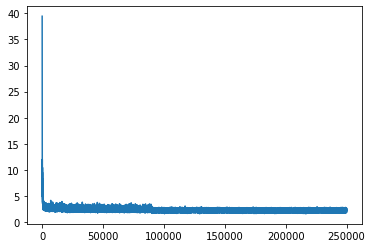

In [490]:
#determining learning rate
plt.plot(range(250000), loss_history)

In [507]:
for _ in range(20):
    out = []
    context = [0]*n_gram
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


datty.
lehanna.
zelyi.
lexsen.
elijin.
noniloria.
rhily.
anvortten.
rafsy.
jeelia.
likanaor.
emysta.
lamark.
estane.
canzrugt.
geracisa.
callekl.
sean.
riviah.
ibizane.
